# Processing US stock monthly data
- Data source: CRSP
- Sample period: 2000/1-2018/12
* File name: crsp_m_2000.csv
* Columns
    - date: date
    - permno: unique id of each stock
    - prc: closing price (< 0 if it is the average of bid and ask prices)
    - ret: monthly return
    - shrout: shares outstanding (in 1000 shares)
    - trading volume (in 100 shares)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('display.max_rows', 100, 'display.min_rows', 20)

In [3]:
plt.rcParams['figure.figsize']=(15,10)

## Data loading and preprocessing
### Load data

In [4]:
crsp = pd.read_csv('crsp_m_2000.csv')
crsp['relvol'] = 0.1*crsp.vol/crsp.shrout # trading vol relative to shares outstanding
crsp['date'] = pd.to_datetime(crsp.date) # string to Timestamp
crsp['prc'] = crsp.prc.abs() # abs(prc)

### Data inspection

In [31]:
crsp.shape # size of the table
crsp.dtypes # data types
crsp

(609247, 7)

date      datetime64[ns]
permno             int64
prc              float64
ret              float64
shrout           float64
vol              float64
relvol           float64
dtype: object

,date,permno,prc,ret,shrout,vol,relvol
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468
...,...,...,...,...,...,...,...
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840
609245,2018-11-30,93436,350.480011,0.039013,171733.0,1331285.0,0.775206


In [32]:
crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609247 entries, 0 to 609246
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    609247 non-null  datetime64[ns]
 1   permno  609247 non-null  int64         
 2   prc     593733 non-null  float64       
 3   ret     595044 non-null  float64       
 4   shrout  609247 non-null  float64       
 5   vol     598363 non-null  float64       
 6   relvol  598363 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 32.5 MB


In [33]:
crsp.describe()

,permno,prc,ret,shrout,vol,relvol
count,609247.000000,593733.000000,595044.000000,6.092470e+05,5.983630e+05,598363.000000
mean,87076.846204,20.088695,0.006790,6.777919e+04,1.328973e+05,0.168159
std,3584.821611,55.504162,0.208501,1.761328e+05,4.585374e+05,0.747183
min,80000.000000,0.007800,-1.000000,2.000000e+00,0.000000e+00,0.000000
25%,84229.000000,3.950000,-0.077211,1.177700e+04,4.859000e+03,0.032650
50%,87236.000000,11.030000,0.000000,2.705700e+04,2.703100e+04,0.090839
75%,90081.000000,24.062500,0.073465,5.769050e+04,9.896500e+04,0.196360
max,93436.000000,4736.000000,15.774193,6.433649e+06,3.875707e+07,262.246178


### Data filtering

In [5]:
# remove nan's
crsp.dropna(inplace=True)
crsp

,date,permno,prc,ret,shrout,vol,relvol
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468
...,...,...,...,...,...,...,...
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840
609245,2018-11-30,93436,350.480011,0.039013,171733.0,1331285.0,0.775206


In [6]:
# remove outliers (top/bottom 1% of returns)
lb = crsp.quantile(q = 0.01)
ub = crsp.quantile(q = 0.99)

crsp = crsp[crsp.ret >= lb.ret]
crsp = crsp[crsp.ret <= ub.ret]

## Add target and features

### Target
- The target is the relative rankings (0 to 9) of stocks based on its return in a given month. 
- In each month, the top 10% of the stocks in terms of the return has the label 0, the next 10% label 1, and so on.
- First, create the label for the return of the month. Then, shift the value back by 1 month so that we have the target (label at t+1) in the same row as the feature.

In [7]:
# Add target label
# crsp.sort_values(['permno','date'], inplace=True)
crsp['label'] = crsp.groupby('date')['ret'].apply(lambda x: pd.qcut(-x, 10, labels=False)) # make the label
crsp['tgt_ret'] = crsp.groupby('permno')['ret'].shift(-1) # shift the return back by 1 month
crsp['tgt_label'] = crsp.groupby('permno')['label'].shift(-1) # shift the label back by 1 month
crsp.dropna(inplace=True) # There will be nan's after shifting. Why?

In [8]:
crsp[crsp.permno == 80000] # to view the time series of a certain stock
crsp[crsp.date == '2002-01-31'] # to view stocks in a certain month

,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label
0,2000-01-31,80000,16.750,-0.007407,3532.0,1547.0,0.043800,4,-0.022388,6.0
1,2000-02-29,80000,16.375,-0.022388,3551.0,2394.0,0.067418,6,-0.099237,6.0
2,2000-03-31,80000,14.750,-0.099237,3558.0,2430.0,0.068297,6,-0.033898,3.0
3,2000-04-28,80000,14.250,-0.033898,3558.0,2122.0,0.059640,3,0.078947,1.0
4,2000-05-31,80000,15.375,0.078947,3577.0,1841.0,0.051468,1,0.097561,3.0
...,...,...,...,...,...,...,...,...,...,...
119,2009-12-31,80000,10.100,0.242312,5913.0,2506.0,0.042381,0,-0.177228,9.0
120,2010-01-29,80000,8.310,-0.177228,5913.0,980.0,0.016574,9,0.000000,6.0
121,2010-02-26,80000,8.310,0.000000,5913.0,1299.0,0.021969,6,0.179302,1.0
122,2010-03-31,80000,9.800,0.179302,5761.0,1419.0,0.024631,1,-0.004711,1.0


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label
24,2002-01-31,80000,27.500000,0.137304,3447.0,663.0,0.019234,1,-0.045818,5.0
151,2002-01-31,80001,1.080200,-0.008991,21616.0,17558.0,0.081227,5,-0.120533,6.0
344,2002-01-31,80002,12.350000,-0.041538,1157.0,72.0,0.006223,6,-0.006883,4.0
400,2002-01-31,80004,17.090000,0.102581,9523.0,35439.0,0.372141,2,-0.215916,8.0
570,2002-01-31,80007,19.397499,0.101505,6122.0,5569.0,0.090967,2,-0.010182,4.0
...,...,...,...,...,...,...,...,...,...,...
585533,2002-01-31,92655,74.349998,0.050586,311782.0,344748.0,0.110573,3,-0.025017,4.0
585761,2002-01-31,92663,15.770000,0.061953,24596.0,23394.0,0.095113,3,-0.032974,4.0
590701,2002-01-31,92807,4.650000,-0.031250,13681.0,3306.0,0.024165,5,0.021505,2.0
592147,2002-01-31,92874,6.149000,0.160189,4748.0,802.0,0.016891,1,-0.073183,6.0


In [10]:
crsp[crsp.permno == 80000] # to view the time series of a certain stock
crsp[crsp.date == '2002-01-31'] # to view stocks on a certain month

,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label
0,2000-01-31,80000,16.750,-0.007407,3532.0,1547.0,0.043800,4,-0.022388,6.0
1,2000-02-29,80000,16.375,-0.022388,3551.0,2394.0,0.067418,6,-0.099237,6.0
2,2000-03-31,80000,14.750,-0.099237,3558.0,2430.0,0.068297,6,-0.033898,3.0
3,2000-04-28,80000,14.250,-0.033898,3558.0,2122.0,0.059640,3,0.078947,1.0
4,2000-05-31,80000,15.375,0.078947,3577.0,1841.0,0.051468,1,0.097561,3.0
...,...,...,...,...,...,...,...,...,...,...
119,2009-12-31,80000,10.100,0.242312,5913.0,2506.0,0.042381,0,-0.177228,9.0
120,2010-01-29,80000,8.310,-0.177228,5913.0,980.0,0.016574,9,0.000000,6.0
121,2010-02-26,80000,8.310,0.000000,5913.0,1299.0,0.021969,6,0.179302,1.0
122,2010-03-31,80000,9.800,0.179302,5761.0,1419.0,0.024631,1,-0.004711,1.0


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label
24,2002-01-31,80000,27.500000,0.137304,3447.0,663.0,0.019234,1,-0.045818,5.0
151,2002-01-31,80001,1.080200,-0.008991,21616.0,17558.0,0.081227,5,-0.120533,6.0
344,2002-01-31,80002,12.350000,-0.041538,1157.0,72.0,0.006223,6,-0.006883,4.0
400,2002-01-31,80004,17.090000,0.102581,9523.0,35439.0,0.372141,2,-0.215916,8.0
570,2002-01-31,80007,19.397499,0.101505,6122.0,5569.0,0.090967,2,-0.010182,4.0
...,...,...,...,...,...,...,...,...,...,...
585533,2002-01-31,92655,74.349998,0.050586,311782.0,344748.0,0.110573,3,-0.025017,4.0
585761,2002-01-31,92663,15.770000,0.061953,24596.0,23394.0,0.095113,3,-0.032974,4.0
590701,2002-01-31,92807,4.650000,-0.031250,13681.0,3306.0,0.024165,5,0.021505,2.0
592147,2002-01-31,92874,6.149000,0.160189,4748.0,802.0,0.016891,1,-0.073183,6.0


### Features
- To predict the target, we will use size and momentum factors.
- size factor = log (market cap)
- $k$-month momentum factor: return over past $k$-months excluding the latest month return:

  Let $r_t$ denote the return over the period from $t-1$ to $t$. Then, $k$-month momentum at $t$ is given by    
    
$    
\begin{align}
MOM_k & = (1+r_{t-1})(1+r_{t-2})\cdots (1+r_{t-k+1}) -1\\
      & = \frac{(1+r_{t-1})\cdots (1+r_1)}{(1+r_{t-k})\cdots (1+r_1)} -1\\
      & = \frac{cumret_{t-1}}{cumret_{t-k}} - 1
\end{align}
$

In [9]:
# Create features
# add size
crsp['size'] = np.log(crsp.prc*crsp.shrout)

# add momentum factors
# cumulative return
crsp['cumret'] = crsp.groupby('permno')['ret'].apply(lambda x: (1+x).cumprod())
gb = crsp.groupby('permno')
numer = gb.shift(1)

# 3-month momentum
denom = gb.shift(3)
crsp['mom3m'] = numer.cumret/denom.cumret - 1
crsp['prd3m'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

# 6-month momentum
denom = gb.shift(6)
crsp['mom6m'] = numer.cumret/denom.cumret - 1
crsp['prd6m'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

# 12-month momentum
denom = gb.shift(12)
crsp['mom12m'] = numer.cumret/denom.cumret - 1
crsp['prd12m'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

crsp

,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,prd3m,mom6m,prd6m,mom12m,prd12m
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800,4,-0.022388,6.0,10.988018,0.992593,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418,6,-0.099237,6.0,10.970740,0.970370,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297,6,-0.033898,3.0,10.868197,0.874074,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640,3,0.078947,1.0,10.833711,0.844444,-0.119403,3.0,NaN,NaN,NaN,NaN
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468,1,0.097561,3.0,10.915023,0.911111,-0.129771,3.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609241,2018-07-31,93436,298.140015,-0.130660,170593.0,1723953.0,1.010565,9,0.011806,5.0,17.744599,6.909528,0.166894,3.0,-0.032062,6.0,0.060222,12.0
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,5,-0.122290,8.0,17.756336,6.991105,0.047097,3.0,-0.130939,6.0,-0.162293,12.0
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,8,0.274011,0.0,17.631655,6.136163,-0.120397,3.0,0.133506,6.0,-0.115626,12.0
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,0,0.039013,3.0,17.874728,7.817542,-0.111927,3.0,-0.099115,6.0,-0.201369,12.0


In [10]:
# remove rows with missing months
crsp = crsp[crsp.prd3m==3]
crsp = crsp[crsp.prd6m==6]
crsp = crsp[crsp.prd12m==12]

crsp.drop(columns=['prd3m','prd6m','prd12m'], inplace=True)
crsp

,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m
12,2001-01-31,80000,20.125000,0.025478,3564.0,1869.0,0.052441,6,-0.003106,3.0,11.180602,1.192593,0.019481,0.226563,0.171642
13,2001-02-28,80000,20.062500,-0.003106,3473.0,811.0,0.023352,3,0.099688,1.0,11.151626,1.188889,0.080537,0.183824,0.229008
14,2001-03-30,80000,22.062500,0.099688,3466.0,2518.0,0.072649,1,-0.027989,6.0,11.244636,1.307407,0.022293,0.163043,0.360169
15,2001-04-30,80000,21.445000,-0.027989,3466.0,1936.0,0.055857,6,0.010026,5.0,11.216248,1.270815,0.096273,0.146104,0.548246
16,2001-05-31,80000,21.660000,0.010026,3483.0,905.0,0.025983,5,-0.021237,5.0,11.231117,1.283556,0.068910,0.151409,0.394797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609241,2018-07-31,93436,298.140015,-0.130660,170593.0,1723953.0,1.010565,9,0.011806,5.0,17.744599,6.909528,0.166894,-0.032062,0.060222
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,5,-0.122290,8.0,17.756336,6.991105,0.047097,-0.130939,-0.162293
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,8,0.274011,0.0,17.631655,6.136163,-0.120397,0.133506,-0.115626
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,0,0.039013,3.0,17.874728,7.817542,-0.111927,-0.099115,-0.201369


## Inspect the features and the target

,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m
permno,1.000000,-0.014144,-0.016623,0.022337,0.005002,0.030845,0.018638,-0.014803,0.019478,0.053823,-0.053806,-0.021792,-0.027276,-0.029554
prc,-0.014144,1.000000,0.032020,0.055281,0.043736,0.055083,-0.047611,0.004117,-0.021403,0.332683,0.198629,0.044780,0.067114,0.088495
ret,-0.016623,0.032020,1.000000,-0.001315,0.000548,0.027517,-0.825818,0.012303,0.012109,0.076412,0.036931,0.014219,0.029198,0.028997
shrout,0.022337,0.055281,-0.001315,1.000000,0.657809,0.054691,-0.005791,-0.001750,-0.005502,0.470755,0.083047,0.000017,0.002109,0.005540
vol,0.005002,0.043736,0.000548,0.657809,1.000000,0.326753,-0.003327,-0.007684,0.001577,0.374461,0.052810,-0.001148,0.004935,0.018058
relvol,0.030845,0.055083,0.027517,0.054691,0.326753,1.000000,-0.016224,-0.020155,0.015916,0.232559,0.051311,0.022545,0.042977,0.074704
label,0.018638,-0.047611,-0.825818,-0.005791,-0.003327,-0.016224,1.000000,0.010366,-0.009328,-0.101537,-0.051835,0.001469,-0.017848,-0.033009
tgt_ret,-0.014803,0.004117,0.012303,-0.001750,-0.007684,-0.020155,0.010366,1.000000,-0.826067,0.013780,0.003351,0.032066,0.028684,0.035437
tgt_label,0.019478,-0.021403,0.012109,-0.005502,0.001577,0.015916,-0.009328,-0.826067,1.000000,-0.048831,-0.019819,-0.023480,-0.033518,-0.044188
size,0.053823,0.332683,0.076412,0.470755,0.374461,0.232559,-0.101537,0.013780,-0.048831,1.000000,0.298622,0.108584,0.161473,0.208675


tgt_ret      1.000000
mom12m       0.035437
mom3m        0.032066
mom6m        0.028684
size         0.013780
ret          0.012303
label        0.010366
prc          0.004117
cumret       0.003351
shrout      -0.001750
vol         -0.007684
permno      -0.014803
relvol      -0.020155
tgt_label   -0.826067
Name: tgt_ret, dtype: float64

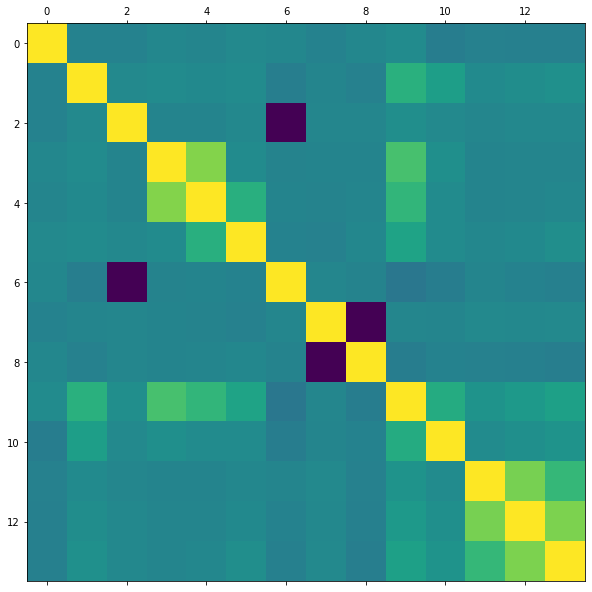

In [14]:
# Check correlations
crsp.corr() # correlations of all pairs
crsp.corr().tgt_ret.sort_values(ascending=False) # correlations between the target and the features.
plt.matshow(crsp.corr())

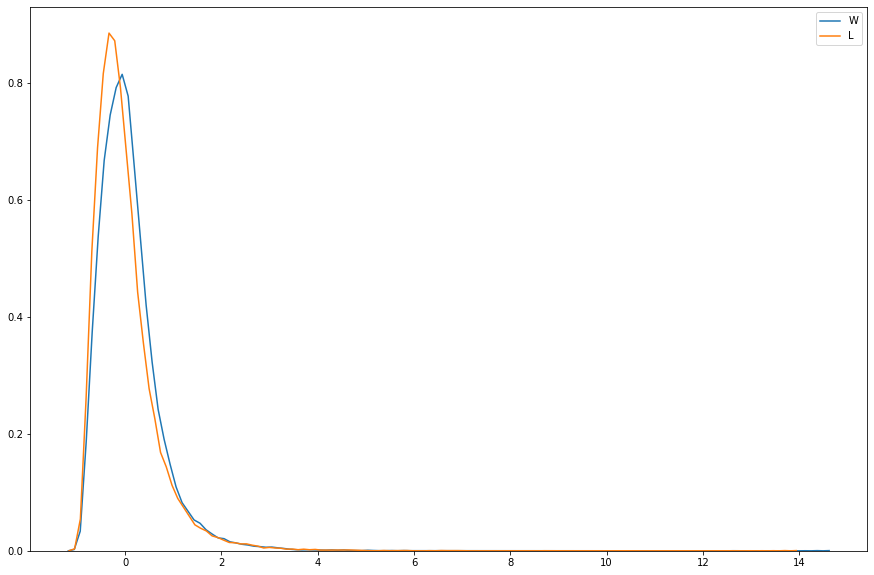

In [15]:
# Compare the distributions of the 12m momentum when the target label is 0 (winners) and 9 (losers).
sns.kdeplot(crsp[crsp['tgt_label'] == 0]['mom12m'], label='W')
sns.kdeplot(crsp[crsp['tgt_label'] == 9]['mom12m'], label='L')
plt.legend()
plt.show()

<AxesSubplot:xlabel='size', ylabel='Density'>

<AxesSubplot:xlabel='size', ylabel='Density'>

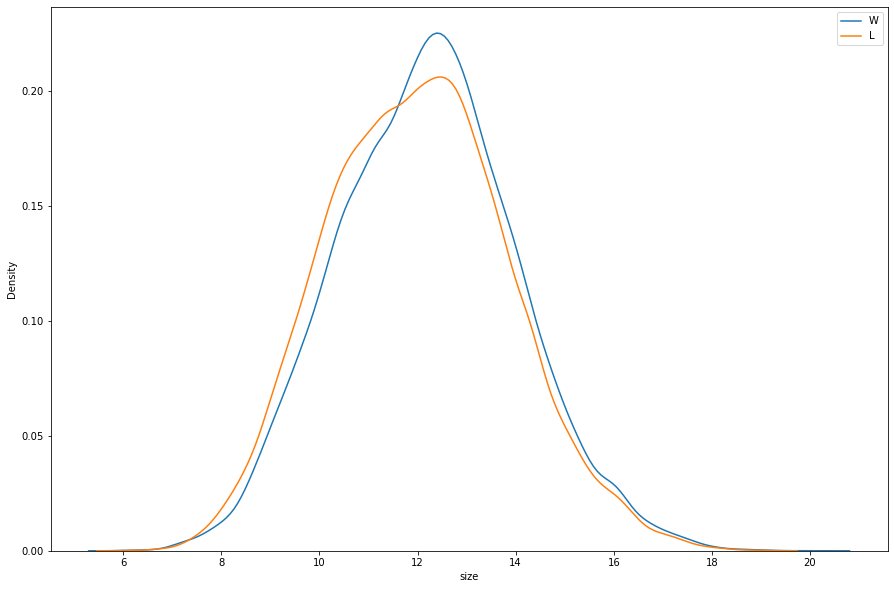

In [28]:
# Compare the distributions of the size when the target label is 0 (winners) and 9 (losers).
sns.kdeplot(crsp[crsp['tgt_label'] == 0]['size'], label='W')
sns.kdeplot(crsp[crsp['tgt_label'] == 9]['size'], label='L')
plt.legend()
plt.show()

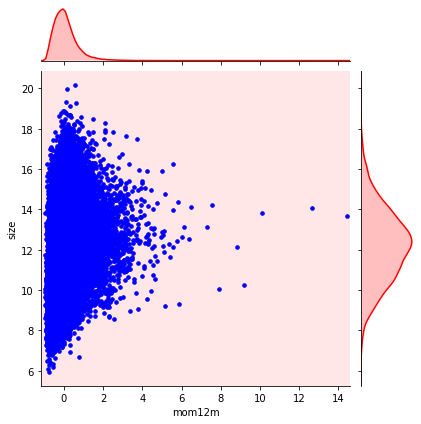

In [16]:
# Compare size and momentum together for target label 0 (i.e., winners)
data = crsp[crsp.tgt_label==0]
graph = sns.jointplot(x='mom12m', y='size', data=data, kind='kde', color='red')
graph.x = data['mom12m']
graph.y = data['size']
graph.plot_joint(plt.scatter, marker='.', c='b', s=50)
plt.show()

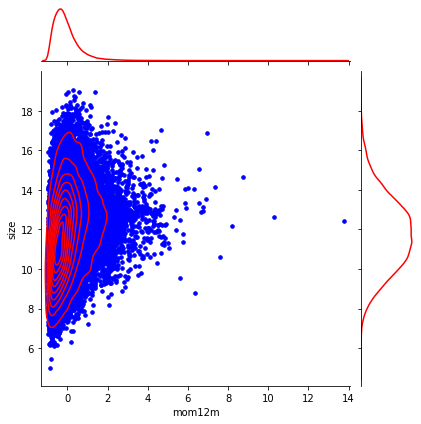

In [15]:
# Compare size and momentum together for target label 9 (i.e., losers)
data = crsp[crsp.tgt_label==9]
graph = sns.jointplot(x='mom12m', y='size', data=data, kind='kde', color='red')
graph.x = data['mom12m']
graph.y = data['size']
graph.plot_joint(plt.scatter, marker='.', c='b', s=50)
plt.show()

In [17]:
# Save the filtered file
crsp.to_csv('crsp_filtered.csv', index=False)

## Excercise

1. Add a size (market cap) categorical variable (0, ..., 9) column: size = prc*shrout. 
2. Winsorize the data (prc, vol, shrout, relvol, size) at 1% and 99%, instead of removing the outliers.
3. Remove penny stocks (price < $5) from the sample.
4. For each month, remove bottom 5% in terms of the market cap.
5. Remove stocks that have a relative trading volume of less than 1%.
6. Create a target variable as follows:

   target = 1 if $r_{t+1} > 0.01$,
   
   target = 0 if $-0.01 \leq r_{t+1} \leq 0.01$,
   
   target = -1 if $r_{t+1} < -0.01$.

In [11]:
#Question 1 
#creating size variable (not logged)

crsp['size1'] = crsp.prc*crsp.shrout #market cap
    
#Question 2: Winsorize the data 
from scipy.stats.mstats import winsorize

def winsorize_series(group):
    return winsorize(group, limits=[0.01,0.01]) #winsorize 1% from bottom and top

crsp1 = crsp.transform(winsorize_series)
crsp1


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
12,2001-03-30,80135,20.125000,0.025478,3564.0,1869.0,0.052441,6,-0.003106,3.0,11.180602,1.192593,0.019481,0.226563,0.171642,7.172550e+04
13,2001-03-30,80135,20.062500,-0.003106,3473.0,811.0,0.023352,3,0.099688,1.0,11.151626,1.188889,0.080537,0.183824,0.229008,6.967706e+04
14,2001-03-30,80135,22.062500,0.099688,3466.0,2518.0,0.072649,1,-0.027989,6.0,11.244636,1.307407,0.022293,0.163043,0.360169,7.646862e+04
15,2001-04-30,80135,21.445000,-0.027989,3466.0,1936.0,0.055857,6,0.010026,5.0,11.216248,1.270815,0.096273,0.146104,0.548246,7.432837e+04
16,2001-05-31,80135,21.660000,0.010026,3483.0,905.0,0.025983,5,-0.021237,5.0,11.231117,1.283556,0.068910,0.151409,0.394797,7.544178e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609241,2018-07-31,93266,137.919998,-0.130660,170593.0,1723953.0,0.897177,9,0.011806,5.0,17.478119,6.909528,0.166894,-0.032062,0.060222,3.896284e+07
609242,2018-08-31,93266,137.919998,0.011806,170593.0,1731284.0,0.897177,5,-0.122290,8.0,17.478119,6.991105,0.047097,-0.130939,-0.162293,3.896284e+07
609243,2018-08-31,93266,137.919998,-0.122290,171578.0,1731284.0,0.897177,8,0.274011,0.0,17.478119,6.136163,-0.120397,0.133506,-0.115626,3.896284e+07
609244,2018-08-31,93266,137.919998,0.274011,171733.0,1731284.0,0.897177,0,0.039013,3.0,17.478119,7.817542,-0.111927,-0.099115,-0.201369,3.896284e+07


In [12]:
#Question 3
#Remove penny stocks from sample
#organizing the "prc" column- removing stocks under $5


crsp1= crsp1[crsp1.prc > 5]
crsp1


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
12,2001-03-30,80135,20.125000,0.025478,3564.0,1869.0,0.052441,6,-0.003106,3.0,11.180602,1.192593,0.019481,0.226563,0.171642,7.172550e+04
13,2001-03-30,80135,20.062500,-0.003106,3473.0,811.0,0.023352,3,0.099688,1.0,11.151626,1.188889,0.080537,0.183824,0.229008,6.967706e+04
14,2001-03-30,80135,22.062500,0.099688,3466.0,2518.0,0.072649,1,-0.027989,6.0,11.244636,1.307407,0.022293,0.163043,0.360169,7.646862e+04
15,2001-04-30,80135,21.445000,-0.027989,3466.0,1936.0,0.055857,6,0.010026,5.0,11.216248,1.270815,0.096273,0.146104,0.548246,7.432837e+04
16,2001-05-31,80135,21.660000,0.010026,3483.0,905.0,0.025983,5,-0.021237,5.0,11.231117,1.283556,0.068910,0.151409,0.394797,7.544178e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609241,2018-07-31,93266,137.919998,-0.130660,170593.0,1723953.0,0.897177,9,0.011806,5.0,17.478119,6.909528,0.166894,-0.032062,0.060222,3.896284e+07
609242,2018-08-31,93266,137.919998,0.011806,170593.0,1731284.0,0.897177,5,-0.122290,8.0,17.478119,6.991105,0.047097,-0.130939,-0.162293,3.896284e+07
609243,2018-08-31,93266,137.919998,-0.122290,171578.0,1731284.0,0.897177,8,0.274011,0.0,17.478119,6.136163,-0.120397,0.133506,-0.115626,3.896284e+07
609244,2018-08-31,93266,137.919998,0.274011,171733.0,1731284.0,0.897177,0,0.039013,3.0,17.478119,7.817542,-0.111927,-0.099115,-0.201369,3.896284e+07


In [13]:
#Question 4- removing bottom 5% of the data
li= list()

for da in crsp1["date"]: 
    if str(da) not in li:
        li.append(str(da))
        
li #all of the datetime objects have been converted to strings


['2001-03-30 00:00:00',
 '2001-04-30 00:00:00',
 '2001-05-31 00:00:00',
 '2001-06-29 00:00:00',
 '2001-07-31 00:00:00',
 '2001-08-31 00:00:00',
 '2001-09-28 00:00:00',
 '2001-10-31 00:00:00',
 '2001-11-30 00:00:00',
 '2001-12-31 00:00:00',
 '2002-01-31 00:00:00',
 '2002-02-28 00:00:00',
 '2002-03-28 00:00:00',
 '2002-04-30 00:00:00',
 '2002-05-31 00:00:00',
 '2002-06-28 00:00:00',
 '2002-07-31 00:00:00',
 '2002-08-30 00:00:00',
 '2002-09-30 00:00:00',
 '2002-10-31 00:00:00',
 '2002-11-29 00:00:00',
 '2002-12-31 00:00:00',
 '2003-01-31 00:00:00',
 '2003-02-28 00:00:00',
 '2003-03-31 00:00:00',
 '2003-04-30 00:00:00',
 '2003-05-30 00:00:00',
 '2003-06-30 00:00:00',
 '2003-07-31 00:00:00',
 '2003-08-29 00:00:00',
 '2003-09-30 00:00:00',
 '2003-10-31 00:00:00',
 '2003-11-28 00:00:00',
 '2003-12-31 00:00:00',
 '2004-01-30 00:00:00',
 '2004-02-27 00:00:00',
 '2004-03-31 00:00:00',
 '2004-04-30 00:00:00',
 '2004-05-28 00:00:00',
 '2004-06-30 00:00:00',
 '2004-07-30 00:00:00',
 '2004-08-31 00:

In [14]:
crsp2= pd.DataFrame(columns=list(crsp1.columns))
crsp2 #creating an empty dataframe to copy to

for x in range(len(li)):
    if x != len(li)-1:
        sd=li[x]  #setting the bounds for that date
        ed=li[x+1]
        m= (crsp1["date"] >= sd) & (crsp1["date"] < ed)
        new= crsp1.loc[m]
        n= new["size1"]
        rem = new["size1"].between(n.quantile(0.05), n.quantile(1)) #removing bottom 5% of market cap
        new[rem]
        crsp2= crsp2.append(new[rem]) #putting this segmented data into the new frame
        
    else:
        new_date = li[-1]   #new set of code for the last date/month
        m = (crsp1["date"]== new_date)
        new = crsp1.loc[m]
        n = new["size1"]
        rem = new["size1"].between(n.quantile(0.05), n.quantile(1))
        new[rem]
        crsp2= crsp2.append(new[rem])  #combining the new data frame for the result
        
crsp2
        

,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
12,2001-03-30,80135,20.1250,0.025478,3564.0,1869.0,0.052441,6,-0.003106,3.0,11.180602,1.192593,0.019481,0.226563,0.171642,71725.5000
13,2001-03-30,80135,20.0625,-0.003106,3473.0,811.0,0.023352,3,0.099688,1.0,11.151626,1.188889,0.080537,0.183824,0.229008,69677.0625
14,2001-03-30,80135,22.0625,0.099688,3466.0,2518.0,0.072649,1,-0.027989,6.0,11.244636,1.307407,0.022293,0.163043,0.360169,76468.6250
388,2001-03-30,80135,9.6250,0.375000,6803.0,9678.0,0.142261,1,-0.331169,8.0,11.089483,2.851852,0.120000,0.647059,0.866667,65478.8750
389,2001-03-30,80135,6.4375,-0.331169,6824.0,5714.0,0.083734,8,-0.252427,8.0,10.690341,1.907407,0.540000,0.540000,0.629630,43929.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585750,2001-03-30,92663,9.8750,0.046358,17944.0,9808.0,0.054659,1,0.113924,1.0,12.085017,1.244094,0.398148,0.258333,0.354260,177197.0000
585751,2001-03-30,92663,11.0000,0.113924,17949.0,11423.0,0.063641,1,-0.012727,6.0,12.193185,1.385827,0.161765,0.338983,0.410714,197439.0000
598841,2001-03-30,93105,12.6250,0.086022,41502.0,9070.0,0.021854,5,-0.057756,4.0,13.169176,1.242647,0.260780,0.202357,0.194594,523962.7500
598842,2001-03-30,93105,11.8750,-0.057756,41502.0,7266.0,0.017508,4,-0.003509,3.0,13.107932,1.170877,0.395100,0.346646,0.516761,492836.2500


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
15,2001-04-30,80135,21.445000,-0.027989,3466.0,1936.0,0.055857,6,0.010026,5.0,11.216248,1.270815,0.096273,0.146104,0.548246,7.432837e+04
391,2001-04-30,80135,5.750000,0.194805,7702.0,3012.0,0.039107,2,0.354783,0.0,10.698435,1.703704,-0.447855,-0.230000,-0.037500,4.428650e+04
537,2001-04-30,80135,10.000000,0.025641,11065.0,2743.0,0.024790,5,0.040000,4.0,11.614127,1.684211,-0.048780,-0.025000,0.560000,1.106500e+05
561,2001-04-30,80135,22.000000,-0.043478,3799.0,1321.0,0.034772,7,0.070455,4.0,11.333536,1.136209,0.114217,0.626140,0.368433,8.357800e+04
775,2001-04-30,80135,17.549999,-0.011268,2484.0,1130.0,0.045491,6,0.116809,3.0,10.682679,1.414514,0.096922,0.419446,0.494415,4.359420e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571436,2001-04-30,92284,14.350000,-0.092490,10042.0,9061.0,0.090231,8,-0.076446,7.0,11.878282,0.806427,0.134835,0.563372,-0.049261,1.441027e+05
585524,2001-04-30,92655,65.480003,0.104961,322060.0,460867.0,0.143100,3,-0.121869,8.0,16.864238,2.467618,0.051055,0.084160,0.778144,2.108849e+07
585752,2001-04-30,92663,10.860000,-0.012727,18284.0,10472.0,0.057274,6,0.240332,1.0,12.198868,1.368189,0.165563,0.419355,0.795918,1.985642e+05
592138,2001-04-30,92874,6.000000,-0.232000,4559.0,673.0,0.014762,9,-0.041667,7.0,10.216618,0.951933,0.255230,0.250000,0.219512,2.735400e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
16,2001-05-31,80135,21.660000,0.010026,3483.0,905.0,0.025983,5,-0.021237,5.0,11.231117,1.283556,0.068910,1.514094e-01,0.394797,7.544178e+04
392,2001-05-31,80135,7.790000,0.354783,7702.0,6882.0,0.089353,0,0.264442,0.0,11.002076,2.308148,-0.106796,-8.000001e-02,0.448819,5.999858e+04
538,2001-05-31,80135,10.400000,0.040000,11065.0,2287.0,0.020669,4,-0.009615,5.0,11.653348,1.751579,0.025641,2.759615e-10,0.666667,1.150760e+05
562,2001-05-31,80135,23.549999,0.070455,3799.0,911.0,0.023980,4,0.039915,3.0,11.401619,1.216260,0.019702,6.490529e-01,0.378879,8.946645e+04
776,2001-05-31,80135,19.520000,0.116809,2484.0,1947.0,0.078382,3,0.014344,4.0,10.789065,1.579742,-0.073267,3.492163e-01,0.411234,4.848768e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585525,2001-05-31,92655,57.500000,-0.121869,317184.0,718019.0,0.226373,8,0.073913,2.0,16.719022,2.166891,0.106081,1.168998e-01,0.757268,1.823808e+07
585753,2001-05-31,92663,13.470000,0.240332,18284.0,28124.0,0.153818,1,0.043059,3.0,12.414247,1.697008,0.099747,6.088888e-01,0.686990,2.462855e+05
590693,2001-05-31,92807,5.070000,0.014000,13542.0,4640.0,0.034264,5,0.033531,4.0,11.136892,0.853431,0.255047,1.996777e-01,0.196959,6.865794e+04
592139,2001-05-31,92874,5.750000,-0.041667,4745.0,342.0,0.007208,7,-0.100000,7.0,10.214047,0.912269,-0.009032,-1.206106e-01,0.010526,2.728375e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
17,2001-06-29,80135,21.200001,-0.021237,3493.0,1383.0,0.039593,5,0.035377,2.0,11.212517,1.256296,-0.018244,0.103694,0.283556,7.405160e+04
393,2001-06-29,80135,9.850000,0.264442,7894.0,14823.0,0.187776,0,0.127919,1.0,11.261330,2.918519,0.597164,0.112857,0.719172,7.775590e+04
539,2001-06-29,80135,10.300000,-0.009615,11071.0,3522.0,0.031813,5,-0.247573,8.0,11.644228,1.734737,0.066667,0.053165,0.459649,1.140313e+05
563,2001-06-29,80135,24.370001,0.039915,3799.0,1242.0,0.032693,3,0.075092,2.0,11.435846,1.264807,0.023913,0.434719,0.488755,9.258163e+04
777,2001-06-29,80135,19.799999,0.014344,2468.0,895.0,0.036264,4,-0.021465,4.0,10.796845,1.602402,0.104225,0.369238,0.516038,4.886640e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585526,2001-06-29,92655,61.750000,0.073913,317184.0,384485.0,0.121218,2,0.091822,1.0,16.790331,2.327053,-0.029700,-0.062662,0.341787,1.958611e+07
585754,2001-06-29,92663,14.050000,0.043059,23666.0,79740.0,0.336939,3,0.127402,1.0,12.714417,1.770079,0.224545,0.584706,0.857931,3.325073e+05
590694,2001-06-29,92807,5.150000,0.033531,13550.0,4554.0,0.033609,4,0.128155,1.0,11.153139,0.882047,0.111233,0.216473,0.516108,6.978250e+04
592140,2001-06-29,92874,5.175000,-0.100000,4559.0,409.0,0.008971,7,-0.053140,5.0,10.068698,0.821042,-0.264000,-0.064407,0.200000,2.359283e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
18,2001-07-31,80135,21.950001,0.035377,3493.0,960.0,0.027484,2,0.034169,2.0,11.247283,1.300741,-0.011425,0.053416,0.325000,7.667135e+04
394,2001-07-31,80135,11.110000,0.127919,7894.0,12031.0,0.152407,1,-0.226823,8.0,11.381704,3.291852,0.597164,0.023377,1.317647,8.770234e+04
540,2001-07-31,80135,7.750000,-0.247573,11075.0,2442.0,0.022050,8,0.019355,2.0,11.360138,1.305263,0.030000,0.004878,0.445614,8.583125e+04
564,2001-07-31,80135,26.200001,0.075092,3799.0,1245.0,0.032772,2,0.059160,1.0,11.508253,1.359784,0.113182,0.186399,0.557233,9.953380e+04
778,2001-07-31,80135,19.375000,-0.021465,2469.0,2728.0,0.110490,4,0.047742,2.0,10.775552,1.568007,0.132829,0.228624,0.647626,4.783688e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571439,2001-07-31,92284,13.600000,-0.150000,10042.0,7621.0,0.075891,7,0.006103,3.0,11.824601,0.767930,0.120308,0.153776,0.431342,1.365712e+05
585527,2001-07-31,92655,67.419998,0.091822,317184.0,337874.0,0.106523,1,0.009493,3.0,16.878179,2.540727,-0.056964,0.095218,0.510313,2.138454e+07
585755,2001-07-31,92663,15.840000,0.127402,23666.0,58825.0,0.248563,1,-0.200758,8.0,12.834333,1.995591,0.293739,0.488742,1.081482,3.748694e+05
590695,2001-07-31,92807,5.810000,0.128155,13550.0,2725.0,0.020111,1,-0.063683,5.0,11.273722,0.995086,0.048000,0.221340,0.130579,7.872550e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
19,2001-08-31,80135,22.700001,0.034169,3493.0,833.0,0.023848,2,-0.074890,3.0,11.280881,1.345185,0.013389,0.094081,0.291177,7.929110e+04
395,2001-08-31,80135,8.590000,-0.226823,7894.0,7706.0,0.097618,8,-0.026775,2.0,11.124457,2.545185,0.426187,0.725825,0.777600,6.780946e+04
541,2001-08-31,80135,7.900000,0.019355,11080.0,7119.0,0.064251,2,-0.208861,6.0,11.379760,1.330526,-0.254808,-0.205128,0.148148,8.753200e+04
565,2001-08-31,80135,18.500000,0.059160,5699.0,4459.0,0.078242,1,-0.168649,5.0,11.565817,1.440229,0.118005,0.220352,0.731550,1.054315e+05
779,2001-08-31,80135,20.219999,0.047742,2469.0,1095.0,0.044350,2,-0.075173,3.0,10.818241,1.642867,-0.007428,0.027295,0.555745,4.992318e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585528,2001-08-31,92655,68.059998,0.009493,317184.0,314016.0,0.099001,3,-0.022921,2.0,16.887627,2.564846,0.172522,0.138851,0.427601,2.158754e+07
585756,2001-08-31,92663,12.660000,-0.200758,24530.0,30113.0,0.122760,8,0.158768,0.0,12.646100,1.594961,0.175947,0.604051,1.112000,3.105498e+05
590696,2001-08-31,92807,5.350000,-0.063683,13587.0,1935.0,0.014242,5,-0.140187,5.0,11.193965,0.931715,0.165983,0.483851,0.429249,7.269045e+04
592142,2001-08-31,92874,5.375000,0.096939,4747.0,854.0,0.017990,1,0.069767,0.0,10.147027,0.852773,-0.147826,-0.190710,-0.104000,2.551512e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
20,2001-09-28,80135,21.000000,-0.074890,3442.0,1281.0,0.037217,3,-0.005714,6.0,11.188330,1.244444,0.070755,0.028895,0.315942,7.228200e+04
396,2001-09-28,80135,8.360000,-0.026775,8055.0,3260.0,0.040472,2,0.076555,3.0,11.117507,2.477037,-0.127919,0.784935,0.431667,6.733980e+04
542,2001-09-28,80135,6.250000,-0.208861,11080.0,1451.0,0.013096,6,0.003296,6.0,11.145478,1.052632,-0.233010,-0.189744,-0.145946,6.925000e+04
566,2001-09-28,80135,15.300000,-0.168649,5673.0,1761.0,0.031042,5,0.078431,3.0,11.371326,1.197337,0.138695,0.212463,0.889139,8.679690e+04
780,2001-09-28,80135,18.700001,-0.075173,2449.0,1335.0,0.054512,3,0.002807,5.0,10.731959,1.519367,0.025253,0.148349,0.463395,4.579630e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571441,2001-09-28,92284,9.400000,-0.309839,10041.0,6563.0,0.065362,8,-0.126596,8.0,11.455142,0.533230,-0.144813,-0.130539,0.238465,9.438540e+04
585529,2001-09-28,92655,66.500000,-0.022921,317184.0,391541.0,0.123443,2,-0.011278,6.0,16.864439,2.506057,0.102186,0.148498,0.379128,2.109274e+07
585757,2001-09-28,92663,14.670000,0.158768,24538.0,16300.0,0.066428,0,-0.004772,6.0,12.793783,1.848189,-0.098932,0.150909,0.716610,3.599725e+05
592143,2001-09-28,92874,5.750000,0.069767,4747.0,334.0,0.007036,0,-0.043478,7.0,10.214468,0.912269,0.038647,-0.312000,-0.229851,2.729525e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
21,2001-10-31,80135,20.879999,-0.005714,3442.0,607.0,0.017635,6,0.068008,4.0,11.182600,1.237333,-0.043280,-0.020751,0.090909,7.186896e+04
397,2001-10-31,80135,9.000000,0.076555,9155.0,4280.0,0.046750,3,0.345556,0.0,11.319280,2.666667,-0.247525,0.453913,0.337600,8.239500e+04
567,2001-10-31,80135,16.500000,0.078431,5673.0,4576.0,0.080663,3,0.090303,3.0,11.446834,1.291245,-0.119466,0.053800,0.639121,9.360450e+04
781,2001-10-31,80135,18.752501,0.002807,2440.0,537.0,0.022008,5,0.106519,3.0,10.731080,1.523633,-0.031020,0.074127,0.507486,4.575610e+04
1023,2001-10-31,80135,22.000000,0.219512,13898.0,11328.0,0.081508,1,-0.090909,8.0,12.630543,0.715447,-0.180000,-0.367018,-0.676413,3.057560e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571442,2001-10-31,92284,8.210000,-0.126596,10041.0,9216.0,0.091784,8,0.109988,3.0,11.319785,0.465726,-0.305627,-0.338775,-0.061870,8.243661e+04
585530,2001-10-31,92655,65.750000,-0.011278,317184.0,433680.0,0.136728,6,0.086692,3.0,16.853097,2.477793,-0.013646,0.015577,0.216616,2.085485e+07
585758,2001-10-31,92663,14.600000,-0.004772,24538.0,13163.0,0.053643,6,-0.045890,7.0,12.789000,1.839370,-0.073864,0.350829,0.892903,3.582548e+05
592144,2001-10-31,92874,5.500000,-0.043478,4747.0,565.0,0.011902,7,-0.081636,8.0,10.170016,0.872605,0.173469,-0.041667,-0.080000,2.610850e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
22,2001-11-30,80135,22.299999,0.068008,3443.0,1073.0,0.031165,4,0.084305,3.0,11.248685,1.321481,-0.080176,-0.036011,0.121074,7.677890e+04
398,2001-11-30,80135,12.110000,0.345556,9155.0,13098.0,0.143069,0,0.279934,0.0,11.616087,3.588148,0.047730,0.155327,0.440000,1.108670e+05
568,2001-11-30,80135,17.990000,0.090303,5673.0,2140.0,0.037723,3,-0.016676,7.0,11.533289,1.407849,-0.103445,0.061653,0.874068,1.020573e+05
782,2001-11-30,80135,20.670000,0.106519,2440.0,678.0,0.027787,3,0.018384,5.0,10.828437,1.685929,-0.072577,-0.035518,0.453298,5.043480e+04
1024,2001-11-30,80135,20.000000,-0.090909,13898.0,12933.0,0.093057,8,0.050000,4.0,12.535232,0.650407,0.101653,-0.149265,-0.439490,2.779600e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571443,2001-11-30,92284,9.050000,0.109988,10041.0,4071.0,0.040544,3,0.098342,3.0,11.417197,0.516950,-0.397210,-0.374680,0.138704,9.087105e+04
585531,2001-11-30,92655,71.449997,0.086692,311781.0,379461.0,0.121708,3,-0.009517,6.0,16.919054,2.692598,-0.033941,0.143478,0.121505,2.227675e+07
585759,2001-11-30,92663,13.930000,-0.045890,24538.0,20334.0,0.082867,7,0.066045,4.0,12.742023,1.754961,0.153239,0.083890,1.162963,3.418143e+05
592145,2001-11-30,92874,5.051000,-0.081636,4748.0,195.0,0.004107,8,0.049297,4.0,10.085065,0.801369,0.023256,-0.043478,-0.193893,2.398215e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
23,2001-12-31,80135,24.180000,0.084305,3447.0,930.0,0.026980,3,0.137304,1.0,11.330785,1.432889,0.061905,0.051887,0.136306,8.334846e+04
399,2001-12-31,80135,15.500000,0.279934,9523.0,44728.0,0.469684,0,0.102581,2.0,11.902305,4.592593,0.448565,0.229442,0.730000,1.476065e+05
569,2001-12-31,80135,17.610001,-0.016676,6122.0,2346.0,0.038321,7,0.101505,2.0,11.588111,1.384372,0.175817,0.113094,0.660721,1.078084e+05
783,2001-12-31,80135,21.049999,0.018384,2430.0,1139.0,0.046872,5,0.068884,2.0,10.842547,1.716923,0.109626,0.052126,0.461276,5.115150e+04
1025,2001-12-31,80135,21.000000,0.050000,13914.0,6993.0,0.050259,4,-0.023810,5.0,12.585173,0.682927,0.108647,-0.235182,-0.453925,2.921940e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571444,2001-12-31,92284,9.940000,0.098342,10041.0,7432.0,0.074017,3,-0.090543,7.0,11.510999,0.567788,-0.030532,-0.427803,0.048808,9.980754e+04
585532,2001-12-31,92655,70.769997,-0.009517,311781.0,334353.0,0.107240,6,0.050586,3.0,16.909491,2.666972,0.074436,0.157085,0.164744,2.206474e+07
585760,2001-12-31,92663,14.850000,0.066045,24596.0,26157.0,0.106347,4,0.061953,3.0,12.808339,1.870866,-0.050443,-0.008541,0.638824,3.652506e+05
592146,2001-12-31,92874,5.300000,0.049297,4748.0,392.0,0.008256,4,0.160189,1.0,10.133186,0.840874,-0.121565,-0.023961,-0.178142,2.516440e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
24,2002-01-31,80135,27.500000,0.137304,3447.0,663.0,0.019234,1,-0.045818,5.0,11.459446,1.629630,0.158046,0.101595,0.201491,9.479250e+04
400,2002-01-31,80135,17.090000,0.102581,9523.0,35439.0,0.372141,2,-0.215916,8.0,11.999959,5.063704,0.597164,0.395140,0.610390,1.627481e+05
570,2002-01-31,80135,19.397499,0.101505,6122.0,5569.0,0.090967,2,-0.010182,4.0,11.684788,1.524892,0.072121,0.018082,0.298551,1.187515e+05
784,2002-01-31,80135,22.500000,0.068884,2430.0,243.0,0.010000,2,0.001333,3.0,10.909162,1.835191,0.126861,0.094972,0.316432,5.467500e+04
1026,2002-01-31,80135,20.500000,-0.023810,13914.0,7045.0,0.050632,5,-0.012195,4.0,12.561076,0.666667,-0.045455,-0.045455,-0.436242,2.852370e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571445,2002-01-31,92284,9.040000,-0.090543,10041.0,10271.0,0.102291,7,0.063385,1.0,11.416091,0.516378,0.219147,-0.260626,-0.274889,9.077064e+04
585533,2002-01-31,92655,74.349998,0.050586,311782.0,344748.0,0.110573,3,-0.025017,4.0,16.958843,2.801885,0.076350,0.049688,0.255200,2.318099e+07
585761,2002-01-31,92663,15.770000,0.061953,24596.0,23394.0,0.095113,3,-0.032974,4.0,12.868449,1.986772,0.017123,-0.062500,0.573510,3.878789e+05
592147,2002-01-31,92874,6.149000,0.160189,4748.0,802.0,0.016891,1,-0.073183,6.0,10.281768,0.975573,-0.036364,0.081633,-0.148452,2.919545e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
25,2002-02-28,80135,26.240000,-0.045818,3450.0,1206.0,0.034957,5,0.002287,6.0,11.413414,1.554963,0.233184,0.211454,0.370717,9.052800e+04
401,2002-02-28,80135,13.400000,-0.215916,9657.0,22353.0,0.231469,8,0.171642,2.0,11.770693,3.970370,0.411230,0.989523,1.654757,1.294038e+05
571,2002-02-28,80135,19.200001,-0.010182,6122.0,4925.0,0.080448,4,0.061250,4.0,11.674554,1.509366,0.083136,0.058784,0.368529,1.175424e+05
785,2002-02-28,80135,22.450001,0.001333,2430.0,3493.0,0.143745,3,0.086860,4.0,10.906937,1.837638,0.088534,0.117066,0.202344,5.455350e+04
1027,2002-02-28,80135,20.250000,-0.012195,13914.0,5405.0,0.038846,4,0.002963,6.0,12.548806,0.658537,0.025000,0.026540,-0.253273,2.817585e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571446,2002-02-28,92284,9.550000,0.063385,10041.0,5878.0,0.058540,1,0.336126,0.0,11.470973,0.549109,-0.001105,-0.331650,-0.306512,9.589155e+04
585534,2002-02-28,92655,72.489998,-0.025017,311782.0,287299.0,0.092147,4,0.054628,5.0,16.933508,2.731791,0.040588,0.092418,0.255912,2.260108e+07
585762,2002-02-28,92663,15.250000,-0.032974,24738.0,23864.0,0.096467,4,-0.017705,7.0,12.840675,1.921260,0.132089,0.245656,0.596962,3.772545e+05
592148,2002-02-28,92874,5.699000,-0.073183,4749.0,259.0,0.005454,6,0.425439,0.0,10.205980,0.904178,0.217383,0.144000,0.015577,2.706455e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
26,2002-03-28,80135,26.299999,0.002287,3458.0,851.0,0.024610,6,0.044487,3.0,11.418015,1.558518,0.085194,0.249524,0.189348,9.094540e+04
402,2002-03-28,80135,15.700000,0.171642,10035.0,15791.0,0.157359,2,-0.222930,8.0,11.967495,4.651852,-0.135484,0.602871,1.784416,1.575495e+05
572,2002-03-28,80135,20.266001,0.061250,6122.0,2893.0,0.047256,4,0.228659,0.0,11.728589,1.601815,0.090290,0.260603,0.270666,1.240685e+05
786,2002-03-28,80135,24.400000,0.086860,2425.0,1992.0,0.082144,4,0.040984,3.0,10.988170,1.997255,0.070309,0.209476,0.284493,5.917000e+04
1028,2002-03-28,80135,20.309999,0.002963,13937.0,4281.0,0.030717,6,0.115707,1.0,12.553416,0.660488,-0.035714,0.122505,-0.250000,2.830605e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571447,2002-03-28,92284,12.760000,0.336126,10041.0,6161.0,0.061358,0,0.093260,2.0,11.760747,0.733679,-0.032897,0.029779,-0.382062,1.281232e+05
585535,2002-03-28,92655,76.419998,0.054628,311782.0,373606.0,0.119829,5,0.149045,1.0,16.986304,2.881023,0.024304,0.090075,0.223253,2.382638e+07
585763,2002-03-28,92663,14.980000,-0.017705,24560.0,53048.0,0.215993,7,0.067423,2.0,12.815590,1.887244,0.026936,0.039536,0.386364,3.679088e+05
592149,2002-03-28,92874,8.389000,0.427711,4749.0,1092.0,0.022994,0,-0.105972,7.0,10.592611,1.330961,0.075283,-0.008870,-0.270528,3.983936e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
27,2002-04-30,80135,27.469999,0.044487,3458.0,1069.0,0.030914,3,-0.070542,6.0,11.461540,1.627852,-0.043636,0.259579,0.226393,9.499126e+04
403,2002-04-30,80135,12.200000,-0.222930,10048.0,14093.0,0.140257,8,0.311475,0.0,11.716565,3.614815,-0.081334,0.744444,1.730435,1.225856e+05
573,2002-04-30,80135,24.900000,0.228659,6122.0,6333.0,0.103447,0,0.004016,4.0,11.934512,1.968084,0.050445,0.240519,0.409789,1.524378e+05
787,2002-04-30,80135,25.400000,0.040984,2430.0,348.0,0.014321,3,0.111024,1.0,11.030396,2.079109,0.088309,0.310850,0.411973,6.172200e+04
1029,2002-04-30,80135,22.660000,0.115707,13952.0,5519.0,0.039557,1,0.014563,3.0,12.663979,0.736911,-0.009268,-0.076818,-0.287368,3.161523e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571448,2002-04-30,92284,13.950000,0.093260,10041.0,5708.0,0.056847,2,-0.002652,4.0,11.849911,0.802102,0.420816,0.575346,-0.090211,1.400719e+05
585536,2002-04-30,92655,87.809998,0.149045,307949.0,498864.0,0.161996,1,0.034051,2.0,17.112865,3.310425,0.028245,0.162738,0.167532,2.704100e+07
585764,2002-04-30,92663,15.990000,0.067423,24560.0,32779.0,0.133465,2,0.116323,1.0,12.880838,2.014488,-0.050095,0.026027,0.379374,3.927144e+05
592150,2002-04-30,92874,7.500000,-0.105972,4749.0,595.0,0.012529,7,-0.046667,5.0,10.480592,1.189916,0.364287,0.525273,0.398167,3.561750e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
28,2002-05-31,80135,25.532200,-0.070542,3480.0,4503.0,0.129397,6,-0.054527,4.0,11.394728,1.513019,0.046875,0.231839,0.268236,8.885206e+04
404,2002-05-31,80135,16.000000,0.311475,10048.0,12348.0,0.122890,0,0.026875,2.0,11.987718,4.740741,-0.089552,0.007432,0.566110,1.607680e+05
574,2002-05-31,80135,25.000000,0.004016,6122.0,2839.0,0.046374,4,0.093640,1.0,11.938520,1.975987,0.303914,0.397937,0.618144,1.530500e+05
788,2002-05-31,80135,28.139999,0.111024,2430.0,538.0,0.022140,1,0.008351,2.0,11.132839,2.309940,0.131403,0.233213,0.316107,6.838020e+04
839,2002-05-31,80135,22.900000,-0.079952,12868.0,30500.0,0.237022,6,-0.159389,7.0,12.593636,1.886631,0.216520,0.292987,0.102303,2.946772e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571449,2002-05-31,92284,13.850000,-0.002652,10041.0,7618.0,0.075869,4,-0.215885,8.0,11.842717,0.799974,0.460733,0.551605,0.076966,1.390679e+05
585537,2002-05-31,92655,90.800003,0.034051,307949.0,411935.0,0.133767,2,0.008260,2.0,17.146349,3.423148,0.211815,0.229454,0.527730,2.796177e+07
585765,2002-05-31,92663,17.850000,0.116323,24575.0,23064.0,0.093851,1,0.086274,1.0,12.991488,2.248819,0.048525,0.147882,0.187082,4.386638e+05
592151,2002-05-31,92874,7.150000,-0.046667,4767.0,338.0,0.007090,5,-0.097902,6.0,10.436585,1.134387,0.316020,0.484854,0.304348,3.408405e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
29,2002-06-28,80135,24.139999,-0.054527,3484.0,619.0,0.017767,4,-0.154930,6.0,11.339807,1.430518,-0.029194,0.055922,0.204349,8.410376e+04
405,2002-06-28,80135,16.430000,0.026875,10122.0,19906.0,0.196661,2,-0.300061,8.0,12.021576,4.868148,0.019108,0.032258,0.624365,1.663045e+05
575,2002-06-28,80135,27.231001,0.093640,6122.0,6933.0,0.113247,1,-0.021336,2.0,12.024000,2.161019,0.233593,0.427353,0.562284,1.667082e+05
789,2002-06-28,80135,28.375000,0.008351,2436.0,1689.0,0.069335,2,-0.003348,2.0,11.143621,2.329230,0.156557,0.345395,0.441548,6.912150e+04
840,2002-06-28,80135,19.250000,-0.159389,13588.0,21972.0,0.161702,7,-0.016104,2.0,12.474453,1.585923,-0.127619,0.085308,-0.115830,2.615690e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571450,2002-06-28,92284,10.860000,-0.215885,10041.0,25866.0,0.257604,8,-0.176796,6.0,11.599518,0.627272,0.090361,0.408932,-0.114531,1.090453e+05
585538,2002-06-28,92655,91.550003,0.008260,307949.0,532465.0,0.172907,2,-0.042490,3.0,17.154575,3.451423,0.188171,0.283533,0.471023,2.819273e+07
585766,2002-06-28,92663,19.389999,0.086274,24613.0,26150.0,0.106245,1,-0.123259,5.0,13.075787,2.442835,0.191589,0.202020,0.270463,4.772461e+05
592152,2002-06-28,92874,6.450000,-0.097902,4754.0,230.0,0.004838,6,0.007752,1.0,10.330822,1.023328,-0.147693,0.349057,0.381642,3.066330e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
30,2002-07-31,80135,20.400000,-0.154930,3484.0,2030.0,0.058266,6,-0.019608,5.0,11.171471,1.208889,-0.121223,-0.122182,0.099772,7.107360e+04
406,2002-07-31,80135,11.500000,-0.300061,10157.0,15978.0,0.157310,8,-0.139130,8.0,11.668265,3.407407,0.346721,-0.038619,0.478848,1.168055e+05
576,2002-07-31,80135,26.650000,-0.021336,6122.0,3865.0,0.063133,2,-0.013884,5.0,12.002433,2.114911,0.098032,0.417162,0.589237,1.631513e+05
790,2002-07-31,80135,28.280001,-0.003348,2436.0,769.0,0.031568,2,0.120934,1.0,11.140267,2.321432,0.120302,0.269203,0.485472,6.889008e+04
841,2002-07-31,80135,18.940001,-0.016104,13588.0,19344.0,0.142361,2,-0.057022,6.0,12.458218,1.560384,-0.226597,0.046196,-0.368645,2.573567e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571451,2002-07-31,92284,8.940000,-0.176796,10041.0,10560.0,0.105169,6,-0.058948,6.0,11.404968,0.516373,-0.217964,0.214753,-0.183165,8.976654e+04
585539,2002-07-31,92655,87.660004,-0.042490,307949.0,761122.0,0.247158,3,0.007871,4.0,17.111155,3.304770,0.042592,0.231822,0.358439,2.699481e+07
585767,2002-07-31,92663,17.000000,-0.123259,24613.0,31840.0,0.129363,5,0.047059,3.0,12.944243,2.141732,0.212633,0.229550,0.224116,4.184210e+05
592153,2002-07-31,92874,6.500000,0.007752,4754.0,508.0,0.010686,1,0.076923,2.0,10.338544,1.031261,-0.140000,0.048951,0.316326,3.090100e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
31,2002-08-30,80135,20.000000,-0.019608,3485.0,1736.0,0.049813,5,-0.095500,5.0,11.151956,1.185185,-0.201009,-0.222561,-0.101322,6.970000e+04
407,2002-08-30,80135,9.900000,-0.139130,10157.0,13023.0,0.128217,8,-0.163636,7.0,11.518453,2.933333,-0.281250,-0.141791,0.338766,1.005543e+05
577,2002-08-30,80135,26.280001,-0.013884,6122.0,1381.0,0.022558,5,-0.038813,4.0,11.988452,2.085549,0.070306,0.401192,0.468455,1.608862e+05
791,2002-08-30,80135,31.600000,0.120934,2437.0,893.0,0.036643,1,-0.026899,3.0,11.251680,2.602171,0.004975,0.263269,0.413037,7.700920e+04
842,2002-08-30,80135,17.860001,-0.057022,13588.0,17900.0,0.131734,6,-0.107503,5.0,12.399506,1.471407,-0.172926,-0.074291,-0.285283,2.426817e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571452,2002-08-30,92284,8.350000,-0.058948,10041.0,10024.0,0.099831,6,0.203593,0.0,11.336694,0.485934,-0.354513,-0.059616,-0.331656,8.384235e+04
585540,2002-08-30,92655,88.349998,0.007871,303425.0,412667.0,0.136003,4,-0.012790,3.0,17.104196,3.330783,-0.034581,0.209745,0.288487,2.680760e+07
585768,2002-08-30,92663,17.799999,0.047059,24634.0,21930.0,0.089023,3,-0.103933,5.0,12.991081,2.242520,-0.047619,0.114754,0.342812,4.384852e+05
592154,2002-08-30,92874,7.000000,0.076923,4767.0,483.0,0.010132,2,0.000000,2.0,10.415383,1.110588,-0.090909,0.140551,0.209302,3.336900e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
32,2002-09-30,80135,18.090000,-0.095500,3465.0,1732.0,0.049986,5,0.033720,4.0,11.045827,1.072000,-0.171500,-0.239544,-0.047619,6.268185e+04
408,2002-09-30,80135,8.280000,-0.163636,10191.0,15350.0,0.150623,7,0.271860,1.0,11.343103,2.453333,-0.397444,-0.369427,0.184211,8.438148e+04
578,2002-09-30,80135,25.150000,-0.038813,6122.0,1755.0,0.028667,4,-0.111332,8.0,11.944502,2.004603,-0.034923,0.301991,0.741823,1.539683e+05
792,2002-09-30,80135,30.750000,-0.026899,2419.0,974.0,0.040265,3,0.032520,4.0,11.217000,2.532176,0.117181,0.302874,0.712667,7.438425e+04
843,2002-09-30,80135,15.940000,-0.107503,13601.0,11802.0,0.086773,5,0.152447,2.0,12.286730,1.313227,-0.072208,-0.319619,-0.111885,2.167999e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571453,2002-09-30,92284,10.050000,0.203593,10041.0,6003.0,0.059785,0,-0.012935,6.0,11.522005,0.584866,-0.225322,-0.337675,-0.088698,1.009121e+05
585541,2002-09-30,92655,87.220001,-0.012790,303425.0,392158.0,0.129244,3,0.042765,4.0,17.091323,3.288182,-0.034954,0.156111,0.329093,2.646473e+07
585769,2002-09-30,92663,15.950000,-0.103933,25094.0,27826.0,0.110887,5,0.017555,4.0,12.899843,2.009449,-0.082001,0.188251,0.213361,4.002493e+05
592155,2002-09-30,92874,7.000000,0.000000,4767.0,242.0,0.005077,2,-0.007143,5.0,10.415383,1.110588,0.085271,-0.165574,0.217391,3.336900e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
33,2002-10-31,80135,18.700001,0.033720,3465.0,1575.0,0.045455,4,0.019786,6.0,11.078991,1.108148,-0.113235,-0.341463,-0.133621,6.479550e+04
409,2002-10-31,80135,10.531000,0.271860,10191.0,14171.0,0.139054,1,-0.040927,8.0,11.583584,3.120296,-0.280000,-0.321311,-0.080000,1.073214e+05
579,2002-10-31,80135,22.350000,-0.111332,6122.0,3717.0,0.060715,8,0.190157,2.0,11.826470,1.781426,-0.052158,0.018556,0.552457,1.368267e+05
793,2002-10-31,80135,31.750000,0.032520,2417.0,920.0,0.038064,4,0.061417,4.0,11.248175,2.614523,0.090782,0.217914,0.661933,7.673975e+04
844,2002-10-31,80135,18.370001,0.152447,13601.0,25641.0,0.188523,2,0.133370,3.0,12.428618,1.513424,-0.158395,-0.359582,0.096286,2.498504e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571454,2002-10-31,92284,9.920000,-0.012935,10041.0,4666.0,0.046469,6,-0.052117,8.0,11.508985,0.577301,0.132643,-0.270833,0.255818,9.960672e+04
585542,2002-10-31,92655,90.949997,0.042765,303425.0,635664.0,0.209496,4,-0.104453,9.0,17.133200,3.428802,-0.005019,-0.006719,0.327061,2.759650e+07
585770,2002-10-31,92663,16.230000,0.017555,25094.0,28463.0,0.113426,4,-0.035736,7.0,12.917245,2.044724,-0.061765,-0.002502,0.092466,4.072756e+05
592156,2002-10-31,92874,6.950000,-0.007143,4767.0,532.0,0.011160,5,-0.041727,8.0,10.408214,1.102656,0.076923,-0.066667,0.272727,3.313065e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
34,2002-11-29,80135,19.070000,0.019786,3465.0,2800.0,0.080808,6,0.024646,2.0,11.098584,1.130074,-0.065000,-0.267591,-0.161435,6.607755e+04
410,2002-11-29,80135,10.100000,-0.040927,10191.0,6239.0,0.061221,8,-0.153465,7.0,11.541796,2.992593,0.063737,-0.341812,-0.130388,1.029291e+05
580,2002-11-29,80135,26.600000,0.190157,6122.0,3946.0,0.064456,2,-0.027444,4.0,12.000555,2.120176,-0.145824,-0.098463,0.265354,1.628452e+05
794,2002-11-29,80135,16.799999,0.061417,4875.0,819.0,0.016800,4,-0.059524,5.0,11.313254,2.775100,0.004747,0.131858,0.550791,8.190000e+04
845,2002-11-29,80135,20.820000,0.133370,13601.0,23293.0,0.171259,3,-0.009126,4.0,12.553813,1.715269,0.028555,-0.197817,-0.045714,2.831728e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571455,2002-11-29,92284,9.340000,-0.052117,10041.0,5501.0,0.054785,8,-0.038437,5.0,11.448738,0.547214,0.188024,-0.278351,0.116745,9.378294e+04
585543,2002-11-29,92655,81.449997,-0.104453,304453.0,845480.0,0.277705,9,0.025169,2.0,17.026261,3.070654,0.029428,0.001652,0.273418,2.479770e+07
585771,2002-11-29,92663,15.650000,-0.035736,25094.0,25961.0,0.103455,7,0.033866,2.0,12.880855,1.971653,-0.088202,-0.090756,0.165111,3.927211e+05
592157,2002-11-29,92874,6.660000,-0.041727,4762.0,321.0,0.006741,8,0.022523,2.0,10.364542,1.056645,-0.007143,-0.027972,0.375965,3.171492e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
35,2002-12-31,80135,19.540001,0.024646,3403.0,389.0,0.011431,2,-0.046571,6.0,11.104876,1.157926,0.054174,-0.210025,-0.211332,6.649462e+04
411,2002-12-31,80135,8.550000,-0.153465,10194.0,6970.0,0.068374,7,0.140351,1.0,11.375486,2.533333,0.219807,-0.385271,-0.348387,8.715870e+04
581,2002-12-31,80135,25.760000,-0.027444,6122.0,1953.0,0.031901,4,-0.071040,7.0,11.968467,2.061991,0.057654,-0.018900,0.531508,1.577027e+05
795,2002-12-31,80135,15.800000,-0.059524,4854.0,899.0,0.018521,5,0.063291,2.0,11.247568,2.609916,0.095935,0.191424,0.616321,7.669320e+04
846,2002-12-31,80135,20.629999,-0.009126,13948.0,21443.0,0.153735,4,-0.228308,9.0,12.569838,1.699615,0.306148,0.081558,-0.013270,2.877472e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571456,2002-12-31,92284,8.981000,-0.038437,10041.0,3070.0,0.030575,5,-0.079167,7.0,11.409543,0.526181,-0.064378,-0.127629,-0.036235,9.017822e+04
585544,2002-12-31,92655,83.500000,0.025169,304453.0,492622.0,0.161806,2,0.052695,2.0,17.051119,3.147939,-0.066155,-0.110322,0.151363,2.542183e+07
585772,2002-12-31,92663,16.180000,0.033866,25094.0,16801.0,0.066952,2,-0.023486,5.0,12.914160,2.038425,-0.018809,-0.192883,0.053872,4.060209e+05
592158,2002-12-31,92874,6.810000,0.022523,4762.0,1120.0,0.023520,2,-0.014831,5.0,10.386815,1.080444,-0.048571,0.032558,0.256604,3.242922e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
36,2003-01-31,80135,18.629999,-0.046571,3403.0,1358.0,0.039906,6,-0.013956,4.0,11.057186,1.104000,0.044920,-0.042157,-0.289455,6.339789e+04
412,2003-01-31,80135,9.750000,0.140351,10194.0,6860.0,0.067294,1,-0.210154,9.0,11.506822,2.888889,-0.188111,-0.256522,-0.499707,9.939150e+04
582,2003-01-31,80135,23.930000,-0.071040,6122.0,1105.0,0.018050,7,0.000836,3.0,11.894777,1.915506,0.157494,-0.025023,0.352221,1.464995e+05
796,2003-01-31,80135,16.799999,0.063291,4854.0,1788.0,0.036836,2,-0.038690,5.0,11.308937,2.775100,-0.001762,0.124270,0.422149,8.154720e+04
847,2003-01-31,80135,15.920000,-0.228308,13948.0,33883.0,0.242924,9,-0.020100,5.0,12.310668,1.311579,0.123027,0.089229,0.121196,2.220522e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571457,2003-01-31,92284,8.270000,-0.079167,10041.0,3162.0,0.031491,7,-0.125393,8.0,11.327067,0.484525,-0.088551,0.018993,0.018983,8.303907e+04
585545,2003-01-31,92655,87.900002,0.052695,304453.0,478932.0,0.157309,2,-0.056883,6.0,17.102472,3.313818,-0.081913,-0.047456,0.123507,2.676142e+07
585773,2003-01-31,92663,15.800000,-0.023486,25094.0,25811.0,0.102857,5,0.113291,1.0,12.890394,1.990551,-0.003081,-0.048235,0.025999,3.964852e+05
592159,2003-01-31,92874,6.709000,-0.014831,4762.0,272.0,0.005712,5,-0.005813,4.0,10.371873,1.064420,-0.020144,0.047692,0.107497,3.194826e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
37,2003-02-28,80135,18.370001,-0.013956,3403.0,860.0,0.025272,4,-0.003266,5.0,11.043132,1.088593,-2.307292e-02,-0.068500,-0.290015,6.251311e+04
413,2003-02-28,80135,7.701000,-0.210154,10198.0,4287.0,0.042038,9,0.103753,1.0,11.271297,2.281778,-3.465351e-02,-0.015151,-0.272388,7.853480e+04
583,2003-02-28,80135,23.950001,0.000836,6122.0,3552.0,0.058020,3,-0.042798,6.0,11.895612,1.917107,-9.653438e-02,-0.081534,0.269080,1.466219e+05
797,2003-02-28,80135,16.100000,-0.038690,4854.0,1538.0,0.031685,5,0.043478,3.0,11.266378,2.667730,3.791529e-09,0.066456,0.510145,7.814940e+04
848,2003-02-28,80135,15.600000,-0.020100,13948.0,19958.0,0.143089,5,-0.246154,9.0,12.290362,1.285216,-2.353506e-01,-0.108623,-0.221896,2.175888e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571458,2003-02-28,92284,7.170000,-0.125393,10041.0,3226.0,0.032128,8,-0.047420,6.0,11.184338,0.423769,-1.145610e-01,-0.002900,-0.117617,7.199397e+04
585546,2003-02-28,92655,82.900002,-0.056883,304453.0,460973.0,0.151410,6,0.106152,1.0,17.043907,3.125319,7.918975e-02,-0.005093,0.213057,2.523915e+07
585774,2003-02-28,92663,17.590000,0.113291,24964.0,52031.0,0.208424,1,0.003411,4.0,12.992521,2.216063,9.584700e-03,-0.112360,0.036066,4.391168e+05
592160,2003-02-28,92874,6.670000,-0.005813,4700.0,654.0,0.013915,4,-0.010495,5.0,10.352938,1.058232,7.357397e-03,-0.041571,0.177224,3.134900e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
38,2003-03-31,80135,18.309999,-0.003266,3403.0,1217.0,0.035763,5,0.067176,5.0,11.039860,1.085037,-0.059877,0.015478,-0.301521,6.230893e+04
414,2003-03-31,80135,8.500000,0.103753,10199.0,11104.0,0.108873,1,-0.080000,8.0,11.370111,2.518519,-0.099298,-0.069927,-0.509490,8.669150e+04
584,2003-03-31,80135,22.799999,-0.042798,6122.0,1897.0,0.030987,6,0.056140,5.0,11.846405,1.835060,-0.070264,-0.043647,0.196835,1.395816e+05
798,2003-03-31,80135,16.799999,0.043478,4830.0,2042.0,0.042277,3,0.154762,2.0,11.303981,2.783718,0.022152,0.053533,0.335698,8.114400e+04
849,2003-03-31,80135,11.760000,-0.246154,14009.0,28965.0,0.206760,9,0.425439,0.0,12.012159,0.968855,-0.243820,-0.021330,-0.405714,1.647458e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571459,2003-03-31,92284,6.830000,-0.047420,10041.0,6437.0,0.064107,6,0.051244,5.0,11.135757,0.403673,-0.194633,-0.275444,-0.422406,6.858003e+04
585547,2003-03-31,92655,91.669998,0.106152,298513.0,416493.0,0.139523,1,0.005018,7.0,17.124764,3.457077,-0.007186,-0.049530,0.084795,2.736469e+07
585775,2003-03-31,92663,17.650000,0.003411,25038.0,23644.0,0.094432,4,0.070255,5.0,12.998886,2.223622,0.087145,0.102821,0.174232,4.419207e+05
592161,2003-03-31,92874,6.600000,-0.010495,4700.0,1248.0,0.026553,5,0.012121,7.0,10.342387,1.047126,-0.020558,-0.047143,-0.204911,3.102000e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
39,2003-04-30,80135,19.540001,0.067176,3403.0,632.0,0.018572,5,0.023541,7.0,11.104876,1.157926,-0.017177,-0.020856,-0.333455,6.649462e+04
415,2003-04-30,80135,7.820000,-0.080000,10234.0,9507.0,0.092896,8,0.189258,2.0,11.290155,2.317037,-0.128205,-0.192859,-0.303279,8.002988e+04
585,2003-04-30,80135,24.080000,0.056140,6122.0,1859.0,0.030366,5,0.069352,5.0,11.901026,1.938081,-0.041998,0.030107,-0.067590,1.474178e+05
799,2003-04-30,80135,19.400000,0.154762,4731.0,4396.0,0.092919,2,0.068041,5.0,11.427165,3.214532,0.003106,0.064714,0.338899,9.178140e+04
850,2003-04-30,80135,17.600000,0.427711,14009.0,60017.0,0.428417,0,0.178409,2.0,12.415354,1.449987,-0.261307,-0.359826,-0.527521,2.465584e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571460,2003-04-30,92284,7.180000,0.051244,10041.0,3561.0,0.035465,5,0.301253,1.0,11.185731,0.424360,-0.166867,-0.300757,-0.496730,7.209438e+04
585548,2003-04-30,92655,92.129997,0.005018,298513.0,552423.0,0.185058,7,0.041355,6.0,17.129769,3.474425,0.043231,0.008246,0.044300,2.750200e+07
585776,2003-04-30,92663,18.889999,0.070255,25080.0,15590.0,0.062161,5,-0.025410,8.0,13.068459,2.379842,0.117089,0.087492,0.103815,4.737612e+05
592162,2003-04-30,92874,6.680000,0.012121,4700.0,978.0,0.020809,7,-0.007635,8.0,10.354436,1.059819,-0.016247,-0.050360,-0.120000,3.139600e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
40,2003-05-30,80135,20.000000,0.023541,3420.0,586.0,0.017135,7,0.022550,5.0,11.133128,1.185185,0.063691,0.024646,-0.234692,6.840000e+04
416,2003-05-30,80135,9.300000,0.189258,10237.0,12442.0,0.121540,2,0.082796,3.0,11.463778,2.755556,0.015453,-0.225743,-0.511250,9.520410e+04
586,2003-05-30,80135,25.750000,0.069352,6122.0,1844.0,0.030121,5,0.069709,3.0,11.968079,2.072491,0.010940,-0.085887,-0.019184,1.576415e+05
800,2003-05-30,80135,20.660000,0.068041,4731.0,3130.0,0.066159,5,0.016457,5.0,11.490091,3.433253,0.204969,0.158348,0.391609,9.774246e+04
851,2003-05-30,80135,20.740000,0.178409,14009.0,32190.0,0.229781,2,-0.056413,8.0,12.579519,1.708678,0.128205,-0.154659,-0.231441,2.905467e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571461,2003-05-30,92284,9.280000,0.301253,10041.0,5034.0,0.050134,1,0.060345,3.0,11.442294,0.552199,0.001395,-0.224509,-0.469534,9.318048e+04
585549,2003-05-30,92655,95.940002,0.041355,296298.0,424039.0,0.143112,6,0.047530,4.0,17.162844,3.618109,0.111703,0.131494,0.014980,2.842683e+07
585777,2003-05-30,92663,18.410000,-0.025410,28580.0,51867.0,0.181480,8,0.085280,3.0,13.173356,2.319370,0.073906,0.207029,0.058263,5.261578e+05
592163,2003-05-30,92874,6.629000,-0.007635,4574.0,1864.0,0.040752,8,-0.006034,6.0,10.319597,1.051727,0.001499,0.003003,-0.065734,3.032105e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
41,2003-06-30,80135,20.451,0.022550,3428.0,949.0,0.027684,5,0.032223,5.0,11.157764,1.211911,0.092299,0.023541,-0.171500,7.010603e+04
417,2003-06-30,80135,10.070,0.082796,10276.0,23736.0,0.230985,3,-0.080437,8.0,11.547127,2.983704,0.094118,0.087719,-0.433962,1.034793e+05
587,2003-06-30,80135,27.420,0.069709,6122.0,3090.0,0.050474,3,0.207148,1.0,12.030917,2.216962,0.129386,0.005092,-0.040966,1.678652e+05
801,2003-06-30,80135,21.000,0.016457,4605.0,1759.0,0.038198,5,-0.004714,6.0,11.479420,3.489753,0.233333,0.315465,0.473986,9.670500e+04
852,2003-06-30,80135,19.570,-0.056413,14299.0,37496.0,0.262228,8,0.232499,1.0,12.541943,1.612287,0.597164,0.005332,0.077403,2.798314e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571462,2003-06-30,92284,9.840,0.060345,9886.0,7735.0,0.078242,3,0.035569,5.0,11.485331,0.585522,0.367936,0.049448,-0.119682,9.727824e+04
585550,2003-06-30,92655,50.250,0.047530,592596.0,509083.0,0.085907,4,0.036617,5.0,17.209279,3.790076,0.046580,0.149358,0.048295,2.977795e+07
585778,2003-06-30,92663,19.980,0.085280,29057.0,38865.0,0.133754,3,0.026026,5.0,13.271746,2.517165,0.043060,0.137824,-0.050542,5.805588e+05
592164,2003-06-30,92874,6.589,-0.006034,4580.0,2131.0,0.046528,6,0.159508,2.0,10.314856,1.045381,0.004394,-0.026579,0.027752,3.017762e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
42,2003-07-31,80135,21.110001,0.032223,3428.0,1515.0,0.044195,5,0.054477,4.0,11.189479,1.250963,0.046622,0.097746,0.002500,7.236508e+04
418,2003-07-31,80135,9.260000,-0.080437,10276.0,11819.0,0.115016,8,-0.065875,8.0,11.463270,2.743704,0.287724,0.032820,-0.124348,9.515576e+04
588,2003-07-31,80135,33.099998,0.207148,6122.0,3025.0,0.049412,1,-0.009365,6.0,12.219177,2.676201,0.143895,0.157376,0.048253,2.026382e+05
802,2003-07-31,80135,20.900999,-0.004714,4596.0,1431.0,0.031136,6,0.033443,4.0,11.472739,3.473302,0.085618,0.257524,0.503276,9.606099e+04
853,2003-07-31,80135,24.120001,0.232499,14299.0,39378.0,0.275390,1,-0.004146,6.0,12.750986,1.987141,0.111932,0.229271,0.033263,3.448919e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575114,2003-07-31,92399,6.070000,0.427711,5495.0,15015.0,0.273248,0,0.163097,1.0,10.414953,2.618296,0.276490,0.601825,1.455143,3.335465e+04
585551,2003-07-31,92655,52.090000,0.036617,592596.0,785147.0,0.132493,5,-0.051065,8.0,17.245241,3.928857,0.090850,0.143719,0.146850,3.086833e+07
585779,2003-07-31,92663,20.500000,0.026026,29057.0,31391.0,0.108032,5,0.060488,3.0,13.297440,2.582677,0.057703,0.264557,0.175294,5.956685e+05
592165,2003-07-31,92874,7.640000,0.159508,4580.0,2883.0,0.062948,2,0.195026,1.0,10.462852,1.212128,-0.013623,-0.017886,0.013692,3.499120e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
43,2003-08-29,80135,22.260000,0.054477,3428.0,352.0,0.010268,4,-0.022013,6.0,11.242524,1.319111,0.055500,0.149156,0.055500,7.630728e+04
419,2003-08-29,80135,8.650000,-0.065875,10285.0,6711.0,0.065250,8,0.156069,1.0,11.396001,2.562963,-0.004301,0.202441,-0.064646,8.896525e+04
589,2003-08-29,80135,32.790001,-0.009365,5921.0,3312.0,0.055936,6,0.026075,4.0,12.176384,2.651137,0.291297,0.395958,0.283212,1.941496e+05
803,2003-08-29,80135,21.500000,0.033443,4596.0,2754.0,0.059922,4,-0.012605,5.0,11.500995,3.589461,0.011665,0.301969,0.334771,9.881400e+04
854,2003-08-29,80135,24.020000,-0.004146,14299.0,39733.0,0.277873,6,-0.114488,8.0,12.746832,1.978903,0.162970,0.546154,0.350504,3.434620e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575115,2003-08-29,92399,7.060000,0.163097,5495.0,21506.0,0.391374,1,0.019122,4.0,10.566039,3.045333,0.597164,1.037073,1.900474,3.879470e+04
585552,2003-08-29,92655,49.430000,-0.051065,596224.0,600917.0,0.100787,8,0.018005,4.0,17.198929,3.728228,0.085887,0.257106,0.179560,2.947135e+07
585780,2003-08-29,92663,21.740000,0.060488,29068.0,21395.0,0.073603,3,-0.024839,6.0,13.356547,2.738898,0.113525,0.165435,0.151685,6.319383e+05
592166,2003-08-29,92874,9.130000,0.195026,4586.0,1852.0,0.040384,1,0.023987,4.0,10.642329,1.448525,0.152512,0.145427,0.091429,4.187018e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
44,2003-09-30,80135,21.770000,-0.022013,3429.0,1280.0,0.037329,6,-0.033073,8.0,11.220557,1.290074,0.088455,0.215729,0.230514,7.464933e+04
420,2003-09-30,80135,10.000000,0.156069,11831.0,19864.0,0.167898,1,-0.090000,9.0,11.681064,2.962963,-0.141013,0.017647,0.044686,1.183100e+05
590,2003-09-30,80135,16.760000,0.026075,11920.0,4687.0,0.039320,4,-0.056683,8.0,12.204968,2.720265,0.195842,0.444714,0.322525,1.997792e+05
804,2003-09-30,80135,21.229000,-0.012605,4552.0,1050.0,0.023067,5,0.212963,1.0,11.478690,3.544217,0.028571,0.289448,0.417540,9.663441e+04
855,2003-09-30,80135,21.270000,-0.114488,14392.0,41708.0,0.289800,8,0.102492,3.0,12.631725,1.752342,0.227389,1.037073,0.506901,3.061178e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575116,2003-09-30,92399,7.180000,0.019122,5616.0,16155.0,0.287660,4,0.059794,3.0,10.604674,3.103565,0.597164,1.037073,1.900474,4.032288e+04
585553,2003-09-30,92655,50.320000,0.018005,596224.0,519701.0,0.087165,4,0.011129,7.0,17.216774,3.795356,-0.016318,0.078434,0.133827,3.000199e+07
585781,2003-09-30,92663,21.200001,-0.024839,29676.0,27439.0,0.092462,6,0.042925,5.0,13.352095,2.670866,0.088088,0.231728,0.363009,6.291312e+05
592167,2003-09-30,92874,9.349000,0.023987,4586.0,1045.0,0.022787,4,0.173281,2.0,10.666033,1.483270,0.385643,0.383333,0.304286,4.287451e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
45,2003-10-31,80135,21.049999,-0.033073,3429.0,2176.0,0.063459,8,0.002375,6.0,11.186924,1.247407,0.031265,0.114125,0.164171,7.218045e+04
421,2003-10-31,80135,9.100000,-0.090000,11831.0,12383.0,0.104666,9,0.104396,2.0,11.586753,2.696296,0.079914,0.278772,-0.050423,1.076621e+05
591,2003-10-31,80135,15.810000,-0.056683,11920.0,4691.0,0.039354,8,0.110057,2.0,12.146616,2.566074,0.016465,0.403587,0.527015,1.884552e+05
805,2003-10-31,80135,25.750000,0.212963,4552.0,18162.0,0.398989,1,0.002718,6.0,11.671757,4.299005,0.020417,0.102561,0.355588,1.172140e+05
856,2003-10-31,80135,23.450001,0.102492,14392.0,49106.0,0.341203,3,0.014925,5.0,12.729298,1.931943,-0.118159,0.208523,0.157866,3.374924e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585554,2003-10-31,92655,50.880001,0.011129,596224.0,752519.0,0.126214,7,0.059355,3.0,17.227842,3.837594,-0.033980,0.092370,0.106904,3.033588e+07
585782,2003-10-31,92663,22.110001,0.042925,29676.0,24816.0,0.083623,5,0.151967,1.0,13.394124,2.785512,0.034146,0.122287,0.306223,6.561364e+05
590722,2003-10-31,92807,5.149000,0.234772,13949.0,6137.0,0.043996,1,-0.028938,7.0,11.181966,0.992879,0.058376,0.267477,0.590149,7.182340e+04
592168,2003-10-31,92874,10.969000,0.173281,4498.0,3862.0,0.085860,2,0.112225,2.0,10.806461,1.740292,0.223691,0.399551,0.345180,4.933856e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
46,2003-11-28,80135,21.100000,0.002375,3429.0,2468.0,0.071974,6,0.137441,1.0,11.189297,1.250370,-0.054358,0.052500,0.103828,7.235190e+04
422,2003-11-28,80135,10.050000,0.104396,11832.0,11235.0,0.094954,2,-0.043781,7.0,11.686136,2.977778,0.052023,-0.021505,-0.099010,1.189116e+05
592,2003-11-28,80135,17.549999,0.110057,11920.0,4413.0,0.037022,2,0.018946,4.0,12.251027,2.848488,-0.032086,0.238159,0.210311,2.091960e+05
806,2003-11-28,80135,25.719999,0.002718,4552.0,1945.0,0.042728,6,0.005054,5.0,11.670591,4.310692,0.197674,0.252167,0.549135,1.170774e+05
857,2003-11-28,80135,23.799999,0.014925,14392.0,29642.0,0.205962,5,0.021429,4.0,12.744113,1.960778,-0.023730,0.130665,0.126321,3.425296e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575118,2003-11-28,92399,15.420000,0.059794,5616.0,57609.0,0.897177,3,0.163100,1.0,11.369040,3.289139,0.185338,1.037073,1.900474,8.659872e+04
585555,2003-11-28,92655,53.900002,0.059355,586643.0,643382.0,0.109672,3,0.079406,2.0,17.269302,4.065375,0.029334,0.060663,0.249764,3.162006e+07
585783,2003-11-28,92663,25.469999,0.151967,29676.0,22083.0,0.074414,1,0.012564,5.0,13.535595,3.208819,0.017019,0.200978,0.412780,7.558477e+05
592169,2003-11-28,92874,12.200000,0.112225,4751.0,1816.0,0.038224,2,-0.009016,6.0,10.967546,1.935597,0.201424,0.654699,0.646997,5.796220e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
47,2003-12-31,80135,24.000000,0.137441,3431.0,3078.0,0.089711,1,0.052500,4.0,11.318661,1.422222,-0.030776,0.031734,0.079836,8.234400e+04
423,2003-12-31,80135,9.610000,-0.043781,11849.0,11254.0,0.094978,7,-0.014568,7.0,11.642803,2.847407,0.005000,-0.001986,0.175439,1.138689e+05
593,2003-12-31,80135,17.820000,0.018946,12243.0,4076.0,0.033292,4,-0.033670,8.0,12.293031,2.902455,0.047136,0.284861,0.381426,2.181703e+05
807,2003-12-31,80135,25.850000,0.005054,4552.0,1505.0,0.033062,5,0.003675,6.0,11.675633,4.332480,0.216261,0.235242,0.651659,1.176692e+05
858,2003-12-31,80135,24.309999,0.021429,14587.0,27535.0,0.188764,4,-0.303579,9.0,12.778774,2.002795,0.118947,0.216147,0.153660,3.546100e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571468,2003-12-31,92284,12.930000,0.026190,9607.0,3225.0,0.033569,4,0.133101,2.0,11.729797,0.777705,0.153279,0.294328,0.440298,1.242185e+05
585556,2003-12-31,92655,58.180000,0.079406,586643.0,483647.0,0.082443,2,0.046408,4.0,17.345713,4.388192,0.071145,0.072637,0.291440,3.413089e+07
585784,2003-12-31,92663,25.790001,0.012564,29353.0,30190.0,0.102851,5,0.063591,4.0,13.537137,3.249134,0.201415,0.274775,0.574166,7.570139e+05
592170,2003-12-31,92874,12.040000,-0.009016,4751.0,966.0,0.020333,6,0.056894,4.0,10.954345,1.918145,0.304952,0.851571,0.791483,5.720204e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
48,2004-01-30,80135,25.260000,0.052500,3431.0,592.0,0.017254,4,0.067102,2.0,11.369829,1.496889,0.140143,0.136902,0.288245,8.666706e+04
424,2004-01-30,80135,9.470000,-0.014568,11849.0,7896.0,0.066639,7,0.183738,0.0,11.628128,2.805926,0.056044,0.037797,-0.014359,1.122100e+05
594,2004-01-30,80135,17.219999,-0.033670,12243.0,4594.0,0.037523,8,0.004065,4.0,12.258781,2.804729,0.131088,0.084543,0.515242,2.108245e+05
808,2004-01-30,80135,25.945000,0.003675,4552.0,2614.0,0.057425,6,0.003662,4.0,11.679301,4.348402,0.007787,0.247366,0.561198,1.181016e+05
859,2004-01-30,80135,16.930000,-0.303579,14299.0,122018.0,0.853332,9,-0.065564,7.0,12.397032,1.394789,0.036674,0.007877,0.527010,2.420821e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585557,2004-01-30,92655,60.880001,0.046408,586643.0,593376.0,0.101148,4,0.018397,3.0,17.391076,4.591838,0.143475,0.116913,0.324210,3.571483e+07
585785,2004-01-30,92663,27.430000,0.063591,29366.0,23651.0,0.080539,4,0.002917,4.0,13.599230,3.455748,0.166441,0.258049,0.632279,8.055094e+05
590725,2004-01-30,92807,6.060000,0.212000,13962.0,10252.0,0.073428,1,0.024752,3.0,11.345804,1.168547,-0.028938,0.269036,0.988071,8.460972e+04
592171,2004-01-30,92874,12.725000,0.056894,4751.0,3700.0,0.077878,4,0.175638,0.0,11.009679,2.027275,0.102197,0.582461,0.802057,6.045648e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
49,2004-02-27,80135,26.955000,0.067102,3431.0,1355.0,0.039493,2,0.009089,4.0,11.434776,1.597333,0.197156,0.134771,0.375068,9.248260e+04
425,2004-02-27,80135,11.210000,0.183738,11849.0,12701.0,0.107190,0,0.175736,0.0,11.796805,3.321482,-0.057711,0.094798,0.229710,1.328273e+05
595,2004-02-27,80135,17.290001,0.004065,12243.0,4545.0,0.037123,4,0.005784,4.0,12.262838,2.816131,-0.015362,0.057934,0.463001,2.116815e+05
860,2004-02-27,80135,15.820000,-0.065564,14587.0,48279.0,0.330973,7,-0.099241,8.0,12.349161,1.303341,-0.288655,-0.295171,0.085256,2.307663e+05
1449,2004-02-27,80135,43.410000,-0.030480,6282.0,1425.0,0.022684,6,0.253168,0.0,12.516134,3.387461,0.065143,0.136957,0.362370,2.727016e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585558,2004-02-27,92655,62.000000,0.018397,626335.0,575069.0,0.091815,3,0.039839,2.0,17.474775,4.676313,0.129499,0.231641,0.469238,3.883277e+07
585786,2004-02-27,92663,27.510000,0.002917,29366.0,48862.0,0.166390,4,0.079607,1.0,13.602142,3.465827,0.076953,0.261730,0.559409,8.078587e+05
590726,2004-02-27,92807,6.210000,0.024752,13962.0,5924.0,0.042429,3,-0.017713,5.0,11.370256,1.197471,0.212000,0.470874,0.616000,8.670402e+04
592172,2004-02-27,92874,14.960000,0.175638,4792.0,4126.0,0.086102,0,0.005281,4.0,11.180083,2.383343,0.047364,0.399545,0.915719,7.168832e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
50,2004-03-31,80135,27.200001,0.009089,3441.0,1396.0,0.040570,4,0.047059,1.0,11.446734,1.611852,0.123125,0.238172,0.472146,9.359520e+04
426,2004-03-31,80135,13.180000,0.175736,11962.0,41740.0,0.348938,0,0.053111,1.0,11.968191,3.905185,0.166493,0.121000,0.318824,1.576592e+05
596,2004-03-31,80135,17.320000,0.005784,12031.0,9331.0,0.077558,4,-0.047344,5.0,12.247104,2.832418,-0.029742,0.035241,0.534626,2.083769e+05
861,2004-03-31,80135,14.250000,-0.099241,14624.0,115603.0,0.790502,8,-0.143860,8.0,12.247176,1.173995,-0.349239,-0.256229,0.345238,2.083920e+05
1450,2004-03-31,80135,54.400002,0.253168,6282.0,24133.0,0.384161,0,0.008088,3.0,12.741808,4.245056,-0.054649,0.095413,0.297496,3.417408e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585559,2004-03-31,92655,64.440002,0.039839,620897.0,566849.0,0.091295,2,-0.045934,5.0,17.478119,4.862611,0.065658,0.232114,0.352678,3.896284e+07
585787,2004-03-31,92663,29.700001,0.079607,29399.0,40087.0,0.136355,1,-0.116162,7.0,13.679863,3.741732,0.066692,0.297641,0.558640,8.731503e+05
590727,2004-03-31,92807,6.100000,-0.017713,13966.0,5942.0,0.042546,5,0.000000,3.0,11.352670,1.176260,0.242000,0.489209,0.774286,8.519260e+04
592173,2004-03-31,92874,15.039000,0.005281,4792.0,6621.0,0.138168,4,0.109715,0.0,11.185350,2.395928,0.242525,0.606816,1.276080,7.206689e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
51,2004-04-30,80135,28.480000,0.047059,3441.0,658.0,0.019122,1,0.066538,2.0,11.492719,1.687704,0.076801,0.292162,0.392016,9.799968e+04
427,2004-04-30,80135,13.880000,0.053111,11962.0,25910.0,0.216603,1,-0.143372,9.0,12.019939,4.112593,0.391763,0.448352,0.685422,1.660326e+05
597,2004-04-30,80135,16.500000,-0.047344,12031.0,6632.0,0.055124,5,0.033333,3.0,12.198602,2.698320,0.009872,0.103794,0.461455,1.985115e+05
862,2004-04-30,80135,12.200000,-0.143860,14624.0,49044.0,0.335367,8,0.036885,3.0,12.091855,1.005105,-0.158299,-0.392324,-0.190341,1.784128e+05
1451,2004-04-30,80135,54.639999,0.008088,6282.0,3692.0,0.058771,3,-0.000366,4.0,12.746210,4.279391,0.214972,0.285635,0.493080,3.432485e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585560,2004-04-30,92655,61.480000,-0.045934,619576.0,788794.0,0.127312,5,0.061321,2.0,17.455503,4.639251,0.058968,0.267099,0.399544,3.809153e+07
585788,2004-04-30,92663,26.250000,-0.116162,29399.0,35993.0,0.122429,7,-0.006095,5.0,13.556382,3.307087,0.082756,0.343284,0.572261,7.717238e+05
590728,2004-04-30,92807,6.100000,0.000000,13966.0,3940.0,0.028211,3,-0.055738,7.0,11.352670,1.176260,0.006601,0.184696,0.854103,8.519260e+04
592174,2004-04-30,92874,16.688999,0.109715,4792.0,2470.0,0.051544,0,0.108515,1.0,11.289453,2.658797,0.181847,0.376739,1.260697,7.997368e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
52,2004-05-28,80135,30.375000,0.066538,3459.0,727.0,0.021018,2,-0.023868,6.0,11.562355,1.800000,0.056576,0.349763,0.424000,1.050671e+05
428,2004-05-28,80135,11.890000,-0.143372,11964.0,17482.0,0.146122,9,-0.142136,9.0,11.865355,3.522963,0.238180,0.381095,0.492473,1.422520e+05
598,2004-05-28,80135,17.049999,0.033333,12031.0,5128.0,0.042623,3,0.074487,2.0,12.231392,2.788264,-0.041834,-0.052718,0.301969,2.051285e+05
863,2004-05-28,80135,12.650000,0.036885,14624.0,36679.0,0.250814,3,0.058498,3.0,12.128076,1.042178,-0.228824,-0.487395,-0.411765,1.849936e+05
1054,2004-05-28,80135,5.530000,0.156904,17960.0,5458.0,0.030390,0,0.030741,4.0,11.506090,0.102164,-0.203201,-0.522000,-0.317143,9.931880e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585561,2004-05-28,92655,65.250000,0.061321,615824.0,709916.0,0.115279,2,-0.045977,7.0,17.478119,4.923733,-0.007925,0.141162,0.282231,3.896284e+07
585789,2004-05-28,92663,26.090000,-0.006095,29445.0,24815.0,0.084276,5,-0.011115,6.0,13.551832,3.286929,-0.045802,0.030624,0.425856,7.682201e+05
590729,2004-05-28,92807,5.760000,-0.055738,13968.0,3021.0,0.021628,7,-0.036458,7.0,11.295462,1.110698,-0.017713,0.220000,0.871166,8.045568e+04
592175,2004-05-28,92874,18.500000,0.108515,4792.0,1299.0,0.027108,1,0.425439,0.0,11.392474,2.947315,0.115575,0.373632,1.528029,8.865200e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
53,2004-06-30,80135,29.650000,-0.023868,3462.0,845.0,0.024408,6,-0.015852,3.0,11.539064,1.757037,0.116728,0.265625,0.485257,1.026483e+05
429,2004-06-30,80135,10.200000,-0.142136,13311.0,19109.0,0.143558,9,-0.140196,7.0,11.818734,3.022222,-0.097876,0.237253,0.180735,1.357722e+05
599,2004-06-30,80135,18.250000,0.074487,12243.0,7651.0,0.062493,2,0.025753,1.0,12.316875,2.995953,-0.015589,-0.039343,0.257696,2.234348e+05
864,2004-06-30,80135,13.390000,0.058498,14627.0,49646.0,0.339413,3,0.031367,1.0,12.185133,1.103144,-0.112281,-0.479638,-0.353602,1.958555e+05
1055,2004-06-30,80135,5.700000,0.030741,18006.0,7497.0,0.041636,4,-0.205263,8.0,11.538926,0.105305,-0.190218,-0.435138,-0.147920,1.026342e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585562,2004-06-30,92655,62.250000,-0.045977,615824.0,585242.0,0.095034,7,0.010442,2.0,17.461875,4.697355,0.012570,0.122042,0.299112,3.833504e+07
585790,2004-06-30,92663,25.799999,-0.011115,29469.0,27711.0,0.094034,6,0.041085,1.0,13.541469,3.250394,-0.121549,0.011632,0.305806,7.603002e+05
590730,2004-06-30,92807,5.550000,-0.036458,13972.0,2242.0,0.016046,7,-0.034234,4.0,11.258609,1.070204,-0.055738,0.152000,0.515790,7.754460e+04
592176,2004-06-30,92874,26.629999,0.427711,4792.0,2776.0,0.057930,0,-0.085993,5.0,11.756742,4.242541,0.230135,0.536545,1.819370,1.276110e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
54,2004-07-30,80135,29.180000,-0.015852,3463.0,597.0,0.017239,3,-0.072995,7.0,11.523374,1.729185,0.041081,0.173793,0.404548,1.010503e+05
430,2004-07-30,80135,8.770000,-0.140196,13334.0,12664.0,0.094975,7,0.026226,3.0,11.669409,2.598519,-0.265130,0.077085,0.101512,1.169392e+05
600,2004-07-30,80135,18.719999,0.025753,12243.0,4206.0,0.034354,1,-0.011752,5.0,12.342302,3.073109,0.110303,0.068179,0.119480,2.291890e+05
865,2004-07-30,80135,13.810000,0.031367,14627.0,63485.0,0.434026,1,-0.177408,9.0,12.216017,1.137746,0.097541,-0.209096,-0.444859,2.019989e+05
1454,2004-07-30,80135,54.810001,-0.002366,6282.0,2483.0,0.039526,2,0.003466,4.0,12.749316,4.308333,0.009151,0.236006,0.412712,3.443164e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585563,2004-07-30,92655,62.900002,0.010442,664098.0,909181.0,0.136905,2,0.051351,2.0,17.478119,4.746404,0.012524,0.022979,0.195603,3.896284e+07
585791,2004-07-30,92663,26.860001,0.041085,29469.0,27744.0,0.094146,1,0.052867,2.0,13.581732,3.383937,-0.017143,-0.059424,0.258537,7.915374e+05
590731,2004-07-30,92807,5.360000,-0.034234,13972.0,2127.0,0.015223,4,-0.027985,5.0,11.223775,1.033566,-0.090164,-0.084158,0.408629,7.488992e+04
592177,2004-07-30,92874,24.340000,-0.085993,4792.0,2597.0,0.054194,5,0.425439,0.0,11.666824,3.877711,0.595662,1.037073,1.900474,1.166373e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
55,2004-08-31,80135,27.049999,-0.072995,3463.0,2166.0,0.062547,7,0.041775,4.0,11.447578,1.602963,-0.039342,0.082545,0.310872,9.367415e+04
431,2004-08-31,80135,9.000000,0.026226,13334.0,11352.0,0.085136,3,0.425439,0.0,11.695297,2.666667,-0.262405,-0.217663,0.013873,1.200060e+05
601,2004-08-31,80135,18.500000,-0.011752,12243.0,2650.0,0.021645,5,0.195676,0.0,12.330480,3.036993,0.102159,0.091252,0.159166,2.264955e+05
866,2004-08-31,80135,11.360000,-0.177408,14627.0,34655.0,0.236925,9,-0.013204,7.0,12.020723,0.935901,0.091700,-0.127054,-0.425062,1.661627e+05
1690,2004-08-31,80135,10.290000,0.037298,63783.0,71659.0,0.112348,2,0.166181,1.0,13.394415,0.813037,-0.159322,-0.176080,0.119639,6.563271e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585564,2004-08-31,92655,66.129997,0.051351,664698.0,497008.0,0.074772,2,0.115076,2.0,17.478119,4.990138,-0.036015,0.014988,0.273099,3.896284e+07
585792,2004-08-31,92663,28.280001,0.052867,29472.0,26866.0,0.091158,2,0.030764,5.0,13.633351,3.562835,0.029513,-0.023628,0.235511,8.334682e+05
590732,2004-08-31,92807,5.210000,-0.027985,13975.0,1850.0,0.013238,5,-0.040307,8.0,11.195605,1.004642,-0.069444,-0.136876,0.300971,7.280975e+04
592178,2004-08-31,92874,36.139999,0.427711,4792.0,4803.0,0.100230,0,-0.113171,9.0,12.062103,5.757620,0.315676,0.627005,1.677008,1.731829e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
56,2004-09-30,80135,28.180000,0.041775,3465.0,249.0,0.007186,4,0.003194,5.0,11.489080,1.669926,-0.087690,-0.005515,0.242536,9.764370e+04
432,2004-09-30,80135,14.290000,0.427711,13399.0,325061.0,0.897177,0,-0.079776,8.0,12.162495,4.234074,-0.117647,-0.317147,-0.100000,1.914717e+05
602,2004-09-30,80135,22.049999,0.195676,12243.0,5655.0,0.046190,0,0.064853,2.0,12.506022,3.631259,0.013699,0.072226,0.116433,2.699581e+05
867,2004-09-30,80135,11.210000,-0.013204,14638.0,31124.0,0.212625,7,-0.132917,9.0,12.008182,0.923543,-0.151606,-0.202807,-0.465914,1.640920e+05
1691,2004-09-30,80135,12.000000,0.166181,63783.0,87779.0,0.137621,1,0.015833,4.0,13.548149,0.948148,0.015795,-0.050738,-0.020932,7.653960e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574001,2004-09-30,92340,5.950000,0.133549,6465.0,5213.0,0.080634,1,-0.183193,9.0,10.557549,1.359094,0.342455,0.699255,0.841754,3.846675e+04
585565,2004-09-30,92655,73.739998,0.115076,664698.0,560340.0,0.084300,2,-0.018172,6.0,17.478119,5.564384,0.062329,0.026226,0.314801,3.896284e+07
585793,2004-09-30,92663,29.150000,0.030764,29523.0,16746.0,0.056722,5,0.020583,4.0,13.665380,3.672441,0.096124,-0.047811,0.333962,8.605954e+05
592179,2004-09-30,92874,32.049999,-0.113171,4792.0,7756.0,0.161853,9,-0.077067,8.0,11.942000,5.106025,0.357116,1.037073,1.900474,1.535836e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
57,2004-10-29,80135,28.270000,0.003194,3465.0,397.0,0.011457,5,-0.076406,9.0,11.492269,1.675259,-0.034270,-1.053368e-02,0.338717,9.795555e+04
433,2004-10-29,80135,13.150000,-0.079776,13475.0,171695.0,0.897177,8,0.155894,2.0,12.085013,3.896296,0.597164,2.953891e-02,0.570330,1.771962e+05
603,2004-10-29,80135,23.480000,0.064853,12243.0,7375.0,0.060239,2,0.143526,2.0,12.568859,3.866755,0.181624,3.457481e-01,0.415103,2.874656e+05
868,2004-10-29,80135,9.720000,-0.132917,14638.0,51054.0,0.348777,9,0.096708,3.0,11.865562,0.800788,-0.188269,-8.114752e-02,-0.521962,1.422814e+05
1692,2004-10-29,80135,12.190000,0.015833,63783.0,143175.0,0.224472,4,0.208368,1.0,13.563858,0.963160,0.209677,-8.584006e-09,-0.120879,7.775147e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585566,2004-10-29,92655,72.400002,-0.018172,664698.0,1076878.0,0.162010,6,0.144337,2.0,17.478119,5.463269,0.172337,1.994144e-01,0.449967,3.896284e+07
585794,2004-10-29,92663,29.750000,0.020583,29523.0,27424.0,0.092890,4,0.033277,6.0,13.685754,3.748031,0.085257,1.104762e-01,0.318408,8.783092e+05
590734,2004-10-29,92807,5.190000,0.038000,16777.0,2462.0,0.014675,3,0.001927,7.0,11.374498,1.000785,-0.067164,-1.803279e-01,-0.028938,8.707263e+04
592180,2004-10-29,92874,29.580000,-0.077067,4792.0,3446.0,0.071912,8,-0.077079,9.0,11.861802,4.712518,0.316762,9.204266e-01,1.900474,1.417474e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
58,2004-11-30,80135,26.110001,-0.076406,3469.0,1125.0,0.032430,9,0.166258,1.0,11.413940,1.547259,0.045102,-0.069300,0.339810,9.057559e+04
185,2004-11-30,80135,17.030001,0.135333,26999.0,117176.0,0.434001,2,0.033470,5.0,13.038532,0.837713,-0.037845,0.218521,1.103787,4.597930e+05
434,2004-11-30,80135,15.200000,0.155894,13475.0,68283.0,0.506738,2,-0.203947,9.0,12.229887,4.503704,0.461111,0.105971,0.308458,2.048200e+05
604,2004-11-30,80135,26.850000,0.143526,12092.0,8867.0,0.073329,2,-0.081564,9.0,12.690565,4.421737,0.273218,0.386797,0.357477,3.246702e+05
869,2004-11-30,80135,10.660000,0.096708,14638.0,38938.0,0.266006,3,0.053471,4.0,11.957875,0.878231,-0.144366,-0.231621,-0.591597,1.560411e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585567,2004-11-30,92655,82.849998,0.144337,653629.0,694712.0,0.106285,2,0.062523,3.0,17.478119,6.251821,0.094813,0.109579,0.343854,3.896284e+07
585795,2004-11-30,92663,30.740000,0.033277,29743.0,31081.0,0.104499,6,0.039362,4.0,13.725914,3.872756,0.051980,0.140284,0.168041,9.142998e+05
590735,2004-11-30,92807,5.200000,0.001927,16777.0,2557.0,0.015241,7,-0.005769,7.0,11.376423,1.002713,-0.003839,-0.098958,0.038000,8.724040e+04
592181,2004-11-30,92874,13.650000,-0.077079,9682.0,8325.0,0.085984,9,-0.065934,8.0,11.791763,4.349281,-0.181516,0.598919,1.434659,1.321593e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
59,2004-12-31,80135,30.451000,0.166258,3469.0,1545.0,0.044537,1,-0.004959,3.0,11.567740,1.804504,-0.073456,-0.119393,0.087917,1.056345e+05
186,2004-12-31,80135,17.600000,0.033470,27025.0,155611.0,0.575804,5,-0.296875,9.0,13.072417,0.865751,0.175293,0.183461,1.800987,4.756400e+05
435,2004-12-31,80135,12.100000,-0.203947,17896.0,90520.0,0.505811,9,-0.157025,8.0,12.285538,3.585185,0.063681,0.490196,0.581686,2.165416e+05
605,2004-12-31,80135,24.590000,-0.081564,12243.0,10013.0,0.081786,9,-0.104921,7.0,12.615049,4.061081,0.217687,0.475903,0.523447,3.010554e+05
870,2004-12-31,80135,11.230000,0.053471,14667.0,45365.0,0.309300,4,-0.192342,9.0,12.011944,0.925191,-0.049063,-0.203884,-0.561497,1.647104e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585568,2004-12-31,92655,88.029999,0.062523,653629.0,646926.0,0.098974,3,0.009883,2.0,17.478119,6.642701,0.123542,0.330924,0.424692,3.896284e+07
585796,2004-12-31,92663,31.950001,0.039362,29808.0,21639.0,0.072595,4,-0.086698,7.0,13.766704,4.025197,0.054545,0.191473,0.191935,9.523656e+05
590736,2004-12-31,92807,5.170000,-0.005769,19718.0,3538.0,0.017943,7,0.009671,2.0,11.532160,0.996929,0.040000,-0.063063,0.040000,1.019421e+05
592182,2004-12-31,92874,12.710000,-0.065934,9682.0,3377.0,0.034879,8,0.106137,0.0,11.720413,4.062516,-0.148206,0.025160,1.267442,1.230582e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
60,2005-01-31,80135,20.200001,-0.004959,5204.0,802.0,0.015411,3,-0.059406,7.0,11.562865,1.795556,0.077149,0.043557,0.205503,1.051208e+05
187,2005-01-31,80135,12.375000,-0.296875,35021.0,300634.0,0.858439,9,-0.344828,9.0,12.979381,0.608731,0.173333,0.094527,1.889984,4.333849e+05
436,2005-01-31,80135,10.200000,-0.157025,17896.0,38195.0,0.213428,8,-0.036275,6.0,12.114720,3.022222,-0.079848,0.379704,0.277719,1.825392e+05
606,2005-01-31,80135,22.010000,-0.104921,12243.0,8229.0,0.067214,7,-0.116311,8.0,12.504207,3.634990,0.050256,0.321490,0.447941,2.694684e+05
871,2005-01-31,80135,9.070000,-0.192342,14667.0,52958.0,0.361069,9,-0.111356,8.0,11.798328,0.747238,0.155350,-0.186821,-0.336680,1.330297e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585569,2005-01-31,92655,88.900002,0.009883,653629.0,572547.0,0.087595,2,0.025422,3.0,17.478119,6.708351,0.215884,0.399523,0.446632,3.896284e+07
585797,2005-01-31,92663,29.180000,-0.086698,29808.0,56050.0,0.188037,7,-0.030158,6.0,13.676016,3.676220,0.073950,0.189501,0.164783,8.697974e+05
590737,2005-01-31,92807,5.220000,0.009671,19720.0,2196.0,0.011136,2,0.059387,2.0,11.541886,1.006570,-0.003854,-0.035448,-0.146865,1.029384e+05
592183,2005-01-31,92874,14.059000,0.106137,9827.0,11573.0,0.117767,0,0.087488,1.0,11.836152,4.493699,-0.137931,0.047658,1.003929,1.381578e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
61,2005-02-28,80135,19.000000,-0.059406,5204.0,895.0,0.017198,7,0.036842,1.0,11.501622,1.688889,0.160475,0.120148,0.124096,9.887600e+04
188,2005-02-28,80135,6.850000,-0.342482,35021.0,332517.0,0.897177,9,0.160584,0.0,12.387952,0.336954,-0.273341,-0.206222,0.806569,2.398938e+05
437,2005-02-28,80135,9.830000,-0.036275,17931.0,33865.0,0.188863,6,0.005086,3.0,12.079725,2.912593,-0.328947,0.133333,-0.090098,1.762617e+05
607,2005-02-28,80135,19.450001,-0.116311,12243.0,7538.0,0.061570,8,-0.047558,5.0,12.380557,3.212202,-0.177927,0.196904,0.290775,2.381264e+05
872,2005-02-28,80135,8.060000,-0.111356,14667.0,24095.0,0.164280,8,0.119107,0.0,11.680269,0.664028,-0.149156,-0.201585,-0.426675,1.182160e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585570,2005-02-28,92655,91.160004,0.025422,653629.0,506154.0,0.077438,3,0.046621,1.0,17.478119,6.878890,0.073024,0.344322,0.434539,3.896284e+07
585798,2005-02-28,92663,28.299999,-0.030158,29807.0,37394.0,0.125454,6,-0.050883,6.0,13.645360,3.565354,-0.050748,0.031825,0.060705,8.435381e+05
590738,2005-02-28,92807,5.530000,0.059387,19720.0,4077.0,0.020674,2,0.014467,2.0,11.599576,1.066347,0.003846,0.001919,-0.159420,1.090516e+05
592184,2005-02-28,92874,15.289000,0.087488,9704.0,5672.0,0.058450,1,-0.124272,8.0,11.907427,4.886845,0.033205,-0.219522,0.885461,1.483645e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
62,2005-03-31,80135,19.700001,0.036842,5288.0,1444.0,0.027307,1,-0.131980,7.0,11.553814,1.751111,-0.064070,0.011356,0.047794,1.041736e+05
189,2005-03-31,80135,7.950000,0.160584,27896.0,339866.0,0.897177,0,0.006289,2.0,12.309410,0.391064,-0.447855,-0.527260,0.155143,2.217732e+05
438,2005-03-31,80135,9.880000,0.005086,17931.0,27059.0,0.150906,3,0.054656,1.0,12.084799,2.927408,-0.187603,-0.312106,-0.254173,1.771583e+05
608,2005-03-31,80135,18.450001,-0.047558,12195.0,6543.0,0.053653,5,0.022222,1.0,12.323846,3.059436,-0.209028,-0.115403,0.134085,2.249978e+05
873,2005-03-31,80135,9.020000,0.119107,14667.0,33376.0,0.227558,0,-0.145233,8.0,11.792800,0.743118,-0.282280,-0.280999,-0.434386,1.322963e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585571,2005-03-31,92655,95.379997,0.046621,641479.0,549569.0,0.085672,1,-0.009121,3.0,17.478119,7.199592,0.035556,0.236236,0.414649,3.896284e+07
585799,2005-03-31,92663,26.860001,-0.050883,29818.0,49688.0,0.166638,6,-0.110760,6.0,13.593506,3.383937,-0.114241,-0.029160,-0.047138,8.009115e+05
590739,2005-03-31,92807,5.610000,0.014467,19723.0,3208.0,0.016265,2,-0.044563,4.0,11.614091,1.081774,0.069633,0.106000,-0.093443,1.106460e+05
592185,2005-03-31,92874,13.389000,-0.124272,9722.0,2609.0,0.026836,8,0.064307,1.0,11.776580,4.279545,0.202911,-0.042926,1.039646,1.301679e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
63,2005-04-29,80135,17.100000,-0.131980,5204.0,1210.0,0.023251,7,0.096491,2.0,11.396261,1.520000,-0.024752,0.045278,0.037570,8.898840e+04
190,2005-04-29,80135,8.000000,0.006289,27896.0,157747.0,0.565483,2,0.125000,2.0,12.315680,0.393523,-0.357576,-0.470000,-0.110738,2.231680e+05
439,2005-04-29,80135,10.420000,0.054656,17971.0,20791.0,0.115692,1,0.171785,1.0,12.140242,3.087407,-0.031373,-0.248669,-0.288184,1.872578e+05
609,2005-04-29,80135,18.860001,0.022222,12195.0,5987.0,0.049094,1,-0.040297,7.0,12.345825,3.127424,-0.158337,-0.208785,0.133830,2.299977e+05
874,2005-04-29,80135,7.710000,-0.145233,14711.0,35536.0,0.241561,8,0.042802,4.0,11.638869,0.635193,-0.005513,-0.072016,-0.260656,1.134218e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585572,2005-04-29,92655,94.510002,-0.009121,641873.0,805680.0,0.125520,3,0.028039,5.0,17.478119,7.133922,0.073228,0.317818,0.551887,3.896284e+07
585800,2005-04-29,92663,23.879999,-0.110760,29818.0,44865.0,0.150463,6,0.035176,4.0,13.475909,3.009134,-0.079506,-0.097143,0.023238,7.120538e+05
590740,2005-04-29,92807,5.360000,-0.044563,19723.0,3276.0,0.016610,4,0.018657,5.0,11.568505,1.033566,0.074713,0.080925,-0.080328,1.057153e+05
592186,2005-04-29,92874,14.250000,0.064307,9722.0,2248.0,0.023123,1,-0.080000,8.0,11.838904,4.554748,-0.047656,-0.091877,0.609580,1.385385e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
64,2005-05-31,80135,18.750000,0.096491,5326.0,988.0,0.018551,2,-0.028267,7.0,11.511550,1.666667,-0.100000,-0.017618,-0.155556,9.986250e+04
191,2005-05-31,80135,9.000000,0.125000,27896.0,135011.0,0.483980,2,-0.111667,9.0,12.433463,0.442714,0.167883,-0.530241,-0.350122,2.510640e+05
440,2005-05-31,80135,12.210000,0.171785,18084.0,36495.0,0.201808,1,0.165438,1.0,12.305038,3.617778,0.060020,-0.314474,-0.123633,2.208056e+05
610,2005-05-31,80135,18.100000,-0.040297,12190.0,13117.0,0.107605,7,0.135635,1.0,12.304283,3.001398,-0.026392,-0.292716,0.121638,2.206390e+05
875,2005-05-31,80135,8.040000,0.042802,14711.0,24063.0,0.163571,4,-0.085821,8.0,11.680780,0.662380,-0.043424,-0.276735,-0.390514,1.182764e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585573,2005-05-31,92655,48.580002,0.028039,833396.0,671331.0,0.053021,5,0.073281,2.0,17.478119,7.333953,0.037075,0.141095,0.448885,3.896284e+07
585801,2005-05-31,92663,24.719999,0.035176,29818.0,42025.0,0.140938,4,0.094053,2.0,13.510480,3.114983,-0.156007,-0.222999,-0.084515,7.371009e+05
590741,2005-05-31,92807,5.460000,0.018657,19725.0,2141.0,0.010854,5,-0.020147,7.0,11.587091,1.052849,-0.030741,0.030769,-0.069444,1.076985e+05
592187,2005-05-31,92874,13.110000,-0.080000,9707.0,6414.0,0.066076,8,-0.009161,6.0,11.753978,4.190368,-0.067957,0.047242,0.545389,1.272588e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
65,2005-06-30,80135,18.220001,-0.028267,5326.0,509.0,0.009557,7,0.066959,4.0,11.482876,1.619556,-0.048223,-0.076385,-0.051433,9.703973e+04
192,2005-06-30,80135,7.995000,-0.111667,29792.0,94964.0,0.318757,9,-0.108193,9.0,12.380812,0.393277,0.132075,-0.488636,-0.374566,2.381870e+05
441,2005-06-30,80135,14.230000,0.165438,18155.0,73331.0,0.403916,1,0.010541,6.0,12.462054,4.216296,0.235830,0.009091,0.197059,2.583456e+05
611,2005-06-30,80135,20.480000,0.135635,12190.0,15003.0,0.123076,1,0.120606,2.0,12.427820,3.408494,-0.018970,-0.260936,0.001818,2.496512e+05
876,2005-06-30,80135,7.350000,-0.085821,14711.0,35103.0,0.238617,8,0.063946,4.0,11.591051,0.605534,-0.108647,-0.284061,-0.399552,1.081258e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585574,2005-06-30,92655,52.139999,0.073281,833396.0,1090418.0,0.086120,2,0.003069,7.0,17.478119,7.871393,0.018662,0.104062,0.561294,3.896284e+07
585802,2005-06-30,92663,27.040001,0.094053,29838.0,63248.0,0.211971,2,-0.023669,8.0,13.600855,3.407958,-0.079480,-0.226129,-0.041660,8.068195e+05
590742,2005-06-30,92807,5.350000,-0.020147,19730.0,2229.0,0.011298,7,0.000000,7.0,11.566992,1.031638,-0.026738,0.056093,-0.016216,1.055555e+05
592188,2005-06-30,92874,12.989900,-0.009161,9707.0,1536.0,0.015824,6,-0.021547,8.0,11.744775,4.151980,-0.020838,0.031471,-0.012298,1.260930e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
66,2005-07-29,80135,19.440001,0.066959,5326.0,1356.0,0.025460,4,0.038580,2.0,11.547689,1.728000,0.065497,-0.098020,-0.063400,1.035374e+05
193,2005-07-29,80135,7.130000,-0.108193,29792.0,64896.0,0.217830,9,-0.002805,4.0,12.266306,0.350728,-0.000625,-0.353939,-0.502799,2.124170e+05
442,2005-07-29,80135,14.380000,0.010541,18822.0,32944.0,0.175029,6,-0.010431,4.0,12.508620,4.260741,0.365643,0.395098,0.622577,2.706604e+05
612,2005-07-29,80135,22.950001,0.120606,12190.0,10142.0,0.083199,2,0.006972,3.0,12.541689,3.819577,0.089873,-0.062310,0.109135,2.797605e+05
877,2005-07-29,80135,7.820000,0.063946,14722.0,20171.0,0.137013,4,-0.019182,5.0,11.653783,0.644256,-0.046693,-0.189636,-0.467777,1.151260e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585575,2005-07-29,92655,52.299999,0.003069,833396.0,1578168.0,0.125741,7,-0.015296,5.0,17.478119,7.895548,0.103375,0.173372,0.658391,3.896284e+07
585803,2005-07-29,92663,26.400000,-0.023669,29838.0,78649.0,0.263587,8,-0.106061,8.0,13.576902,3.327296,0.132538,-0.072972,0.007098,7.877232e+05
590743,2005-07-29,92807,5.350000,0.000000,19730.0,2164.0,0.010968,7,-0.065421,7.0,11.566992,1.031638,-0.001866,0.024904,-0.001866,1.055555e+05
592189,2005-07-29,92874,12.710000,-0.021547,9707.0,1692.0,0.017431,8,0.018883,3.0,11.722992,4.062516,-0.088428,-0.076044,0.070730,1.233760e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
67,2005-08-31,80135,20.190001,0.038580,5327.0,1360.0,0.025530,2,0.015354,4.0,11.585731,1.794667,0.036800,0.023158,0.078004,1.075521e+05
194,2005-08-31,80135,7.110000,-0.002805,29803.0,101688.0,0.341201,4,-0.185654,9.0,12.263867,0.349744,-0.207778,0.040876,-0.542656,2.118993e+05
443,2005-08-31,80135,14.230000,-0.010431,20613.0,44225.0,0.214549,4,-0.006325,5.0,12.589030,4.216296,0.177723,0.462869,0.597778,2.933230e+05
613,2005-08-31,80135,23.110001,0.006972,12190.0,17280.0,0.141756,3,-0.046084,7.0,12.548637,3.846206,0.272599,0.189084,0.257684,2.817109e+05
878,2005-08-31,80135,7.670000,-0.019182,14722.0,9776.0,0.066404,5,0.071708,2.0,11.634415,0.631898,-0.027363,-0.029777,-0.311620,1.129177e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571488,2005-08-31,92284,26.820000,-0.030475,9607.0,2187.0,0.022765,5,-0.028337,6.0,12.459395,1.665021,0.209404,0.267233,0.253017,2.576597e+05
585576,2005-08-31,92655,51.500000,-0.015296,833396.0,911150.0,0.072134,5,0.091262,1.0,17.478119,7.774775,0.076575,0.147794,0.582230,3.896284e+07
585804,2005-08-31,92663,23.600000,-0.106061,29843.0,45705.0,0.153151,8,-0.030720,6.0,13.464952,2.974401,0.068159,-0.066770,-0.066110,7.042948e+05
592190,2005-08-31,92874,12.950000,0.018883,9707.0,1535.0,0.015813,3,0.077992,2.0,11.741698,4.139227,-0.030511,-0.168683,-0.294411,1.257056e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
68,2005-09-30,80135,20.500000,0.015354,5402.0,1333.0,0.024676,4,-0.048780,5.0,11.614949,1.822222,1.081229e-01,0.024873,0.074698,1.107410e+05
195,2005-09-30,80135,5.790000,-0.185654,29889.0,100543.0,0.336388,9,-0.234888,9.0,12.061378,0.284812,-1.106942e-01,-0.105660,-0.509317,1.730573e+05
444,2005-09-30,80135,14.140000,-0.006325,20637.0,25177.0,0.121999,5,-0.056577,6.0,12.583849,4.189630,7.398042e-10,0.440283,-0.004199,2.918072e+05
614,2005-09-30,80135,21.969999,-0.046084,14019.0,12280.0,0.087595,7,0.065544,1.0,12.637847,3.668957,1.284180e-01,0.257162,0.059193,3.079974e+05
879,2005-09-30,80135,8.220000,0.071708,14763.0,9820.0,0.066518,2,0.085158,0.0,11.706450,0.677210,4.353744e-02,-0.149667,-0.315789,1.213519e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571489,2005-09-30,92284,26.059999,-0.028337,9607.0,954.0,0.009930,6,0.023791,2.0,12.430649,1.617839,4.030129e-02,0.301268,0.197248,2.503584e+05
585577,2005-09-30,92655,56.200001,0.091262,833396.0,1117981.0,0.088508,1,0.030071,2.0,17.478119,8.484317,-1.227463e-02,0.079891,0.397239,3.896284e+07
585805,2005-09-30,92663,22.870001,-0.030720,29987.0,50618.0,0.168800,6,0.037167,1.0,13.438345,2.883026,-1.272190e-01,-0.121024,-0.190075,6.858027e+05
592191,2005-09-30,92874,13.960000,0.077992,9707.0,895.0,0.009220,2,-0.037256,5.0,11.816799,4.462055,-3.071604e-03,-0.032788,-0.189344,1.355097e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
69,2005-10-31,80135,19.500000,-0.048780,5402.0,1070.0,0.019807,5,0.035241,4.0,11.564939,1.733333,0.054527,0.198830,0.087726,1.053390e+05
445,2005-10-31,80135,13.340000,-0.056577,20651.0,21089.0,0.102121,6,0.071964,3.0,12.526286,3.952593,-0.016690,0.357006,0.075285,2.754843e+05
615,2005-10-31,80135,23.410000,0.065544,14019.0,13728.0,0.097924,1,-0.035882,7.0,12.701332,3.909435,-0.039434,0.173156,-0.051154,3.281848e+05
880,2005-10-31,80135,8.920000,0.085158,14763.0,12260.0,0.083045,0,0.087444,2.0,11.788175,0.734880,0.051151,0.066148,-0.154321,1.316860e+05
1071,2005-10-31,80135,7.280000,0.157393,20911.0,10576.0,0.050576,0,0.134615,1.0,11.933162,0.134494,-0.132414,0.044850,0.310417,1.522321e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571490,2005-10-31,92284,26.680000,0.023791,9607.0,3765.0,0.039190,2,0.152301,1.0,12.454162,1.656330,-0.057949,0.165753,0.160268,2.563148e+05
585578,2005-10-31,92655,57.889999,0.030071,833396.0,1184682.0,0.093789,2,0.034030,4.0,17.478119,8.739451,0.074570,0.189292,0.552974,3.896284e+07
585806,2005-10-31,92663,23.719999,0.037167,30200.0,67172.0,0.222424,1,0.074621,3.0,13.481916,2.990178,-0.133523,-0.041908,-0.230789,7.163440e+05
592192,2005-10-31,92874,13.439900,-0.037256,9707.0,1352.0,0.013928,5,0.008936,5.0,11.778830,4.295815,0.098348,-0.020351,-0.053148,1.304611e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
70,2005-11-30,80135,20.187201,0.035241,5403.0,2031.0,0.037590,4,0.116549,1.0,11.599758,1.794418,-0.034175,0.040000,0.120260,1.090714e+05
197,2005-11-30,80135,5.800000,0.309255,29895.0,172671.0,0.577592,0,-0.046552,7.0,12.063304,0.285304,-0.376934,-0.507778,-0.739871,1.733910e+05
446,2005-11-30,80135,14.300000,0.071964,20651.0,23428.0,0.113447,3,0.029371,3.0,12.595779,4.237037,-0.062544,0.092547,-0.122368,2.953093e+05
616,2005-11-30,80135,22.570000,-0.035882,14019.0,10039.0,0.071610,7,-0.110545,9.0,12.664790,3.769156,0.016439,0.302538,-0.115860,3.164088e+05
881,2005-11-30,80135,9.700000,0.087444,14763.0,16493.0,0.111718,2,-0.137113,9.0,11.872005,0.799141,0.162973,0.109453,-0.163227,1.432011e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571491,2005-11-30,92284,30.629999,0.152301,9607.0,1789.0,0.018622,1,-0.016324,6.0,12.592227,1.908591,-0.005220,0.166426,0.208248,2.942624e+05
585579,2005-11-30,92655,59.860001,0.034030,833396.0,1192309.0,0.094095,4,0.038089,3.0,17.478119,9.036855,0.124078,0.191643,0.397905,3.896284e+07
585807,2005-11-30,92663,25.490000,0.074621,30200.0,45089.0,0.149301,3,0.042566,2.0,13.553883,3.213307,0.005304,-0.040066,-0.227894,7.697980e+05
592193,2005-11-30,92874,13.560000,0.008936,9694.0,1900.0,0.019600,5,-0.101033,8.0,11.786387,4.334203,0.037830,0.025164,-0.012293,1.314506e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
71,2005-12-30,80135,22.540001,0.116549,5411.0,4965.0,0.091758,1,0.003549,7.0,11.711481,2.003556,-0.015259,0.107969,-0.005589,1.219639e+05
198,2005-12-30,80135,5.530000,-0.046552,29897.0,96185.0,0.321721,7,-0.003617,7.0,12.015701,0.272023,0.001727,-0.274547,-0.670455,1.653304e+05
447,2005-12-30,80135,14.720000,0.029371,20750.0,28870.0,0.139133,3,0.080163,4.0,12.629509,4.361482,0.011315,0.004919,0.181818,3.054400e+05
617,2005-12-30,80135,20.000000,-0.110545,14022.0,11579.0,0.082577,9,0.114500,3.0,12.544115,3.352495,0.027310,0.105813,-0.071884,2.804400e+05
882,2005-12-30,80135,8.370000,-0.137113,14993.0,18167.0,0.121170,9,0.425439,0.0,11.739993,0.689568,0.180049,0.319728,-0.136242,1.254914e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571492,2005-12-30,92284,30.129999,-0.016324,9607.0,2671.0,0.027803,6,0.078659,4.0,12.575769,1.877435,0.179716,0.192483,0.377493,2.894589e+05
585580,2005-12-30,92655,62.139999,0.038089,833396.0,1150093.0,0.084256,3,-0.043772,8.0,17.478119,9.381058,0.065125,0.148063,0.360419,3.896284e+07
585808,2005-12-30,92663,26.570000,0.042566,35797.0,43646.0,0.121926,2,0.057584,4.0,13.765402,3.350084,0.114561,-0.057116,-0.201702,9.511263e+05
592194,2005-12-30,92874,12.190000,-0.101033,9694.0,1558.0,0.016072,8,-0.212469,9.0,11.679878,3.896307,-0.028653,0.043888,0.066877,1.181699e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
72,2006-01-31,80135,22.620001,0.003549,5411.0,2033.0,0.037572,7,-0.115827,8.0,11.715024,2.010667,0.155897,0.159465,0.115842,1.223968e+05
199,2006-01-31,80135,5.510000,-0.003617,29897.0,98929.0,0.330899,7,-0.304900,9.0,12.012078,0.271039,0.248307,-0.224404,-0.553131,1.647325e+05
448,2006-01-31,80135,15.900000,0.080163,20750.0,26986.0,0.130053,4,0.319497,0.0,12.706621,4.711111,0.103448,0.023644,0.443137,3.299250e+05
618,2006-01-31,80135,22.290001,0.114500,14022.0,19218.0,0.137056,3,-0.017945,6.0,12.652521,3.736356,-0.142460,-0.122286,-0.077715,3.125504e+05
883,2006-01-31,80135,13.820000,0.427711,14993.0,96754.0,0.645328,0,0.124457,1.0,12.241456,1.138569,-0.061659,0.070332,-0.077177,2.072033e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571493,2006-01-31,92284,32.500000,0.078659,9607.0,2416.0,0.025148,4,0.005643,4.0,12.651487,2.025113,0.133491,0.093211,0.446449,3.122275e+05
585581,2006-01-31,92655,59.419998,-0.043772,833396.0,1569012.0,0.114946,8,-0.020027,6.0,17.478119,8.970429,0.073415,0.188145,0.398415,3.896284e+07
585809,2006-01-31,92663,28.100000,0.057584,35765.0,105614.0,0.295300,4,-0.005694,5.0,13.820495,3.542994,0.120363,0.006849,-0.088715,1.004997e+06
592195,2006-01-31,92874,9.600000,-0.212469,9689.0,3220.0,0.033234,9,-0.062500,7.0,11.440510,3.068462,-0.092999,-0.040913,-0.132940,9.301440e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
73,2006-02-28,80135,20.000000,-0.115827,5411.0,1025.0,0.018943,8,0.161500,1.0,11.591921,1.777778,0.120512,0.120357,0.190526,1.082200e+05
449,2006-02-28,80135,20.980000,0.319497,20951.0,69681.0,0.332590,0,-0.142040,9.0,12.993511,6.216296,0.111888,0.117358,0.617497,4.395520e+05
619,2006-02-28,80135,21.889999,-0.017945,14022.0,11756.0,0.083840,6,0.019758,5.0,12.634413,3.669306,-0.008702,-0.028561,0.163176,3.069416e+05
884,2006-02-28,80135,15.540000,0.124457,14993.0,49407.0,0.329534,1,0.088803,2.0,12.358756,1.280273,0.424742,0.801825,0.714640,2.329912e+05
1075,2006-02-28,80135,8.100000,-0.079545,20959.0,13490.0,0.064364,8,0.346913,0.0,12.042188,0.149643,0.065375,0.735700,-0.146460,1.697679e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575145,2006-02-28,92399,7.810000,0.049731,5786.0,43776.0,0.756585,2,-0.067222,8.0,10.718601,0.971796,0.140374,-0.143719,-0.296192,4.518866e+04
585582,2006-02-28,92655,58.230000,-0.020027,833396.0,997818.0,0.073570,6,-0.040185,8.0,17.478119,8.790779,-0.007351,0.153786,0.304052,3.896284e+07
585810,2006-02-28,92663,27.940001,-0.005694,35797.0,67068.0,0.187356,5,-0.032033,7.0,13.815679,3.522821,0.102601,0.191162,-0.006271,1.000168e+06
592196,2006-02-28,92874,9.000000,-0.062500,9628.0,2169.0,0.022528,7,0.053333,3.0,11.369655,2.876683,-0.292035,-0.258687,-0.372098,8.665200e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
74,2006-03-31,80135,23.230000,0.161500,5460.0,1786.0,0.032711,1,0.017650,3.0,11.750649,2.064889,-0.112689,-0.024390,0.015228,1.268358e+05
450,2006-03-31,80135,18.000000,-0.142040,21672.0,206875.0,0.897177,9,-0.157222,9.0,12.874148,5.333334,0.425272,0.483734,1.123482,3.900960e+05
620,2006-03-31,80135,22.240000,0.019758,14658.0,8147.0,0.055581,5,0.010342,4.0,12.694634,3.741803,0.094500,0.000095,0.199340,3.259939e+05
885,2006-03-31,80135,16.920000,0.088803,14993.0,37423.0,0.249603,2,-0.037825,6.0,12.443835,1.393965,0.597164,0.890511,0.722838,2.536816e+05
1076,2006-03-31,80135,10.910000,0.346913,23348.0,18804.0,0.080538,0,-0.033914,6.0,12.447946,0.201557,-0.109890,0.287758,0.033163,2.547267e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571495,2006-03-31,92284,34.090000,0.046669,9607.0,2607.0,0.027136,4,0.024934,3.0,12.699251,2.131584,0.084746,0.258803,0.591622,3.275026e+05
585583,2006-03-31,92655,55.860001,-0.040185,833396.0,1635895.0,0.120615,8,-0.109560,8.0,17.478119,8.437518,-0.062922,0.036121,0.221011,3.896284e+07
585811,2006-03-31,92663,27.040001,-0.032033,35848.0,61957.0,0.172833,7,0.134985,0.0,13.784360,3.409974,0.051562,0.221918,0.041042,9.693300e+05
592197,2006-03-31,92874,9.480000,0.053333,9628.0,1076.0,0.011176,3,-0.023207,6.0,11.421615,3.030106,-0.261690,-0.355301,-0.327806,9.127344e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
75,2006-04-28,80135,23.639999,0.017650,5460.0,1985.0,0.036355,3,-0.093063,6.0,11.768144,2.101333,0.026967,0.191282,0.358479,1.290744e+05
451,2006-04-28,80135,15.170000,-0.157222,21672.0,55023.0,0.253890,9,-0.077785,6.0,12.703096,4.494815,0.132076,0.349325,0.727447,3.287642e+05
621,2006-04-28,80135,22.469999,0.010342,14658.0,9164.0,0.062519,4,0.068536,1.0,12.704923,3.780500,0.001458,-0.042879,0.196449,3.293652e+05
886,2006-04-28,80135,16.280001,-0.037825,14993.0,28922.0,0.192903,6,-0.178133,8.0,12.405276,1.341238,0.224313,0.896861,1.194553,2.440861e+05
1077,2006-04-28,80135,10.540000,-0.033914,23348.0,19013.0,0.081433,6,-0.032258,4.0,12.413444,0.194721,0.239773,0.498626,0.812292,2.460879e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585584,2006-04-28,92655,49.740002,-0.109560,833396.0,1731284.0,0.216595,8,-0.116204,7.0,17.478119,7.513107,-0.059408,-0.034548,0.182732,3.896284e+07
585812,2006-04-28,92663,30.690001,0.134985,35848.0,79358.0,0.221374,0,0.010753,2.0,13.910980,3.870271,-0.037544,0.140392,0.133208,1.100175e+06
590752,2006-04-28,92807,5.010000,0.002000,22140.0,2912.0,0.013153,4,-0.001996,2.0,11.616577,0.966076,0.097695,0.086957,-0.067164,1.109214e+05
592198,2006-04-28,92874,9.260000,-0.023207,9628.0,1187.0,0.012329,6,-0.056156,5.0,11.398135,2.959787,-0.012500,-0.294638,-0.334737,8.915528e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
76,2006-05-31,80135,21.440001,-0.093063,5500.0,2123.0,0.038600,6,0.082090,1.0,11.677762,1.905778,0.182000,0.171039,0.260800,1.179200e+05
452,2006-05-31,80135,13.990000,-0.077785,21672.0,60064.0,0.277150,6,0.129378,0.0,12.622119,4.145185,-0.276930,0.060839,0.242424,3.031913e+05
622,2006-05-31,80135,24.010000,0.068536,14150.0,15049.0,0.106353,1,0.065494,1.0,12.735940,4.039600,0.030304,0.003010,0.259580,3.397415e+05
887,2006-05-31,80135,13.380000,-0.178133,15247.0,34711.0,0.227658,8,-0.100149,8.0,12.225899,1.102320,0.047619,0.678351,1.024876,2.040049e+05
1078,2006-05-31,80135,10.200000,-0.032258,23363.0,24969.0,0.106874,4,-0.107843,8.0,12.381297,0.188440,0.301234,0.276029,1.342222,2.383026e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571497,2006-05-31,92284,33.459999,-0.036276,9607.0,5768.0,0.060040,4,-0.020024,5.0,12.680598,2.105478,0.072766,0.144683,0.538540,3.214502e+05
585585,2006-05-31,92655,43.959999,-0.116204,833396.0,1731284.0,0.257305,7,0.018653,3.0,17.478119,6.640051,-0.145342,-0.168615,0.024428,3.896284e+07
585813,2006-05-31,92663,31.020000,0.010753,35909.0,92742.0,0.258270,2,-0.015957,5.0,13.923375,3.911886,0.098628,0.204451,0.242469,1.113897e+06
592199,2006-05-31,92874,8.740000,-0.056156,9648.0,2588.0,0.026824,5,-0.076659,7.0,11.342416,2.793579,0.028889,-0.317109,-0.293669,8.432352e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
77,2006-06-30,80135,23.200001,0.082090,5506.0,1076.0,0.019542,1,-0.010776,4.0,11.757746,2.062222,-0.077055,-0.048802,0.176729,1.277392e+05
453,2006-06-30,80135,15.800000,0.129378,21823.0,62690.0,0.287266,0,-0.138608,8.0,12.750730,4.681482,-0.222778,-0.049592,-0.016866,3.448034e+05
623,2006-06-30,80135,25.500000,0.065494,14658.0,20209.0,0.137870,1,0.035686,1.0,12.831420,4.304168,0.079586,0.204953,0.185157,3.737790e+05
888,2006-06-30,80135,12.040000,-0.100149,15248.0,26269.0,0.172278,8,-0.122924,8.0,12.120438,0.991923,-0.209220,0.598566,0.820408,1.835859e+05
1079,2006-06-30,80135,9.100000,-0.107843,23372.0,42421.0,0.181504,8,-0.300000,9.0,12.267568,0.168118,-0.065078,0.120879,0.645161,2.126852e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574022,2006-06-30,92340,10.640000,0.116474,6465.0,80295.0,0.897177,0,-0.140038,8.0,11.138779,1.090993,0.218803,0.205070,0.277015,6.878760e+04
585586,2006-06-30,92655,44.779999,0.018653,833396.0,1463720.0,0.108666,3,0.068111,1.0,17.478119,6.763910,-0.213033,-0.292185,-0.156433,3.896284e+07
585814,2006-06-30,92663,30.520000,-0.015957,36126.0,81550.0,0.225738,5,-0.030472,5.0,13.913150,3.849463,0.147189,0.167698,0.147868,1.102566e+06
592200,2006-06-30,92874,8.070000,-0.076659,9621.0,2439.0,0.025351,7,0.052045,1.0,11.259857,2.579426,-0.078059,-0.283019,-0.327170,7.764147e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
78,2006-07-31,80135,22.950001,-0.010776,5506.0,540.0,0.009807,4,-0.074074,8.0,11.746912,2.040000,-0.018612,0.025641,0.193416,1.263627e+05
454,2006-07-31,80135,13.610000,-0.138608,21930.0,70748.0,0.322608,8,0.115356,1.0,12.606416,4.032593,0.041529,-0.006289,0.098748,2.984673e+05
624,2006-07-31,80135,26.410000,0.035686,14658.0,17256.0,0.117724,1,0.005301,5.0,12.866484,4.457767,0.138518,0.151969,0.126870,3.871178e+05
889,2006-07-31,80135,10.560000,-0.122924,15248.0,33087.0,0.216992,8,-0.069129,8.0,11.989277,0.869992,-0.260442,-0.128799,0.539642,1.610189e+05
1080,2006-07-31,80135,6.370000,-0.300000,23372.0,40894.0,0.174970,9,-0.031397,7.0,11.910893,0.117682,-0.136622,0.034091,0.255172,1.488796e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571499,2006-07-31,92284,33.099998,0.009454,9607.0,5998.0,0.062434,3,-0.064577,8.0,12.669781,2.082825,-0.055574,0.018866,0.201449,3.179917e+05
585587,2006-07-31,92655,47.830002,0.068111,833396.0,1570001.0,0.116556,1,0.086138,2.0,17.478119,7.224606,-0.099719,-0.245977,-0.143326,3.896284e+07
585815,2006-07-31,92663,29.590000,-0.030472,36126.0,119638.0,0.331169,5,-0.129098,9.0,13.882205,3.732162,-0.005376,0.086500,0.156934,1.068968e+06
592201,2006-07-31,92874,8.490000,0.052045,9641.0,757.0,0.007852,1,-0.073027,8.0,11.312669,2.713671,-0.128510,-0.159375,-0.365067,8.185209e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
79,2006-08-31,80135,21.250000,-0.074074,5509.0,601.0,0.010909,8,-0.075294,8.0,11.670495,1.888889,0.070429,0.147500,0.136701,1.170662e+05
455,2006-08-31,80135,15.180000,0.115356,21930.0,38055.0,0.173529,1,0.005270,4.0,12.715590,4.497778,-0.027162,-0.351287,-0.043570,3.328974e+05
625,2006-08-31,80135,26.549999,0.005301,14209.0,10746.0,0.075628,5,-0.024388,6.0,12.840661,4.481398,0.103517,0.214880,0.159004,3.772489e+05
890,2006-08-31,80135,9.830000,-0.069129,15248.0,15595.0,0.102276,8,0.154629,0.0,11.917643,0.809851,-0.210762,-0.320463,0.376793,1.498878e+05
1081,2006-08-31,80135,6.170000,-0.031397,23372.0,18762.0,0.080276,7,0.178282,0.0,11.878993,0.113988,-0.375490,-0.213580,0.256410,1.442052e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571500,2006-08-31,92284,30.750000,-0.064577,9607.0,5726.0,0.059602,8,0.104715,1.0,12.596137,1.948322,-0.010759,0.022727,0.250930,2.954152e+05
585588,2006-08-31,92655,51.950001,0.086138,833396.0,1040533.0,0.077248,2,-0.052936,7.0,17.478119,7.846922,0.088035,-0.178161,-0.070763,3.896284e+07
585816,2006-08-31,92663,25.770000,-0.129098,36134.0,229741.0,0.635803,9,0.011835,4.0,13.744201,3.250349,-0.045943,0.059424,0.254761,9.311732e+05
592202,2006-08-31,92874,7.870000,-0.073027,9683.0,1079.0,0.011143,8,-0.036976,7.0,11.241185,2.515499,-0.028604,-0.056667,-0.344402,7.620521e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
80,2006-09-29,80135,19.650000,-0.075294,5508.0,1225.0,0.022240,8,0.049873,4.0,11.592034,1.746667,-0.084052,-0.085235,0.036585,1.082322e+05
456,2006-09-29,80135,15.260000,0.005270,21968.0,25920.0,0.117990,4,0.152687,1.0,12.722577,4.521482,-0.039240,-0.156667,0.073550,3.352317e+05
626,2006-09-29,80135,25.820000,-0.024388,14658.0,8031.0,0.054789,6,0.049961,4.0,12.843891,4.372106,0.041176,0.197657,0.221436,3.784696e+05
891,2006-09-29,80135,11.350000,0.154629,17109.0,24095.0,0.140832,0,0.061674,3.0,12.176578,0.935077,-0.183555,-0.419031,0.195864,1.941872e+05
1082,2006-09-29,80135,7.270000,0.178282,23372.0,19300.0,0.082577,0,0.265475,0.0,12.043050,0.134309,-0.321978,-0.434464,-0.019078,1.699144e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571501,2006-09-29,92284,33.970001,0.104715,9607.0,3220.0,0.033517,1,0.056815,4.0,12.695725,2.152342,-0.055733,-0.085974,0.204274,3.263498e+05
585589,2006-09-29,92655,49.200001,-0.052936,833396.0,941917.0,0.069927,7,-0.008537,7.0,17.478119,7.431541,0.160116,-0.069996,-0.075126,3.896284e+07
585817,2006-09-29,92663,26.070000,0.011835,36666.0,174378.0,0.475585,4,0.034522,5.0,13.770390,3.288818,-0.155636,-0.046811,0.127409,9.558826e+05
592203,2006-09-29,92874,7.579000,-0.036976,9683.0,1464.0,0.015119,7,-0.010424,7.0,11.203508,2.422487,-0.024783,-0.169831,-0.436246,7.338746e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
81,2006-10-31,80135,20.629999,0.049873,5508.0,2046.0,0.037146,4,-0.134755,9.0,11.640703,1.833778,-0.143791,-0.168782,0.007692,1.136300e+05
208,2006-10-31,80135,5.040000,0.253731,35849.0,73298.0,0.204463,0,-0.049603,7.0,12.104477,0.247920,-0.086364,0.020305,-0.092551,1.806790e+05
457,2006-10-31,80135,17.590000,0.152687,22004.0,39280.0,0.178513,1,0.059693,3.0,12.866310,5.211852,0.121234,0.005933,0.143928,3.870504e+05
627,2006-10-31,80135,27.110001,0.049961,14658.0,10224.0,0.069750,4,-0.014755,6.0,12.892644,4.590542,-0.019216,0.156489,0.118347,3.973784e+05
892,2006-10-31,80135,12.050000,0.061674,17109.0,17297.0,0.101099,3,-0.168465,9.0,12.236425,0.992747,0.074811,-0.302826,0.272422,2.061635e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571502,2006-10-31,92284,35.900002,0.056815,9607.0,5501.0,0.057260,4,0.167200,0.0,12.750985,2.274627,0.033376,-0.014826,0.299465,3.448913e+05
585590,2006-10-31,92655,48.779999,-0.008537,833396.0,1731284.0,0.148910,7,0.006150,5.0,17.478119,7.368101,0.028643,-0.010856,-0.149656,3.896284e+07
585818,2006-10-31,92663,26.969999,0.034522,36666.0,174957.0,0.477164,5,-0.054505,8.0,13.804330,3.402356,-0.118790,-0.150236,0.099874,9.888820e+05
592204,2006-10-31,92874,7.500000,-0.010424,9686.0,1035.0,0.010686,7,0.008000,5.0,11.193340,2.397236,-0.107303,-0.181533,-0.436082,7.264500e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
82,2006-11-30,80135,17.850000,-0.134755,5509.0,3488.0,0.063315,9,-0.019608,6.0,11.496142,1.586667,-0.029177,-0.037780,0.021935,9.833565e+04
458,2006-11-30,80135,18.639999,0.059693,22004.0,46729.0,0.212366,3,-0.188305,9.0,12.924289,5.522963,0.158762,0.257327,0.230070,4.101545e+05
628,2006-11-30,80135,26.709999,-0.014755,14228.0,8075.0,0.056754,6,0.046144,2.0,12.848005,4.522810,0.024355,0.136385,0.217923,3.800299e+05
893,2006-11-30,80135,10.020000,-0.168465,17109.0,22523.0,0.131644,9,-0.034930,7.0,12.051943,0.825504,0.225839,-0.099402,0.242268,1.714322e+05
1084,2006-11-30,80135,10.170000,0.105435,23372.0,32213.0,0.137827,1,0.096362,1.0,12.378736,0.187885,0.491086,-0.098039,0.113801,2.376932e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571503,2006-11-30,92284,41.689999,0.167200,9607.0,3707.0,0.038586,0,-0.045095,7.0,12.900509,2.654945,0.167480,0.080337,0.191783,4.005158e+05
585591,2006-11-30,92655,49.080002,0.006150,833396.0,1717894.0,0.127535,5,0.094743,1.0,17.478119,7.413415,-0.061020,0.109645,-0.184661,3.896284e+07
585819,2006-11-30,92663,25.500000,-0.054505,36666.0,113334.0,0.309098,8,0.096667,1.0,13.748284,3.216911,0.046766,-0.130252,0.058833,9.349830e+05
592205,2006-11-30,92874,7.560000,0.008000,9637.0,1027.0,0.010657,5,0.021164,3.0,11.196236,2.416414,-0.047014,-0.141876,-0.446903,7.285572e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
83,2006-12-29,80135,17.500000,-0.019608,5509.0,1839.0,0.033382,6,-0.064000,8.0,11.476339,1.555556,-0.091603,-0.230603,-0.208075,9.640750e+04
459,2006-12-29,80135,15.130000,-0.188305,22117.0,74635.0,0.337455,9,-0.132188,9.0,12.720781,4.482963,0.221494,0.179747,0.266304,3.346302e+05
629,2006-12-29,80135,27.860001,0.046144,14241.0,7444.0,0.052272,2,-0.043790,7.0,12.891072,4.731509,0.034469,0.050798,0.349088,3.967543e+05
894,2006-12-29,80135,9.670000,-0.034930,17168.0,26413.0,0.153850,7,0.076525,2.0,12.019831,0.796669,-0.117181,-0.167774,0.197133,1.660146e+05
1085,2006-12-29,80135,11.150000,0.096362,23388.0,22748.0,0.097264,1,-0.080717,8.0,12.471418,0.205990,0.398900,0.117582,0.117582,2.607762e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571504,2006-12-29,92284,39.810001,-0.045095,9607.0,2999.0,0.031217,7,0.078121,2.0,12.854365,2.535222,0.233515,0.286736,0.414134,3.824547e+05
585592,2006-12-29,92655,53.730000,0.094743,833396.0,1361232.0,0.101057,1,-0.027359,7.0,17.478119,8.115786,-0.002439,0.096025,-0.209746,3.896284e+07
585820,2006-12-29,92663,27.959999,0.096667,36272.0,94072.0,0.259352,1,-0.013233,6.0,13.829576,3.527879,-0.021864,-0.164322,-0.039752,1.014165e+06
592206,2006-12-29,92874,7.720000,0.021164,9637.0,1191.0,0.012359,3,0.013834,4.0,11.217179,2.467555,-0.002507,-0.063197,-0.379820,7.439764e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
84,2007-01-31,80135,16.379999,-0.064000,5509.0,2840.0,0.051552,8,0.037851,2.0,11.410199,1.456000,-0.151721,-0.237473,-0.226348,9.023742e+04
460,2007-01-31,80135,13.130000,-0.132188,25377.0,57260.0,0.225637,9,-0.119573,9.0,12.716498,3.890371,-0.139852,0.111683,-0.048428,3.332000e+05
630,2007-01-31,80135,26.639999,-0.043790,14241.0,10733.0,0.075367,7,-0.044294,7.0,12.846294,4.524315,0.030708,0.061408,0.266343,3.793802e+05
895,2007-01-31,80135,10.410000,0.076525,17168.0,30413.0,0.177149,2,-0.141210,9.0,12.093569,0.857634,-0.197510,-0.084280,-0.300289,1.787189e+05
1086,2007-01-31,80135,10.250000,-0.080717,23388.0,25177.0,0.107649,8,0.064390,2.0,12.387256,0.189363,0.211957,0.750392,0.267045,2.397270e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571505,2007-01-31,92284,42.919998,0.078121,9607.0,2669.0,0.027782,2,-0.102924,8.0,12.929585,2.733276,0.114566,0.217203,0.251891,4.123324e+05
585593,2007-01-31,92655,52.259998,-0.027359,833396.0,1335369.0,0.099137,7,-0.001531,5.0,17.478119,7.893746,0.101476,0.123353,-0.095273,3.896284e+07
585821,2007-01-31,92663,27.590000,-0.013233,36272.0,160415.0,0.442256,6,-0.114897,9.0,13.816255,3.481194,0.036893,-0.054736,-0.004266,1.000744e+06
592207,2007-01-31,92874,7.826800,0.013834,9637.0,3260.0,0.033828,4,-0.085194,8.0,11.230919,2.501691,0.029333,-0.090695,-0.195833,7.542687e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
85,2007-02-28,80135,17.000000,0.037851,5509.0,1266.0,0.022981,2,-0.172059,9.0,11.447352,1.511111,-0.082353,-0.229177,-0.181000,9.365300e+04
461,2007-02-28,80135,11.560000,-0.119573,25472.0,47295.0,0.185674,9,-0.066609,8.0,12.592886,3.425185,-0.295601,-0.135046,-0.374166,2.944563e+05
631,2007-02-28,80135,25.459999,-0.044294,14241.0,9951.0,0.069876,7,0.012667,4.0,12.800989,4.323913,0.000333,0.009577,0.233017,3.625758e+05
896,2007-02-28,80135,8.940000,-0.141210,17332.0,36227.0,0.209018,9,-0.030201,6.0,11.950845,0.736527,0.038922,0.059003,-0.330116,1.549481e+05
1087,2007-02-28,80135,10.910000,0.064390,23388.0,24133.0,0.103185,2,0.210816,0.0,12.449658,0.201557,0.007866,0.661264,0.265432,2.551631e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571506,2007-02-28,92284,38.290001,-0.102924,9607.0,3742.0,0.038951,8,0.046749,2.0,12.815436,2.451956,0.029503,0.402887,0.342117,3.678520e+05
585594,2007-02-28,92655,52.180000,-0.001531,833396.0,1120539.0,0.083188,5,0.015715,4.0,17.478119,7.881663,0.064792,0.005967,-0.102043,3.896284e+07
585822,2007-02-28,92663,24.420000,-0.114897,36282.0,212223.0,0.584926,9,-0.131245,9.0,13.694480,3.081216,0.082154,0.071022,-0.011816,8.860064e+05
592208,2007-02-28,92874,7.160000,-0.085194,9600.0,1194.0,0.012438,8,0.115922,1.0,11.138028,2.288561,0.035291,-0.005489,-0.130356,6.873600e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
86,2007-03-30,80135,14.075000,-0.172059,5511.0,2593.0,0.047051,9,-0.017407,6.0,11.258902,1.251111,-0.028571,-0.134860,-2.681877e-01,7.756732e+04
462,2007-03-30,80135,10.790000,-0.066609,25468.0,119330.0,0.468549,8,0.222428,0.0,12.523798,3.197037,-0.235955,-0.242464,-3.577777e-01,2.747997e+05
632,2007-03-30,80135,25.690001,0.012667,14658.0,13940.0,0.095102,4,-0.046322,7.0,12.838843,4.378684,-0.086145,-0.011023,1.555693e-01,3.765640e+05
897,2007-03-30,80135,8.670000,-0.030201,17455.0,24423.0,0.139920,6,-0.131488,9.0,11.927250,0.714283,-0.075491,-0.212335,-4.716312e-01,1.513349e+05
1088,2007-03-30,80135,13.210000,0.210816,24474.0,47834.0,0.195448,0,-0.170326,9.0,12.686341,0.244048,-0.021525,0.500688,-1.209780e-08,3.233015e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562230,2007-03-30,92073,29.580000,0.008868,13059.0,87777.0,0.672157,4,0.012170,4.0,12.864331,2.266826,0.597164,0.506620,2.268078e-01,3.862852e+05
571507,2007-03-30,92284,40.080002,0.046749,9607.0,4288.0,0.044634,2,0.054391,3.0,12.861125,2.566581,-0.032844,0.139204,1.502978e-01,3.850486e+05
585595,2007-03-30,92655,52.970001,0.015715,833396.0,1731284.0,0.170417,4,0.001699,5.0,17.478119,8.005522,-0.028848,0.060569,-6.587899e-02,3.896284e+07
585823,2007-03-30,92663,21.209999,-0.131245,35997.0,306961.0,0.852741,9,0.020745,4.0,13.545664,2.676822,-0.126609,-0.063124,-9.641077e-02,7.634963e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
87,2007-04-30,80135,13.830000,-0.017407,5511.0,1957.0,0.035511,6,0.334779,0.0,11.241342,1.229333,-0.140720,-0.317741,-0.404611,7.621713e+04
463,2007-04-30,80135,13.190000,0.222428,25480.0,133690.0,0.524686,0,-0.087187,8.0,12.725108,3.908148,-0.178218,-0.386583,-0.288728,3.360812e+05
633,2007-04-30,80135,24.500000,-0.046322,14658.0,13773.0,0.093962,7,0.002857,5.0,12.791415,4.175857,-0.032188,-0.046151,0.158229,3.591210e+05
898,2007-04-30,80135,7.530000,-0.131488,17455.0,26775.0,0.153394,9,-0.037185,7.0,11.786276,0.620364,-0.167147,-0.280498,-0.467445,1.314362e+05
1089,2007-04-30,80135,10.960000,-0.170326,24488.0,35261.0,0.143993,9,-0.041068,7.0,12.500191,0.202480,0.288780,0.435870,0.253321,2.683885e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562231,2007-04-30,92073,29.940001,0.012170,13052.0,23577.0,0.180639,4,0.006012,5.0,12.875892,2.294415,0.594609,0.554832,0.294696,3.907769e+05
571508,2007-04-30,92284,42.259998,0.054391,9607.0,2149.0,0.022369,3,0.100937,1.0,12.914088,2.706181,-0.060987,0.128353,0.174781,4.059918e+05
585596,2007-04-30,92655,53.060001,0.001699,833396.0,1731284.0,0.147029,5,0.032228,4.0,17.478119,8.019124,0.014160,0.086511,0.065541,3.896284e+07
585824,2007-04-30,92663,21.650000,0.020745,35997.0,320675.0,0.890838,4,0.058661,3.0,13.566196,2.732353,-0.231062,-0.213245,-0.308363,7.793350e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
88,2007-05-31,80135,18.459999,0.334779,5535.0,6730.0,0.121590,0,0.016793,3.0,11.534453,1.640889,-0.186471,-0.225210,-0.354944,1.021761e+05
464,2007-05-31,80135,12.040000,-0.087187,25480.0,74514.0,0.292441,8,-0.093854,8.0,12.633884,3.567408,0.141003,-0.292382,-0.057184,3.067792e+05
634,2007-05-31,80135,24.570000,0.002857,14290.0,16041.0,0.112253,5,-0.017806,5.0,12.768841,4.187788,-0.034241,-0.076712,0.033730,3.511053e+05
899,2007-05-31,80135,7.250000,-0.037185,17455.0,29823.0,0.170856,7,0.033103,2.0,11.748383,0.597296,-0.157718,-0.248503,-0.437220,1.265488e+05
1090,2007-05-31,80135,10.509900,-0.041068,24488.0,68953.0,0.281579,7,0.137023,0.0,12.458256,0.194165,0.004583,0.077679,0.074510,2.573664e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571509,2007-05-31,92284,46.259998,0.100937,9607.0,3343.0,0.034798,1,-0.079118,8.0,13.004525,2.979334,0.103682,0.019298,0.285305,4.444198e+05
585597,2007-05-31,92655,54.770000,0.032228,833396.0,1467334.0,0.109499,4,-0.066277,7.0,17.478119,8.277561,0.017441,0.081704,0.207690,3.896284e+07
585825,2007-05-31,92663,22.920000,0.058661,35889.0,197708.0,0.550887,3,-0.124127,9.0,13.620196,2.892634,-0.113223,-0.150628,-0.301526,8.225759e+05
592211,2007-05-31,92874,7.890000,-0.035452,9650.0,1057.0,0.010953,7,0.000000,4.0,11.240309,2.521892,0.142458,0.082011,-0.064073,7.613850e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
89,2007-06-29,80135,18.770000,0.016793,5536.0,5078.0,0.091727,3,-0.085775,6.0,11.551287,1.668444,0.311545,0.054857,-0.204310,1.039107e+05
465,2007-06-29,80135,10.910000,-0.093854,25534.0,73993.0,0.289782,8,0.158570,0.0,12.537446,3.232593,0.115848,-0.204230,-0.237975,2.785759e+05
635,2007-06-29,80135,24.040001,-0.017806,14658.0,13127.0,0.089555,5,-0.178453,8.0,12.772461,4.113219,-0.043597,-0.114915,-0.027039,3.523783e+05
900,2007-06-29,80135,7.490000,0.033103,17538.0,20683.0,0.117932,2,-0.005340,3.0,11.785694,0.617068,-0.163783,-0.250259,-0.397841,1.313596e+05
1091,2007-06-29,80135,11.950000,0.137023,24904.0,58755.0,0.235926,0,-0.029289,4.0,12.603515,0.220770,-0.204398,-0.057408,0.154934,2.976028e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553973,2007-06-29,91855,27.590000,-0.015597,14060.0,7162.0,0.050939,5,-0.163103,8.0,12.868543,2.676768,-0.061856,-0.096214,-0.010383,3.879154e+05
571510,2007-06-29,92284,28.400000,-0.079118,14410.0,3363.0,0.023338,8,-0.172887,8.0,12.922067,2.743615,0.160818,0.175177,0.443953,4.092440e+05
585598,2007-06-29,92655,51.139999,-0.066277,833396.0,1338165.0,0.099859,7,-0.052992,5.0,17.478119,7.728948,0.033981,0.019933,0.223783,3.896284e+07
585826,2007-06-29,92663,20.070000,-0.124127,35152.0,164621.0,0.468312,9,-0.160937,8.0,13.466663,2.533579,0.080622,-0.180064,-0.248562,7.055006e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
90,2007-07-31,80135,17.16,-0.085775,5536.0,2552.0,0.046098,6,0.030303,3.0,11.461609,1.525333,0.357195,0.145910,-0.182135,9.499776e+04
466,2007-07-31,80135,12.64,0.158570,25672.0,85743.0,0.333994,0,0.094937,1.0,12.690023,3.745185,-0.172858,-0.169078,-0.198384,3.244941e+05
636,2007-07-31,80135,19.75,-0.178453,14658.0,18049.0,0.123134,8,0.080506,1.0,12.575895,3.379204,-0.015000,-0.090864,-0.077292,2.894955e+05
901,2007-07-31,80135,7.45,-0.005340,17538.0,11940.0,0.068081,3,-0.153020,8.0,11.780339,0.613773,-0.005312,-0.280500,-0.290720,1.306581e+05
1092,2007-07-31,80135,11.60,-0.029289,24904.0,19678.0,0.079015,4,0.146552,0.0,12.573789,0.214304,0.090328,0.165854,0.875981,2.888864e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553974,2007-07-31,91855,23.09,-0.163103,14012.0,5565.0,0.039716,8,0.177133,0.0,12.687069,2.240180,0.054690,-0.091209,-0.017691,3.235371e+05
571511,2007-07-31,92284,23.49,-0.172887,14410.0,4053.0,0.028126,8,-0.006083,4.0,12.732252,2.269279,0.013833,0.003783,0.317257,3.384909e+05
585599,2007-07-31,92655,48.43,-0.052992,833396.0,1731284.0,0.130462,5,0.032624,2.0,17.478119,7.319377,-0.036185,-0.020877,0.069809,3.896284e+07
585827,2007-07-31,92663,16.84,-0.160937,35152.0,241770.0,0.687784,8,0.015439,3.0,13.291194,2.125833,-0.072748,-0.272210,-0.321150,5.919597e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
91,2007-08-31,80135,17.680000,0.030303,5543.0,3896.0,0.070287,3,-0.095023,8.0,11.492725,1.571556,-0.070422,0.009412,-0.192471,9.800024e+04
467,2007-08-31,80135,13.840000,0.094937,25672.0,119658.0,0.466103,1,-0.038295,7.0,12.780719,4.100741,0.049834,0.093426,-0.167325,3.553005e+05
637,2007-08-31,80135,21.340000,0.080506,14336.0,21750.0,0.151716,1,-0.113754,9.0,12.631112,3.651252,-0.193081,-0.218485,-0.245949,3.059302e+05
902,2007-08-31,80135,6.310000,-0.153020,17538.0,18057.0,0.102959,8,0.063391,3.0,11.614261,0.519853,0.027586,-0.166667,-0.242116,1.106648e+05
1093,2007-08-31,80135,13.300000,0.146552,24904.0,43045.0,0.172844,0,0.141353,1.0,12.710548,0.245711,0.103721,0.063245,0.880065,3.312232e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553975,2007-08-31,91855,27.180000,0.177133,14012.0,8913.0,0.063610,0,-0.024283,7.0,12.850151,2.636990,-0.176156,-0.159001,-0.179335,3.808462e+05
571512,2007-08-31,92284,23.170000,-0.006083,14410.0,14068.0,0.097627,4,0.049202,3.0,12.718536,2.255474,-0.238327,-0.074503,0.164735,3.338797e+05
585600,2007-08-31,92655,50.009998,0.032624,833396.0,1731284.0,0.153455,2,-0.031594,7.0,17.478119,7.558167,-0.115757,-0.071341,-0.067229,3.896284e+07
585828,2007-08-31,92663,17.100000,0.015439,34911.0,315578.0,0.897177,3,-0.090936,8.0,13.299636,2.158655,-0.265087,-0.310067,-0.345968,5.969781e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
92,2007-09-28,80135,16.000000,-0.095023,5550.0,1349.0,0.024306,8,0.093125,2.0,11.394142,1.422222,-0.058071,0.256128,-0.100254,8.880000e+04
468,2007-09-28,80135,13.310000,-0.038295,25793.0,36290.0,0.140697,7,0.024042,4.0,12.746374,3.943704,0.268561,0.282669,-0.093054,3.433048e+05
638,2007-09-28,80135,18.820000,-0.113754,14353.0,10803.0,0.075266,9,0.005845,5.0,12.506634,3.235909,-0.112313,-0.166130,-0.164876,2.701235e+05
903,2007-09-28,80135,6.710000,0.063391,17578.0,12840.0,0.073046,3,0.016393,4.0,11.678002,0.552808,-0.157543,-0.272203,-0.444053,1.179484e+05
1094,2007-09-28,80135,15.180000,0.141353,25140.0,37765.0,0.150219,1,-0.013175,5.0,12.852194,0.280443,0.112971,0.006813,0.829436,3.816252e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553976,2007-09-28,91855,26.340000,-0.024283,13935.0,4359.0,0.031281,7,0.026576,4.0,12.813248,2.572957,-0.014860,-0.090212,-0.045886,3.670479e+05
571513,2007-09-28,92284,24.309999,0.049202,14410.0,5855.0,0.040632,3,-0.344828,9.0,12.766565,2.366447,-0.177919,-0.121215,0.047916,3.503071e+05
585601,2007-09-28,92655,48.430000,-0.031594,833396.0,1398510.0,0.105558,7,0.014867,4.0,17.478119,7.319377,-0.022096,-0.055881,0.017039,3.896284e+07
585829,2007-09-28,92663,15.540000,-0.090936,34908.0,139504.0,0.399633,8,-0.344828,9.0,13.203889,1.962356,-0.147982,-0.193576,-0.343638,5.424703e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
93,2007-10-31,80135,17.490000,0.093125,5550.0,745.0,0.013423,2,-0.093196,5.0,11.483182,1.554667,-6.759906e-02,0.156905,-0.224430,9.706950e+04
469,2007-10-31,80135,13.630000,0.024042,25811.0,79571.0,0.308283,4,0.000000,4.0,12.770829,4.038519,5.300633e-02,0.009098,-0.243320,3.518039e+05
639,2007-10-31,80135,18.930000,0.005845,14353.0,25801.0,0.179760,5,-0.051770,4.0,12.512462,3.254823,-4.240508e-02,-0.225091,-0.295092,2.717023e+05
904,2007-10-31,80135,6.820000,0.016393,17578.0,11289.0,0.064222,4,-0.167155,7.0,11.694263,0.561870,-9.932883e-02,-0.108898,-0.443154,1.198820e+05
1095,2007-10-31,80135,14.980000,-0.013175,25140.0,39208.0,0.155959,5,-0.343792,9.0,12.838931,0.276748,3.086207e-01,0.385037,0.650000,3.765972e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553977,2007-10-31,91855,27.040001,0.026576,13928.0,5089.0,0.036538,4,-0.035133,3.0,12.838974,2.641335,1.485492e-01,0.013787,-0.120302,3.766131e+05
571514,2007-10-31,92284,14.240000,-0.342482,14410.0,13957.0,0.096856,9,-0.333069,9.0,12.231733,1.386187,4.281879e-02,-0.125540,0.040367,2.051984e+05
585602,2007-10-31,92655,49.150002,0.014867,833396.0,1731284.0,0.147528,4,0.119023,0.0,17.478119,7.428193,-1.739980e-09,-0.087260,-0.006613,3.896284e+07
585830,2007-10-31,92663,8.630000,-0.342482,34908.0,400637.0,0.897177,9,-0.075319,4.0,12.615716,1.089777,-7.690025e-02,-0.281807,-0.423236,3.012560e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
94,2007-11-30,80135,15.860000,-0.093196,5576.0,2002.0,0.035904,5,0.003783,4.0,11.390027,1.409778,-0.010747,-0.052546,-0.020168,8.843536e+04
640,2007-11-30,80135,17.950001,-0.051770,14353.0,17954.0,0.125089,4,0.026323,3.0,12.459304,3.086321,-0.108574,-0.222782,-0.280354,2.576364e+05
905,2007-11-30,80135,5.680000,-0.167155,17578.0,12896.0,0.073364,7,0.126761,1.0,11.511355,0.467950,0.080824,-0.059310,-0.319361,9.984304e+04
1096,2007-11-30,80135,9.830000,-0.342482,25140.0,67238.0,0.267454,9,0.425439,0.0,12.417654,0.181604,0.126316,0.425323,0.472960,2.471262e+05
1729,2007-11-30,80135,63.419998,-0.149866,81120.0,331326.0,0.408439,7,-0.046988,6.0,15.453464,5.010963,0.490509,0.843796,1.495818,5.144630e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553978,2007-11-30,91855,26.090000,-0.035133,13928.0,7078.0,0.050818,3,0.022997,3.0,12.803209,2.548537,0.001648,-0.028628,-0.136041,3.633815e+05
571515,2007-11-30,92284,9.320000,-0.333069,14410.0,16204.0,0.112450,9,-0.216738,9.0,11.807840,0.924491,-0.385412,-0.534733,-0.477885,1.343012e+05
585603,2007-11-30,92655,55.000000,0.119023,833396.0,1706475.0,0.132064,0,0.058182,2.0,17.478119,8.312322,-0.017196,-0.102611,0.001993,3.896284e+07
585831,2007-11-30,92663,7.980000,-0.075319,35151.0,353707.0,0.897177,4,-0.134712,8.0,12.544347,1.007696,-0.447855,-0.623258,-0.661235,2.805050e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
95,2007-12-31,80135,15.920000,0.003783,5582.0,1786.0,0.031996,4,-0.146357,7.0,11.394879,1.415111,-0.008750,-0.155035,-0.093714,8.886544e+04
641,2007-12-31,80135,18.330000,0.026323,14357.0,19484.0,0.135711,3,-0.040371,4.0,12.480532,3.167563,-0.046227,-0.249658,-0.347709,2.631638e+05
906,2007-12-31,80135,6.400000,0.126761,17758.0,11627.0,0.065475,1,-0.115625,6.0,11.640889,0.527268,-0.153502,-0.241656,-0.412616,1.136512e+05
1097,2007-12-31,80135,15.820000,0.427711,25183.0,93886.0,0.372815,0,-0.298989,9.0,12.895199,0.292266,-0.352437,-0.177406,-0.118386,3.983951e+05
1730,2007-12-31,80135,60.439999,-0.046988,81726.0,323611.0,0.395971,6,-0.065189,5.0,15.412779,4.775506,0.091566,0.370058,0.893134,4.939519e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553979,2007-12-31,91855,26.500000,0.022997,13918.0,6743.0,0.048448,3,0.069811,1.0,12.818083,2.607146,-0.009491,-0.047905,-0.152932,3.688270e+05
571516,2007-12-31,92284,7.300000,-0.216738,14410.0,27272.0,0.189257,9,0.221918,0.0,11.563552,0.724119,-0.447855,-0.623602,-0.635341,1.051930e+05
585604,2007-12-31,92655,58.200001,0.058182,833396.0,1461157.0,0.113078,2,-0.126460,6.0,17.478119,8.795948,0.135660,0.075479,0.024216,3.896284e+07
585832,2007-12-31,92663,6.900000,-0.134712,35181.0,265445.0,0.754512,8,-0.140580,7.0,12.399783,0.871948,-0.447855,-0.602264,-0.714362,2.427489e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
96,2008-01-31,80135,13.59,-0.146357,5582.0,1424.0,0.025511,7,0.042678,2.0,11.236637,1.208000,-0.089766,-0.072261,-0.028083,7.585938e+04
642,2008-01-31,80135,17.59,-0.040371,14357.0,21874.0,0.152358,4,-0.079591,6.0,12.439323,3.039685,-0.026809,-0.062631,-0.299880,2.525396e+05
907,2008-01-31,80135,5.66,-0.115625,17758.0,7830.0,0.044093,6,-0.176678,8.0,11.518015,0.466303,-0.061584,-0.140940,-0.385207,1.005103e+05
1098,2008-01-31,80135,11.09,-0.298989,25183.0,48211.0,0.191443,9,-0.216411,9.0,12.539968,0.204882,0.056075,0.363793,0.543415,2.792795e+05
1731,2008-01-31,80135,56.50,-0.065189,83361.0,499588.0,0.599307,5,0.139469,1.0,15.365176,4.464197,-0.189812,0.135663,0.790284,4.709896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553980,2008-01-31,91855,28.35,0.069811,13918.0,8084.0,0.058083,1,-0.098765,7.0,12.885565,2.789154,-0.012944,0.163811,-0.114846,3.945753e+05
571517,2008-01-31,92284,8.92,0.221918,14410.0,24251.0,0.168293,0,-0.184182,8.0,11.763974,0.884814,-0.447855,-0.623602,-0.735073,1.285372e+05
585605,2008-01-31,92655,50.84,-0.126460,833396.0,1731284.0,0.148589,6,-0.085759,7.0,17.478119,7.683608,0.184130,0.201734,0.114293,3.896284e+07
585833,2008-01-31,92663,5.93,-0.140580,35181.0,463506.0,0.897177,7,-0.177066,8.0,12.248286,0.749370,-0.199884,-0.589832,-0.749526,2.086233e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
97,2008-02-29,80135,14.170000,0.042678,5582.0,1137.0,0.020369,2,-0.090332,7.0,11.278429,1.259556,-0.143127,-0.231335,-0.200588,7.909694e+04
643,2008-02-29,80135,16.190001,-0.079591,14357.0,17870.0,0.124469,6,0.087400,1.0,12.356387,2.797755,-0.015111,-0.167495,-0.297006,2.324398e+05
1099,2008-02-29,80135,8.690000,-0.216411,25183.0,33302.0,0.132240,9,-0.109321,7.0,12.296097,0.160543,0.128179,-0.166165,0.016499,2.188403e+05
1732,2008-02-29,80135,64.379997,0.139469,83361.0,317613.0,0.381009,1,-0.267785,9.0,15.495739,5.086814,-0.109114,0.128871,0.835608,5.366781e+06
1890,2008-02-29,80135,16.840000,-0.013474,20118.0,86442.0,0.429675,4,0.017221,3.0,12.733127,3.467372,-0.249010,-0.306661,-0.422530,3.387871e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553356,2008-02-29,91836,10.040000,-0.078053,25506.0,38260.0,0.150004,6,-0.000996,4.0,12.453246,0.456779,-0.367596,-0.363530,-0.466176,2.560802e+05
553981,2008-02-29,91855,25.549999,-0.098765,13933.0,5103.0,0.036625,7,0.171037,0.0,12.782653,2.513682,0.094414,0.057704,0.047092,3.559881e+05
571518,2008-02-29,92284,7.100000,-0.184182,14410.0,13029.0,0.090416,8,-0.157746,8.0,11.535772,0.721847,-0.042918,-0.607704,-0.639140,1.023110e+05
585606,2008-02-29,92655,46.480000,-0.085759,833396.0,1567068.0,0.125227,7,-0.260112,9.0,17.478119,7.024667,-0.075636,0.016597,-0.025129,3.896284e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
98,2008-03-31,80135,12.890000,-0.090332,5597.0,769.0,0.013740,7,-0.093871,8.0,11.186438,1.145778,-0.109925,-0.114375,0.006750,7.214533e+04
644,2008-03-31,80135,17.510000,0.087400,14658.0,24575.0,0.167656,1,0.005140,5.0,12.455514,3.042278,-0.116748,-0.135404,-0.361051,2.566616e+05
1100,2008-03-31,80135,7.740000,-0.109321,26496.0,59720.0,0.225393,7,0.152455,1.0,12.231151,0.142992,-0.447855,-0.427536,-0.342165,2.050790e+05
1733,2008-03-31,80135,47.139999,-0.267785,83361.0,338596.0,0.406180,9,0.048367,3.0,15.184058,3.724642,0.065189,0.108089,1.058842,3.929637e+06
1891,2008-03-31,80135,17.129999,0.017221,17584.0,89252.0,0.507575,3,0.103911,2.0,12.615576,3.527083,-0.158000,-0.111346,-0.423288,3.012139e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553982,2008-03-31,91855,29.730000,0.171037,13942.0,10531.0,0.075534,0,0.076690,2.0,12.934818,2.943615,-0.035849,-0.023038,-0.132754,4.144957e+05
571519,2008-03-31,92284,5.980000,-0.157746,14410.0,10525.0,0.073040,8,0.267559,0.0,11.364098,0.607978,-0.003137,-0.623602,-0.718751,8.617180e+04
585607,2008-03-31,92655,34.360001,-0.260112,833396.0,1731284.0,0.234362,9,-0.050349,7.0,17.478119,5.197468,-0.201375,-0.040264,-0.122522,3.896284e+07
585835,2008-03-31,92663,5.010000,0.027664,35171.0,127676.0,0.363015,2,-0.215569,9.0,12.079413,0.633742,-0.292754,-0.623602,-0.767251,1.762067e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
99,2008-04-30,80135,11.680000,-0.093871,5597.0,1269.0,0.022673,8,-0.013699,6.0,11.087864,1.038222,-0.051508,-0.263007,-0.067968,6.537296e+04
645,2008-04-30,80135,17.600000,0.005140,14658.0,12714.0,0.086738,5,-0.036364,7.0,12.460640,3.057915,0.000853,-0.065302,-0.271460,2.579808e+05
1101,2008-04-30,80135,8.920000,0.152455,26506.0,28946.0,0.109205,1,0.251121,0.0,12.373422,0.164792,-0.302074,-0.483311,-0.293796,2.364335e+05
1734,2008-04-30,80135,49.419998,0.048367,82899.0,483755.0,0.583547,3,0.234318,0.0,15.225733,3.904790,-0.165664,-0.368097,0.453592,4.096868e+06
1892,2008-04-30,80135,18.910000,0.103911,17643.0,61432.0,0.348195,2,0.083554,3.0,12.717785,3.893587,0.003515,-0.231494,-0.424202,3.336291e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556088,2008-04-30,91910,5.090000,0.131111,15138.0,6075.0,0.040131,1,0.214145,0.0,11.252241,0.614734,-0.126214,-0.403974,-0.610727,7.705242e+04
556312,2008-04-30,91913,15.100000,-0.087613,16611.0,30160.0,0.181566,8,-0.123841,8.0,12.432515,1.797619,0.167137,0.140593,0.872172,2.508261e+05
571520,2008-04-30,92284,7.580000,0.267559,14410.0,10634.0,0.073796,0,0.065581,3.0,11.601191,0.770648,-0.312874,-0.561402,-0.767251,1.092278e+05
585608,2008-04-30,92655,32.630001,-0.050349,833396.0,1731284.0,0.185368,7,0.048422,4.0,17.478119,4.935780,-0.323564,-0.300305,-0.351866,3.896284e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
100,2008-05-30,80135,11.520000,-0.013699,5604.0,1202.0,0.021449,6,0.100694,0.0,11.075321,1.024000,-0.175723,-0.263556,-0.367281,6.455808e+04
646,2008-05-30,80135,16.959999,-0.036364,14527.0,10071.0,0.069326,7,-0.316333,9.0,12.414622,2.946717,0.092989,-0.009204,-0.269802,2.463779e+05
1102,2008-05-30,80135,11.160000,0.251121,26506.0,28492.0,0.107493,0,-0.110215,5.0,12.597462,0.206175,0.026467,-0.092574,-0.151276,2.958070e+05
1735,2008-05-30,80135,61.000000,0.234318,82899.0,370220.0,0.446592,0,0.012951,1.0,15.436252,4.819753,-0.232370,-0.220751,0.221453,5.056839e+06
1893,2008-05-30,80135,20.490000,0.083554,17651.0,50998.0,0.288924,3,-0.102977,5.0,12.798485,4.218911,0.122922,-0.168060,-0.419583,3.616690e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557910,2008-05-30,91966,8.150000,0.099865,21069.0,23437.0,0.111239,2,-0.088344,4.0,12.053576,0.585523,-0.181748,-0.323894,-0.467285,1.717123e+05
558173,2008-05-30,91968,12.430000,0.020442,331251.0,104598.0,0.031577,4,-0.067578,4.0,15.230745,1.069140,-0.013710,-0.005724,0.012309,4.117450e+06
571521,2008-05-30,92284,7.900000,0.065581,14410.0,7946.0,0.055142,3,-0.305063,9.0,11.642540,0.821188,0.067606,-0.166408,-0.741335,1.138390e+05
585609,2008-05-30,92655,34.209999,0.048422,833396.0,1731284.0,0.209407,4,-0.232680,8.0,17.478119,5.174778,-0.297365,-0.406209,-0.403716,3.896284e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
101,2008-06-30,80135,12.680000,0.100694,5637.0,2192.0,0.038886,0,-0.205836,8.0,11.177133,1.127111,-0.106284,-0.276382,-0.386255,7.147716e+04
647,2008-06-30,80135,11.500000,-0.316333,14526.0,20531.0,0.141340,9,0.212174,0.0,12.026042,2.014575,-0.031411,-0.069721,-0.283598,1.670490e+05
1103,2008-06-30,80135,9.930000,-0.110215,26532.0,49917.0,0.188139,5,0.101712,2.0,12.481667,0.183452,0.441860,-0.294564,-0.066109,2.634628e+05
1736,2008-06-30,80135,61.790001,0.012951,82899.0,311993.0,0.376353,1,-0.064574,6.0,15.449120,4.882173,0.294018,0.009265,0.317779,5.122329e+06
1894,2008-06-30,80135,18.379999,-0.102977,17694.0,66499.0,0.375828,5,0.223613,0.0,12.692244,3.784460,0.196147,0.024500,-0.374542,3.252157e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561838,2008-06-30,92052,10.560000,-0.130148,41194.0,21801.0,0.052923,6,-0.328598,9.0,12.983121,0.717391,-0.143260,-0.178620,-0.055253,4.350087e+05
561978,2008-06-30,92053,8.930000,0.002245,50202.0,147216.0,0.293247,2,0.091825,2.0,13.013227,0.395483,-0.379094,-0.544479,-0.593522,4.483039e+05
571522,2008-06-30,92284,5.490000,-0.305063,14410.0,6085.0,0.042228,9,0.245902,0.0,11.278606,0.570673,0.350686,0.134051,-0.700691,7.911090e+04
585610,2008-06-30,92655,26.250000,-0.232680,833396.0,1731284.0,0.252256,8,0.069714,2.0,17.289137,3.970708,-0.004366,-0.411686,-0.330468,3.225348e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
102,2008-07-31,80135,10.070000,-0.205836,5637.0,1018.0,0.018059,8,-0.060576,7.0,10.946668,0.895111,0.085616,-0.066961,-0.261072,5.676459e+04
648,2008-07-31,80135,13.940000,0.212174,14526.0,27618.0,0.190128,0,0.208034,0.0,12.218458,2.442015,-0.341193,-0.337242,-0.403832,2.024924e+05
1104,2008-07-31,80135,10.940000,0.101712,26533.0,25389.0,0.095688,2,-0.012797,6.0,12.578570,0.202111,0.113229,-0.104599,-0.143966,2.902710e+05
1737,2008-07-31,80135,57.799999,-0.064574,83468.0,418794.0,0.501742,6,-0.142907,8.0,15.389207,4.566913,0.250304,0.093628,0.161030,4.824450e+06
1895,2008-07-31,80135,22.490000,0.223613,17694.0,56825.0,0.321154,0,0.118275,1.0,12.894052,4.630713,-0.028028,0.076743,-0.348227,3.979381e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564803,2008-07-31,92150,7.250000,-0.160880,42375.0,43456.0,0.102551,8,-0.055172,7.0,12.635315,0.953947,0.064039,0.155080,0.122078,3.072188e+05
564903,2008-07-31,92151,9.600000,0.008403,40500.0,19708.0,0.048662,4,0.005208,5.0,12.870820,1.018028,0.010616,0.005280,-0.003141,3.888000e+05
571523,2008-07-31,92284,6.840000,0.245902,14410.0,6771.0,0.046988,0,-0.020892,6.0,11.498465,0.711003,-0.259489,-0.355035,-0.748522,9.856440e+04
585611,2008-07-31,92655,28.080000,0.069714,833396.0,1731284.0,0.290933,2,0.084402,2.0,17.356528,4.247523,-0.195526,-0.483223,-0.457507,3.450201e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
103,2008-08-29,80135,9.460000,-0.060576,5655.0,956.0,0.016905,7,-0.320296,9.0,10.887368,0.840889,-0.125868,-0.289344,-0.430430,5.349630e+04
649,2008-08-29,80135,16.840000,0.208034,14528.0,14705.0,0.101218,0,0.054929,1.0,12.407590,2.950038,-0.171276,-0.127152,-0.331184,2.446515e+05
1105,2008-08-29,80135,10.800000,-0.012797,26533.0,23094.0,0.087039,6,-0.074074,4.0,12.565691,0.199524,-0.019713,0.258918,-0.177444,2.865564e+05
1738,2008-08-29,80135,49.540001,-0.142907,83468.0,277111.0,0.331997,8,-0.344828,9.0,15.234999,3.914271,-0.052459,-0.102206,0.154845,4.135005e+06
1896,2008-08-29,80135,25.150000,0.118275,17694.0,55996.0,0.316469,1,-0.014712,2.0,13.005839,5.178409,0.097609,0.335511,-0.086515,4.450041e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567345,2008-08-29,92205,20.070000,0.008543,36570.0,103932.0,0.284200,5,-0.214748,7.0,13.506210,1.939130,-0.110018,0.267516,1.311266,7.339599e+05
567613,2008-08-29,92210,12.540000,-0.032407,34399.0,18194.0,0.052891,6,-0.112440,5.0,12.974706,1.045000,-0.054705,-0.049156,0.061425,4.313635e+05
571524,2008-08-29,92284,6.520000,-0.020892,14410.0,4766.0,0.033074,6,-0.243865,7.0,11.450552,0.696149,-0.134177,-0.015023,-0.684766,9.395320e+04
585612,2008-08-29,92655,30.450001,0.084402,833396.0,1731284.0,0.143399,2,-0.166174,6.0,17.428518,4.606022,-0.179187,-0.395342,-0.438022,3.707738e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
650,2008-09-30,80135,17.670000,0.054929,14528.0,17453.0,0.120134,1,-0.180532,4.0,12.455701,3.112080,0.464348,-0.030319,-0.088343,2.567098e+05
1106,2008-09-30,80135,10.000000,-0.074074,26673.0,54288.0,0.203532,4,-0.261477,7.0,12.493992,0.184745,0.087613,0.395349,-0.288538,2.667300e+05
1739,2008-09-30,80135,30.730000,-0.342482,83468.0,525703.0,0.629826,9,-0.344828,9.0,14.757458,2.428049,-0.198252,0.050912,-0.147332,2.564972e+06
1897,2008-09-30,80135,24.780001,-0.014712,17861.0,71928.0,0.402710,2,-0.121065,3.0,13.000412,5.102226,0.368335,0.468185,0.327177,4.425956e+05
2510,2008-09-30,80135,6.801000,-0.342482,5622.0,10797.0,0.192049,9,-0.229525,5.0,10.551512,1.408442,0.060939,0.363286,1.066148,3.823522e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570612,2008-09-30,92257,26.639999,-0.328967,88733.0,521804.0,0.588061,9,0.163664,0.0,14.675801,0.386703,-0.262904,-0.072863,-0.532941,2.363847e+06
570749,2008-09-30,92259,7.980000,-0.333890,129911.0,205046.0,0.157836,9,0.145522,0.0,13.851543,0.759277,-0.052964,-0.027597,-0.071318,1.036690e+06
570886,2008-09-30,92261,10.390000,-0.265724,213922.0,66821.0,0.031236,8,-0.246391,6.0,14.614211,0.628935,-0.051609,0.155102,-0.165192,2.222650e+06
585613,2008-09-30,92655,25.389999,-0.166174,833396.0,1731284.0,0.166949,6,-0.065380,2.0,17.246787,3.840620,0.160000,-0.113795,-0.370709,3.091608e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
651,2008-10-31,80135,14.48,-0.180532,14528.0,10744.0,0.073954,4,-0.013122,2.0,12.256601,2.550250,0.274390,0.017713,-0.043856,2.103654e+05
652,2008-11-28,80135,14.29,-0.013122,14529.0,13830.0,0.095189,2,-0.086424,7.0,12.243462,2.516787,-0.135520,-0.134545,-0.173693,2.076194e+05
653,2008-12-31,80135,12.96,-0.086424,14578.0,10200.0,0.069968,7,-0.191358,8.0,12.149137,2.299276,-0.191285,0.249289,-0.205450,1.889309e+05
654,2009-01-30,80135,10.48,-0.191358,14578.0,8494.0,0.058266,8,-0.064885,4.0,11.936737,1.859291,-0.098412,-0.058451,-0.243581,1.527774e+05
655,2009-02-27,80135,9.80,-0.064885,14578.0,10014.0,0.068693,4,-0.040429,7.0,11.869651,1.738650,-0.261244,-0.369740,-0.335435,1.428644e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585619,2009-03-31,92655,20.93,0.066667,833396.0,1731284.0,0.282720,5,0.123746,5.0,17.051945,3.170516,-0.261278,-0.226073,-0.428114,2.544284e+07
585620,2009-04-30,92655,23.52,0.123746,833396.0,1731284.0,0.244711,5,0.130952,3.0,17.140009,3.562854,-0.260148,-0.116730,-0.357646,2.778507e+07
592228,2008-10-31,92874,8.28,-0.060148,9276.0,1620.0,0.017464,2,-0.059179,3.0,11.249029,2.646548,0.187334,0.242599,0.095772,7.680528e+04
592229,2008-11-28,92874,7.79,-0.059179,9233.0,1127.0,0.012206,3,0.029525,4.0,11.183380,2.489929,0.024752,0.089474,0.032419,7.192507e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
112,2009-05-29,80135,7.900000,0.427711,5658.0,1576.0,0.027854,0,-0.175949,9.0,10.707689,0.702222,0.597164,-0.004124,-0.580729,4.469820e+04
658,2009-05-29,80135,9.290000,0.356204,14634.0,14389.0,0.098326,0,0.053154,3.0,11.820041,1.652351,-0.299247,-0.515905,-0.586535,1.359499e+05
1747,2009-05-29,80135,27.200001,-0.188786,83556.0,518476.0,0.620513,9,0.007721,5.0,14.636489,2.149136,0.436589,0.822283,-0.450328,2.272723e+06
1905,2009-05-29,80135,27.219999,-0.074779,17977.0,61553.0,0.342399,8,-0.070169,7.0,13.100800,5.604624,0.597164,0.719462,0.435822,4.893339e+05
2746,2009-05-29,80135,9.600000,0.373391,14690.0,65529.0,0.446079,0,0.193750,1.0,11.856685,0.306779,-0.447855,-0.231481,-0.128151,1.410240e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584448,2009-05-29,92615,9.510000,0.007415,41176.0,2932.0,0.007121,6,0.007361,5.0,12.877955,1.054324,0.010707,0.080092,0.031694,3.915838e+05
584787,2009-05-29,92621,32.599998,0.320373,75025.0,459432.0,0.612372,1,-0.138650,8.0,14.709889,0.686460,0.100267,0.285937,-0.497762,2.445815e+06
584949,2009-05-29,92635,11.040000,0.077073,37653.0,31254.0,0.083005,4,0.019022,4.0,12.937693,0.656673,0.467969,0.114839,-0.411102,4.156891e+05
585199,2009-05-29,92640,10.000000,-0.099099,99405.0,69633.0,0.070050,8,-0.055000,7.0,13.809543,0.476190,0.597164,1.037073,-0.444013,9.940500e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
113,2009-06-30,80135,6.510000,-0.175949,5758.0,2381.0,0.041351,9,0.036866,5.0,10.531685,0.578667,0.597164,0.736264,-0.376972,3.748458e+04
659,2009-06-30,80135,9.760000,0.053154,14642.0,21890.0,0.149501,3,0.031762,6.0,11.869942,1.740180,-0.009595,-0.281360,-0.179802,1.429059e+05
1748,2009-06-30,80135,27.410000,0.007721,83556.0,368881.0,0.441478,5,0.074061,4.0,14.644180,2.165728,-0.007661,0.328774,-0.559799,2.290270e+06
1906,2009-06-30,80135,25.309999,-0.070169,18083.0,69509.0,0.384389,7,0.266693,1.0,13.033927,5.211353,0.449414,0.276735,0.480958,4.576807e+05
2339,2009-06-30,80135,5.310000,0.193258,149780.0,575270.0,0.384077,1,0.352166,0.0,13.586515,0.188809,0.597164,0.293605,-0.265677,7.953318e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585200,2009-06-30,92640,9.450000,-0.055000,99405.0,53606.0,0.053927,7,0.425439,0.0,13.752972,0.450000,0.497006,1.037073,-0.380037,9.393772e+05
585348,2009-06-30,92646,13.480000,-0.085482,16652.0,74248.0,0.445880,7,0.141691,2.0,12.321493,1.013534,0.281739,-0.078174,0.324349,2.244690e+05
585622,2009-06-30,92655,24.980000,-0.060902,833396.0,1731284.0,0.234111,7,0.123299,3.0,17.207128,3.784017,0.270903,0.001433,0.014786,2.971398e+07
586524,2009-06-30,92684,6.560000,0.295499,70288.0,75565.0,0.107508,0,0.160061,2.0,13.041347,0.920751,0.143177,0.654502,-0.165855,4.610893e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
660,2009-07-31,80135,10.070000,0.031762,14642.0,14284.0,0.097555,6,0.284012,0.0,11.901210,1.795452,0.428292,-0.064062,-0.287400,1.474449e+05
1749,2009-07-31,80135,29.440001,0.074061,83573.0,406889.0,0.486867,4,-0.003736,5.0,14.715830,2.326123,-0.182523,-0.014029,-0.525779,2.460389e+06
1907,2009-07-31,80135,32.060001,0.266693,18083.0,59892.0,0.331206,1,0.004991,5.0,13.270337,6.601185,-0.139701,0.456272,0.125389,5.797410e+05
2340,2009-07-31,80135,7.180000,0.352166,150596.0,755356.0,0.501578,0,0.019499,4.0,13.893655,0.255301,0.386423,1.037073,-0.056838,1.081279e+06
3331,2009-07-31,80135,32.480000,0.070534,833396.0,1731284.0,0.257013,4,-0.056650,7.0,17.231203,6.592565,0.198187,0.581279,-0.439695,3.043801e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586525,2009-07-31,92684,7.610000,0.160061,70288.0,139576.0,0.198577,2,0.003942,5.0,13.189820,1.068128,0.467849,0.474474,-0.009161,5.348917e+05
586653,2009-07-31,92685,9.670000,-0.008205,6153.0,76.0,0.001816,7,-0.069286,7.0,10.993723,0.889094,-0.012121,0.080716,-0.069881,5.949951e+04
587193,2009-07-31,92692,9.700000,-0.049020,5069.0,76.0,0.001816,8,0.067010,3.0,10.803025,0.625806,0.079365,-0.051163,-0.274021,4.916930e+04
587320,2009-07-31,92694,10.350000,0.030877,31065.0,89338.0,0.287584,6,-0.005797,5.0,12.680824,1.117462,0.373601,0.622363,0.157083,3.215228e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
115,2009-08-31,80135,7.590000,0.124444,5751.0,2492.0,0.043332,2,0.121212,2.0,10.683961,0.674667,-0.145570,1.037073,-0.286469,4.365009e+04
661,2009-08-31,80135,12.930000,0.284012,14653.0,13678.0,0.093346,0,0.087688,3.0,12.151951,2.305382,0.086604,0.032670,-0.391380,1.894633e+05
1750,2009-08-31,80135,29.330000,-0.003736,83573.0,232886.0,0.278662,5,0.094102,3.0,14.712087,2.317432,0.082353,0.261354,-0.405733,2.451196e+06
1908,2009-08-31,80135,32.220001,0.004991,18084.0,42851.0,0.236955,5,0.142458,2.0,13.275370,6.634129,0.177811,0.976572,0.274752,5.826665e+05
2341,2009-08-31,80135,7.320000,0.019499,150596.0,701288.0,0.465675,4,0.054645,4.0,13.912966,0.260279,0.597164,1.037073,0.141494,1.102363e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587764,2009-08-31,92716,26.420000,-0.070046,6226.0,4524.0,0.072663,7,-0.079107,8.0,12.010611,1.318318,0.129783,0.505098,0.381377,1.644909e+05
588221,2009-08-31,92748,9.580000,0.014831,31625.0,15758.0,0.049828,4,0.006785,6.0,12.621381,1.043573,0.016146,0.044248,0.004255,3.029675e+05
588384,2009-08-31,92750,6.540000,0.090000,81818.0,225679.0,0.275831,2,-0.045872,8.0,13.190190,0.479121,-0.207398,-0.066874,-0.571429,5.350897e+05
588419,2009-08-31,92752,8.420000,0.427711,22344.0,33139.0,0.148313,0,0.123515,2.0,12.144923,1.403333,0.134269,0.808307,-0.015652,1.881365e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
116,2009-09-30,80135,8.510000,0.121212,5758.0,856.0,0.014866,2,-0.059930,4.0,10.799587,0.756445,0.165899,0.971377,0.180404,4.900058e+04
662,2009-09-30,80135,14.040000,0.087688,14748.0,13466.0,0.091307,3,-0.299145,9.0,12.240773,2.507536,0.324795,0.381826,-0.259215,2.070619e+05
1751,2009-09-30,80135,32.090000,0.094102,83573.0,169535.0,0.202859,3,-0.200374,8.0,14.802020,2.535506,0.070047,0.070047,-0.045558,2.681858e+06
1909,2009-09-30,80135,36.810001,0.142458,18117.0,27336.0,0.150886,2,0.100244,0.0,13.410376,7.579215,0.273015,0.715655,0.300242,6.668868e+05
2342,2009-09-30,80135,7.720000,0.054645,151929.0,486430.0,0.320169,4,-0.301813,9.0,13.974983,0.274501,0.378531,1.037073,0.528184,1.172892e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588936,2009-09-30,92767,7.620000,0.013298,9167.0,1322.0,0.014421,6,0.015748,2.0,11.154142,1.067227,0.024523,0.065156,0.107511,6.985254e+04
589008,2009-09-30,92769,9.490000,0.427711,49943.0,70625.0,0.141411,0,0.013699,2.0,13.068876,1.560342,0.120690,1.000000,0.624959,4.739591e+05
589246,2009-09-30,92772,12.460000,0.187798,56526.0,33452.0,0.059180,1,-0.104334,6.0,13.464980,0.959199,0.125536,0.979245,0.008654,7.043140e+05
589367,2009-09-30,92773,7.210000,0.013305,32477.0,8676.0,0.026714,6,0.016644,2.0,12.363756,0.888443,-0.037736,0.841660,-0.059096,2.341592e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
117,2009-10-30,80135,8.000000,-0.059930,5758.0,554.0,0.009621,4,0.016250,4.0,10.737787,0.711111,0.260741,0.761905,0.608696,4.606400e+04
663,2009-10-30,80135,9.840000,-0.299145,14748.0,11262.0,0.076363,9,-0.319106,9.0,11.885318,1.757418,0.396604,1.037073,-0.016749,1.451203e+05
1752,2009-10-30,80135,25.660000,-0.200374,83679.0,296395.0,0.354205,8,0.111847,1.0,14.579677,2.027457,0.090014,-0.042947,0.793740,2.147203e+06
1910,2009-10-30,80135,40.500000,0.100244,18117.0,47441.0,0.261859,0,-0.119012,8.0,13.505908,8.338989,0.148160,0.251190,0.690083,7.337385e+05
2343,2009-10-30,80135,5.390000,-0.301813,152140.0,1252133.0,0.823014,9,0.009276,5.0,13.617102,0.191653,0.075209,1.015666,0.723214,8.200346e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589760,2009-10-30,92777,23.190001,-0.094141,13427.0,10137.0,0.075497,6,-0.012505,6.0,12.648744,0.950021,-0.076479,-0.006211,0.012258,3.113721e+05
589884,2009-10-30,92778,24.020000,-0.077219,141711.0,101259.0,0.071455,5,0.167361,1.0,15.040432,1.696328,0.162054,0.485731,0.954204,3.403898e+06
590059,2009-10-30,92780,8.100100,-0.014574,6581.0,3279.0,0.049825,3,-0.030876,6.0,10.883818,1.350017,0.174271,0.627703,0.434538,5.330676e+04
590183,2009-10-30,92782,17.180000,-0.185396,19804.0,31957.0,0.161366,8,-0.090803,8.0,12.737385,1.357030,0.170366,0.414487,1.229387,3.402327e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
118,2009-11-30,80135,8.130000,0.016250,5764.0,1143.0,0.019830,4,0.242312,0.0,10.754948,0.722667,0.054018,0.012658,0.649485,4.686132e+04
664,2009-11-30,80135,6.700000,-0.319106,14750.0,14209.0,0.096332,9,0.039373,5.0,11.501106,1.196616,-0.237689,0.063586,-0.301722,9.882500e+04
1753,2009-11-30,80135,28.530001,0.111847,83679.0,285482.0,0.341163,1,0.007711,6.0,14.685700,2.254222,-0.125128,-0.056618,0.394565,2.387362e+06
1911,2009-11-30,80135,35.680000,-0.119012,18133.0,54493.0,0.300518,8,0.155830,1.0,13.380079,7.346547,0.256983,0.487877,1.367037,6.469854e+05
2344,2009-11-30,80135,5.440000,0.009276,152140.0,720950.0,0.473873,5,0.102941,2.0,13.626335,0.193431,-0.263661,0.211236,1.089147,8.276416e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590359,2009-11-30,92791,17.870001,-0.174977,42033.0,146425.0,0.348357,9,0.172356,1.0,13.529334,0.603512,0.012623,-0.157854,-0.167563,7.511297e+05
590524,2009-11-30,92800,9.790000,0.006167,6250.0,1511.0,0.024176,5,0.003064,6.0,11.021698,1.131792,0.015658,0.055314,0.158333,6.118750e+04
590657,2009-11-30,92806,14.140000,0.218966,22370.0,49012.0,0.219097,0,0.094059,3.0,12.664484,1.414000,-0.100775,0.110048,0.657143,3.163118e+05
590918,2009-11-30,92808,14.950000,0.067857,7256.0,3123.0,0.043040,3,0.002676,6.0,11.594295,1.495000,0.034738,0.377953,0.555556,1.084772e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
119,2009-12-31,80135,10.100000,0.242312,5913.0,2506.0,0.042381,0,-0.177228,9.0,10.997444,0.897778,-0.044653,0.248848,0.786813,5.972130e+04
665,2009-12-31,80135,6.940000,0.039373,14780.0,18498.0,0.125156,5,0.079251,1.0,11.538332,1.243731,-0.447855,-0.312361,-0.479568,1.025732e+05
1754,2009-12-31,80135,28.750000,0.007711,89314.0,168658.0,0.188837,6,0.123130,1.0,14.758551,2.271605,-0.110938,0.040861,0.393747,2.567778e+06
1912,2009-12-31,80135,41.240002,0.155830,18283.0,41872.0,0.229021,1,-0.026673,5.0,13.533136,8.491356,-0.030698,0.409720,0.673546,7.539910e+05
2345,2009-12-31,80135,6.000000,0.102941,153279.0,667388.0,0.435407,2,0.000000,3.0,13.731775,0.213343,-0.295337,0.024482,0.581395,9.196740e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590658,2009-12-31,92806,15.470000,0.094059,22370.0,42218.0,0.188726,3,-0.177763,9.0,12.754379,1.547000,-0.116250,0.309259,0.492380,3.460639e+05
590919,2009-12-31,92808,14.990000,0.002676,7206.0,2173.0,0.030155,6,0.063376,1.0,11.590053,1.499000,-0.015800,0.189340,0.492016,1.080179e+05
591165,2009-12-31,92810,12.190000,-0.011354,8775.0,3085.0,0.035157,7,0.011485,3.0,11.580278,1.182347,0.013147,0.032663,0.264615,1.069672e+05
591317,2009-12-31,92851,18.780001,-0.059589,5667.0,1648.0,0.029081,8,-0.028222,5.0,11.575208,1.050826,-0.056238,-0.277348,-0.055980,1.064263e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
120,2010-01-29,80135,8.310000,-0.177228,5913.0,980.0,0.016574,9,0.000000,6.0,10.802368,0.738667,0.262500,0.496296,1.589744,4.913703e+04
666,2010-01-29,80135,7.490000,0.079251,14780.0,21439.0,0.145054,1,0.044059,4.0,11.614599,1.342297,-0.292297,-0.307288,-0.331073,1.107022e+05
1755,2010-01-29,80135,32.290001,0.123130,83610.0,355303.0,0.424953,1,0.074636,3.0,14.808676,2.551308,0.120421,-0.023438,0.034173,2.699767e+06
1913,2010-01-29,80135,40.139999,-0.026673,18283.0,49221.0,0.269217,5,0.046587,4.0,13.506100,8.264865,0.018272,0.286338,1.372842,7.338796e+05
2346,2010-01-29,80135,6.000000,0.000000,153279.0,831684.0,0.542595,3,0.198333,0.0,13.731775,0.213343,0.113173,-0.164345,1.900474,9.196740e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590920,2010-01-29,92808,15.940000,0.063376,7206.0,1965.0,0.027269,1,0.094730,2.0,11.651501,1.594000,0.070714,0.078417,0.571279,1.148636e+05
591166,2010-01-29,92810,12.330000,0.011485,8775.0,3037.0,0.034610,3,-0.011354,6.0,11.591697,1.195926,0.014987,-0.019308,0.351441,1.081957e+05
591288,2010-01-29,92821,7.688000,0.067763,6747.0,3318.0,0.049177,1,0.093392,2.0,10.856514,1.193398,0.130967,-0.049988,-0.016792,5.187094e+04
591318,2010-01-29,92851,18.250000,-0.028222,5667.0,1564.0,0.027598,5,0.061918,3.0,11.546580,1.021170,-0.132163,-0.332333,-0.017357,1.034228e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
121,2010-02-26,80135,8.310000,0.000000,5913.0,1299.0,0.021969,6,0.179302,1.0,10.802368,0.738667,2.214026e-02,0.094862,1.816949,4.913703e+04
667,2010-02-26,80135,7.820000,0.044059,14780.0,19628.0,0.132801,4,0.057545,5.0,11.657715,1.401437,1.217442e-01,-0.417755,-0.227966,1.155796e+05
1756,2010-02-26,80135,34.700001,0.074636,83610.0,259620.0,0.310513,3,-0.008069,7.0,14.880658,2.741728,1.317911e-01,0.100921,0.383462,2.901267e+06
1914,2010-02-26,80135,42.009998,0.046587,18283.0,43337.0,0.237034,4,0.161628,1.0,13.551635,8.649899,1.250000e-01,0.245810,1.474723,7.680688e+05
2347,2010-02-26,80135,7.190000,0.198333,153428.0,634467.0,0.413528,0,-0.026426,8.0,13.913678,0.255656,1.029412e-01,-0.180328,1.575107,1.103147e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591167,2010-02-26,92810,12.190000,-0.011354,8775.0,2720.0,0.030997,6,0.148482,2.0,11.580278,1.182347,-3.717574e-10,0.010656,0.317308,1.069672e+05
591289,2010-02-26,92821,8.406000,0.093392,6747.0,1597.0,0.023670,2,-0.068534,8.0,10.945799,1.304852,1.778092e-01,0.114712,0.516842,5.671528e+04
591319,2010-02-26,92851,19.379999,0.061918,5667.0,818.0,0.014434,3,0.043344,5.0,11.606657,1.084399,-8.612916e-02,-0.312839,0.142057,1.098265e+05
591399,2010-02-26,92852,21.750000,0.089134,45658.0,65508.0,0.143475,2,0.201839,1.0,13.808548,1.465633,4.173183e-02,0.147701,0.173325,9.930615e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
122,2010-03-31,80135,9.800000,0.179302,5761.0,1419.0,0.024631,1,-0.004711,1.0,10.941249,0.871111,-0.177228,-0.023502,1.158386,5.645780e+04
668,2010-03-31,80135,8.270000,0.057545,14780.0,20385.0,0.137923,5,0.054570,0.0,11.713665,1.482082,0.126801,-0.441110,-0.159991,1.222306e+05
1757,2010-03-31,80135,34.419998,-0.008069,83610.0,162657.0,0.194543,7,0.112144,2.0,14.872556,2.719605,0.206957,0.081334,0.265961,2.877856e+06
1758,2010-04-30,80135,38.279999,0.112144,84325.0,235916.0,0.279770,2,-0.108934,6.0,14.987361,3.024592,0.065965,0.341387,0.026543,3.227961e+06
1915,2010-03-31,80135,48.799999,0.161628,18349.0,64945.0,0.353943,1,0.188115,1.0,13.705061,10.047967,0.018671,0.141266,1.236954,8.954312e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592582,2010-03-31,92893,6.880000,0.056580,164430.0,272051.0,0.165451,5,0.196221,1.0,13.938859,3.379687,-0.010606,0.367119,1.900474,1.131278e+06
592583,2010-04-30,92893,8.230000,0.196221,164430.0,293478.0,0.178482,1,-0.104496,6.0,14.118026,4.042853,0.306718,0.335718,1.900474,1.353259e+06
592701,2010-03-31,92894,44.470001,0.153866,13632.0,9552.0,0.070070,2,0.264673,0.0,13.314990,1.647043,0.086552,0.285095,0.541600,6.062151e+05
592702,2010-04-30,92894,56.240002,0.264673,13635.0,11254.0,0.082538,0,0.051743,0.0,13.550024,2.082971,0.150582,0.372531,0.743922,7.668324e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
652,2008-11-28,80135,14.290000,-0.013122,14529.0,13830.0,0.095189,2,-0.086424,7.0,12.243462,2.516787,-0.135520,-0.134545,-0.173693,2.076194e+05
1741,2008-11-28,80135,18.400000,0.028508,83525.0,613450.0,0.734451,1,0.112500,2.0,14.245252,1.453827,-0.447855,-0.623602,-0.717912,1.536860e+06
1899,2008-11-28,80135,17.110001,-0.214417,17870.0,47334.0,0.264880,7,0.246055,1.0,12.630542,3.522966,-0.133996,0.062958,-0.041795,3.057557e+05
3323,2008-11-28,80135,21.440001,-0.103679,833396.0,1731284.0,0.225716,4,-0.088602,7.0,16.813639,4.328539,-0.447855,-0.623602,-0.499180,2.004799e+07
3552,2008-11-28,80135,19.330000,0.017368,134943.0,113749.0,0.084294,1,0.057941,3.0,14.774266,1.743052,-0.041414,0.103041,0.063568,2.608448e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574417,2008-11-28,92374,8.840000,-0.005624,69000.0,48028.0,0.069606,2,0.023756,4.0,13.321149,0.977876,-0.038919,-0.032644,-0.006704,6.099600e+05
574560,2008-11-28,92379,10.130000,-0.060743,47605.0,18138.0,0.038101,3,0.046397,4.0,13.086194,0.685870,-0.386541,-0.501735,-0.300218,4.822387e+05
574695,2008-11-28,92380,5.105000,0.041837,47329.0,21309.0,0.045023,1,0.051910,4.0,12.395099,0.548395,-0.434833,-0.492938,-0.471399,2.416145e+05
585615,2008-11-28,92655,21.010000,-0.114623,833396.0,1731284.0,0.162465,4,0.266064,1.0,17.049318,3.178079,-0.220690,-0.306343,-0.568169,2.537609e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
653,2008-12-31,80135,12.960000,-0.086424,14578.0,10200.0,0.069968,7,-0.191358,8.0,12.149137,2.299276,-0.191285,0.249289,-0.205450,1.889309e+05
1742,2008-12-31,80135,20.469999,0.112500,83589.0,581722.0,0.695931,2,0.358085,0.0,14.352628,1.617383,-0.401237,-0.623602,-0.695566,1.711067e+06
1900,2008-12-31,80135,21.320000,0.246055,17873.0,55011.0,0.307788,1,-0.184803,8.0,12.850692,4.389809,-0.309524,-0.069097,-0.144500,3.810524e+05
2741,2008-12-31,80135,5.520000,0.298824,14332.0,15605.0,0.108882,0,0.402174,0.0,11.278628,0.297113,-0.375918,-0.192015,-0.123711,7.911264e+04
3324,2008-12-31,80135,19.500000,-0.088602,833396.0,1731284.0,0.190044,7,-0.012821,4.0,16.719011,3.945021,-0.447855,-0.623602,-0.604652,1.823788e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577176,2008-12-31,92451,5.740000,-0.074194,55990.0,62223.0,0.111132,7,0.172474,1.0,12.680388,0.418063,-0.431193,-0.433790,-0.475465,3.213826e+05
577362,2008-12-31,92454,16.219999,0.102651,32357.0,42873.0,0.132500,3,-0.023428,4.0,13.170831,0.886823,-0.206580,-0.159429,-0.226604,5.248305e+05
577474,2008-12-31,92455,8.480000,0.169655,15849.0,5627.0,0.035504,1,-0.053066,4.0,11.808572,0.353333,-0.111520,-0.452830,-0.642505,1.343995e+05
585616,2008-12-31,92655,26.600000,0.266064,833396.0,1731284.0,0.151350,1,0.065038,2.0,17.285231,4.023651,-0.172509,-0.199619,-0.638688,3.212775e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
654,2009-01-30,80135,10.480000,-0.191358,14578.0,8494.0,0.058266,8,-0.064885,4.0,11.936737,1.859291,-0.098412,-0.058451,-0.243581,1.527774e+05
1743,2009-01-30,80135,27.799999,0.358085,83534.0,899932.0,0.897177,0,-0.160432,6.0,14.658045,2.196543,0.144215,-0.623602,-0.637699,2.322245e+06
1901,2009-01-30,80135,17.379999,-0.184803,17873.0,71738.0,0.401376,8,-0.066743,4.0,12.646367,3.578559,-0.021120,-0.052023,0.248975,3.106327e+05
2742,2009-01-30,80135,7.740000,0.402174,14332.0,26567.0,0.185368,0,-0.344828,9.0,11.616652,0.416605,0.022222,0.016575,0.142857,1.109297e+05
3325,2009-01-30,80135,19.250000,-0.012821,833396.0,1731284.0,0.245451,4,0.080000,1.0,16.706373,3.894444,-0.183095,-0.623602,-0.582951,1.800884e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579830,2009-01-30,92502,9.355000,0.022404,31250.0,8123.0,0.025994,3,0.009086,2.0,12.585686,1.028022,0.022346,-0.018240,0.014412,2.923437e+05
580040,2009-01-30,92506,14.390000,0.251304,16286.0,37888.0,0.232642,0,-0.200139,7.0,12.364595,0.712024,0.126347,-0.275362,-0.395055,2.343555e+05
580173,2009-01-30,92507,7.430000,0.024828,10500.0,3858.0,0.036743,3,0.014805,2.0,11.264656,1.031944,0.043165,-0.016949,-0.001377,7.801500e+04
580262,2009-01-30,92518,11.730000,-0.076378,12500.0,28352.0,0.226816,5,-0.019608,3.0,11.895634,0.627469,0.133333,-0.365179,-0.213376,1.466250e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
655,2009-02-27,80135,9.800000,-0.064885,14578.0,10014.0,0.068693,4,-0.040429,7.0,11.869651,1.738650,-0.261244,-3.697401e-01,-0.335435,1.428644e+05
1744,2009-02-27,80135,23.340000,-0.160432,83534.0,471912.0,0.564934,6,0.174379,2.0,14.483178,1.844148,0.510870,-4.388374e-01,-0.568189,1.949684e+06
1902,2009-02-27,80135,16.219999,-0.066743,17873.0,47036.0,0.263168,4,0.157830,3.0,12.577291,3.339714,0.015780,-3.089463e-01,0.032066,2.899000e+05
3326,2009-02-27,80135,20.790001,0.080000,833396.0,1731284.0,0.221352,1,0.070187,5.0,16.784308,4.205999,-0.100287,-6.236022e-01,-0.625425,1.946848e+07
3555,2009-02-27,80135,11.430000,-0.122120,135024.0,285818.0,0.211679,5,0.099737,4.0,14.249449,1.040862,-0.319783,-3.366288e-01,-0.236145,1.543324e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581538,2009-02-27,92544,10.990000,-0.145412,61483.0,47719.0,0.077613,6,0.300273,1.0,13.423502,0.518641,-0.139224,-4.209815e-01,-0.404630,6.756982e+05
581568,2009-02-27,92546,9.490000,0.012807,100000.0,30200.0,0.030200,2,0.004215,6.0,13.763164,1.050941,0.055180,-1.264488e-02,0.028540,9.490000e+05
581593,2009-02-27,92547,7.640000,0.015957,12500.0,239.0,0.001912,2,-0.003927,7.0,11.466882,1.052342,0.035100,2.666663e-03,0.028025,9.550000e+04
581619,2009-02-27,92548,9.560000,0.011640,56250.0,39240.0,0.069760,2,0.002092,6.0,13.195149,1.055188,0.055866,1.069507e-09,0.037322,5.377500e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
656,2009-03-31,80135,9.380000,-0.040429,14608.0,14153.0,0.096885,7,-0.269723,9.0,11.827904,1.668359,-0.243827,-0.441322,-0.428504,1.370230e+05
1745,2009-03-31,80135,27.410000,0.174379,83534.0,435458.0,0.521294,2,0.223276,3.0,14.643917,2.165728,0.140205,-0.240482,-0.504879,2.289667e+06
1903,2009-03-31,80135,18.780001,0.157830,17939.0,64200.0,0.357879,3,0.425439,0.0,12.727525,3.866820,-0.239212,-0.345440,-0.053123,3.368944e+05
3327,2009-03-31,80135,22.209999,0.070187,833396.0,1731284.0,0.365160,5,0.141828,4.0,16.850473,4.501204,0.066154,-0.505623,-0.566698,2.080020e+07
3556,2009-03-31,80135,12.370000,0.099737,135024.0,377973.0,0.279930,4,0.169766,4.0,14.328482,1.144675,-0.435556,-0.449290,-0.354979,1.670247e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582191,2009-03-31,92565,9.420000,0.003195,25000.0,7079.0,0.028316,6,0.013800,7.0,12.369466,1.035165,0.036424,0.044494,0.026230,2.355000e+05
582478,2009-03-31,92578,9.450000,0.005319,26945.0,11276.0,0.041848,6,0.008466,7.0,12.447568,1.032787,0.032978,0.044444,0.034103,2.546302e+05
582502,2009-03-31,92579,9.310000,0.006487,115000.0,16683.0,0.014507,6,0.007519,7.0,13.883777,1.017486,0.038159,0.045198,0.022099,1.070650e+06
582824,2009-03-31,92584,9.400000,0.002132,14000.0,7302.0,0.052157,6,0.007447,7.0,11.787522,1.027322,0.035892,0.042222,0.035320,1.316000e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
112,2009-05-29,80135,7.90,0.427711,5658.0,1576.0,0.027854,0,-0.175949,9.0,10.707689,0.702222,0.597164,-0.004124,-0.580729,4.469820e+04
115,2009-08-31,80135,7.59,0.124444,5751.0,2492.0,0.043332,2,0.121212,2.0,10.683961,0.674667,-0.145570,1.037073,-0.286469,4.365009e+04
116,2009-09-30,80135,8.51,0.121212,5758.0,856.0,0.014866,2,-0.059930,4.0,10.799587,0.756445,0.165899,0.971377,0.180404,4.900058e+04
117,2009-10-30,80135,8.00,-0.059930,5758.0,554.0,0.009621,4,0.016250,4.0,10.737787,0.711111,0.260741,0.761905,0.608696,4.606400e+04
118,2009-11-30,80135,8.13,0.016250,5764.0,1143.0,0.019830,4,0.242312,0.0,10.754948,0.722667,0.054018,0.012658,0.649485,4.686132e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604470,2011-04-29,93266,13.68,0.005882,16119.0,12851.0,0.079726,5,0.038012,2.0,12.303689,0.868389,0.055620,0.065874,-0.134025,2.205079e+05
604576,2011-04-29,93266,28.43,0.031568,44482.0,33587.0,0.075507,3,-0.124165,8.0,14.050285,1.682249,0.215168,0.871012,0.731156,1.264623e+06
604677,2011-04-29,93266,17.41,-0.142787,17347.0,69793.0,0.402335,9,0.028719,2.0,12.618220,0.908190,0.128961,0.339710,0.169257,3.020113e+05
604742,2011-04-29,93266,8.01,0.253521,8290.0,25002.0,0.301592,0,-0.230961,9.0,11.103496,0.786065,0.475751,0.573892,-0.221823,6.640290e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
682,2011-05-31,80135,12.530000,-0.116361,19439.0,14125.0,0.072663,8,-0.218675,9.0,12.403162,1.266746,-0.003514,0.347909,-0.082794,2.435707e+05
1771,2011-05-31,80135,36.529999,-0.060926,72200.0,232098.0,0.321465,6,-0.173008,9.0,14.785329,2.886321,-0.020645,0.213729,0.140428,2.637466e+06
1929,2011-05-31,80135,55.740002,0.048730,28211.0,55686.0,0.197391,1,0.009419,2.0,14.268165,17.215380,0.232035,0.174586,0.575749,1.572481e+06
2362,2011-05-31,80135,12.950000,-0.058866,164216.0,874643.0,0.532617,6,-0.213127,9.0,14.570034,0.460466,-0.034386,0.153395,0.960114,2.126597e+06
2542,2011-05-31,80135,16.020000,-0.174227,6465.0,15162.0,0.234524,9,0.181024,0.0,11.547996,3.317636,0.074792,0.672414,1.197055,1.035693e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605883,2011-05-31,93266,11.420000,-0.066993,18033.0,18172.0,0.100771,6,-0.053415,6.0,12.235325,1.137450,0.196481,0.674419,0.284365,2.059369e+05
606014,2011-05-31,93266,7.460000,0.275214,9383.0,34032.0,0.362698,0,0.018767,2.0,11.156210,0.525352,0.001712,0.484772,-0.605795,6.999718e+04
606051,2011-05-31,93266,15.670000,-0.023067,21709.0,18633.0,0.085831,4,-0.026803,4.0,12.737230,1.164377,-0.052936,0.026593,0.222215,3.401800e+05
606315,2011-05-31,93266,8.380000,0.021951,51500.0,547521.0,0.897177,2,-0.045346,5.0,12.975185,2.069136,0.083223,1.024691,1.222222,4.315700e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
683,2011-06-30,80135,9.790000,-0.218675,19439.0,16265.0,0.083672,9,-0.344828,9.0,12.156398,0.989740,-0.116984,0.010484,-0.057186,1.903078e+05
1772,2011-06-30,80135,30.209999,-0.173008,72243.0,373267.0,0.516683,9,-0.143330,8.0,14.595964,2.386963,0.031629,0.067192,0.067504,2.182461e+06
1930,2011-06-30,80135,37.509998,0.009419,42814.0,73052.0,0.170626,2,0.015729,2.0,14.289228,17.377526,0.187726,0.336050,0.768401,1.605953e+06
2363,2011-06-30,80135,10.190000,-0.213127,164216.0,932467.0,0.567830,9,-0.262022,9.0,14.330345,0.362328,0.003098,0.107784,1.119476,1.673361e+06
2543,2011-06-30,80135,18.920000,0.181024,6472.0,7829.0,0.120967,0,-0.003700,3.0,11.715460,3.918206,-0.069146,0.314192,0.745098,1.224502e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607702,2011-06-30,93266,6.400000,0.101549,39980.0,86189.0,0.215580,0,-0.310938,9.0,12.452433,1.086587,0.162000,0.117308,0.008681,2.558720e+05
607765,2011-06-30,93266,9.410000,0.253652,26546.0,8308.0,0.031297,0,0.089267,1.0,12.428407,1.185812,0.062059,0.030226,-0.124703,2.497979e+05
607869,2011-06-30,93266,20.830000,-0.007623,29222.0,48907.0,0.167364,3,-0.126740,8.0,13.319071,1.418937,0.049500,0.054244,0.618350,6.086943e+05
607945,2011-06-30,93266,17.730000,0.085067,41823.0,88464.0,0.211520,0,-0.344828,9.0,13.516460,2.113230,0.376580,1.037073,0.947557,7.415218e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
684,2011-07-29,80135,6.200000,-0.342482,19439.0,45672.0,0.234950,9,-0.177419,7.0,11.699586,0.626802,-0.309591,-0.284879,-0.327148,1.205218e+05
1773,2011-07-29,80135,25.879999,-0.143330,72243.0,298053.0,0.412570,8,-0.099304,5.0,14.441261,2.044839,-0.223393,-0.200159,-0.057116,1.869649e+06
1931,2011-07-29,80135,38.099998,0.015729,42814.0,82092.0,0.191741,2,-0.051968,3.0,14.304835,17.650860,0.058608,0.474063,0.456510,1.631213e+06
2364,2011-07-29,80135,7.520000,-0.262022,164721.0,1100381.0,0.668027,9,0.007979,1.0,14.029575,0.267390,-0.259448,-0.225684,0.470418,1.238702e+06
2544,2011-07-29,80135,18.850000,-0.003700,6494.0,7979.0,0.122867,3,-0.140053,6.0,11.715147,3.903710,-0.024742,0.102564,1.038793,1.224119e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608212,2011-07-29,93266,29.540001,-0.004717,92427.0,191106.0,0.206764,3,-0.099526,5.0,14.819920,2.037241,-0.034169,-0.071630,0.725581,2.730294e+06
608417,2011-07-29,93266,35.209999,-0.059813,54601.0,89549.0,0.164006,6,-0.047146,3.0,14.469138,2.099870,0.093775,0.264383,1.313251,1.922501e+06
608622,2011-07-29,93266,15.400000,-0.342482,34179.0,62560.0,0.183036,9,0.070779,0.0,13.173734,1.439252,0.053362,0.013779,1.389764,5.263566e+05
608818,2011-07-29,93266,23.040001,-0.063415,90521.0,68747.0,0.075946,6,0.101128,0.0,14.550569,0.719830,-0.079045,0.077152,-0.059514,2.085604e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
685,2011-08-31,80135,5.100000,-0.177419,19440.0,51697.0,0.265931,7,-0.172549,7.0,11.504329,0.515595,-0.447855,-0.564301,-0.479866,9.914400e+04
1774,2011-08-31,80135,23.309999,-0.099304,72243.0,361944.0,0.501009,5,-0.067353,3.0,14.336673,1.841778,-0.291541,-0.348439,-0.201235,1.683984e+06
1775,2011-09-30,80135,21.740000,-0.067353,72243.0,191356.0,0.264878,3,0.069917,6.0,14.266945,1.717728,-0.228401,-0.341711,-0.305423,1.570563e+06
1776,2011-10-31,80135,23.260000,0.069917,71310.0,302666.0,0.424437,6,0.067068,1.0,14.321527,1.837827,-0.159969,-0.441131,-0.288613,1.658671e+06
1777,2011-11-30,80135,24.820000,0.067068,71338.0,266327.0,0.373331,1,0.083803,1.0,14.386834,1.961086,-0.002145,-0.363263,-0.274259,1.770609e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608822,2011-11-30,93266,26.920000,0.034826,89921.0,157315.0,0.174948,2,-0.039376,6.0,14.699556,0.848816,0.034851,0.001554,0.116755,2.420673e+06
609158,2011-08-31,93266,24.740000,-0.121761,104018.0,276898.0,0.266202,6,-0.014147,1.0,14.760741,1.038187,-0.065362,0.179154,0.446099,2.573405e+06
609159,2011-09-30,93266,24.389999,-0.014147,104189.0,183865.0,0.176473,1,0.204182,2.0,14.748135,1.023500,-0.150704,-0.108468,0.212448,2.541170e+06
609160,2011-10-31,93266,29.370001,0.204182,104299.0,220924.0,0.211818,2,0.114743,0.0,14.934991,1.232480,-0.134185,-0.116304,0.116758,3.063262e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
689,2011-12-30,80135,5.960000,0.208925,19444.0,23925.0,0.123046,0,0.401007,0.0,11.660364,0.602538,0.168246,-0.496425,-0.602419,1.158862e+05
1778,2011-12-30,80135,26.900000,0.083803,65157.0,378576.0,0.581021,1,0.008922,7.0,14.376681,2.125432,0.141674,-0.178418,-0.274905,1.752723e+06
1936,2011-12-30,80135,34.500000,-0.032529,43005.0,63995.0,0.148808,6,0.192464,1.0,14.210031,15.983063,0.184718,-0.049320,0.282119,1.483672e+06
2549,2011-12-30,80135,14.770000,-0.033377,6555.0,3197.0,0.048772,6,0.048747,5.0,11.480582,3.058769,0.060375,-0.192389,0.253486,9.681735e+04
2777,2011-12-30,80135,13.720000,-0.013659,15450.0,42218.0,0.273256,5,0.201166,1.0,12.264219,0.438438,-0.138700,-0.413822,-0.518352,2.119740e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608524,2011-12-30,93266,15.980000,0.121403,12321.0,5847.0,0.047456,0,-0.013767,8.0,12.190398,1.263241,0.081184,-0.155806,-0.243631,1.968896e+05
608627,2011-12-30,93266,13.680000,-0.035941,34394.0,39240.0,0.114090,6,0.203947,1.0,13.061572,1.278505,-0.241177,-0.415568,-0.340000,4.705099e+05
608730,2011-12-30,93266,30.200001,-0.139111,27200.0,110086.0,0.404728,8,-0.077815,9.0,13.618814,1.460728,0.155848,-0.079989,0.469012,8.214400e+05
608823,2011-12-30,93266,25.860001,-0.039376,88769.0,117362.0,0.132211,6,-0.010441,8.0,14.646490,0.815393,0.105027,0.104411,0.197424,2.295566e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
690,2012-01-31,80135,8.350000,0.401007,19444.0,15295.0,0.078662,0,0.025150,5.0,11.997555,0.844160,0.268085,-0.038710,-0.564646,1.623574e+05
1779,2012-01-31,80135,27.139999,0.008922,65157.0,157634.0,0.241929,7,0.066323,3.0,14.385564,2.144395,0.156492,0.039413,-0.287795,1.768361e+06
1937,2012-01-31,80135,41.139999,0.192464,43005.0,84789.0,0.197161,1,0.049587,4.0,14.386053,18.399999,-0.065041,-0.094488,0.355777,1.769226e+06
2370,2012-01-31,80135,5.990000,0.229979,166125.0,869074.0,0.523145,1,0.075125,3.0,13.810587,0.212988,-0.084587,-0.352394,-0.629939,9.950887e+05
2550,2012-01-31,80135,15.490000,0.048747,6555.0,3760.0,0.057361,5,0.134280,1.0,11.528178,3.207876,-0.018605,-0.216446,-0.139277,1.015369e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608525,2012-01-31,93266,15.760000,-0.013767,12321.0,5496.0,0.044607,8,-0.067893,8.0,12.176536,1.245850,0.095271,-0.062757,-0.138544,1.941790e+05
608628,2012-01-31,93266,16.469999,0.203947,34394.0,22291.0,0.064811,1,0.085003,2.0,13.247178,1.539252,0.103226,-0.111688,-0.428810,5.664692e+05
608731,2012-01-31,93266,27.850000,-0.077815,27200.0,166201.0,0.611033,9,0.305925,0.0,13.537805,1.347062,-0.161111,0.033893,0.089859,7.575200e+05
608824,2012-01-31,93266,25.590000,-0.010441,88769.0,81191.0,0.091463,8,0.082063,2.0,14.635994,0.806880,-0.005921,0.132757,0.142776,2.271599e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
691,2012-02-29,80135,8.560000,0.025150,19444.0,14231.0,0.073190,5,0.077103,2.0,12.022394,0.865391,0.597164,0.637255,-0.413211,1.664406e+05
1780,2012-02-29,80135,28.940001,0.066323,65157.0,152453.0,0.233978,3,0.095715,1.0,14.449780,2.286617,0.093473,0.164307,-0.316717,1.885644e+06
1938,2012-02-29,80135,43.180000,0.049587,44007.0,110478.0,0.251046,4,-0.009958,6.0,14.457481,18.399999,0.153674,0.138981,0.430459,1.900222e+06
2371,2012-02-29,80135,6.440000,0.075125,166242.0,1327127.0,0.798310,3,0.070652,2.0,13.883728,0.228988,0.370709,-0.209763,-0.579649,1.070598e+06
2551,2012-02-29,80135,17.570000,0.134280,6555.0,4090.0,0.062395,1,0.107001,1.0,11.654176,3.638630,0.013743,-0.044417,-0.141828,1.151713e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608526,2012-02-29,93266,14.690000,-0.067893,12321.0,19769.0,0.160450,8,0.009530,5.0,12.106227,1.161265,0.105965,0.050667,-0.047734,1.809955e+05
608629,2012-02-29,93266,17.870001,0.085003,34424.0,46030.0,0.133715,2,-0.008954,6.0,13.329633,1.670094,0.160677,-0.001213,-0.436538,6.151569e+05
608732,2012-02-29,93266,36.369999,0.305925,27200.0,121321.0,0.446033,0,0.051691,3.0,13.804716,1.759161,-0.206100,-0.079339,-0.211048,9.892640e+05
608825,2012-02-29,93266,27.570000,0.082063,88769.0,350748.0,0.395124,2,0.030831,4.0,14.710521,0.873095,-0.049406,0.017983,-0.120624,2.447361e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
692,2012-03-30,80135,9.220000,0.077103,19446.0,15138.0,0.077846,2,-0.014100,4.0,12.096772,0.932115,0.436242,1.028436,-0.396758,1.792921e+05
1781,2012-03-30,80135,31.709999,0.095715,65919.0,182144.0,0.276315,1,-0.045412,6.0,14.552814,2.505481,0.075836,0.331187,-0.182717,2.090291e+06
1939,2012-03-30,80135,42.750000,-0.009958,44320.0,73764.0,0.166435,6,0.010760,3.0,14.454561,18.399999,0.251594,0.434551,0.380141,1.894680e+06
2372,2012-03-30,80135,6.895000,0.070652,166390.0,1124793.0,0.675998,2,-0.293691,9.0,13.952886,0.245167,0.322382,0.282869,-0.501162,1.147259e+06
2552,2012-03-30,80135,19.450001,0.107001,6644.0,5471.0,0.082345,1,-0.064782,7.0,11.769317,4.027966,0.189573,0.219292,0.020918,1.292258e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608527,2012-03-30,93266,14.830000,0.009530,12321.0,9672.0,0.078500,5,-0.023601,5.0,12.115713,1.172332,-0.080726,0.114567,-0.062540,1.827204e+05
608630,2012-03-30,93266,17.709999,-0.008954,34424.0,36668.0,0.106519,6,-0.050254,6.0,13.320639,1.655140,0.306287,-0.044385,-0.113591,6.096490e+05
608733,2012-03-30,93266,38.250000,0.051691,27495.0,101660.0,0.369740,3,0.119216,0.0,13.865903,1.850094,0.204305,0.198352,-0.236245,1.051684e+06
608826,2012-03-30,93266,28.420000,0.030831,87620.0,166142.0,0.189617,4,-0.069669,7.0,14.727858,0.900013,0.070766,0.136634,-0.031439,2.490160e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
693,2012-04-30,80135,9.090000,-0.014100,19446.0,16576.0,0.085241,4,0.051705,1.0,12.082572,0.918972,0.104192,0.961702,-0.349788,1.767641e+05
1782,2012-04-30,80135,30.270000,-0.045412,65919.0,185601.0,0.281559,6,-0.160885,7.0,14.506339,2.391703,0.168386,0.363285,-0.184833,1.995368e+06
1940,2012-04-30,80135,43.209999,0.010760,44320.0,65287.0,0.147308,3,-0.061791,4.0,14.465263,18.399999,0.039135,0.158537,0.206491,1.915067e+06
2553,2012-04-30,80135,18.190001,-0.064782,6694.0,1380.0,0.020615,7,-0.106102,6.0,11.709839,3.767028,0.255649,0.292359,0.002577,1.217639e+05
2781,2012-04-30,80135,19.219999,0.100802,15510.0,54541.0,0.351651,0,-0.060354,4.0,12.605192,0.614197,0.059466,0.062044,-0.115949,2.981022e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608528,2012-04-30,93266,14.480000,-0.023601,12337.0,6107.0,0.049501,5,-0.039365,3.0,12.093127,1.144664,-0.059010,0.016450,-0.101212,1.786398e+05
608631,2012-04-30,93266,16.820000,-0.050254,34424.0,28562.0,0.082971,6,-0.306778,9.0,13.269078,1.571963,0.075288,0.428226,-0.231670,5.790117e+05
608734,2012-04-30,93266,42.810001,0.119216,27495.0,106335.0,0.386743,0,-0.344828,9.0,13.978531,2.070654,0.373429,0.062500,-0.158971,1.177061e+06
608827,2012-04-30,93266,26.440001,-0.069669,87449.0,132008.0,0.150954,7,-0.040469,3.0,14.653689,0.837310,0.115424,0.097242,0.078460,2.312152e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
694,2012-05-31,80135,9.560000,0.051705,19447.0,13049.0,0.067100,1,-0.015690,7.0,12.133036,0.966488,0.061916,0.843813,-0.274541,1.859133e+05
1783,2012-05-31,80135,25.400000,-0.160885,65919.0,210712.0,0.319653,7,0.075197,3.0,14.330931,2.006913,0.045957,0.219581,-0.171366,1.674343e+06
1941,2012-05-31,80135,40.540001,-0.061791,44325.0,97825.0,0.220699,4,-0.216823,9.0,14.401593,18.399999,0.000695,0.211722,0.162809,1.796936e+06
2374,2012-05-31,80135,5.210000,0.069815,168528.0,1068092.0,0.633777,0,0.055662,3.0,13.685437,0.185253,-0.243789,0.114416,-0.623938,8.780309e+05
2554,2012-05-31,80135,16.260000,-0.106102,6694.0,1862.0,0.027816,6,0.039360,4.0,11.597675,3.367338,0.035287,0.190445,0.135456,1.088444e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608529,2012-05-31,93266,13.910000,-0.039365,12337.0,7644.0,0.061960,3,0.002876,6.0,12.052966,1.099605,-0.014295,0.016140,-0.205705,1.716077e+05
608632,2012-05-31,93266,11.660000,-0.306778,34468.0,39560.0,0.114773,9,0.076329,2.0,12.903951,1.089720,-0.058758,0.185342,-0.289996,4.018969e+05
608735,2012-05-31,93266,27.309999,-0.342482,27541.0,229782.0,0.834327,9,0.060051,3.0,13.530684,1.320943,0.177069,0.220353,0.082701,7.521447e+05
608828,2012-05-31,93266,25.250000,-0.040469,87449.0,106512.0,0.121799,3,0.096238,2.0,14.607637,0.803425,-0.040987,-0.013556,0.022385,2.208087e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
695,2012-06-29,80135,9.410000,-0.015690,19447.0,13939.0,0.071677,7,-0.022317,5.0,12.117221,0.951323,0.036876,0.604027,-0.023493,1.829963e+05
1784,2012-06-29,80135,27.309999,0.075197,65919.0,191316.0,0.290229,3,0.425439,0.0,14.403435,2.157827,-0.198991,-0.055762,-0.159219,1.800248e+06
1942,2012-06-29,80135,31.750000,-0.216823,44528.0,150906.0,0.338901,9,0.273386,0.0,14.161766,14.709051,-0.051696,0.175072,0.080779,1.413764e+06
2375,2012-06-29,80135,5.500000,0.055662,163624.0,733407.0,0.448227,3,0.025455,3.0,13.710074,0.195565,-0.244380,0.069815,-0.488714,8.999320e+05
2555,2012-06-29,80135,16.900000,0.039360,6715.0,13136.0,0.195622,4,-0.031361,6.0,11.639413,3.499877,-0.164010,0.100880,-0.140592,1.134835e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608530,2012-06-29,93266,13.950000,0.002876,12337.0,7605.0,0.061644,6,-0.025090,5.0,12.055838,1.102767,-0.062036,-0.129537,-0.175948,1.721011e+05
608633,2012-06-29,93266,12.550000,0.076329,34468.0,39600.0,0.114889,2,0.058167,1.0,12.977507,1.172897,-0.341615,-0.147661,-0.519769,4.325734e+05
608736,2012-06-29,93266,28.950001,0.060051,27582.0,153406.0,0.556182,3,-0.151986,9.0,13.590489,1.400267,-0.286013,-0.095695,-0.283766,7.984989e+05
608829,2012-06-29,93266,27.680000,0.096238,87272.0,139285.0,0.159599,2,0.029624,3.0,14.697495,0.880744,-0.107319,-0.014678,0.045351,2.415689e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
696,2012-07-31,80135,9.200000,-0.022317,19447.0,10604.0,0.054528,5,0.202174,0.0,12.094652,0.930093,0.035203,0.126946,0.517742,1.789124e+05
1785,2012-07-31,80135,38.950001,0.426218,65997.0,686091.0,0.897177,0,0.080359,2.0,14.759643,3.077531,-0.097787,0.006264,0.055255,2.570583e+06
1943,2012-07-31,80135,40.430000,0.273386,44528.0,159084.0,0.357267,0,0.061588,3.0,14.403446,18.399999,-0.265216,-0.228245,-0.166667,1.800267e+06
2376,2012-07-31,80135,5.640000,0.025455,163624.0,716914.0,0.438147,3,-0.014184,6.0,13.735210,0.200543,0.129363,-0.081803,-0.268617,9.228393e+05
2556,2012-07-31,80135,16.370001,-0.031361,6715.0,4136.0,0.061593,6,0.032376,4.0,11.607550,3.390118,-0.070918,0.091026,-0.103448,1.099246e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608531,2012-07-31,93266,13.600000,-0.025090,12337.0,9838.0,0.079744,5,-0.004412,6.0,12.030428,1.075099,-0.036602,-0.114848,-0.181818,1.677832e+05
608634,2012-07-31,93266,13.280000,0.058167,34468.0,22539.0,0.065391,1,-0.097892,8.0,13.034046,1.241121,-0.253864,-0.238008,-0.185065,4.577350e+05
608737,2012-07-31,93266,24.549999,-0.151986,27582.0,132703.0,0.481122,9,0.425439,0.0,13.425630,1.187446,-0.323756,0.039497,-0.008901,6.771381e+05
608830,2012-07-31,93266,28.500000,0.029624,87272.0,76410.0,0.087554,3,0.003158,6.0,14.726689,0.906836,0.051874,0.091544,0.223544,2.487252e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
697,2012-08-31,80135,11.060000,0.202174,19448.0,16138.0,0.082980,0,-0.018987,7.0,12.278835,1.118133,-0.037657,0.074766,0.803922,2.150949e+05
1786,2012-08-31,80135,42.080002,0.080359,65997.0,384211.0,0.582164,2,0.036597,4.0,14.836937,3.324839,0.533465,0.345888,0.670957,2.777154e+06
1944,2012-08-31,80135,42.919998,0.061588,45814.0,83306.0,0.181835,3,0.018639,5.0,14.491683,18.399999,-0.002713,-0.063687,0.119325,1.966337e+06
2377,2012-08-31,80135,5.560000,-0.014184,163738.0,610257.0,0.372703,6,-0.093525,9.0,13.721621,0.197698,0.082534,-0.124224,-0.255937,9.103833e+05
2557,2012-08-31,80135,16.900000,0.032376,6719.0,3929.0,0.058476,4,0.040828,4.0,11.640008,3.499877,0.006765,-0.068298,0.009871,1.135511e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608532,2012-08-31,93266,13.540000,-0.004412,12346.0,10146.0,0.082180,6,0.032496,4.0,12.026736,1.070356,-0.022286,-0.074200,-0.093333,1.671648e+05
608635,2012-08-31,93266,11.980000,-0.097892,34480.0,23470.0,0.068068,8,-0.032554,8.0,12.931373,1.119626,0.138937,-0.256855,-0.194663,4.130704e+05
608738,2012-08-31,93266,36.209999,0.427711,27590.0,244401.0,0.885832,0,0.132836,1.0,13.814544,1.751422,-0.101062,-0.324993,-0.188430,9.990339e+05
608831,2012-08-31,93266,28.440001,0.003158,87272.0,77094.0,0.088338,6,0.033755,4.0,14.724582,0.909699,0.128713,0.038645,0.144091,2.482016e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
698,2012-09-28,80135,10.850000,-0.018987,19448.0,17706.0,0.091043,7,-0.005530,4.0,12.259665,1.096903,1.753454e-01,0.199566,1.620853,2.110108e+05
1787,2012-09-28,80135,43.619999,0.036597,65997.0,252237.0,0.382195,4,0.003897,3.0,14.872880,3.446518,5.408276e-01,0.327026,0.935603,2.878789e+06
1945,2012-09-28,80135,43.720001,0.018639,45904.0,71942.0,0.156723,5,-0.018298,5.0,14.512113,18.399999,3.518110e-01,0.003977,0.425914,2.006923e+06
2378,2012-09-28,80135,5.040000,-0.093525,164067.0,588103.0,0.358453,9,-0.067460,6.0,13.625436,0.179208,1.090908e-02,-0.193619,0.107570,8.268977e+05
2558,2012-09-28,80135,17.590000,0.040828,6732.0,3861.0,0.057353,4,-0.056282,6.0,11.681958,3.642772,-1.900071e-10,-0.131105,0.172797,1.184159e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608533,2012-09-28,93266,13.980000,0.032496,12346.0,8175.0,0.066216,4,-0.066524,6.0,12.058715,1.105138,-2.939067e-02,-0.086986,0.027314,1.725971e+05
608636,2012-09-28,93266,11.590000,-0.032554,34480.0,23541.0,0.068274,8,-0.169111,9.0,12.898277,1.083178,-4.541838e-02,-0.323546,-0.359358,3.996232e+05
608739,2012-09-28,93266,41.020000,0.132836,27811.0,123430.0,0.443817,1,-0.068259,7.0,13.947247,1.984074,2.507771e-01,-0.053333,0.193081,1.140807e+06
608832,2012-09-28,93266,29.400000,0.033755,87272.0,109978.0,0.126018,4,0.002381,3.0,14.757780,0.940406,3.287573e-02,0.010763,0.184287,2.565797e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
699,2012-10-31,80135,10.790000,-0.005530,19448.0,10765.0,0.055353,4,0.010195,4.0,12.254119,1.090837,0.179348,0.193619,1.308511,2.098439e+05
1788,2012-10-31,80135,43.790001,0.003897,66471.0,244903.0,0.368436,3,0.026033,3.0,14.883927,3.459950,0.119897,0.441031,0.875322,2.910765e+06
1946,2012-10-31,80135,42.919998,-0.018298,45904.0,63987.0,0.139393,5,0.037046,3.0,14.493645,18.399999,0.081375,0.011803,0.184824,1.970200e+06
2559,2012-10-31,80135,16.600000,-0.056282,6732.0,2580.0,0.038324,6,0.001807,4.0,11.624030,3.437750,0.074527,-0.032985,0.168771,1.117512e+05
2787,2012-10-31,80135,25.520000,-0.024092,15526.0,20931.0,0.134813,5,0.242947,0.0,12.889734,0.815520,-0.069395,0.360562,0.590633,3.962235e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608637,2012-10-31,93266,9.630000,-0.169111,34496.0,23327.0,0.067622,9,0.289720,0.0,12.713482,0.900000,-0.127259,-0.310939,-0.065323,3.321965e+05
608740,2012-10-31,93266,38.220001,-0.068259,27811.0,96000.0,0.345187,7,-0.172423,9.0,13.876546,1.848643,0.597164,-0.041813,0.139444,1.062936e+06
608833,2012-10-31,93266,29.469999,0.002381,87272.0,75362.0,0.086353,3,0.022396,3.0,14.760158,0.942646,0.037020,0.123129,0.146488,2.571906e+06
609045,2012-10-31,93266,8.430000,0.386513,7873.0,10203.0,0.129595,0,-0.117438,8.0,11.102991,2.577982,0.216000,-0.047022,0.285412,6.636939e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
700,2012-11-30,80135,10.900000,0.010195,19448.0,10675.0,0.054890,4,0.027523,4.0,12.264262,1.101958,-2.441234e-02,0.128661,1.188641,2.119832e+05
1789,2012-11-30,80135,44.930000,0.026033,66622.0,228131.0,0.342426,3,0.037392,3.0,14.911896,3.550024,4.063686e-02,0.724016,0.764303,2.993326e+06
1947,2012-11-30,80135,44.509998,0.037046,45909.0,69808.0,0.152057,3,-0.050326,8.0,14.530130,18.399999,-9.806506e-10,0.058707,0.203589,2.043410e+06
2380,2012-11-30,80135,5.060000,0.076596,166303.0,568512.0,0.341853,1,-0.045455,8.0,13.642933,0.179919,-1.546763e-01,-0.097889,0.075515,8.414932e+05
2560,2012-11-30,80135,16.629999,0.001807,6732.0,1931.0,0.028684,4,0.077571,2.0,11.625836,3.443962,-1.775143e-02,0.020910,0.086387,1.119532e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608638,2012-11-30,93266,12.420000,0.289720,34496.0,26632.0,0.077203,0,0.057971,2.0,12.967907,1.160748,-1.961602e-01,-0.174099,-0.321353,4.284403e+05
608741,2012-11-30,93266,31.629999,-0.172423,27835.0,156892.0,0.563650,9,0.148593,0.0,13.688156,1.529894,5.550958e-02,0.399487,0.089510,8.804210e+05
608834,2012-11-30,93266,29.980000,0.022396,87272.0,78472.0,0.089917,3,0.007672,5.0,14.777315,0.963757,3.621655e-02,0.173284,0.110542,2.616415e+06
609046,2012-11-30,93266,7.440000,-0.117438,7873.0,4729.0,0.060066,8,0.037634,3.0,10.978065,2.275229,5.112132e-01,0.552486,0.720408,5.857512e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
701,2012-12-31,80135,11.200000,0.027523,19530.0,9968.0,0.051039,4,0.143750,1.0,12.295621,1.132287,0.004608,0.158342,0.828859,2.187360e+05
1790,2012-12-31,80135,46.610001,0.037392,66664.0,292171.0,0.438274,3,0.015233,7.0,14.949235,3.682765,0.030032,0.645185,0.670260,3.107209e+06
1948,2012-12-31,80135,42.270000,-0.050326,46127.0,60120.0,0.130336,8,0.090135,3.0,14.483231,18.399999,0.018069,0.401890,0.290145,1.949788e+06
2561,2012-12-31,80135,17.920000,0.077571,6750.0,2781.0,0.041200,2,0.055804,5.0,11.703215,3.711113,-0.054577,-0.015976,0.125931,1.209600e+05
2789,2012-12-31,80135,26.389999,-0.168033,15526.0,56942.0,0.366753,9,-0.070481,9.0,12.923256,0.843322,0.213002,0.611789,1.311953,4.097311e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608639,2012-12-31,93266,13.140000,0.057971,34496.0,22531.0,0.065315,2,0.114155,2.0,13.024260,1.228037,0.071613,-0.010359,-0.092105,4.532775e+05
608742,2012-12-31,93266,36.330002,0.148593,27913.0,86390.0,0.309497,0,-0.064960,9.0,13.829492,1.757226,-0.228913,0.092573,0.047351,1.014079e+06
608835,2012-12-31,93266,29.459999,0.007672,87272.0,117931.0,0.135130,5,0.150034,1.0,14.759818,0.971150,0.024830,0.094253,0.181954,2.571033e+06
609047,2012-12-31,93266,7.720000,0.037634,7873.0,5255.0,0.066747,3,0.038860,6.0,11.015009,2.360856,0.223684,0.406427,0.687075,6.077956e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
702,2013-01-31,80135,12.810000,0.143750,19530.0,23390.0,0.119764,1,0.014051,4.0,12.429933,1.295053,0.037998,0.217391,0.341317,2.501793e+05
1949,2013-01-31,80135,46.080002,0.090135,46127.0,84504.0,0.183199,3,-0.043186,7.0,14.569533,18.399999,-0.015144,0.045511,0.027467,2.125532e+06
2382,2013-01-31,80135,5.250000,0.086957,160611.0,443654.0,0.276229,3,-0.106667,8.0,13.644969,0.186675,0.027660,-0.143617,-0.193656,8.432078e+05
2562,2013-01-31,80135,18.920000,0.055804,6750.0,2088.0,0.030933,5,0.000000,5.0,11.757517,3.918206,0.079518,0.094685,0.156875,1.277100e+05
2790,2013-01-31,80135,24.530001,-0.070481,15526.0,53510.0,0.344648,9,-0.055035,7.0,12.850168,0.783884,0.034091,-0.060854,0.601335,3.808528e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608640,2013-01-31,93266,14.640000,0.114155,34496.0,29912.0,0.086712,2,0.120902,0.0,13.132356,1.368224,0.364486,-0.010542,-0.202186,5.050215e+05
608743,2013-01-31,93266,33.970001,-0.064960,27913.0,62525.0,0.224000,9,-0.344828,9.0,13.762326,1.643077,-0.049451,0.479837,0.304488,9.482046e+05
608836,2013-01-31,93266,33.880001,0.150034,87272.0,94012.0,0.107723,1,0.064640,1.0,14.899610,1.116856,0.030239,0.070922,0.203588,2.956775e+06
609048,2013-01-31,93266,8.020000,0.038860,9273.0,15174.0,0.163636,6,0.108479,1.0,11.216801,2.452600,-0.084223,0.544000,0.649573,7.436946e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
703,2013-02-28,80135,12.990000,0.014051,19530.0,9737.0,0.049857,4,-0.033102,8.0,12.443887,1.313250,0.175229,0.158228,0.496495,2.536947e+05
1950,2013-02-28,80135,44.090000,-0.043186,44003.0,67439.0,0.153260,7,-0.019551,7.0,14.478246,18.399999,0.035273,0.073625,0.067161,1.940092e+06
2563,2013-02-28,80135,18.920000,0.000000,6768.0,2470.0,0.036495,5,0.040698,4.0,11.760180,3.918206,0.137703,0.119527,0.076836,1.280506e+05
2791,2013-02-28,80135,23.180000,-0.055035,15526.0,37229.0,0.239785,7,-0.011217,7.0,12.793561,0.740743,-0.226671,-0.120473,0.511399,3.598927e+05
3374,2013-02-28,80135,30.250000,-0.107092,833396.0,945086.0,0.061720,8,-0.007934,7.0,17.478119,6.457614,0.043238,0.091957,-0.037900,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608641,2013-02-28,93266,16.410000,0.120902,34575.0,33508.0,0.096914,0,-0.109689,9.0,13.248777,1.533645,0.178744,0.222037,-0.180750,5.673757e+05
608744,2013-02-28,93266,21.000000,-0.342482,27983.0,226721.0,0.810210,9,0.260476,0.0,13.283875,1.015738,0.073980,-0.061861,-0.065988,5.876430e+05
608837,2013-02-28,93266,35.919998,0.064640,87272.0,89614.0,0.102684,1,0.028396,5.0,14.958079,1.189049,0.158857,0.227720,0.279192,3.134810e+06
609049,2013-02-28,93266,8.890000,0.108479,9273.0,10986.0,0.118473,1,0.182227,0.0,11.319789,2.718655,0.077957,0.437714,0.399651,8.243697e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
704,2013-03-28,80135,12.560000,-0.033102,19692.0,9990.0,0.050731,8,0.052548,2.0,12.418485,1.269779,0.159821,0.197235,0.408894,2.473315e+05
1951,2013-03-28,80135,43.228001,-0.019551,46223.0,80086.0,0.173260,7,0.124965,0.0,14.507721,18.399999,0.043057,0.008463,0.031345,1.998128e+06
2384,2013-03-28,80135,5.060000,0.078891,160905.0,416635.0,0.258932,2,0.154150,0.0,13.609936,0.179919,-0.028985,-0.069444,-0.319797,8.141793e+05
2564,2013-03-28,80135,19.690001,0.040698,6797.0,3304.0,0.048610,4,0.030472,2.0,11.804348,4.077668,0.055804,0.075611,-0.027249,1.338329e+05
2792,2013-03-28,80135,22.920000,-0.011217,13767.0,49634.0,0.360529,7,0.143106,0.0,12.662040,0.732434,-0.121637,-0.113576,0.327606,3.155396e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608642,2013-03-28,93266,14.610000,-0.109689,34536.0,76588.0,0.221763,9,-0.060233,7.0,13.131464,1.365421,0.248858,0.415876,-0.073405,5.045709e+05
608745,2013-03-28,93266,26.469999,0.260476,28024.0,282616.0,0.897177,0,-0.034379,6.0,13.516829,1.280313,-0.421965,-0.488055,-0.450980,7.417953e+05
608838,2013-03-28,93266,36.939999,0.028396,87272.0,87460.0,0.100215,5,0.015972,3.0,14.986080,1.222814,0.224372,0.264399,0.321147,3.223828e+06
609050,2013-03-28,93266,10.510000,0.182227,10060.0,23019.0,0.228817,0,-0.122740,8.0,11.568650,3.214067,0.151554,0.462171,0.573451,1.057306e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
705,2013-04-30,80135,13.220000,0.052548,19692.0,10936.0,0.055535,2,0.010590,6.0,12.469699,1.336503,-0.019516,0.164041,0.381738,2.603282e+05
1952,2013-04-30,80135,48.630001,0.124965,46232.0,102640.0,0.222011,0,-0.002673,6.0,14.625668,18.399999,-0.061892,0.007176,0.000417,2.248262e+06
2385,2013-04-30,80135,5.840000,0.154150,163268.0,505878.0,0.309845,0,0.203767,0.0,13.767879,0.207654,-0.036190,0.076596,0.039014,9.534851e+05
2565,2013-04-30,80135,20.290001,0.030472,6797.0,3325.0,0.048919,2,-0.054214,8.0,11.834365,4.201924,0.040698,0.186145,0.082463,1.379111e+05
2793,2013-04-30,80135,26.200001,0.143106,13767.0,40286.0,0.292627,0,0.099618,2.0,12.795789,0.837250,-0.065634,-0.101881,0.192508,3.606954e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608643,2013-04-30,93266,13.730000,-0.060233,34626.0,45129.0,0.130333,7,0.058267,3.0,13.071943,1.283178,-0.002049,0.517134,-0.131391,4.754150e+05
608746,2013-04-30,93266,25.559999,-0.034379,28024.0,103449.0,0.369144,6,0.084507,2.0,13.481845,1.236298,-0.220783,-0.307431,-0.381687,7.162934e+05
608839,2013-04-30,93266,37.529999,0.015972,87272.0,94519.0,0.108304,3,0.073541,3.0,15.001926,1.242345,0.094872,0.297215,0.460409,3.275318e+06
609051,2013-04-30,93266,9.220000,-0.122740,10883.0,17695.0,0.162593,8,-0.062907,8.0,11.516332,2.819572,0.310474,0.246738,0.647335,1.003413e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
706,2013-05-31,80135,13.360000,0.010590,19692.0,7535.0,0.038264,6,-0.011976,5.0,12.480233,1.350656,0.017706,0.212844,0.382845,2.630851e+05
1953,2013-05-31,80135,48.500000,-0.002673,46208.0,94337.0,0.204157,6,-0.002474,4.0,14.622472,18.399999,0.102971,0.092564,0.199556,2.241088e+06
2386,2013-05-31,80135,7.030000,0.203767,163268.0,635643.0,0.389325,0,-0.014225,5.0,13.953335,0.249967,0.245203,0.154150,0.120921,1.147774e+06
2566,2013-05-31,80135,19.190001,-0.054214,6797.0,4599.0,0.067662,8,0.020323,3.0,11.778626,3.974121,0.072410,0.220084,0.247848,1.304344e+05
2794,2013-05-31,80135,28.809999,0.099618,13809.0,49696.0,0.359881,2,-0.105866,8.0,12.893798,0.920656,0.130285,-0.174023,0.450720,3.978373e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608541,2013-05-31,93266,14.460000,0.009072,12362.0,4192.0,0.033910,6,0.047026,2.0,12.093769,1.143083,0.019929,0.174590,0.030194,1.787545e+05
608644,2013-05-31,93266,14.530000,0.058267,34626.0,23920.0,0.069081,3,-0.036476,6.0,13.128576,1.357944,-0.163315,0.105475,0.177530,5.031158e+05
608747,2013-05-31,93266,27.719999,0.084507,28039.0,106678.0,0.380463,2,-0.004329,5.0,13.563506,1.340774,0.217143,-0.191906,-0.064079,7.772411e+05
608840,2013-05-31,93266,40.139999,0.073541,87272.0,99455.0,0.113960,3,0.161933,0.0,15.069158,1.333708,0.044822,0.289065,0.546312,3.503098e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
707,2013-06-28,80135,13.200000,-0.011976,19693.0,8508.0,0.043203,5,0.133333,2.0,12.468235,1.334481,0.063694,0.192857,0.419766,2.599476e+05
1954,2013-06-28,80135,48.380001,-0.002474,46056.0,60865.0,0.132154,4,0.062836,4.0,14.616700,18.399999,0.121958,0.147386,0.527559,2.228189e+06
2387,2013-06-28,80135,6.930000,-0.014225,155806.0,418836.0,0.268819,5,0.152237,1.0,13.892227,0.246411,0.389328,0.455487,0.278182,1.079736e+06
2567,2013-06-28,80135,19.580000,0.020323,6804.0,5140.0,0.075544,3,0.086313,3.0,11.799775,4.054888,-0.025394,0.070871,0.135503,1.332223e+05
2795,2013-06-28,80135,25.760000,-0.105866,13809.0,31792.0,0.230227,8,0.061335,5.0,12.781899,0.823190,0.256981,0.091701,0.463923,3.557198e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608645,2013-06-28,93266,14.000000,-0.036476,34626.0,41625.0,0.120213,6,0.057857,5.0,13.091417,1.308411,-0.005476,0.105784,0.157769,4.847640e+05
608748,2013-06-28,93266,27.600000,-0.004329,28106.0,61247.0,0.217914,5,0.081159,4.0,13.561554,1.334970,0.047223,-0.236994,-0.042487,7.757256e+05
608841,2013-06-28,93266,46.639999,0.161933,87701.0,148391.0,0.169201,0,0.074185,4.0,15.224147,1.549680,0.090688,0.373328,0.514297,4.090375e+06
609053,2013-06-28,93266,8.380000,-0.030093,11584.0,20163.0,0.174059,6,-0.140811,9.0,11.483228,2.562691,-0.177926,0.119171,0.633270,9.707392e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
708,2013-07-31,80135,14.960000,0.133333,19693.0,18200.0,0.092419,2,-0.034759,5.0,12.593398,1.512412,-0.001513,0.030445,0.434783,2.946073e+05
1955,2013-07-31,80135,51.419998,0.062836,46056.0,71821.0,0.155943,4,0.050175,1.0,14.677640,18.399999,-0.005141,0.049913,0.196636,2.368199e+06
2388,2013-07-31,80135,7.985000,0.152237,155806.0,560012.0,0.359429,1,-0.055730,6.0,14.033932,0.283924,0.186644,0.320000,0.228723,1.244111e+06
2568,2013-07-31,80135,21.270000,0.086313,6804.0,5049.0,0.074206,3,-0.030089,5.0,11.882564,4.404876,-0.034993,0.034884,0.196090,1.447211e+05
2796,2013-07-31,80135,27.340000,0.061335,13809.0,27773.0,0.201122,5,-0.090710,8.0,12.841427,0.873680,-0.016794,0.050143,-0.083274,3.775381e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608543,2013-07-31,93266,16.219999,0.071334,12362.0,6098.0,0.049329,4,-0.128853,8.0,12.208628,1.282213,0.056525,0.147839,0.113235,2.005116e+05
608646,2013-07-31,93266,14.810000,0.057857,34626.0,39205.0,0.113224,5,-0.057394,6.0,13.147663,1.384112,0.019665,-0.043716,0.054217,5.128111e+05
608749,2013-07-31,93266,29.840000,0.081159,28106.0,56211.0,0.199996,4,0.078753,1.0,13.639588,1.443315,0.079812,-0.187518,0.124236,8.386830e+05
608842,2013-07-31,93266,50.099998,0.074185,87701.0,154882.0,0.176602,4,-0.080439,7.0,15.295710,1.664643,0.247383,0.387538,0.708887,4.393820e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
709,2013-08-30,80135,14.440000,-0.034759,19693.0,11122.0,0.056477,5,0.025623,6.0,12.558021,1.459841,0.119761,0.151655,0.352622,2.843669e+05
1956,2013-08-30,80135,54.000000,0.050175,46099.0,64029.0,0.138895,1,-0.003148,7.0,14.727531,18.399999,0.060206,0.166251,0.198043,2.489346e+06
2389,2013-08-30,80135,7.540000,-0.055730,156518.0,340773.0,0.217721,6,0.076923,3.0,13.981148,0.268101,0.135846,0.702559,0.436151,1.180146e+06
2569,2013-08-30,80135,20.629999,-0.030089,6804.0,6281.0,0.092313,5,0.103732,2.0,11.852012,4.272336,0.108390,0.124207,0.258580,1.403665e+05
2797,2013-08-30,80135,24.860001,-0.090710,13863.0,31321.0,0.225932,8,0.081657,3.0,12.750239,0.794429,-0.051024,0.179465,-0.019720,3.446342e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608544,2013-08-30,93266,14.130000,-0.128853,12449.0,4265.0,0.034260,8,0.029724,5.0,12.077696,1.116996,0.121715,0.154448,0.197932,1.759044e+05
608647,2013-08-30,93266,13.960000,-0.057394,34635.0,30901.0,0.089219,6,0.206304,0.0,13.088816,1.304673,0.019271,-0.097501,0.236227,4.835046e+05
608750,2013-08-30,93266,32.189999,0.078753,28116.0,113165.0,0.402493,1,0.120845,1.0,13.715750,1.556981,0.076479,0.420952,-0.175918,9.050540e+05
608843,2013-08-30,93266,45.889999,-0.080439,87701.0,135028.0,0.153964,7,-0.014382,8.0,15.207936,1.530741,0.248132,0.399978,0.829883,4.024599e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
710,2013-09-30,80135,14.810000,0.025623,19703.0,6980.0,0.035426,6,0.081026,2.0,12.583829,1.497247,0.093939,0.149681,0.330875,2.918014e+05
1957,2013-09-30,80135,53.830002,-0.003148,46099.0,62079.0,0.134665,7,0.022107,4.0,14.724378,18.399999,0.116164,0.249190,0.235133,2.481509e+06
2390,2013-09-30,80135,8.120000,0.076923,158263.0,379288.0,0.239657,3,-0.024631,7.0,14.066344,0.288724,0.088023,0.490119,0.496032,1.285096e+06
2570,2013-09-30,80135,22.770000,0.103732,6883.0,3681.0,0.053480,2,0.012297,5.0,11.962254,4.715516,0.053626,0.047740,0.172825,1.567259e+05
2798,2013-09-30,80135,26.889999,0.081657,13863.0,27793.0,0.200483,3,-0.133135,9.0,12.828733,0.859300,-0.034938,0.084642,-0.049331,3.727761e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608545,2013-09-30,93266,14.550000,0.029724,12449.0,15967.0,0.128259,5,0.127148,1.0,12.106987,1.150198,-0.066711,-0.038121,0.010730,1.811330e+05
608648,2013-09-30,93266,16.840000,0.206304,34635.0,39662.0,0.114514,0,-0.005938,6.0,13.276377,1.573832,-0.002857,-0.044490,0.204487,5.832534e+05
608751,2013-09-30,93266,36.080002,0.120845,28229.0,62803.0,0.222477,1,-0.093126,8.0,13.833844,1.745134,0.166304,0.216094,-0.215261,1.018502e+06
608844,2013-09-30,93266,45.230000,-0.014382,87397.0,115050.0,0.131641,8,0.070750,2.0,15.189977,1.508725,-0.012221,0.251818,0.627744,3.952966e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
711,2013-10-31,80135,16.010000,0.081026,19703.0,25069.0,0.127234,2,0.072455,3.0,12.661740,1.618563,-0.010027,0.120272,0.372567,3.154450e+05
1958,2013-10-31,80135,36.680000,0.022107,69149.0,128545.0,0.185896,4,0.062159,3.0,14.746251,18.399999,0.046869,0.106930,0.254194,2.536385e+06
2391,2013-10-31,80135,7.920000,-0.024631,158263.0,858682.0,0.542566,7,-0.005051,6.0,14.041405,0.281613,0.016907,0.390411,0.727660,1.253443e+06
2571,2013-10-31,80135,23.049999,0.012297,6883.0,4752.0,0.069040,5,0.110629,2.0,11.974476,4.773501,0.070522,0.122228,0.371687,1.586531e+05
2799,2013-10-31,80135,23.309999,-0.133135,13863.0,41148.0,0.296819,9,0.162162,1.0,12.685861,0.744897,-0.016459,0.026336,0.053683,3.231465e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608546,2013-10-31,93266,16.400000,0.127148,12449.0,11599.0,0.093172,1,0.036585,4.0,12.226677,1.296443,-0.102959,0.015352,0.114943,2.041636e+05
608649,2013-10-31,93266,16.740000,-0.005938,34734.0,29908.0,0.086106,6,0.182796,0.0,13.273275,1.564486,0.137070,0.226511,0.748702,5.814472e+05
608752,2013-10-31,93266,32.720001,-0.093126,28229.0,90897.0,0.321999,8,-0.187958,9.0,13.736092,1.582616,0.209115,0.411581,-0.055992,9.236529e+05
608845,2013-10-31,93266,48.430000,0.070750,87197.0,139074.0,0.159494,2,0.083213,2.0,15.256045,1.615467,-0.093664,0.214418,0.600523,4.222951e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
712,2013-11-29,80135,17.170000,0.072455,19703.0,7716.0,0.039162,3,-0.072801,8.0,12.731690,1.735836,0.108726,0.198353,0.468807,3.383005e+05
1959,2013-11-29,80135,38.959999,0.062159,67776.0,82903.0,0.122319,3,-0.060832,8.0,14.786499,18.399999,0.018889,0.134433,0.236127,2.640553e+06
2392,2013-11-29,80135,7.880000,-0.005051,160606.0,395209.0,0.246074,6,0.058376,2.0,14.051037,0.280191,0.050398,0.126600,0.565217,1.265575e+06
2572,2013-11-29,80135,25.600000,0.110629,6887.0,5294.0,0.076869,2,-0.014844,7.0,12.079983,5.301590,0.117305,0.201146,0.386049,1.763072e+05
2800,2013-11-29,80135,27.090000,0.162162,13884.0,54221.0,0.390529,1,-0.035437,7.0,12.837657,0.865691,-0.062349,-0.190906,-0.265132,3.761176e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608547,2013-11-29,93266,17.000000,0.036585,12709.0,7709.0,0.060658,4,-0.124118,9.0,12.283279,1.343874,0.160651,0.134163,0.344262,2.160530e+05
608650,2013-11-29,93266,19.799999,0.182796,34735.0,39973.0,0.115080,0,0.038384,3.0,13.441185,1.850467,0.199140,0.152099,0.347826,6.877530e+05
608753,2013-11-29,93266,26.570000,-0.187958,28240.0,156891.0,0.555563,9,0.028227,4.0,13.528277,1.285150,0.016465,0.180375,0.034461,7.503368e+05
608846,2013-11-29,93266,52.279999,0.083213,87197.0,94385.0,0.108243,2,0.003443,5.0,15.332539,1.749895,0.055350,0.211260,0.676219,4.558659e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
713,2013-12-31,80135,15.920000,-0.072801,19733.0,10053.0,0.050945,8,0.098618,1.0,12.657624,1.609465,0.159352,0.300758,0.533036,3.141494e+05
1960,2013-12-31,80135,36.590000,-0.060832,67336.0,121093.0,0.179834,8,-0.109319,8.0,14.717225,18.399999,0.085640,0.207937,0.382541,2.463824e+06
2393,2013-12-31,80135,8.340000,0.058376,168678.0,385721.0,0.228673,2,-0.004796,4.0,14.156810,0.296547,-0.029557,0.137085,0.631470,1.406775e+06
2573,2013-12-31,80135,25.219999,-0.014844,6901.0,4234.0,0.061353,7,0.015860,3.0,12.067059,5.222894,0.124286,0.307457,0.428571,1.740432e+05
2801,2013-12-31,80135,26.129999,-0.035437,13884.0,29333.0,0.211272,7,0.015308,3.0,12.801576,0.835013,0.007438,0.051630,0.026525,3.627889e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608548,2013-12-31,93266,14.890000,-0.124118,12709.0,30678.0,0.241388,9,-0.043653,5.0,12.150756,1.177075,0.168385,0.122853,0.285930,1.892370e+05
608651,2013-12-31,93266,20.559999,0.038384,34735.0,21359.0,0.061491,3,-0.101654,8.0,13.478851,1.921495,0.175772,0.414286,0.506849,7.141516e+05
608754,2013-12-31,93266,27.320000,0.028227,28305.0,73402.0,0.259325,4,0.120425,1.0,13.558413,1.321426,-0.263581,-0.037319,-0.268649,7.732926e+05
608847,2013-12-31,93266,51.959999,0.003443,86771.0,116662.0,0.134448,5,0.001155,3.0,15.321502,1.755920,0.159850,0.129197,0.801878,4.508621e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
714,2014-01-31,80135,17.450001,0.098618,19733.0,12414.0,0.062910,1,0.008023,6.0,12.749387,1.768187,-0.005621,0.064171,0.242779,3.443409e+05
1961,2014-01-31,80135,32.590000,-0.109319,67336.0,194060.0,0.288197,8,0.118441,1.0,14.601456,18.399999,-0.002454,0.067386,0.191081,2.194480e+06
2394,2014-01-31,80135,8.300000,-0.004796,168678.0,422696.0,0.250593,4,0.425439,0.0,14.152002,0.295125,0.053030,0.044458,0.588571,1.400027e+06
2574,2014-01-31,80135,25.620001,0.015860,6901.0,2932.0,0.042487,3,-0.001171,7.0,12.082795,5.305732,0.094143,0.185708,0.332981,1.768036e+05
2802,2014-01-31,80135,26.530001,0.015308,13884.0,41897.0,0.301765,3,-0.007162,7.0,12.816769,0.847796,0.120978,-0.044258,0.065226,3.683425e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608549,2014-01-31,93266,14.240000,-0.043653,12709.0,11031.0,0.086797,5,0.202949,0.0,12.106121,1.125692,-0.092073,-0.081997,0.128886,1.809762e+05
608652,2014-01-31,93266,18.469999,-0.101654,34735.0,31399.0,0.090396,8,0.051435,4.0,13.371651,1.726168,0.228196,0.388251,0.404372,6.415554e+05
608755,2014-01-31,93266,30.610001,0.120425,28305.0,76568.0,0.270511,1,-0.019601,7.0,13.672121,1.480559,-0.165037,-0.084450,-0.195761,8.664161e+05
608848,2014-01-31,93266,52.020000,0.001155,86771.0,140850.0,0.162324,3,0.042099,4.0,15.322656,1.757947,0.086942,0.054832,0.572199,4.513827e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
715,2014-02-28,80135,17.590000,0.008023,19733.0,9920.0,0.050271,6,0.003980,4.0,12.757378,1.782373,0.018637,0.211219,0.346420,3.471035e+05
1962,2014-02-28,80135,36.450001,0.118441,66841.0,125793.0,0.188197,1,-0.012894,5.0,14.706013,18.399999,-0.163501,-0.094722,0.108755,2.436355e+06
2395,2014-02-28,80135,12.240000,0.427711,163763.0,1387321.0,0.847152,0,0.093954,1.0,14.510885,0.435220,0.053300,0.100796,0.769723,2.004459e+06
2575,2014-02-28,80135,25.590000,-0.001171,6901.0,2434.0,0.035270,7,-0.048066,7.0,12.081623,5.299519,0.000781,0.241881,0.354123,1.765966e+05
2803,2014-02-28,80135,26.340000,-0.007162,13884.0,32909.0,0.237028,7,0.104404,1.0,12.809581,0.841724,-0.020672,0.067176,0.144521,3.657046e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608550,2014-02-28,93266,17.129999,0.202949,12709.0,8020.0,0.063105,0,0.014594,4.0,12.290897,1.354150,-0.162353,0.007785,0.013523,2.177052e+05
608653,2014-02-28,93266,19.420000,0.051435,35068.0,35257.0,0.100539,4,0.069516,1.0,13.431348,1.814953,-0.067172,0.323066,0.125533,6.810206e+05
608756,2014-02-28,93266,30.010000,-0.019601,28390.0,60251.0,0.212226,7,-0.109297,8.0,13.655323,1.451538,0.152051,-0.049084,0.457619,8.519839e+05
608849,2014-02-28,93266,54.029999,0.042099,86484.0,129202.0,0.149394,4,0.047566,2.0,15.357254,1.831955,0.004602,0.148429,0.478448,4.672730e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
716,2014-03-31,80135,17.660000,0.003980,19786.0,8359.0,0.042247,4,-0.052095,5.0,12.764032,1.789466,0.107432,0.190434,0.403688,3.494208e+05
1963,2014-03-31,80135,35.980000,-0.012894,66628.0,110097.0,0.165241,5,-0.010283,3.0,14.689843,18.399999,-0.003826,0.015698,0.264805,2.397275e+06
2396,2014-03-31,80135,13.390000,0.093954,168568.0,966913.0,0.573604,1,0.058999,1.0,14.629603,0.476111,0.467626,0.507389,1.418972,2.257126e+06
2576,2014-03-31,80135,24.360001,-0.048066,6997.0,4725.0,0.067529,7,0.041051,1.0,12.046179,5.044794,0.014671,0.123847,0.299644,1.704469e+05
2804,2014-03-31,80135,29.090000,0.104404,13116.0,65019.0,0.495723,1,0.088003,0.0,12.851983,0.929604,0.008037,-0.020454,0.149215,3.815444e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608551,2014-03-31,93266,17.379999,0.014594,12712.0,5785.0,0.045508,4,-0.066168,6.0,12.305622,1.373913,0.150436,0.177320,0.166099,2.209345e+05
608654,2014-03-31,93266,20.770000,0.069516,35068.0,35838.0,0.102196,1,0.039961,1.0,13.498554,1.941122,-0.055447,0.153207,0.329227,7.283624e+05
608757,2014-03-31,93266,26.730000,-0.109297,28571.0,85450.0,0.299079,8,-0.050505,5.0,13.545934,1.292889,0.098463,-0.168237,0.133736,7.637028e+05
608850,2014-03-31,93266,56.599998,0.047566,86194.0,136826.0,0.158742,2,-0.057244,6.0,15.400365,1.919094,0.043303,0.214240,0.498147,4.878580e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
717,2014-04-30,80135,16.700001,-0.052095,19786.0,10686.0,0.054008,5,0.029940,3.0,12.708139,1.696244,0.012034,0.105589,0.338917,3.304262e+05
1964,2014-04-30,80135,35.610001,-0.010283,66564.0,86970.0,0.130656,3,-0.105307,8.0,14.678546,18.399999,0.104020,-0.019084,0.109809,2.370344e+06
2397,2014-04-30,80135,14.180000,0.058999,171332.0,852286.0,0.497447,1,0.097320,1.0,14.703191,0.504201,0.597164,0.690657,1.292808,2.429488e+06
2577,2014-04-30,80135,25.360001,0.041051,6999.0,3824.0,0.054636,1,-0.041798,7.0,12.086696,5.251887,-0.049180,0.056833,0.200591,1.774946e+05
2805,2014-04-30,80135,31.650000,0.088003,13116.0,37213.0,0.283722,0,-0.006951,5.0,12.936326,1.011411,0.096495,0.247962,0.110305,4.151214e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608552,2014-04-30,93266,16.230000,-0.066168,12727.0,4979.0,0.039122,6,-0.003697,5.0,12.238342,1.283004,0.220506,0.059756,0.212840,2.065592e+05
608655,2014-04-30,93266,21.600000,0.039961,35068.0,82359.0,0.234855,1,-0.119444,8.0,13.537738,2.018692,0.124526,0.240741,0.512746,7.574688e+05
608758,2014-04-30,93266,25.379999,-0.050505,28571.0,54449.0,0.190574,5,-0.150118,9.0,13.494109,1.227592,-0.126756,-0.183069,0.045775,7.251320e+05
608851,2014-04-30,93266,53.360001,-0.057244,85982.0,139594.0,0.162353,6,-0.046852,7.0,15.338955,1.809238,0.091668,0.187950,0.544736,4.588000e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
718,2014-05-30,80135,17.200001,0.029940,19790.0,10761.0,0.054376,3,-0.008140,7.0,12.737841,1.747029,-0.048323,-0.022809,0.255866,3.403880e+05
1965,2014-05-30,80135,31.860001,-0.105307,66235.0,123145.0,0.185921,8,0.076585,2.0,14.562316,18.399999,-0.023045,-0.085986,0.101340,2.110247e+06
2398,2014-05-30,80135,15.560000,0.097320,171332.0,634578.0,0.370379,1,0.016067,5.0,14.796062,0.553270,0.158497,0.799492,1.017070,2.665926e+06
2578,2014-05-30,80135,24.299999,-0.041798,6999.0,4857.0,0.069396,7,-0.008642,7.0,12.043999,5.032368,-0.008988,-0.009375,0.321522,1.700757e+05
2806,2014-05-30,80135,31.430000,-0.006951,13132.0,38603.0,0.293961,5,-0.032453,8.0,12.930570,1.004381,0.201595,0.168328,0.098577,4.127388e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608553,2014-05-30,93266,16.170000,-0.003697,12727.0,9037.0,0.071007,5,0.017934,5.0,12.234639,1.278261,-0.052539,-0.045294,0.122407,2.057956e+05
608656,2014-05-30,93266,19.020000,-0.119444,35110.0,83004.0,0.236411,8,0.083070,2.0,13.411732,1.777570,0.112255,0.090909,0.486580,6.677922e+05
608759,2014-05-30,93266,21.570000,-0.150118,28585.0,131256.0,0.459178,9,0.223458,0.0,13.331941,1.043308,-0.154282,-0.044787,-0.084416,6.165784e+05
608852,2014-05-30,93266,50.680000,-0.046852,85982.0,122172.0,0.142090,7,-0.029006,8.0,15.287425,1.724473,-0.012400,0.033913,0.356547,4.357568e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
719,2014-06-30,80135,17.059999,-0.008140,19793.0,11334.0,0.057263,7,-0.093787,7.0,12.729820,1.732809,-0.023715,0.085472,0.309145,3.376686e+05
1966,2014-06-30,80135,34.299999,0.076585,65264.0,117730.0,0.180390,2,-0.071429,6.0,14.621341,18.399999,-0.114508,-0.129270,-0.012195,2.238555e+06
2399,2014-06-30,80135,15.810000,0.016067,174060.0,599415.0,0.344373,5,0.137887,0.0,14.827798,0.562159,0.162061,0.865707,1.245310,2.751889e+06
2579,2014-06-30,80135,24.090000,-0.008642,7054.0,5301.0,0.075149,7,0.048153,1.0,12.043147,4.988879,-0.002463,-0.036479,0.241062,1.699309e+05
2807,2014-06-30,80135,30.410000,-0.032453,13132.0,35357.0,0.269243,8,-0.055903,5.0,12.897579,0.971786,0.080440,0.202832,0.220109,3.993441e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608657,2014-06-30,93266,20.600000,0.083070,35110.0,67390.0,0.191940,2,-0.097087,7.0,13.491532,1.925234,-0.084256,-0.074903,0.358571,7.232660e+05
608760,2014-06-30,93266,26.389999,0.223458,28672.0,66096.0,0.230525,0,-0.075407,6.0,13.536661,1.276444,-0.193042,-0.210469,-0.218478,7.566541e+05
608853,2014-06-30,93266,49.209999,-0.029006,85615.0,184620.0,0.215640,8,-0.015038,3.0,15.253713,1.674453,-0.101413,-0.017909,0.112793,4.213114e+06
609065,2014-06-30,93266,6.490000,-0.028443,11640.0,12813.0,0.110077,8,-0.015408,3.0,11.232465,1.984709,-0.098516,-0.038849,-0.202864,7.554360e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
720,2014-07-31,80135,15.420000,-0.093787,19793.0,13764.0,0.069540,7,0.071984,2.0,12.628749,1.570295,0.021557,-0.020008,0.145726,3.052081e+05
1967,2014-07-31,80135,31.850000,-0.071429,65264.0,137886.0,0.211274,6,0.067190,3.0,14.547233,18.399999,-0.036787,0.052470,0.000583,2.078658e+06
2400,2014-07-31,80135,17.990000,0.137887,174855.0,752044.0,0.430096,0,0.148694,1.0,14.961528,0.639674,0.114951,0.904819,0.979962,3.145641e+06
2580,2014-07-31,80135,25.250000,0.048153,7054.0,3066.0,0.043465,1,-0.076040,8.0,12.090176,5.229107,-0.050079,-0.059719,0.132581,1.781135e+05
2808,2014-07-31,80135,28.709999,-0.055903,13132.0,28618.0,0.217926,5,0.170324,0.0,12.840053,0.917460,-0.039179,0.146249,0.112290,3.770197e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608658,2014-07-31,93266,18.600000,-0.097087,35110.0,37824.0,0.107730,7,-0.129570,9.0,13.389403,1.738318,-0.046296,0.115322,0.390952,6.530460e+05
608761,2014-07-31,93266,24.400000,-0.075407,28679.0,45856.0,0.159894,6,-0.022131,7.0,13.458504,1.180190,0.039795,-0.137863,-0.115617,6.997676e+05
608854,2014-07-31,93266,48.470001,-0.015038,85210.0,159114.0,0.186732,3,0.098308,1.0,15.233819,1.649274,-0.074498,-0.047495,0.005893,4.130129e+06
609066,2014-07-31,93266,6.390000,-0.015408,11640.0,8445.0,0.072552,3,-0.115806,9.0,11.216937,1.954128,-0.115804,0.041734,-0.098611,7.437960e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
721,2014-08-29,80135,16.530001,0.071984,19793.0,12645.0,0.063886,2,-0.007865,2.0,12.698261,1.683332,-0.101163,-0.118986,0.075662,3.271783e+05
1968,2014-08-29,80135,33.990002,0.067190,65264.0,116292.0,0.178187,3,-0.051780,5.0,14.612262,18.399999,-0.000314,-0.126200,-0.115278,2.218323e+06
2401,2014-08-29,80135,20.665001,0.148694,174855.0,641210.0,0.366710,1,-0.077184,6.0,15.100154,0.734789,0.156170,0.469771,1.385942,3.613379e+06
2581,2014-08-29,80135,23.330000,-0.076040,7054.0,4936.0,0.069974,8,-0.057865,5.0,12.011090,4.831488,0.039095,-0.013286,0.223946,1.645698e+05
2809,2014-08-29,80135,33.599998,0.170324,12739.0,75718.0,0.594379,0,-0.022917,3.0,12.966949,1.073726,-0.086542,0.089977,0.154867,4.280304e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608659,2014-08-29,93266,16.190001,-0.129570,35110.0,55630.0,0.158445,9,-0.098209,7.0,13.250635,1.513084,-0.022082,-0.042224,0.332378,5.684309e+05
608762,2014-08-29,93266,23.860001,-0.022131,28679.0,43652.0,0.152209,7,-0.118189,7.0,13.436124,1.154072,0.131201,-0.186938,-0.242001,6.842810e+05
608855,2014-08-29,93266,53.025002,0.098308,85210.0,141294.0,0.165819,1,0.009430,1.0,15.323638,1.811411,-0.043607,-0.099720,0.077435,4.518260e+06
609067,2014-08-29,93266,5.650000,-0.115806,11640.0,13488.0,0.115876,9,-0.249558,9.0,11.093858,1.727829,-0.043413,0.009479,-0.232893,6.576600e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
722,2014-09-30,80135,16.400000,-0.007865,19571.0,10441.0,0.053349,2,0.101829,2.0,12.679085,1.670093,-0.028553,-0.059311,0.124285,3.209644e+05
1969,2014-09-30,80135,32.230000,-0.051780,64696.0,94140.0,0.145511,5,-0.027304,7.0,14.550352,18.399999,-0.009038,-0.055308,-0.052852,2.085152e+06
2402,2014-09-30,80135,19.070000,-0.077184,177240.0,606654.0,0.342278,6,0.134242,1.0,15.033376,0.678076,0.307084,0.543316,1.544951,3.379967e+06
2582,2014-09-30,80135,21.980000,-0.057865,7057.0,3740.0,0.052997,5,0.001820,6.0,11.951908,4.551912,-0.031548,-0.042282,0.024594,1.551129e+05
2810,2014-09-30,80135,32.830002,-0.022917,12739.0,38176.0,0.299678,3,-0.033201,7.0,12.943766,1.049120,0.104900,0.155036,0.249535,4.182214e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608557,2014-09-30,93266,14.940000,-0.023529,12700.0,7303.0,0.057504,3,0.137216,1.0,12.153399,1.181028,-0.070474,-0.119678,0.051546,1.897380e+05
608660,2014-09-30,93266,14.600000,-0.098209,35110.0,49056.0,0.139721,7,0.247260,0.0,13.147263,1.364486,-0.214078,-0.220510,-0.038599,5.126060e+05
608763,2014-09-30,93266,21.040001,-0.118189,28795.0,53674.0,0.186400,7,0.088403,2.0,13.314382,1.017673,-0.095870,-0.107370,-0.338692,6.058468e+05
608856,2014-09-30,93266,53.525002,0.009430,84603.0,116091.0,0.137219,1,0.101168,2.0,15.325874,1.828491,0.081792,-0.056112,0.200623,4.528376e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
723,2014-10-31,80135,18.030001,0.101829,19571.0,15456.0,0.078974,2,-0.062673,7.0,12.773841,1.840158,0.063554,-0.015417,0.031837,3.528651e+05
1970,2014-10-31,80135,31.350000,-0.027304,64696.0,153718.0,0.237600,7,0.087719,1.0,14.522669,18.399999,0.011931,-0.094917,-0.121320,2.028220e+06
2403,2014-10-31,80135,21.629999,0.134242,177296.0,947598.0,0.534472,1,0.126676,0.0,15.159657,0.769102,0.060033,0.344852,1.407828,3.834912e+06
2583,2014-10-31,80135,22.020000,0.001820,7057.0,5822.0,0.082500,6,-0.008174,5.0,11.953726,4.560196,-0.129505,-0.133281,-0.046421,1.553951e+05
2811,2014-10-31,80135,31.740000,-0.033201,12739.0,29650.0,0.232750,7,-0.070573,7.0,12.910001,1.014287,0.143504,0.037283,0.408409,4.043359e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608558,2014-10-31,93266,16.990000,0.137216,12700.0,10525.0,0.082874,1,-0.015303,5.0,12.281982,1.343083,0.035343,-0.079482,-0.089024,2.157730e+05
608661,2014-10-31,93266,18.209999,0.247260,35321.0,53473.0,0.151392,0,-0.079077,8.0,13.374204,1.701869,-0.215054,-0.324074,-0.127837,6.431954e+05
608764,2014-10-31,93266,22.900000,0.088403,28795.0,58289.0,0.202428,2,0.177729,0.0,13.399094,1.107638,-0.137705,-0.171001,-0.356968,6.594055e+05
608857,2014-10-31,93266,58.939999,0.101168,84399.0,152985.0,0.181264,2,0.020020,4.0,15.419831,2.013476,0.108665,0.010642,0.131866,4.974477e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
724,2014-11-28,80135,16.900000,-0.062673,19456.0,10689.0,0.054939,7,0.027219,3.0,12.703224,1.724829,0.093164,0.053307,0.060099,3.288064e+05
1971,2014-11-28,80135,34.099998,0.087719,64227.0,82807.0,0.128929,1,-0.066569,8.0,14.599476,18.399999,-0.077670,-0.016008,-0.195329,2.190141e+06
2404,2014-11-28,80135,24.370001,0.126676,177296.0,580800.0,0.327588,0,0.209540,0.0,15.278929,0.866529,0.046697,0.390103,1.744924,4.320704e+06
2584,2014-11-28,80135,21.840000,-0.008174,7057.0,3184.0,0.045118,5,0.125687,0.0,11.945518,4.522919,-0.056151,-0.093827,-0.139844,1.541249e+05
2812,2014-11-28,80135,29.500000,-0.070573,12061.0,33254.0,0.275715,7,0.137288,0.0,12.782123,0.942706,-0.055357,0.009863,0.171650,3.557995e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608559,2014-11-28,93266,16.730000,-0.015303,12730.0,4213.0,0.033095,5,0.025702,4.0,12.268920,1.322530,0.110457,0.050711,-0.000588,2.129729e+05
608662,2014-11-28,93266,16.770000,-0.079077,35321.0,25161.0,0.071235,8,0.057841,2.0,13.291825,1.567290,0.124768,-0.042587,-0.080303,5.923332e+05
608765,2014-11-28,93266,26.969999,0.177729,28807.0,80341.0,0.278894,0,0.076010,1.0,13.563099,1.304497,-0.040235,0.061660,-0.138126,7.769248e+05
608858,2014-11-28,93266,59.910000,0.020020,84399.0,118793.0,0.140752,4,0.058588,2.0,15.436154,2.053786,0.111551,0.167589,0.150627,5.056344e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
725,2014-12-31,80135,17.360001,0.027219,19193.0,17581.0,0.091601,3,-0.117512,8.0,12.716470,1.771777,0.032774,-0.004606,0.071679,3.331905e+05
1972,2014-12-31,80135,31.830000,-0.066569,63625.0,111456.0,0.175176,8,0.078856,1.0,14.521171,18.399999,0.058020,-0.005831,-0.068051,2.025184e+06
2585,2014-12-31,80135,24.584999,0.125687,7069.0,3271.0,0.046272,0,-0.093756,7.0,12.065611,5.091390,-0.006369,-0.093400,-0.134021,1.737914e+05
2813,2014-12-31,80135,33.549999,0.137288,12061.0,25536.0,0.211724,0,-0.055440,5.0,12.910769,1.072128,-0.101432,-0.029924,0.128971,4.046465e+05
3396,2014-12-31,80135,31.780001,0.013776,833396.0,1333938.0,0.092117,4,-0.061989,6.0,17.478119,7.092773,-0.126141,-0.252872,-0.081069,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608560,2014-12-31,93266,17.160000,0.025702,12730.0,8760.0,0.068814,4,-0.030303,4.0,12.294298,1.356522,0.119813,0.016403,0.123573,2.184468e+05
608663,2014-12-31,93266,17.740000,0.057841,35321.0,34982.0,0.099040,2,-0.079481,6.0,13.348055,1.657944,0.148630,-0.185922,-0.184338,6.265945e+05
608766,2014-12-31,93266,29.020000,0.076010,28943.0,48504.0,0.167585,1,-0.073398,6.0,13.641069,1.403653,0.281844,0.021978,-0.012811,8.399259e+05
608859,2014-12-31,93266,63.419998,0.058588,84114.0,125379.0,0.149058,2,0.016556,2.0,15.489708,2.174113,0.123213,0.226541,0.169636,5.334510e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
726,2015-01-30,80135,15.260000,-0.117512,19193.0,18378.0,0.095754,8,0.091743,3.0,12.587536,1.563573,-0.037160,0.128308,0.002030,2.928852e+05
1973,2015-01-30,80135,34.340000,0.078856,63625.0,169940.0,0.267096,1,0.063192,4.0,14.597073,18.399999,0.015311,-0.000628,-0.023320,2.184883e+06
2586,2015-01-30,80135,22.280001,-0.093756,7069.0,2513.0,0.035550,7,0.039497,5.0,11.967164,4.614040,0.116485,-0.026337,-0.040398,1.574973e+05
2814,2015-01-30,80135,31.690001,-0.055440,12061.0,15481.0,0.128356,5,-0.001578,7.0,12.853734,1.012690,0.057026,0.168582,0.264606,3.822131e+05
3397,2015-01-30,80135,29.809999,-0.061989,833396.0,1141104.0,0.078801,6,0.009728,7.0,17.478119,6.653101,-0.098898,-0.213810,-0.005415,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608664,2015-01-30,93266,16.330000,-0.079481,35321.0,29134.0,0.082484,6,0.099204,2.0,13.265237,1.526168,-0.025810,-0.046237,-0.039524,5.767919e+05
608767,2015-01-30,93266,26.889999,-0.073398,28943.0,31430.0,0.108593,6,0.169952,1.0,13.564838,1.300628,0.267249,0.189344,-0.051944,7.782773e+05
608860,2015-01-30,93266,64.470001,0.016556,84114.0,119622.0,0.142214,2,-0.065612,9.0,15.506128,2.210108,0.079781,0.318225,0.236734,5.422830e+06
609072,2015-01-30,93266,5.140000,0.285000,12953.0,28732.0,0.221817,0,-0.169261,9.0,11.106136,1.571865,0.238390,-0.374022,-0.357945,6.657842e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
727,2015-02-27,80135,16.660000,0.091743,19193.0,10452.0,0.054457,3,0.067827,1.0,12.675312,1.707020,-0.093491,-0.071144,-0.122758,3.197554e+05
1974,2015-02-27,80135,36.509998,0.063192,63671.0,125100.0,0.196479,4,0.040811,2.0,14.659071,18.399999,0.007038,0.010297,-0.057888,2.324628e+06
2587,2015-02-27,80135,23.160000,0.039497,7069.0,2341.0,0.033116,5,-0.016408,6.0,12.005901,4.796282,0.020147,-0.045006,-0.129347,1.637180e+05
2815,2015-02-27,80135,31.639999,-0.001578,12061.0,14868.0,0.123273,7,-0.052781,7.0,12.852155,1.011092,0.074237,-0.056845,0.203113,3.816100e+05
3398,2015-02-27,80135,30.100000,0.009728,833396.0,838901.0,0.058054,7,-0.020807,6.0,17.478119,6.717825,-0.049067,-0.262903,-0.078757,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608562,2015-02-27,93266,14.850000,-0.107572,12730.0,24920.0,0.195758,9,0.072727,1.0,12.149717,1.173913,-0.005380,0.087582,-0.028605,1.890405e+05
608665,2015-02-27,93266,17.950001,0.099204,35372.0,31486.0,0.089014,2,0.057939,2.0,13.361266,1.677570,-0.026237,0.008647,-0.159114,6.349274e+05
608768,2015-02-27,93266,31.459999,0.169952,28977.0,65702.0,0.226738,1,0.063573,1.0,13.722975,1.521672,-0.002966,0.126991,-0.103965,9.116164e+05
608861,2015-02-27,93266,60.029999,-0.065612,84003.0,142182.0,0.169258,9,-0.043728,7.0,15.433452,2.065099,0.076114,0.220103,0.206420,5.042700e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
728,2015-03-31,80135,17.790001,0.067827,19033.0,10778.0,0.056628,1,-0.028106,6.0,12.732566,1.822802,-0.036549,0.022110,-0.046073,3.385971e+05
1975,2015-03-31,80135,38.000000,0.040811,63582.0,120093.0,0.188879,2,0.026842,3.0,14.697672,18.399999,0.147031,0.132796,0.014730,2.416116e+06
2588,2015-03-31,80135,22.780001,-0.016408,7108.0,3114.0,0.043810,6,-0.109306,9.0,11.994859,4.717587,-0.057962,0.053685,-0.049261,1.619202e+05
2816,2015-03-31,80135,29.969999,-0.052781,12140.0,24051.0,0.198114,7,0.001001,4.0,12.804458,0.957725,-0.056930,-0.036247,0.087659,3.638358e+05
3399,2015-03-31,80135,29.250000,-0.020807,833396.0,749373.0,0.051858,6,0.114530,1.0,17.478119,6.578047,-0.052863,-0.160935,-0.120881,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608563,2015-03-31,93266,15.930000,0.072727,12694.0,11597.0,0.091358,1,-0.104206,8.0,12.217089,1.259289,-0.134615,-0.006024,-0.145570,2.022154e+05
608666,2015-03-31,93266,18.990000,0.057939,35372.0,32413.0,0.091635,2,-0.046340,7.0,13.417588,1.774766,0.011838,0.229452,-0.135773,6.717143e+05
608769,2015-03-31,93266,33.459999,0.063573,29072.0,60743.0,0.208940,1,-0.054393,7.0,13.787881,1.618409,0.084080,0.495247,0.176955,9.727491e+05
608862,2015-03-31,93266,57.404999,-0.043728,83702.0,173434.0,0.207204,7,-0.019772,6.0,15.385150,1.974796,-0.050142,0.129400,0.076080,4.804913e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
729,2015-04-30,80135,17.230000,-0.028106,19033.0,8555.0,0.044948,6,0.027278,3.0,12.700582,1.771571,0.165793,-0.009432,0.074611,3.279386e+05
1976,2015-04-30,80135,39.020000,0.026842,63601.0,110085.0,0.173087,3,-0.031779,6.0,14.724459,18.399999,0.106581,0.212121,0.067116,2.481711e+06
2589,2015-04-30,80135,20.290001,-0.109306,7108.0,5226.0,0.073523,9,-0.022671,6.0,11.879104,4.201924,0.022442,0.034514,-0.101735,1.442213e+05
2817,2015-04-30,80135,30.000000,0.001001,12140.0,15973.0,0.131573,4,0.073000,1.0,12.805458,0.958684,-0.054276,-0.055766,-0.053081,3.642000e+05
3400,2015-04-30,80135,32.599998,0.114530,833396.0,804694.0,0.055686,1,-0.103374,8.0,17.478119,7.331430,-0.011281,-0.164291,-0.220350,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608564,2015-04-30,93266,14.270000,-0.104206,12664.0,8097.0,0.063937,8,-0.074983,8.0,12.104678,1.128063,-0.042668,-0.062390,-0.018484,1.807153e+05
608667,2015-04-30,93266,18.110001,-0.046340,35372.0,20118.0,0.056875,7,0.003865,5.0,13.370140,1.692523,0.162890,0.042834,-0.120833,6.405869e+05
608770,2015-04-30,93266,31.639999,-0.054393,29140.0,49984.0,0.171531,7,0.153919,0.0,13.734289,1.530378,0.244329,0.461135,0.318361,9.219896e+05
608863,2015-04-30,93266,56.270000,-0.019772,83473.0,146084.0,0.175007,6,0.043718,2.0,15.362440,1.935751,-0.106471,-0.019210,0.091507,4.697026e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
730,2015-05-29,80135,17.700001,0.027278,19033.0,8041.0,0.042248,3,0.051412,2.0,12.727494,1.819896,0.037815,0.027099,0.014047,3.368841e+05
1977,2015-05-29,80135,37.779999,-0.031779,63467.0,77067.0,0.121428,6,0.132345,0.0,14.690055,18.399999,0.068748,0.144282,0.224733,2.397783e+06
2590,2015-05-29,80135,19.830000,-0.022671,7108.0,4159.0,0.058512,6,0.054967,2.0,11.856172,4.106661,-0.123921,-0.070971,-0.165021,1.409516e+05
2818,2015-05-29,80135,32.189999,0.073000,12125.0,29009.0,0.239249,1,0.004039,4.0,12.874681,1.028668,-0.051833,0.016949,-0.045498,3.903037e+05
3401,2015-05-29,80135,29.230000,-0.103374,833396.0,693671.0,0.047985,8,-0.054326,7.0,17.478119,6.573549,0.091340,0.047887,-0.129478,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608565,2015-05-29,93266,13.200000,-0.074983,12596.0,9434.0,0.074897,8,0.140909,0.0,12.021351,1.043478,-0.039057,-0.147041,-0.117502,1.662672e+05
608668,2015-05-29,93266,18.180000,0.003865,35426.0,23385.0,0.066011,5,0.030253,3.0,13.375523,1.699065,0.008914,0.079905,-0.047844,6.440447e+05
608771,2015-05-29,93266,36.509998,0.153919,29140.0,80916.0,0.277680,0,-0.053136,7.0,13.877453,1.765933,0.005722,0.173155,0.466852,1.063901e+06
608864,2015-05-29,93266,58.520000,0.043718,83473.0,127239.0,0.152431,2,-0.022215,6.0,15.401647,2.020378,-0.062635,-0.057472,0.122518,4.884840e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
731,2015-06-30,80135,18.610001,0.051412,19034.0,10746.0,0.056457,2,-0.054809,6.0,12.777681,1.913461,-0.001594,0.027159,0.050257,3.542228e+05
1978,2015-06-30,80135,42.779999,0.132345,63160.0,117322.0,0.185754,0,-0.025713,5.0,14.809497,18.399999,-0.005790,0.186931,0.101458,2.701985e+06
2591,2015-06-30,80135,20.920000,0.054967,7125.0,18932.0,0.265712,2,-0.049235,6.0,11.912071,4.332393,-0.129500,-0.193411,-0.176837,1.490550e+05
2819,2015-06-30,80135,32.320000,0.004039,12125.0,23863.0,0.196808,4,-0.044864,5.0,12.878711,1.032822,0.074074,-0.040537,0.058533,3.918800e+05
3402,2015-06-30,80135,27.520000,-0.054326,833396.0,882210.0,0.061028,7,0.023256,2.0,17.478119,6.216437,-0.000684,-0.073205,-0.298026,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608566,2015-06-30,93266,15.060000,0.140909,12596.0,11015.0,0.087448,0,-0.073041,6.0,12.153177,1.190514,-0.171375,-0.230769,-0.198056,1.896958e+05
608669,2015-06-30,93266,18.730000,0.030253,35426.0,34600.0,0.097668,3,-0.009076,4.0,13.405328,1.750467,-0.042654,0.024803,-0.117476,6.635290e+05
608772,2015-06-30,93266,34.570000,-0.053136,29390.0,60241.0,0.204971,7,0.010124,3.0,13.831396,1.672098,0.091154,0.258098,0.383479,1.016012e+06
608865,2015-06-30,93266,57.220001,-0.022215,82900.0,116436.0,0.140454,6,0.083188,1.0,15.372294,1.975496,0.023082,-0.070712,0.206589,4.743538e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
732,2015-07-31,80135,17.530001,-0.054809,19034.0,10579.0,0.055579,6,-0.048488,5.0,12.717896,1.808586,0.080093,0.223775,0.218536,3.336660e+05
1979,2015-07-31,80135,41.680000,-0.025713,63160.0,128648.0,0.203686,5,-0.019674,3.0,14.783448,18.399999,0.096361,0.245777,0.343171,2.632509e+06
2592,2015-07-31,80135,19.889999,-0.049235,7125.0,6919.0,0.097109,6,0.081951,0.0,11.861582,4.119087,0.031050,-0.061041,-0.171485,1.417162e+05
2820,2015-07-31,80135,30.870001,-0.044864,12125.0,21799.0,0.179786,5,-0.100421,7.0,12.832810,0.986486,0.077333,0.019880,0.125740,3.742988e+05
3403,2015-07-31,80135,28.160000,0.023256,833396.0,930326.0,0.064345,2,0.002841,2.0,17.478119,6.361005,-0.152084,-0.065633,-0.310946,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608567,2015-07-31,93266,13.960000,-0.073041,12596.0,8560.0,0.067958,6,-0.198424,9.0,12.077331,1.103557,0.055361,-0.094952,0.043659,1.758402e+05
608670,2015-07-31,93266,18.559999,-0.009076,35426.0,29086.0,0.082104,4,0.071121,1.0,13.396210,1.734579,0.034235,0.146969,0.006989,6.575065e+05
608773,2015-07-31,93266,34.919998,0.010124,29407.0,35195.0,0.119682,3,-0.096220,7.0,13.842048,1.689027,0.092604,0.285608,0.416803,1.026892e+06
608866,2015-07-31,93266,61.980000,0.083188,82786.0,121197.0,0.146398,1,0.020652,2.0,15.450826,2.139832,0.020532,-0.106154,0.197797,5.131076e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
733,2015-08-31,80135,16.680000,-0.048488,19034.0,8224.0,0.043207,5,-0.016187,3.0,12.668193,1.720890,-0.006215,0.059499,0.074408,3.174871e+05
1980,2015-08-31,80135,40.860001,-0.019674,63165.0,129614.0,0.205199,3,-0.103769,7.0,14.763657,18.399999,0.103229,0.141605,0.226243,2.580922e+06
2593,2015-08-31,80135,21.520000,0.081951,7125.0,2484.0,0.034863,0,0.061803,0.0,11.940348,4.456649,0.003026,-0.141192,-0.147450,1.533300e+05
2821,2015-08-31,80135,27.770000,-0.100421,12020.0,30961.0,0.257579,7,-0.032769,4.0,12.718284,0.887422,-0.041006,-0.024336,-0.081250,3.337954e+05
3404,2015-08-31,80135,28.240000,0.002841,833396.0,1071624.0,0.074117,2,-0.046027,5.0,17.478119,6.379076,-0.032333,-0.053115,-0.295265,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608568,2015-08-31,93266,11.190000,-0.198424,12596.0,10623.0,0.084336,9,0.035746,1.0,11.856155,0.884585,0.057576,-0.059933,-0.087582,1.409492e+05
608671,2015-08-31,93266,19.879999,0.071121,35441.0,45363.0,0.127996,1,-0.077968,6.0,13.465339,1.857944,0.020902,0.033983,0.146387,7.045671e+05
608774,2015-08-31,93266,31.559999,-0.096220,29407.0,66944.0,0.227646,7,-0.050697,5.0,13.740878,1.526509,-0.043550,0.109981,0.463537,9.280849e+05
608867,2015-08-31,93266,63.259998,0.020652,82786.0,119549.0,0.144407,2,0.064022,0.0,15.471267,2.184024,0.059125,0.036189,0.181307,5.237042e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
734,2015-09-30,80135,16.410000,-0.016187,19033.0,9041.0,0.047502,3,0.034126,5.0,12.651820,1.693034,-0.100640,-0.055909,0.030416,3.123315e+05
1981,2015-09-30,80135,36.619999,-0.103769,62564.0,128963.0,0.206130,7,-0.048334,8.0,14.644540,18.399999,-0.044881,0.075263,0.267763,2.291094e+06
2594,2015-09-30,80135,22.850000,0.061803,7138.0,3322.0,0.046540,0,0.072648,4.0,12.002139,4.732083,0.028681,-0.055312,-0.020928,1.631033e+05
2822,2015-09-30,80135,26.860001,-0.032769,12020.0,25573.0,0.212754,4,0.041325,5.0,12.684965,0.858341,-0.140780,-0.073407,-0.154127,3.228572e+05
3405,2015-09-30,80135,26.719999,-0.046027,833396.0,1019909.0,0.070540,5,0.112650,2.0,17.469620,6.085469,0.026163,-0.030248,-0.203245,3.863308e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608569,2015-09-30,93266,11.590000,0.035746,12144.0,6431.0,0.052956,1,0.012079,6.0,11.854733,0.916206,-0.256972,-0.297552,-0.251004,1.407490e+05
608672,2015-09-30,93266,18.330000,-0.077968,35441.0,41704.0,0.117672,6,0.182215,1.0,13.384164,1.713084,0.061399,0.046867,0.361644,6.496335e+05
608775,2015-09-30,93266,29.959999,-0.050697,28792.0,83377.0,0.289584,5,0.067089,4.0,13.667716,1.449119,-0.087070,-0.056784,0.500000,8.626083e+05
608868,2015-09-30,93266,67.080002,0.064022,82605.0,114527.0,0.138644,0,-0.000596,7.0,15.527711,2.323848,0.105557,0.105949,0.194440,5.541144e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
735,2015-10-30,80135,16.910000,0.034126,20205.0,11060.0,0.054739,5,0.094027,1.0,12.741591,1.750810,-0.063891,-0.044332,-0.079952,3.416665e+05
1982,2015-10-30,80135,34.849998,-0.048334,62564.0,186801.0,0.298576,8,-0.084648,8.0,14.594998,18.399999,-0.121401,-0.061507,0.168102,2.180355e+06
2595,2015-10-30,80135,24.510000,0.072648,7138.0,2808.0,0.039339,4,-0.004080,5.0,12.072269,5.075858,0.148819,0.126170,0.037693,1.749524e+05
2823,2015-10-30,80135,27.969999,0.041325,12020.0,21068.0,0.175275,5,0.084019,2.0,12.725460,0.893813,-0.129900,-0.104667,-0.153749,3.361994e+05
3406,2015-10-30,80135,29.730000,0.112650,833396.0,1196610.0,0.082787,2,-0.064352,7.0,17.478119,6.770995,-0.043316,-0.169948,-0.226871,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608570,2015-10-30,93266,11.730000,0.012079,12144.0,8298.0,0.068330,6,0.025575,4.0,11.866740,0.927273,-0.169771,-0.187807,-0.317834,1.424491e+05
608673,2015-10-30,93266,21.670000,0.182215,35778.0,64993.0,0.181656,1,0.104292,1.0,13.561017,2.025234,-0.012392,0.012148,0.006590,7.753093e+05
608776,2015-10-30,93266,31.969999,0.067089,28792.0,53213.0,0.184819,4,0.252111,0.0,13.732651,1.546340,-0.142039,-0.053097,0.308297,9.204802e+05
608869,2015-10-30,93266,67.040001,-0.000596,82455.0,157075.0,0.190498,7,0.077118,2.0,15.525297,2.322463,0.085996,0.200490,0.154148,5.527783e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
736,2015-11-30,80135,18.500000,0.094027,20133.0,8818.0,0.043799,1,-0.055135,5.0,12.827886,1.915434,0.017386,-0.037961,0.015063,3.724605e+05
1983,2015-11-30,80135,31.900000,-0.084648,62577.0,152918.0,0.244368,8,-0.052665,5.0,14.506759,18.399999,-0.147088,-0.077554,0.021994,1.996206e+06
2596,2015-11-30,80135,24.410000,-0.004080,7138.0,1494.0,0.020930,5,-0.024170,4.0,12.068181,5.055149,0.138941,0.236006,0.122253,1.742386e+05
2824,2015-11-30,80135,30.320000,0.084019,11759.0,22137.0,0.188256,2,0.010224,2.0,12.784182,0.968910,0.007202,-0.131097,-0.051864,3.565329e+05
3179,2015-11-30,80135,6.320000,0.227184,59545.0,205821.0,0.345656,0,-0.026899,4.0,12.838207,0.166209,-0.131535,-0.182540,-0.115120,3.763244e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608571,2015-11-30,93266,12.030000,0.025575,12144.0,6866.0,0.056538,4,-0.059019,5.0,11.891994,0.950988,0.048257,-0.111364,-0.298864,1.460923e+05
608674,2015-11-30,93266,23.930000,0.104292,35784.0,63321.0,0.176953,1,-0.004597,3.0,13.660389,2.236449,0.090040,0.191969,0.292188,8.563111e+05
608777,2015-11-30,93266,40.029999,0.252111,28829.0,100064.0,0.347095,0,-0.116662,8.0,13.958766,1.936190,0.012991,-0.124349,0.185391,1.154025e+06
608870,2015-11-30,93266,72.209999,0.077118,82455.0,108769.0,0.131913,2,-0.098047,7.0,15.599586,2.501567,0.063387,0.149519,0.130820,5.954075e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
737,2015-12-31,80135,17.480000,-0.055135,20007.0,11615.0,0.058055,5,-0.037757,3.0,12.764895,1.809826,0.131361,0.001031,0.081081,3.497224e+05
1984,2015-12-31,80135,30.219999,-0.052665,61693.0,118925.0,0.192769,5,0.068498,0.0,14.438430,18.399999,-0.128891,-0.254324,0.002199,1.864362e+06
2597,2015-12-31,80135,23.820000,-0.024170,7170.0,2826.0,0.039414,4,-0.090260,5.0,12.048186,4.932963,0.068271,0.166826,-0.007118,1.707894e+05
2825,2015-12-31,80135,30.379999,0.010224,11759.0,23417.0,0.199141,2,-0.044437,3.0,12.786159,0.978816,0.128816,-0.061881,-0.096274,3.572384e+05
3180,2015-12-31,80135,6.150000,-0.026899,59627.0,220842.0,0.370372,4,-0.344828,9.0,12.812316,0.161739,0.097222,-0.116084,-0.143631,3.667061e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608572,2015-12-31,93266,11.320000,-0.059019,12144.0,8922.0,0.073468,5,0.044170,1.0,11.831162,0.894862,0.037964,-0.201195,-0.298951,1.374701e+05
608675,2015-12-31,93266,23.820000,-0.004597,35784.0,56463.0,0.157788,3,0.045760,0.0,13.655782,2.226168,0.305510,0.277630,0.348929,8.523749e+05
608778,2015-12-31,93266,35.360001,-0.116662,29080.0,69683.0,0.239625,8,-0.032523,3.0,13.843387,1.710309,0.336115,0.157940,0.379393,1.028269e+06
608871,2015-12-31,93266,64.900002,-0.098047,82089.0,154220.0,0.187869,7,0.026502,1.0,15.488407,2.256295,0.076476,0.266298,0.150615,5.327576e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
738,2016-01-29,80135,16.740000,-0.037757,20007.0,16642.0,0.083181,3,-0.094982,8.0,12.721639,1.741492,0.033708,0.000686,0.157494,3.349172e+05
1985,2016-01-29,80135,32.290001,0.068498,61693.0,173325.0,0.280948,0,0.090121,1.0,14.504683,18.399999,-0.132855,-0.274952,-0.119977,1.992067e+06
2598,2016-01-29,80135,21.670000,-0.090260,7170.0,1545.0,0.021548,5,0.032303,3.0,11.953590,4.487713,-0.028152,0.197587,0.069120,1.553739e+05
2826,2016-01-29,80135,29.030001,-0.044437,11759.0,22707.0,0.193103,3,0.045470,3.0,12.740704,0.935320,0.095102,-0.007775,-0.033449,3.413638e+05
3409,2016-01-29,80135,23.549999,-0.087209,833396.0,1165853.0,0.080625,5,0.039490,3.0,17.343447,5.405633,-0.125373,-0.069000,-0.109874,3.405363e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608573,2016-01-29,93266,11.820000,0.044170,12144.0,8266.0,0.068067,1,-0.008460,5.0,11.874383,0.934387,-0.034953,-0.189112,-0.319712,1.435421e+05
608676,2016-01-29,93266,24.910000,0.045760,35784.0,56711.0,0.158481,0,0.146126,1.0,13.700525,2.328037,0.099215,0.283405,0.458665,8.913794e+05
608779,2016-01-29,93266,34.209999,-0.032523,29080.0,55772.0,0.191788,3,0.078340,2.0,13.810324,1.654685,0.106037,0.012600,0.314987,9.948268e+05
608872,2016-01-29,93266,66.620003,0.026502,82089.0,155815.0,0.189812,1,-0.061843,7.0,15.514564,2.316092,-0.028490,0.054426,0.020898,5.468769e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
739,2016-02-29,80135,15.150000,-0.094982,20007.0,14705.0,0.073499,8,-0.006601,7.0,12.621838,1.576081,-0.090811,0.011971,0.020194,3.031060e+05
1986,2016-02-29,80135,35.200001,0.090121,61798.0,156022.0,0.252471,1,0.052273,5.0,14.592672,18.399999,0.012226,-0.209741,-0.115585,2.175290e+06
2599,2016-02-29,80135,22.370001,0.032303,7170.0,3142.0,0.043821,3,-0.004470,7.0,11.985382,4.632678,-0.112249,0.006970,-0.064335,1.603929e+05
2827,2016-02-29,80135,30.350000,0.045470,11759.0,26554.0,0.225819,3,0.002965,7.0,12.785171,0.977849,-0.034667,0.053975,-0.074940,3.568857e+05
3410,2016-02-29,80135,24.480000,0.039490,833396.0,1143708.0,0.074028,3,0.144805,2.0,17.448368,5.619104,-0.146739,-0.152599,-0.195330,3.782074e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608574,2016-02-29,93266,11.720000,-0.008460,12144.0,7995.0,0.065835,5,0.195392,1.0,11.865887,0.926482,-0.017456,0.056300,-0.204040,1.423277e+05
608677,2016-02-29,93266,28.549999,0.146126,35940.0,100125.0,0.278589,1,0.133100,2.0,13.841263,2.668224,0.040953,0.253018,0.387744,1.026087e+06
608780,2016-02-29,93266,36.889999,0.078340,29125.0,76641.0,0.263145,2,0.093792,3.0,13.887293,1.784313,-0.145391,0.083967,0.087413,1.074421e+06
608873,2016-02-29,93266,62.500000,-0.061843,81795.0,133079.0,0.162698,7,0.048960,5.0,15.447138,2.172857,-0.074143,0.060470,0.121540,5.112188e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
740,2016-03-31,80135,15.050000,-0.006601,19285.0,13134.0,0.068105,7,0.071761,2.0,12.578461,1.565678,-0.129153,-0.069079,-0.135353,2.902393e+05
1987,2016-03-31,80135,37.040001,0.052273,61983.0,115842.0,0.186893,5,-0.054806,8.0,14.646614,18.399999,0.164792,-0.038777,-0.073684,2.295850e+06
2600,2016-03-31,80135,22.270000,-0.004470,7178.0,3022.0,0.042101,7,0.115851,1.0,11.982017,4.611969,-0.060873,-0.021007,-0.017998,1.598541e+05
2828,2016-03-31,80135,30.190001,0.002965,11835.0,28610.0,0.241741,7,0.044386,3.0,12.786327,0.980749,-0.000987,0.139231,0.021013,3.572987e+05
3411,2016-03-31,80135,27.809999,0.144805,833396.0,911846.0,0.058436,2,0.056095,3.0,17.478119,6.432779,-0.051163,-0.076636,-0.145779,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608575,2016-03-31,93266,14.010000,0.195392,12153.0,17164.0,0.141233,1,0.067809,3.0,12.045103,1.107510,0.035336,0.011217,-0.264281,1.702635e+05
608678,2016-03-31,93266,32.349998,0.133100,35940.0,75749.0,0.210765,2,-0.011746,6.0,13.966220,3.023364,0.198573,0.557556,0.503423,1.162659e+06
608781,2016-03-31,93266,40.349998,0.093792,29268.0,93820.0,0.320555,3,-0.029368,7.0,13.981841,1.951667,0.043269,0.231308,0.102510,1.180964e+06
608874,2016-03-31,93266,65.330002,0.048960,81551.0,100987.0,0.123833,5,-0.051584,8.0,15.488435,2.279240,-0.036980,-0.064975,0.100294,5.327727e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
741,2016-04-29,80135,16.049999,0.071761,19285.0,18090.0,0.093803,2,0.057321,2.0,12.642792,1.678032,-0.100956,-0.105741,-0.116220,3.095242e+05
1988,2016-04-29,80135,35.009998,-0.054806,61995.0,108081.0,0.174338,8,-0.019994,6.0,14.590443,18.399999,0.147104,0.062841,-0.050743,2.170445e+06
2601,2016-04-29,80135,24.850000,0.115851,7178.0,3526.0,0.049122,1,-0.132797,8.0,12.091634,5.146270,0.027688,-0.091391,0.097585,1.783733e+05
2829,2016-04-29,80135,31.530001,0.044386,11835.0,13328.0,0.112615,3,0.012052,4.0,12.829756,1.024280,0.048570,0.097265,0.023016,3.731576e+05
3184,2016-04-29,80135,5.790000,0.201245,59961.0,158197.0,0.263833,0,0.058722,2.0,12.757582,0.152271,0.385058,-0.064078,-0.301449,3.471742e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608576,2016-04-29,93266,14.960000,0.067809,12153.0,10613.0,0.087328,3,-0.096925,8.0,12.110711,1.182609,0.185279,0.194373,-0.018220,1.818089e+05
608679,2016-04-29,93266,31.969999,-0.011746,35940.0,59991.0,0.166920,6,0.110416,1.0,13.954404,2.987850,0.298675,0.492847,0.786306,1.149002e+06
608782,2016-04-29,93266,39.165001,-0.029368,29316.0,72351.0,0.246797,7,0.113239,1.0,13.953672,1.894351,0.179480,0.262121,0.275284,1.148161e+06
608875,2016-04-29,93266,61.959999,-0.051584,81396.0,91879.0,0.112879,8,0.027276,3.0,15.433570,2.161667,-0.015911,-0.018611,0.177445,5.043296e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
742,2016-05-31,80135,16.969999,0.057321,19016.0,13973.0,0.073480,2,-0.002357,4.0,12.684483,1.774218,0.064686,-0.123941,-0.077952,3.227015e+05
1989,2016-05-31,80135,34.310001,-0.019994,61835.0,118754.0,0.192050,6,-0.003789,4.0,14.567662,18.399999,-0.005398,0.097492,-0.073319,2.121559e+06
2602,2016-05-31,80135,21.549999,-0.132797,7186.0,5653.0,0.078667,8,0.045940,2.0,11.950266,4.462862,0.110863,0.018025,0.253152,1.548583e+05
2830,2016-05-31,80135,31.910000,0.012052,11845.0,43031.0,0.363284,4,0.050454,2.0,12.842581,1.036625,0.047483,0.057147,-0.004265,3.779739e+05
3185,2016-05-31,80135,6.130000,0.058722,59961.0,115278.0,0.192255,2,-0.132137,8.0,12.814644,0.161213,0.484615,-0.083861,-0.080952,3.675609e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608577,2016-05-31,93266,13.510000,-0.096925,12153.0,8743.0,0.071941,8,-0.006662,4.0,12.008762,1.067984,0.276450,0.243558,0.133333,1.641870e+05
608680,2016-05-31,93266,35.500000,0.110416,36042.0,84241.0,0.233730,1,0.045634,2.0,14.061973,3.317757,0.119790,0.335980,0.758526,1.279491e+06
608783,2016-05-31,93266,43.599998,0.113239,29316.0,90709.0,0.309418,1,-0.058945,7.0,14.060946,2.108865,0.061670,-0.021609,0.072720,1.278178e+06
608876,2016-05-31,93266,63.650002,0.027276,81396.0,81900.0,0.100619,3,0.050275,2.0,15.460481,2.220628,-0.005150,-0.135875,0.069932,5.180856e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
743,2016-06-30,80135,16.930000,-0.002357,18751.0,12427.0,0.066274,4,0.151802,1.0,12.668090,1.770037,0.133195,-0.019675,-0.072770,3.174544e+05
1990,2016-06-30,80135,34.180000,-0.003789,61267.0,104707.0,0.170903,4,0.024576,6.0,14.554637,18.399999,-0.073704,0.135341,-0.197990,2.094106e+06
2603,2016-06-30,80135,22.540001,0.045940,7223.0,18305.0,0.253427,2,0.015528,6.0,12.000317,4.667884,-0.032331,-0.095298,0.030115,1.628064e+05
2831,2016-06-30,80135,33.270000,0.050454,11845.0,31901.0,0.269320,2,0.058611,4.0,12.884317,1.088927,0.056972,0.059060,0.003682,3.940832e+05
3186,2016-06-30,80135,5.320000,-0.132137,60429.0,97014.0,0.160542,8,0.120301,2.0,12.680698,0.139910,0.271784,-0.003252,-0.142657,3.214823e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608578,2016-06-30,93266,13.420000,-0.006662,12153.0,8905.0,0.073274,4,-0.020119,8.0,12.002077,1.060870,-0.035689,0.193463,-0.102922,1.630933e+05
608681,2016-06-30,93266,37.119999,0.045634,36042.0,92754.0,0.257350,2,0.017241,6.0,14.106596,3.469159,0.097373,0.490344,0.895355,1.337879e+06
608784,2016-06-30,93266,41.029999,-0.058945,29736.0,66040.0,0.222088,7,0.092615,2.0,14.014417,1.984558,0.080545,0.233032,0.261209,1.220068e+06
608877,2016-06-30,93266,66.620003,0.050275,81285.0,115417.0,0.141991,2,0.032723,5.0,15.504722,2.332270,-0.025716,-0.015808,0.124087,5.415207e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
744,2016-07-29,80135,19.420000,0.151802,18751.0,10962.0,0.058461,1,0.008239,5.0,12.805306,2.038731,0.054829,0.016391,-0.021315,3.641444e+05
1991,2016-07-29,80135,35.020000,0.024576,61267.0,75524.0,0.123270,6,0.001999,5.0,14.578916,18.399999,-0.023707,0.058532,-0.179942,2.145570e+06
2604,2016-07-29,80135,22.889999,0.015528,7223.0,6884.0,0.095307,6,0.085190,1.0,12.015726,4.740367,-0.092958,0.040148,0.133233,1.653345e+05
2832,2016-07-29,80135,35.220001,0.058611,11845.0,15501.0,0.130865,4,0.044009,3.0,12.941275,1.152751,0.063114,0.164229,0.103845,4.171809e+05
3187,2016-07-29,80135,5.960000,0.120301,60429.0,63378.0,0.104880,2,0.162752,0.0,12.794295,0.156742,-0.081174,0.528736,-0.139159,3.601568e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608579,2016-07-29,93266,13.150000,-0.020119,12153.0,4720.0,0.038838,8,0.161217,0.0,11.981753,1.039526,-0.102941,0.135364,-0.038682,1.598119e+05
608682,2016-07-29,93266,37.759998,0.017241,36042.0,78992.0,0.219167,6,0.028072,4.0,14.123691,3.528972,0.161089,0.490165,1.000000,1.360946e+06
608785,2016-07-29,93266,44.830002,0.092615,29809.0,80683.0,0.270667,2,0.019630,4.0,14.105443,2.168358,0.047619,0.199357,0.174971,1.336338e+06
608878,2016-07-29,93266,68.800003,0.032723,81285.0,71933.0,0.088495,5,0.002035,5.0,15.536921,2.408589,0.078922,0.006985,0.089931,5.592408e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
745,2016-08-31,80135,19.580000,0.008239,18689.0,6085.0,0.032559,5,-0.030133,7.0,12.810199,2.055528,0.149087,0.293544,0.184695,3.659306e+05
1992,2016-08-31,80135,35.090000,0.001999,61269.0,119437.0,0.194939,5,-0.015104,6.0,14.580945,18.399999,0.020694,-0.005114,-0.142927,2.149929e+06
2605,2016-08-31,80135,24.840000,0.085190,7223.0,5050.0,0.069916,1,0.066828,1.0,12.097481,5.144199,0.062181,0.023245,0.063662,1.794193e+05
2833,2016-08-31,80135,36.770000,0.044009,11848.0,16818.0,0.141948,3,0.034539,3.0,12.984597,1.203482,0.112023,0.178863,0.298989,4.356510e+05
3188,2016-08-31,80135,6.930000,0.162752,68377.0,246167.0,0.360014,0,0.060606,2.0,13.068652,0.182252,-0.027732,0.528205,0.005059,4.738526e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608580,2016-08-31,93266,15.270000,0.161217,12167.0,10860.0,0.089258,0,0.049771,2.0,12.132373,1.207115,-0.026647,0.122014,0.175156,1.857901e+05
608683,2016-08-31,93266,38.820000,0.028072,36204.0,160616.0,0.443642,4,0.148635,0.0,14.155860,3.628037,0.063662,0.322592,0.899396,1.405439e+06
608786,2016-08-31,93266,45.709999,0.019630,29809.0,78919.0,0.264749,4,0.018377,4.0,14.124883,2.210922,0.028211,0.215235,0.420469,1.362569e+06
608879,2016-08-31,93266,68.690002,0.002035,81285.0,79783.0,0.098152,5,-0.055903,8.0,15.535320,2.413490,0.084643,0.108489,0.102822,5.583467e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
746,2016-09-30,80135,18.990000,-0.030133,18685.0,7333.0,0.039245,7,-0.013691,3.0,12.779389,1.993589,0.161291,0.312868,0.214109,3.548281e+05
1993,2016-09-30,80135,34.560001,-0.015104,60618.0,69466.0,0.114596,6,-0.033565,5.0,14.555044,18.399999,0.026624,-0.052646,-0.041780,2.094958e+06
2606,2016-09-30,80135,26.500000,0.066828,7228.0,4825.0,0.066754,1,0.007547,2.0,12.162862,5.487974,0.102041,0.115402,0.087090,1.915420e+05
2834,2016-09-30,80135,37.790001,0.034539,11848.0,23083.0,0.194826,3,0.086531,0.0,13.011959,1.245049,0.105200,0.227105,0.402102,4.477359e+05
3189,2016-09-30,80135,7.350000,0.060606,69747.0,210684.0,0.302069,2,-0.210884,9.0,13.147330,0.193297,0.302632,0.437759,0.203125,5.126404e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608684,2016-09-30,93266,44.590000,0.148635,36204.0,92469.0,0.255411,0,-0.148688,8.0,14.294435,4.167290,0.045797,0.200000,1.117840,1.614336e+06
608787,2016-09-30,93266,46.549999,0.018377,30070.0,59393.0,0.197516,4,-0.107411,7.0,14.151810,2.251552,0.114063,0.132838,0.525701,1.399758e+06
608880,2016-09-30,93266,64.849998,-0.055903,81285.0,176348.0,0.216950,8,-0.025289,4.0,15.477794,2.278568,0.034824,0.058901,0.038575,5.271332e+06
609092,2016-09-30,93266,5.100000,0.062500,17468.0,8620.0,0.049347,2,-0.009804,3.0,11.397366,1.559633,0.100917,0.148325,0.043478,8.908680e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
747,2016-10-31,80135,18.650000,-0.013691,18685.0,4716.0,0.025239,3,0.171582,2.0,12.761322,1.966294,-0.022142,0.188052,0.138667,3.484752e+05
1994,2016-10-31,80135,33.400002,-0.033565,60618.0,82282.0,0.135739,5,0.109281,4.0,14.520903,18.399999,-0.013135,-0.012853,-0.008321,2.024641e+06
2607,2016-10-31,80135,26.700001,0.007547,7228.0,3523.0,0.048741,2,-0.059925,8.0,12.170381,5.529393,0.157711,0.066398,0.081191,1.929876e+05
2835,2016-10-31,80135,41.060001,0.086531,11848.0,16833.0,0.142075,0,-0.048222,8.0,13.094949,1.352785,0.080068,0.215536,0.392964,4.864789e+05
3190,2016-10-31,80135,5.800000,-0.210884,69747.0,135268.0,0.193941,9,0.076389,2.0,12.910488,0.152534,0.233221,0.269430,0.427184,4.045326e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608685,2016-10-31,93266,37.959999,-0.148688,36204.0,105833.0,0.292324,8,0.127503,3.0,14.133458,3.547663,0.180879,0.394745,1.057683,1.374304e+06
608788,2016-10-31,93266,41.549999,-0.107411,30144.0,72353.0,0.240025,7,-0.001203,7.0,14.040639,2.009710,0.038367,0.188561,0.456053,1.252483e+06
608881,2016-10-31,93266,63.209999,-0.025289,81285.0,193441.0,0.237979,4,0.093973,4.0,15.452179,2.220945,-0.053982,0.054079,-0.018900,5.138025e+06
609093,2016-10-31,93266,5.050000,-0.009804,17681.0,10330.0,0.058424,3,-0.049505,8.0,11.399634,1.544343,0.064718,0.111111,0.111111,8.928905e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
748,2016-11-30,80135,21.850000,0.171582,18684.0,7765.0,0.041560,2,0.327231,0.0,12.919624,2.303674,-0.043412,0.108259,0.026553,4.082454e+05
1995,2016-11-30,80135,37.049999,0.109281,60625.0,136638.0,0.225382,4,-0.035088,7.0,14.624731,18.399999,-0.048162,-0.026523,0.047022,2.246156e+06
2608,2016-11-30,80135,25.100000,-0.059925,7228.0,6225.0,0.086123,8,0.013944,5.0,12.108586,5.198043,0.074879,0.238979,0.093814,1.814228e+05
2836,2016-11-30,80135,39.080002,-0.048222,11848.0,22525.0,0.190116,8,0.073439,2.0,13.045525,1.287550,0.124059,0.304989,0.396193,4.630199e+05
3419,2016-11-30,80135,31.860001,0.068484,833396.0,749979.0,0.045040,5,0.026051,4.0,17.478119,7.538508,0.116161,0.103125,0.113660,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608583,2016-11-30,93266,18.250000,0.162420,12167.0,7695.0,0.063245,2,0.035616,4.0,12.310648,1.442688,0.028160,0.162102,0.305071,2.220478e+05
608686,2016-11-30,93266,42.799999,0.127503,36857.0,125172.0,0.339615,3,-0.058411,8.0,14.271339,4.000000,-0.022154,0.069296,0.586293,1.577480e+06
608789,2016-11-30,93266,41.500000,-0.001203,30144.0,72477.0,0.240436,7,-0.006024,6.0,14.039435,2.007291,-0.091009,-0.047018,0.037972,1.250976e+06
608882,2016-11-30,93266,68.900002,0.093973,81285.0,204642.0,0.251759,4,0.072424,2.0,15.538373,2.429652,-0.079779,0.000143,-0.112178,5.600537e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
749,2016-12-30,80135,29.000000,0.327231,18675.0,39357.0,0.210747,0,-0.044828,7.0,13.202237,3.057508,0.155541,0.301484,0.272871,5.415750e+05
1996,2016-12-30,80135,35.750000,-0.035088,60410.0,101604.0,0.168191,7,-0.015385,6.0,14.585460,18.399999,0.072049,0.083967,0.226009,2.159658e+06
2609,2016-12-30,80135,25.450001,0.013944,7212.0,5806.0,0.080505,5,-0.019646,6.0,12.120217,5.270526,-0.052830,0.113576,0.053736,1.835454e+05
2837,2016-12-30,80135,41.630001,0.073439,11848.0,13785.0,0.116349,2,0.012971,4.0,13.108735,1.382107,0.034136,0.182403,0.315416,4.932323e+05
3420,2016-12-30,80135,32.689999,0.026051,833396.0,527207.0,0.031662,4,-0.050474,8.0,17.478119,7.734896,0.154640,0.165935,0.272946,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608584,2016-12-30,93266,18.900000,0.035616,12167.0,5002.0,0.041111,4,-0.119048,9.0,12.345645,1.494071,0.138490,0.359911,0.612191,2.299563e+05
608687,2016-12-30,93266,40.299999,-0.058411,36857.0,98400.0,0.266978,8,0.045409,3.0,14.211152,3.766355,-0.040144,0.153017,0.796809,1.485337e+06
608790,2016-12-30,93266,41.250000,-0.006024,30353.0,71256.0,0.234758,6,0.018182,4.0,14.040302,1.995199,-0.108485,0.011455,0.173643,1.252061e+06
608883,2016-12-30,93266,73.889999,0.072424,81285.0,166130.0,0.204380,2,0.077548,2.0,15.608294,2.605617,0.066307,0.041754,0.076833,6.006149e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
750,2017-01-31,80135,27.700001,-0.044828,18675.0,13793.0,0.073858,7,-0.035018,7.0,13.156373,2.920447,0.554960,0.499711,0.755683,5.172975e+05
1997,2017-01-31,80135,35.200001,-0.015385,60410.0,110436.0,0.182811,6,0.061079,2.0,14.569956,18.399999,0.070359,0.020845,0.107154,2.126432e+06
2610,2017-01-31,80135,24.950001,-0.019646,7212.0,4711.0,0.065322,6,-0.038076,7.0,12.100375,5.166979,-0.046816,0.111839,0.174435,1.799394e+05
2838,2017-01-31,80135,42.169998,0.012971,11848.0,14512.0,0.122485,4,0.063315,2.0,13.121623,1.400035,0.021676,0.198964,0.477683,4.996301e+05
3421,2017-01-31,80135,31.040001,-0.050474,833396.0,648397.0,0.038944,8,0.009343,4.0,17.478119,7.344484,0.096320,0.232764,0.430896,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608585,2017-01-31,93266,16.650000,-0.119048,12167.0,5103.0,0.041941,9,-0.033033,7.0,12.218893,1.316206,0.203822,0.437262,0.598985,2.025805e+05
608688,2017-01-31,93266,42.130001,0.045409,36857.0,173847.0,0.471680,3,-0.013767,6.0,14.255561,3.937383,0.061644,0.067267,0.617824,1.552785e+06
608791,2017-01-31,93266,42.000000,0.018182,30353.0,38285.0,0.126133,4,0.019048,4.0,14.058320,2.031475,-0.007220,-0.079857,0.205788,1.274826e+06
608884,2017-01-31,93266,79.620003,0.077548,81285.0,132067.0,0.162474,2,-0.019719,6.0,15.682982,2.807677,0.173202,0.081802,0.125006,6.471912e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
751,2017-02-28,80135,26.650000,-0.035018,18675.0,21464.0,0.114934,7,-0.018762,6.0,13.117730,2.818179,0.267735,0.420777,8.529804e-01,4.976887e+05
1998,2017-02-28,80135,37.349998,0.061079,59883.0,87909.0,0.146801,2,0.032129,3.0,14.620481,18.399999,-0.049932,0.003135,-6.563002e-09,2.236630e+06
2611,2017-02-28,80135,24.000000,-0.038076,7212.0,2493.0,0.034567,7,0.079167,1.0,12.061555,4.970240,-0.005976,0.004428,1.153330e-01,1.730880e+05
2839,2017-02-28,80135,44.840000,0.063315,11848.0,10149.0,0.085660,2,-0.003345,5.0,13.183015,1.488678,0.087363,0.163320,4.317487e-01,5.312643e+05
3422,2017-02-28,80135,31.330000,0.009343,833396.0,785329.0,0.047067,4,-0.010778,5.0,17.478119,7.413102,-0.025738,0.161905,3.070561e-01,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608586,2017-02-28,93266,16.100000,-0.033033,12167.0,5572.0,0.045796,7,-0.018634,6.0,12.185302,1.272727,-0.087671,0.090373,4.206484e-01,1.958887e+05
608689,2017-02-28,93266,41.549999,-0.013767,36955.0,215474.0,0.583071,6,0.011552,4.0,14.244354,3.883177,-0.015654,0.085265,4.756568e-01,1.535480e+06
608792,2017-02-28,93266,42.799999,0.019048,30472.0,54956.0,0.180349,4,-0.060748,7.0,14.081102,2.070170,0.012048,-0.081164,1.385200e-01,1.304202e+06
608885,2017-02-28,93266,78.050003,-0.019719,81285.0,367562.0,0.452189,6,0.041896,2.0,15.663066,2.752313,0.155588,0.163326,2.921590e-01,6.344294e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
752,2017-03-31,80135,26.150000,-0.018762,18689.0,7602.0,0.040676,6,-0.007648,5.0,13.099540,2.765305,-0.078276,0.413621,0.799974,4.887173e+05
1999,2017-03-31,80135,38.549999,0.032129,59755.0,100163.0,0.167623,3,-0.012970,5.0,14.649964,18.399999,0.044755,0.080729,0.008369,2.303555e+06
2612,2017-03-31,80135,25.900000,0.079167,7232.0,9924.0,0.137223,1,0.030888,3.0,12.140514,5.363718,-0.056974,-0.094340,0.077683,1.873088e+05
2840,2017-03-31,80135,44.369999,-0.003345,11906.0,26224.0,0.220259,5,0.043949,2.0,13.177361,1.483698,0.077108,0.195678,0.517899,5.282692e+05
3423,2017-03-31,80135,30.750000,-0.010778,833396.0,877200.0,0.052559,5,0.019837,3.0,17.478119,7.333207,-0.041603,0.135432,0.152395,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608587,2017-03-31,93266,15.800000,-0.018634,12189.0,9086.0,0.074543,6,0.088608,1.0,12.168299,1.249012,-0.148148,0.004367,0.149179,1.925862e+05
608690,2017-03-31,93266,42.029999,0.011552,36955.0,166270.0,0.449926,4,-0.175113,9.0,14.255840,3.928037,0.031017,-0.068177,0.284390,1.553219e+06
608793,2017-03-31,93266,40.200001,-0.060748,30636.0,60385.0,0.197105,7,-0.044776,7.0,14.023798,1.944412,0.037576,-0.080559,0.060719,1.231567e+06
608886,2017-03-31,93266,81.070000,0.041896,112043.0,284693.0,0.254093,2,0.016529,4.0,16.021951,2.867625,0.056300,0.207914,0.207557,9.083326e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
753,2017-04-28,80135,25.950001,-0.007648,18689.0,7141.0,0.038210,5,-0.048940,6.0,13.091862,2.744155,-0.053123,0.406354,0.647945,4.849796e+05
2000,2017-04-28,80135,38.049999,-0.012970,59755.0,116371.0,0.194747,5,0.031537,2.0,14.636909,18.399999,0.095170,0.154192,0.101114,2.273678e+06
2613,2017-04-28,80135,26.700001,0.030888,7261.0,4138.0,0.056989,3,0.024345,2.0,12.174936,5.529393,0.038076,-0.029963,0.042253,1.938687e+05
2841,2017-04-28,80135,46.320000,0.043949,11921.0,14794.0,0.124100,2,-0.101684,8.0,13.221631,1.548905,0.059758,0.096773,0.448528,5.521807e+05
3424,2017-04-28,80135,31.360001,0.019837,833396.0,513240.0,0.030745,3,-0.001594,4.0,17.478119,7.478679,-0.001535,0.039385,0.079425,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608588,2017-04-28,93266,17.200001,0.088608,12192.0,5126.0,0.042044,1,0.005814,3.0,12.253445,1.359684,-0.051051,0.006369,0.056150,2.097024e+05
608691,2017-04-28,93266,34.669998,-0.175113,36955.0,130378.0,0.352802,9,0.016152,3.0,14.063331,3.240187,-0.002374,0.107218,0.314670,1.281230e+06
608794,2017-04-28,93266,38.400002,-0.044776,30708.0,62540.0,0.203660,7,0.041667,2.0,13.980336,1.857349,-0.042857,-0.032491,0.026427,1.179187e+06
608887,2017-04-28,93266,82.410004,0.016529,112043.0,187473.0,0.167322,4,0.051086,2.0,16.038345,2.915023,0.021351,0.291173,0.326580,9.233464e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
754,2017-05-31,80135,24.600000,-0.048940,18687.0,22540.0,0.120619,6,0.038618,4.0,13.038330,2.609856,-0.026266,0.191208,0.546684,4.597002e+05
2001,2017-05-31,80135,39.250000,0.031537,59451.0,99663.0,0.167639,2,0.017834,5.0,14.662859,18.399999,0.018742,0.026991,0.109006,2.333452e+06
2614,2017-05-31,80135,27.350000,0.024345,7232.0,5189.0,0.071751,2,0.034735,4.0,12.194987,5.664003,0.112500,0.063745,0.238979,1.977952e+05
2842,2017-05-31,80135,41.610001,-0.101684,11927.0,21540.0,0.180599,8,0.004326,6.0,13.114901,1.391406,0.040456,0.202986,0.494180,4.962825e+05
3425,2017-05-31,80135,31.309999,-0.001594,833396.0,591419.0,0.035429,4,-0.059805,8.0,17.478119,7.466755,0.008846,-0.007936,0.169317,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608589,2017-05-31,93266,17.299999,0.005814,12192.0,7266.0,0.059596,3,0.000000,6.0,12.259242,1.367589,0.068323,-0.057534,0.273131,2.109216e+05
608692,2017-05-31,93266,35.230000,0.016152,37329.0,192216.0,0.514924,3,0.210900,0.0,14.089424,3.292523,-0.165584,-0.189953,-0.023380,1.315101e+06
608795,2017-05-31,93266,40.000000,0.041667,30708.0,140072.0,0.456142,2,0.076250,2.0,14.021158,1.934739,-0.102804,-0.074699,-0.119266,1.228320e+06
608888,2017-05-31,93266,86.370003,0.051086,112043.0,322567.0,0.287896,2,0.058238,3.0,16.085278,3.063940,0.059118,0.199770,0.312702,9.677154e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
755,2017-06-30,80135,25.549999,0.038618,18686.0,23631.0,0.126464,4,0.021526,3.0,13.076167,2.710643,-0.056214,-0.146411,0.474464,4.774273e+05
2002,2017-06-30,80135,39.950001,0.017834,59130.0,101951.0,0.172418,5,0.026283,3.0,14.675122,18.399999,0.018158,0.097902,0.148332,2.362244e+06
2615,2017-06-30,80135,28.299999,0.034735,7252.0,6429.0,0.088651,4,0.019435,3.0,12.231894,5.860742,0.055985,0.074656,0.213398,2.052316e+05
2843,2017-06-30,80135,41.470001,0.004326,11927.0,12781.0,0.107160,6,0.029419,3.0,13.111530,1.397425,-0.062204,0.006728,0.277777,4.946127e+05
3426,2017-06-30,80135,29.200001,-0.059805,833396.0,769752.0,0.046112,8,0.117123,0.0,17.478119,7.020202,0.018211,-0.034666,0.154838,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608590,2017-06-30,93266,17.299999,0.000000,12192.0,7618.0,0.062484,6,0.011561,4.0,12.259242,1.367589,0.094937,-0.084656,0.289121,2.109216e+05
608693,2017-06-30,93266,42.660000,0.210900,37329.0,168493.0,0.451373,0,0.055087,2.0,14.280787,3.986916,-0.161789,-0.125806,-0.050916,1.592455e+06
608796,2017-06-30,93266,43.049999,0.076250,30898.0,104488.0,0.338171,2,0.023229,3.0,14.100809,2.082262,-0.004975,-0.030303,-0.025104,1.330159e+06
608889,2017-06-30,93266,91.400002,0.058238,112777.0,232320.0,0.205999,3,0.034245,3.0,16.148413,3.242378,0.068459,0.175898,0.313716,1.030782e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
756,2017-07-31,80135,26.100000,0.021526,18686.0,18786.0,0.100535,3,-0.029502,5.0,13.097465,2.768993,-0.012212,-0.071840,0.329574,4.877046e+05
2003,2017-07-31,80135,41.000000,0.026283,59130.0,76317.0,0.129066,3,0.034146,2.0,14.701066,18.399999,0.049934,0.134943,0.140777,2.424330e+06
2616,2017-07-31,80135,28.850000,0.019435,7252.0,4171.0,0.057515,3,-0.077990,7.0,12.251143,5.974643,0.059925,0.134268,0.236348,2.092202e+05
2844,2017-07-31,80135,42.689999,0.029419,11927.0,14455.0,0.121196,3,0.326306,0.0,13.140525,1.438536,-0.097798,-0.001864,0.212253,5.091636e+05
3427,2017-07-31,80135,32.619999,0.117123,833396.0,707275.0,0.042623,0,-0.031740,5.0,17.478119,7.842431,-0.061305,-0.044153,0.118858,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608591,2017-07-31,93266,17.500000,0.011561,12192.0,4006.0,0.032858,4,0.248571,0.0,12.270736,1.383399,0.005814,0.039039,0.315589,2.133600e+05
608694,2017-07-31,93266,45.009998,0.055087,37329.0,80456.0,0.215532,2,-0.137081,8.0,14.334410,4.206542,0.230459,0.012580,0.129767,1.680178e+06
608797,2017-07-31,93266,44.049999,0.023229,30898.0,59641.0,0.193025,3,0.124858,0.0,14.123772,2.130631,0.121094,0.025000,-0.039706,1.361057e+06
608890,2017-07-31,93266,94.529999,0.034245,112777.0,147649.0,0.130921,3,0.070136,1.0,16.182085,3.353413,0.112299,0.154826,0.346173,1.066081e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
124,2010-05-28,80135,16.900000,-0.004711,5913.0,3651.0,0.061745,1,-0.002959,2.0,11.512222,0.867007,0.179302,0.225000,1.028986,9.992970e+04
670,2010-05-28,80135,15.460000,0.054570,19385.0,43347.0,0.223611,0,-0.140362,7.0,12.610511,1.562960,0.104139,-0.156671,0.216452,2.996921e+05
1758,2010-04-30,80135,38.279999,0.112144,84325.0,235916.0,0.279770,2,-0.108934,6.0,14.987361,3.024592,0.065965,0.341387,0.026543,3.227961e+06
1759,2010-05-28,80135,34.110001,-0.108934,84325.0,207132.0,0.245635,6,0.003225,2.0,14.872024,2.695111,0.103170,0.341745,0.407353,2.876326e+06
1916,2010-04-30,80135,57.980000,0.188115,18381.0,75954.0,0.413220,1,-0.127372,6.0,13.879171,11.938138,0.215745,0.204938,0.658736,1.065730e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592837,2010-05-28,92897,10.830000,-0.145899,24572.0,105455.0,0.429167,7,-0.170822,8.0,12.491683,3.232836,-0.130912,-0.207500,0.596977,2.661148e+05
592979,2010-05-28,92902,21.570000,-0.161027,54591.0,128915.0,0.236147,7,-0.267038,9.0,13.978928,1.988018,0.523104,0.609893,1.048605,1.177528e+06
593096,2010-05-28,92913,26.250000,0.015867,20328.0,57078.0,0.280785,1,-0.125333,7.0,13.187421,0.876461,0.174545,0.465684,0.071754,5.336100e+05
593330,2010-05-28,92919,24.420000,-0.036747,7943.0,5674.0,0.071434,3,-0.093776,5.0,12.175449,1.001533,-0.273708,-0.221187,-0.153251,1.939681e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1760,2010-06-30,80135,34.220001,0.003225,84325.0,181057.0,0.214713,2,-0.063705,8.0,14.875244,2.703802,-0.009006,0.186435,0.244436,2.885602e+06
1918,2010-06-30,80135,31.520000,-0.065520,27672.0,71098.0,0.256931,4,0.225571,0.0,13.678799,9.734998,0.036783,0.226843,0.999012,8.722215e+05
2351,2010-06-30,80135,6.110000,-0.129630,155204.0,957228.0,0.616755,7,0.134206,1.0,13.762422,0.217254,0.002857,0.170000,0.322034,9.482965e+05
2531,2010-06-30,80135,9.180000,0.039638,6152.0,7111.0,0.115588,1,0.010893,6.0,10.941560,1.901117,-0.146035,0.358462,1.117506,5.647536e+04
2759,2010-06-30,80135,25.910000,-0.174052,15410.0,177400.0,0.897177,8,0.167117,1.0,12.897401,0.827983,0.248309,0.025834,1.737347,3.992731e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593552,2010-06-30,92923,47.180000,0.028783,25130.0,58495.0,0.232770,1,0.127596,2.0,13.985788,1.310556,-0.095998,-0.294895,0.132625,1.185633e+06
593590,2010-06-30,92924,26.299999,-0.059707,45663.0,48876.0,0.107036,4,0.036502,5.0,13.998613,1.458680,0.000716,0.155785,0.456771,1.200937e+06
593692,2010-06-30,92931,16.040001,-0.154008,67979.0,192234.0,0.282784,7,-0.138404,9.0,13.902040,1.069333,-0.124654,-0.176010,0.149788,1.090383e+06
593774,2010-06-30,92932,5.880000,-0.296651,19787.0,100323.0,0.507015,9,0.051020,4.0,11.664337,0.744304,-0.156408,-0.175542,-0.252904,1.163476e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1761,2010-07-30,80135,32.040001,-0.063705,84448.0,185575.0,0.219751,8,0.011236,2.0,14.810876,2.531555,-0.106061,0.059771,0.162364,2.705714e+06
1919,2010-07-30,80135,38.630001,0.225571,27672.0,85577.0,0.309255,0,-0.109630,6.0,13.882206,11.930932,-0.184546,0.177877,0.474735,1.068969e+06
2352,2010-07-30,80135,6.930000,0.134206,155427.0,681947.0,0.438757,1,0.000000,2.0,13.889791,0.246411,-0.190728,0.018333,-0.149025,1.077109e+06
2532,2010-07-30,80135,9.280000,0.010893,6213.0,5252.0,0.084532,6,0.028578,1.0,10.962261,1.921826,-0.125714,0.311429,0.828685,5.765664e+04
2760,2010-07-30,80135,30.240000,0.167117,15410.0,103036.0,0.668631,1,-0.116402,6.0,13.051937,0.966353,-0.188283,0.556156,0.733110,4.659984e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594087,2010-07-30,92937,8.490000,0.022892,33829.0,34109.0,0.100828,5,-0.097762,6.0,12.567963,1.598870,-0.293015,0.027228,0.267176,2.872082e+05
594110,2010-07-30,92938,7.680000,-0.076923,21322.0,30000.0,0.140700,8,-0.333333,9.0,12.006114,0.715084,-0.084709,-0.150153,-0.050228,1.637530e+05
594138,2010-07-30,92940,15.080000,-0.026469,23737.0,30356.0,0.127885,7,0.137268,0.0,12.788160,0.920635,0.055896,-0.071343,-0.160434,3.579540e+05
594296,2010-07-30,92942,6.270000,-0.058559,7107.0,5199.0,0.073153,8,0.070175,1.0,10.704612,0.698997,-0.316923,-0.229167,-0.172671,4.456089e+04


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1762,2010-08-31,80135,32.400002,0.011236,84448.0,137119.0,0.162371,2,0.035802,7.0,14.822050,2.560000,-0.060686,-0.076657,0.092397,2.736115e+06
1920,2010-08-31,80135,34.395000,-0.109630,27674.0,114835.0,0.414956,6,0.193778,2.0,13.766160,10.622946,0.145271,0.379315,0.798417,9.518472e+05
2353,2010-08-31,80135,6.930000,0.000000,155617.0,657735.0,0.422663,2,0.385281,0.0,13.891013,0.246411,-0.012821,-0.036161,-0.053279,1.078426e+06
2533,2010-08-31,80135,9.545200,0.028578,6213.0,10843.0,0.174521,1,0.224699,1.0,10.990438,1.976747,0.050963,0.192802,0.750943,5.930433e+04
2761,2010-08-31,80135,26.719999,-0.116402,15420.0,82080.0,0.532296,6,0.015344,7.0,12.928833,0.853868,-0.036022,0.430464,0.610224,4.120224e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594409,2010-08-31,92949,23.629999,0.049756,110354.0,60130.0,0.054488,1,-0.026158,8.0,14.773966,2.122431,0.122721,0.294325,0.749953,2.607665e+06
594666,2010-08-31,92982,8.000000,-0.014778,33585.0,83992.0,0.250088,2,0.201250,1.0,12.501276,1.525262,-0.041322,-0.319363,0.412174,2.686800e+05
594704,2010-08-31,92983,10.870000,-0.057242,74421.0,74191.0,0.099691,4,0.291628,0.0,13.603500,1.509722,-0.011997,0.123782,0.407814,8.089563e+05
594782,2010-08-31,92984,32.750000,0.149123,23307.0,60363.0,0.258991,0,0.098626,4.0,13.545412,1.678626,0.119403,0.519190,0.748466,7.633042e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1763,2010-09-30,80135,33.560001,0.035802,84448.0,92868.0,0.109971,7,-0.089392,9.0,14.857226,2.651654,-0.053185,-0.058687,0.009660,2.834075e+06
1921,2010-09-30,80135,41.060001,0.193778,27719.0,67142.0,0.242224,2,0.030200,5.0,13.944908,12.681441,0.091212,0.057223,0.401589,1.138142e+06
2354,2010-09-30,80135,9.600000,0.385281,155617.0,922813.0,0.593003,0,0.073437,3.0,14.216916,0.341349,0.134206,-0.010000,-0.102332,1.493923e+06
2534,2010-09-30,80135,11.690000,0.224699,6216.0,11346.0,0.182529,1,0.022241,5.0,11.193616,2.420921,0.039782,-0.076867,0.510316,7.266504e+04
2762,2010-09-30,80135,27.129999,0.015344,15420.0,61086.0,0.396148,7,-0.119794,9.0,12.944061,0.866970,0.031262,0.063271,0.230203,4.183446e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595276,2010-09-30,92992,12.180000,0.188293,90862.0,35177.0,0.038715,2,0.119048,2.0,13.916892,0.698394,-0.181963,-0.379540,-0.367284,1.106699e+06
595342,2010-09-30,93002,22.510000,0.117122,239084.0,219696.0,0.091891,4,0.096402,2.0,15.498530,1.236813,-0.043210,-0.020061,0.180434,5.381781e+06
595455,2010-09-30,93004,5.810000,0.150495,20354.0,11296.0,0.055498,3,0.079174,3.0,11.680613,0.347073,-0.213396,-0.520418,-0.688079,1.182567e+05
595589,2010-09-30,93006,8.460000,0.175000,11993.0,46255.0,0.385683,2,0.193853,1.0,11.527428,0.379542,-0.259259,-0.618037,-0.767251,1.014608e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1764,2010-10-29,80135,30.559999,-0.089392,84962.0,216306.0,0.254591,9,0.048757,3.0,14.769651,2.414617,0.047441,-0.123302,0.307872,2.596439e+06
1922,2010-10-29,80135,42.299999,0.030200,27719.0,65244.0,0.235376,5,0.069740,2.0,13.974660,13.064416,0.062904,0.062263,0.520741,1.172514e+06
2355,2010-10-29,80135,10.305000,0.073437,156498.0,1149455.0,0.734485,3,0.157690,1.0,14.293428,0.366417,0.385281,0.271523,0.781076,1.612712e+06
2535,2010-10-29,80135,11.950000,0.022241,6216.0,16309.0,0.262371,5,-0.029289,6.0,11.215613,2.474765,0.259698,0.113333,0.907015,7.428120e+04
2763,2010-10-29,80135,23.879999,-0.119794,15420.0,54065.0,0.350616,9,0.020101,4.0,12.816462,0.763112,-0.102844,-0.150063,0.232062,3.682296e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596243,2010-10-29,93040,6.020000,-0.063764,24782.0,9178.0,0.037035,8,-0.033223,6.0,11.912960,1.046956,-0.135753,-0.281564,0.128070,1.491876e+05
596305,2010-10-29,93043,19.549999,0.001537,16029.0,5514.0,0.034400,6,0.121739,1.0,12.655130,0.769252,0.014483,-0.209991,-0.115035,3.133669e+05
596375,2010-10-29,93044,10.670000,0.232102,29143.0,52099.0,0.178770,0,0.122774,1.0,12.647406,1.211124,-0.008018,-0.013667,0.238913,3.109558e+05
596483,2010-10-29,93047,6.120000,0.018303,27755.0,22636.0,0.081556,5,0.013072,4.0,12.042733,0.560440,-0.300349,-0.309988,-0.394153,1.698606e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1765,2010-11-30,80135,32.049999,0.048757,84962.0,211632.0,0.249090,3,0.068019,4.0,14.817257,2.532345,-0.056790,-0.104075,0.071153,2.723032e+06
1923,2010-11-30,80135,45.250000,0.069740,27742.0,90454.0,0.326054,2,-0.078011,9.0,14.042905,13.975528,0.229830,0.254076,0.778307,1.255326e+06
2356,2010-11-30,80135,11.930000,0.157690,159065.0,685953.0,0.431241,1,-0.020117,8.0,14.456124,0.424197,0.487013,0.467949,0.894301,1.897645e+06
2536,2010-11-30,80135,11.600000,-0.029289,6216.0,16044.0,0.258108,6,0.050862,5.0,11.185887,2.402283,0.251938,0.353341,0.791604,7.210560e+04
2764,2010-11-30,80135,24.360001,0.020101,15422.0,70720.0,0.458566,4,0.185550,1.0,12.836493,0.778451,-0.106287,-0.238763,-0.114900,3.756799e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597838,2010-11-30,93085,8.110000,0.011222,21520.0,12738.0,0.059191,4,0.016030,7.0,12.069836,1.501852,0.323432,0.354730,0.177680,1.745272e+05
597949,2010-11-30,93086,13.390000,-0.063636,5080.0,1168.0,0.022992,7,-0.011949,8.0,11.127575,1.319212,0.119812,-0.043478,0.423452,6.802120e+04
598055,2010-11-30,93088,21.700001,-0.115008,125325.0,235361.0,0.187801,8,0.073733,4.0,14.815978,1.081755,0.115560,0.478890,0.307733,2.719553e+06
598076,2010-11-30,93089,30.270000,0.015431,144618.0,169417.0,0.117148,4,0.125867,2.0,15.292008,1.103536,0.071531,-0.014545,0.107767,4.377587e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1766,2010-12-31,80135,34.230000,0.068019,85015.0,130452.0,0.153446,4,0.103418,1.0,14.883685,2.704592,-0.044994,-0.063413,0.114783,2.910063e+06
1924,2010-12-31,80135,41.720001,-0.078011,28013.0,79777.0,0.284786,9,-0.085091,8.0,13.971405,12.885283,0.102046,0.435596,0.645853,1.168702e+06
2357,2010-12-31,80135,11.690000,-0.020117,161463.0,877340.0,0.543369,8,0.125749,1.0,14.450765,0.415664,0.242708,0.952537,0.988333,1.887502e+06
2537,2010-12-31,80135,12.190000,0.050862,6339.0,11918.0,0.188011,5,0.407711,0.0,11.255092,2.524468,-0.007699,0.263617,0.784615,7.727241e+04
2765,2010-12-31,80135,28.879999,0.185550,15422.0,72385.0,0.469362,1,-0.171745,9.0,13.006700,0.922893,-0.102101,-0.059822,-0.203401,4.453873e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600005,2010-12-31,93135,16.860001,0.236070,9147.0,9622.0,0.105193,0,-0.023725,6.0,11.946125,1.296923,-0.004380,0.068128,-0.171324,1.542184e+05
600023,2010-12-31,93136,5.370000,-0.098993,24066.0,66348.0,0.275692,9,-0.054004,7.0,11.769383,1.128151,0.471605,0.619565,0.139579,1.292344e+05
600049,2010-12-31,93138,66.480003,0.058430,49131.0,61433.0,0.125039,5,0.002858,5.0,14.999147,1.389342,-0.032651,0.211613,0.360997,3.266229e+06
600072,2010-12-31,93139,66.330002,0.058739,2918.0,76.0,0.001816,5,0.025856,4.0,12.173296,1.358386,-0.036524,0.182075,0.356207,1.935509e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1767,2011-01-31,80135,37.770000,0.103418,85061.0,287679.0,0.338203,1,0.051628,4.0,14.982639,2.984296,0.120092,0.068352,0.060080,3.212754e+06
1925,2011-01-31,80135,38.169998,-0.085091,28013.0,88850.0,0.317174,8,0.130207,1.0,13.882474,11.788859,-0.013712,0.079990,0.559043,1.069256e+06
2358,2011-01-31,80135,13.160000,0.125749,161463.0,807462.0,0.500091,1,0.082827,2.0,14.569213,0.467933,0.134401,0.686869,0.948333,2.124853e+06
2538,2011-01-31,80135,17.160000,0.407711,6339.0,23063.0,0.363827,0,0.051865,3.0,11.597057,3.553722,0.020084,0.313578,0.741428,1.087772e+05
2766,2011-01-31,80135,23.920000,-0.171745,15422.0,68095.0,0.441545,9,-0.032609,7.0,12.818265,0.764390,0.209380,-0.044974,0.734535,3.688942e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600975,2011-01-31,93184,5.400000,-0.059233,26707.0,9768.0,0.036575,7,0.037037,4.0,11.879080,1.048544,-0.084530,-0.323910,-0.049669,1.442178e+05
601019,2011-01-31,93185,15.460000,-0.005148,64484.0,18462.0,0.028630,5,0.195990,0.0,13.812428,1.102710,0.164045,0.185355,0.053559,9.969226e+05
601324,2011-01-31,93189,15.970000,-0.025625,24351.0,12803.0,0.052577,6,0.054477,3.0,12.871040,1.322020,0.597164,0.282473,0.653885,3.888855e+05
601433,2011-01-31,93190,9.550000,-0.060039,19552.0,1976.0,0.010106,7,-0.118325,9.0,12.137374,0.686556,-0.034312,-0.167895,-0.116522,1.867216e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1768,2011-02-28,80135,39.720001,0.051628,85061.0,191450.0,0.225074,4,-0.108510,8.0,15.032979,3.138370,0.178471,0.165741,0.088473,3.378623e+06
1926,2011-02-28,80135,43.139999,0.130207,28018.0,75912.0,0.270940,1,0.087854,1.0,14.005053,13.323851,-0.156464,0.109754,0.362890,1.208697e+06
2359,2011-02-28,80135,14.250000,0.082827,162699.0,1142385.0,0.702146,2,-0.094035,8.0,14.656414,0.506690,0.103101,0.898990,0.830320,2.318461e+06
2539,2011-02-28,80135,18.049999,0.051865,6339.0,54080.0,0.853131,3,-0.046537,7.0,11.647622,3.738035,0.479310,0.797762,1.205655,1.144189e+05
2767,2011-02-28,80135,23.139999,-0.032609,15422.0,79155.0,0.513260,7,-0.146500,9.0,12.785113,0.739465,-0.018062,-0.104790,0.131504,3.568651e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601761,2011-02-28,93222,14.300000,0.084656,118197.0,48929.0,0.041396,2,-0.048951,7.0,14.340368,1.130834,0.093388,0.236934,0.031337,1.690217e+06
601834,2011-02-28,93223,58.799999,0.078306,54455.0,54376.0,0.099855,2,-0.055527,7.0,14.979272,1.356444,0.087820,0.218081,0.242562,3.201954e+06
602063,2011-02-28,93230,6.280000,0.036304,20472.0,10113.0,0.049399,4,0.122611,1.0,11.764183,1.231373,0.195266,0.218090,0.154286,1.285642e+05
602242,2011-02-28,93234,15.670000,0.048161,11903.0,6410.0,0.053852,4,0.010849,4.0,12.136294,1.379401,0.211507,0.344424,0.370302,1.865200e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1769,2011-03-31,80135,35.410000,-0.108510,85061.0,635736.0,0.747388,8,0.098560,1.0,14.918118,2.797827,0.160386,0.183552,0.153980,3.012010e+06
1927,2011-03-31,80135,46.930000,0.087854,28142.0,75463.0,0.268151,1,0.132538,1.0,14.093676,14.494399,0.034036,0.050658,0.326025,1.320704e+06
2360,2011-03-31,80135,12.910000,-0.094035,163109.0,880636.0,0.539906,8,0.065840,2.0,14.560176,0.459043,0.218991,0.484375,1.035714,2.105737e+06
2540,2011-03-31,80135,17.209999,-0.046537,6465.0,23752.0,0.367394,7,0.127252,1.0,11.619649,3.564076,0.480722,0.544055,0.745648,1.112626e+05
2768,2011-03-31,80135,19.750000,-0.146500,15422.0,164588.0,0.897177,9,0.000000,5.0,12.626704,0.631133,-0.198753,-0.147070,-0.079188,3.045845e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602833,2011-03-31,93264,13.980000,0.143091,49050.0,60400.0,0.123140,0,0.045780,3.0,13.438223,1.075385,0.181642,0.201375,-0.101891,6.857190e+05
602940,2011-03-31,93265,6.942500,-0.075566,32127.0,109625.0,0.341224,8,0.001080,5.0,12.315114,0.867813,-0.304630,-0.063591,-0.386939,2.230417e+05
602986,2011-03-31,93266,22.730000,0.043139,46908.0,50010.0,0.106613,3,-0.204575,9.0,13.879629,1.556849,0.134305,0.453636,0.281011,1.066219e+06
603093,2011-03-31,93266,5.670000,0.201271,63590.0,43525.0,0.068446,0,-0.017637,6.0,12.795401,0.819364,-0.109434,-0.217247,-0.204047,3.605553e+05


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
682,2011-05-31,80135,12.530000,-0.116361,19439.0,14125.0,0.072663,8,-0.218675,9.0,12.403162,1.266746,-0.003514,0.347909,-0.082794,2.435707e+05
683,2011-06-30,80135,9.790000,-0.218675,19439.0,16265.0,0.083672,9,-0.344828,9.0,12.156398,0.989740,-0.116984,0.010484,-0.057186,1.903078e+05
684,2011-07-29,80135,6.200000,-0.342482,19439.0,45672.0,0.234950,9,-0.177419,7.0,11.699586,0.626802,-0.309591,-0.284879,-0.327148,1.205218e+05
685,2011-08-31,80135,5.100000,-0.177419,19440.0,51697.0,0.265931,7,-0.172549,7.0,11.504329,0.515595,-0.447855,-0.564301,-0.479866,9.914400e+04
1770,2011-04-29,80135,38.900002,0.098560,81325.0,314708.0,0.386976,1,-0.060926,6.0,14.967203,3.073580,-0.062483,0.158704,-0.074974,3.163543e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608623,2011-08-31,93266,16.490000,0.070779,34208.0,58365.0,0.170618,0,0.134021,0.0,13.242969,1.541122,-0.349937,-0.473144,0.261261,5.640899e+05
608818,2011-07-29,93266,23.040001,-0.063415,90521.0,68747.0,0.075946,6,0.101128,0.0,14.550569,0.719830,-0.079045,0.077152,-0.059514,2.085604e+06
608819,2011-08-31,93266,25.250000,0.101128,90521.0,145151.0,0.160351,0,-0.030891,2.0,14.642163,0.792626,-0.121062,-0.215495,0.120539,2.285655e+06
609157,2011-07-29,93266,28.170000,-0.032956,104018.0,214190.0,0.205916,5,-0.121761,6.0,14.890577,1.182123,0.055435,0.208714,0.460883,2.930187e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1775,2011-09-30,80135,21.740000,-0.067353,72243.0,191356.0,0.264878,3,0.069917,6.0,14.266945,1.717728,-0.228401,-0.341711,-0.305423,1.570563e+06
1933,2011-09-30,80135,30.100000,-0.166667,42868.0,89696.0,0.209238,7,0.225914,2.0,14.070406,13.944643,-0.037057,0.154485,0.319532,1.290327e+06
2366,2011-09-30,80135,5.020000,-0.337731,164893.0,1417887.0,0.859883,9,0.059761,6.0,13.626482,0.178497,-0.256133,-0.412858,-0.210417,8.277629e+05
2546,2011-09-30,80135,14.410000,-0.111043,6527.0,2742.0,0.042010,5,0.044414,6.0,11.451625,2.984215,-0.143235,-0.058106,0.386655,9.405407e+04
2774,2011-09-30,80135,16.150000,-0.015844,15450.0,70059.0,0.453456,1,0.017957,7.0,12.427284,0.516091,-0.308470,-0.169114,-0.395135,2.495175e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608419,2011-09-30,93266,27.719999,-0.171982,54601.0,82575.0,0.151233,7,0.295094,1.0,14.229962,1.656756,-0.104139,-0.067354,0.530693,1.513540e+06
608521,2011-09-30,93266,13.180000,-0.121333,12321.0,12138.0,0.098515,5,0.106980,5.0,11.997761,1.041897,-0.111374,-0.042757,-0.039077,1.623908e+05
608624,2011-09-30,93266,18.700001,0.134021,34208.0,42761.0,0.125003,0,-0.336898,9.0,13.368738,1.747664,-0.320840,-0.182044,0.042351,6.396896e+05
608820,2011-09-30,93266,24.469999,-0.030891,89921.0,210311.0,0.233884,2,0.067838,6.0,14.604135,0.768141,0.031301,-0.120707,0.270934,2.200367e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
1776,2011-10-31,80135,23.260000,0.069917,71310.0,302666.0,0.424437,6,0.067068,1.0,14.321527,1.837827,-0.159969,-0.441131,-0.288613,1.658671e+06
1934,2011-10-31,80135,36.900002,0.225914,42868.0,102064.0,0.238089,2,-0.033604,5.0,14.274092,17.094929,-0.209974,-0.150517,0.067376,1.581829e+06
2367,2011-10-31,80135,5.320000,0.059761,164893.0,1731284.0,0.897177,6,-0.178571,8.0,13.684525,0.189164,-0.332447,-0.623602,-0.512858,8.772308e+05
2547,2011-10-31,80135,15.050000,0.044414,6527.0,2904.0,0.044492,6,0.015282,3.0,11.495081,3.116755,-0.235544,-0.257216,0.205858,9.823135e+04
2775,2011-10-31,80135,16.440001,0.017957,15450.0,72473.0,0.469081,7,-0.153893,8.0,12.445082,0.525359,-0.163212,-0.182278,-0.323702,2.539980e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608420,2011-10-31,93266,35.900002,0.295094,54601.0,121667.0,0.222829,1,0.058496,1.0,14.488545,2.145655,-0.211020,-0.188650,0.086519,1.960176e+06
608522,2011-10-31,93266,14.590000,0.106980,12321.0,10856.0,0.088110,5,-0.023304,5.0,12.099397,1.153360,-0.226979,-0.201212,-0.224706,1.797634e+05
608625,2011-10-31,93266,12.400000,-0.336898,34239.0,71324.0,0.208312,9,0.144355,0.0,12.958817,1.158879,0.214286,-0.188720,0.328125,4.245636e+05
608821,2011-10-31,93266,26.129999,0.067838,89921.0,134078.0,0.149106,6,0.034826,2.0,14.669771,0.820250,0.067113,-0.079559,0.036227,2.349636e+06


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
689,2011-12-30,80135,5.960000,0.208925,19444.0,23925.0,0.123046,0,0.401007,0.0,11.660364,0.602538,0.168246,-0.496425,-0.602419,1.158862e+05
690,2012-01-31,80135,8.350000,0.401007,19444.0,15295.0,0.078662,0,0.025150,5.0,11.997555,0.844160,0.268085,-0.038710,-0.564646,1.623574e+05
691,2012-02-29,80135,8.560000,0.025150,19444.0,14231.0,0.073190,5,0.077103,2.0,12.022394,0.865391,0.597164,0.637255,-0.413211,1.664406e+05
692,2012-03-30,80135,9.220000,0.077103,19446.0,15138.0,0.077846,2,-0.014100,4.0,12.096772,0.932115,0.436242,1.028436,-0.396758,1.792921e+05
693,2012-04-30,80135,9.090000,-0.014100,19446.0,16576.0,0.085241,4,0.051705,1.0,12.082572,0.918972,0.104192,0.961702,-0.349788,1.767641e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609226,2017-04-28,93266,137.919998,0.128530,164260.0,1170001.0,0.712286,0,0.085777,1.0,17.478119,7.278713,0.104672,0.407475,0.155923,3.896284e+07
609227,2017-05-31,93266,137.919998,0.085777,164260.0,1481990.0,0.897177,1,0.060409,3.0,17.478119,7.903059,0.256330,0.658237,0.406935,3.896284e+07
609228,2017-06-30,93266,137.919998,0.060409,166863.0,1731284.0,0.897177,3,-0.105473,8.0,17.478119,8.380473,0.225332,0.595816,0.606416,3.896284e+07
609229,2017-07-31,93266,137.919998,-0.105473,166887.0,1731284.0,0.897177,8,0.100257,1.0,17.478119,7.496562,0.151367,0.435359,0.540142,3.896284e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2005,2017-09-29,80135,43.299999,0.021226,59066.0,88257.0,0.149421,6,-0.099307,8.0,14.754563,18.399999,0.061327,0.099870,0.226852,2.557558e+06
2618,2017-09-29,80135,28.100000,0.056391,7270.0,2624.0,0.036094,4,0.097865,1.0,12.227281,5.819323,-0.060071,0.027027,0.003774,2.042870e+05
2846,2017-09-29,80135,59.369999,0.054221,11930.0,21014.0,0.176144,4,0.051036,2.0,13.470601,2.011389,0.365324,0.285934,0.532420,7.082841e+05
3429,2017-09-29,80135,35.029999,0.118098,833396.0,582021.0,0.035075,2,-0.030545,6.0,17.478119,8.490285,0.081665,0.035496,0.163064,3.896284e+07
3658,2017-09-29,80135,12.050000,0.086685,264030.0,398851.0,0.151063,3,-0.045643,7.0,14.972883,2.093574,-0.052498,-0.042862,0.182655,3.181562e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608593,2017-09-29,93266,24.400000,0.116705,12266.0,7566.0,0.061683,2,0.006148,4.0,12.609170,1.928854,0.263006,0.382911,0.363069,2.992904e+05
608696,2017-09-29,93266,37.060001,-0.045829,37365.0,88959.0,0.238081,8,0.003238,5.0,14.141028,3.463552,-0.089545,-0.075898,-0.128953,1.384747e+06
608799,2017-09-29,93266,50.299999,0.015136,31520.0,71943.0,0.228246,6,0.090457,1.0,14.276383,2.432934,0.150987,0.232587,0.064447,1.585456e+06
608892,2017-09-29,93266,107.629997,0.066805,113458.0,276204.0,0.243442,4,0.050451,2.0,16.317887,3.828348,0.106783,0.251422,0.574941,1.221148e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2006,2017-10-31,80135,39.000000,-0.099307,59066.0,104705.0,0.177268,8,0.096154,1.0,14.649972,18.399999,0.056098,0.137976,0.296407,2.303574e+06
2619,2017-10-31,80135,30.850000,0.097865,7270.0,3281.0,0.045131,1,-0.106969,8.0,12.320648,6.388830,-0.025997,0.052434,0.052434,2.242795e+05
2847,2017-10-31,80135,62.400002,0.051036,11930.0,20513.0,0.171945,2,0.098237,1.0,13.520377,2.114042,0.398220,0.298588,0.486851,7.444320e+05
3430,2017-10-31,80135,33.959999,-0.030545,833396.0,697772.0,0.042165,6,0.030897,4.0,17.478119,8.230948,0.082609,0.135265,0.203386,3.896284e+07
3659,2017-10-31,80135,11.500000,-0.045643,264197.0,332796.0,0.125965,7,0.034783,4.0,14.926797,1.998016,0.023569,0.043645,0.268229,3.038266e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608594,2017-10-31,93266,24.549999,0.006148,12266.0,5431.0,0.044277,4,0.128310,1.0,12.615298,1.940711,0.394286,0.418605,0.554140,3.011303e+05
608697,2017-10-31,93266,37.180000,0.003238,37575.0,73727.0,0.196213,5,-0.141743,9.0,14.149865,3.474766,-0.176627,0.068936,-0.023709,1.397039e+06
608800,2017-10-31,93266,54.849998,0.090457,31648.0,340451.0,0.897177,1,0.002735,6.0,14.367032,2.653010,0.141884,0.309896,0.210590,1.735893e+06
608893,2017-10-31,93266,113.059998,0.050451,113458.0,173692.0,0.153089,2,0.094109,2.0,16.367107,4.021491,0.141627,0.313316,0.723748,1.282756e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2007,2017-11-30,80135,42.750000,0.096154,59103.0,137452.0,0.232563,1,0.092398,1.0,14.742406,18.399999,-0.080189,-0.006369,0.052632,2.526653e+06
2620,2017-11-30,80135,27.549999,-0.106969,7268.0,3475.0,0.047812,8,0.009074,4.0,12.207239,5.705422,0.159774,0.127971,0.229084,2.002334e+05
2848,2017-11-30,80135,68.529999,0.098237,11934.0,31506.0,0.264002,1,0.025682,3.0,13.614418,2.321720,0.108024,0.519357,0.641910,8.178370e+05
3431,2017-11-30,80135,34.759998,0.030897,833396.0,696076.0,0.042063,4,0.056387,2.0,17.478119,8.485258,0.083945,0.102346,0.091854,3.896284e+07
3660,2017-11-30,80135,11.900000,0.034783,264370.0,382170.0,0.144559,4,-0.047899,7.0,14.961643,2.067513,0.037085,0.038393,0.052379,3.146003e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608595,2017-11-30,93266,27.700001,0.128310,12266.0,15493.0,0.126308,1,-0.092058,8.0,12.736019,2.189723,0.123570,0.419075,0.345205,3.397682e+05
608698,2017-11-30,93266,31.910000,-0.141743,37589.0,134969.0,0.359065,9,-0.100595,9.0,13.997386,2.982243,-0.042739,0.055351,-0.131308,1.199465e+06
608801,2017-11-30,93266,55.000000,0.002735,31649.0,306380.0,0.897177,6,-0.001818,4.0,14.369795,2.660266,0.106963,0.371250,0.321687,1.740695e+06
608894,2017-11-30,93266,123.430000,0.094109,113458.0,207959.0,0.183292,2,0.009398,4.0,16.454862,4.399950,0.120626,0.312522,0.655171,1.400412e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2008,2017-12-29,80135,46.700001,0.092398,58698.0,96667.0,0.164685,1,-0.010707,6.0,14.823905,18.399999,-0.012702,0.070088,0.195804,2.741197e+06
2621,2017-12-29,80135,27.799999,0.009074,7280.0,3256.0,0.044725,4,0.048561,3.0,12.217922,5.757195,-0.019573,-0.026502,0.082515,2.023840e+05
2849,2017-12-29,80135,69.809998,0.025682,11934.0,26540.0,0.222390,3,-0.015757,6.0,13.632924,2.381346,0.154287,0.661427,0.679841,8.331125e+05
3432,2017-12-29,80135,36.720001,0.056387,833396.0,504753.0,0.030501,2,-0.012800,6.0,17.478119,8.963714,-0.000592,0.208691,0.097010,3.896284e+07
3661,2017-12-29,80135,11.220000,-0.047899,264370.0,422320.0,0.159746,7,0.120321,1.0,14.902803,1.968481,-0.012448,0.016819,0.050985,2.966231e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608596,2017-12-29,93266,25.150000,-0.092058,12266.0,11062.0,0.090184,8,0.089463,1.0,12.639444,1.988142,0.135246,0.601156,0.465609,3.084899e+05
608699,2017-12-29,93266,28.700001,-0.100595,37589.0,95559.0,0.254221,9,-0.135540,9.0,13.891364,2.682243,-0.138964,-0.251992,-0.208189,1.078804e+06
608802,2017-12-29,93266,54.900002,-0.001818,31649.0,203718.0,0.643679,4,0.000000,5.0,14.367975,2.655429,0.093439,0.277584,0.333333,1.737530e+06
608895,2017-12-29,93266,124.589996,0.009398,112741.0,253814.0,0.225130,4,0.078658,2.0,16.457877,4.441301,0.149308,0.357014,0.688640,1.404640e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2009,2018-01-31,80135,46.200001,-0.010707,58698.0,92711.0,0.157946,6,-0.049784,5.0,14.813141,18.399999,0.197436,0.139024,0.326705,2.711848e+06
2622,2018-01-31,80135,29.150000,0.048561,7280.0,5160.0,0.070879,3,-0.024014,4.0,12.265341,6.036771,-0.098866,-0.036395,0.114228,2.122120e+05
2850,2018-01-31,80135,68.709999,-0.015757,11934.0,17553.0,0.147084,6,-0.071605,6.0,13.617041,2.343823,0.126442,0.655396,0.700919,8.199851e+05
3433,2018-01-31,80135,36.250000,-0.012800,833396.0,540444.0,0.032658,6,-0.091862,7.0,17.478119,8.848983,0.089026,0.142977,0.220469,3.896284e+07
3662,2018-01-31,80135,12.570000,0.120321,329370.0,547038.0,0.166086,1,-0.007955,3.0,15.236250,2.205330,-0.014783,-0.037590,-0.038192,4.140181e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608495,2018-01-31,93266,67.559998,0.014872,83786.0,159618.0,0.190507,5,-0.039816,4.0,15.549037,10.727263,0.071545,0.196965,0.166823,5.660582e+06
608597,2018-01-31,93266,27.400000,0.089463,12266.0,10655.0,0.086866,1,0.093066,0.0,12.725129,2.166008,0.024440,0.437143,0.510511,3.360884e+05
608700,2018-01-31,93266,24.809999,-0.135540,37589.0,146871.0,0.390729,9,0.215236,0.0,13.745714,2.318692,-0.228080,-0.362364,-0.318775,9.325831e+05
608896,2018-01-31,93266,134.389999,0.078658,112741.0,189052.0,0.167687,2,-0.166530,9.0,16.533594,4.790645,0.104392,0.324412,0.581842,1.515126e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2010,2018-02-28,80135,43.900002,-0.049784,58782.0,95354.0,0.162216,5,0.004556,5.0,14.763505,18.399999,0.080702,0.089623,0.236948,2.580530e+06
2623,2018-02-28,80135,28.450001,-0.024014,7280.0,2516.0,0.034560,4,0.036907,3.0,12.241034,5.891806,0.058076,0.095865,0.214583,2.071160e+05
2851,2018-02-28,80135,63.790001,-0.071605,11934.0,17162.0,0.143808,6,0.425439,0.0,13.542743,2.175993,0.009520,0.228459,0.574432,7.612699e+05
3206,2018-02-28,80135,6.480000,0.048544,86788.0,245985.0,0.283432,1,0.112654,1.0,13.239944,0.408732,0.010989,1.037073,0.896907,5.623862e+05
3434,2018-02-28,80135,32.919998,-0.091862,833396.0,824875.0,0.050276,7,0.057724,2.0,17.478119,8.036096,0.042865,0.165335,0.193695,3.896284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608496,2018-02-28,93266,64.089996,-0.039816,84552.0,186616.0,0.220712,4,-0.028554,6.0,15.505410,10.300141,0.032712,0.251290,0.151889,5.418937e+06
608598,2018-02-28,93266,29.950001,0.093066,12266.0,15761.0,0.128493,0,0.040067,2.0,12.814116,2.367589,-0.010830,0.254005,0.701863,3.673667e+05
608701,2018-02-28,93266,30.150000,0.215236,37309.0,158816.0,0.425677,0,0.040796,2.0,13.933175,2.817757,-0.222501,-0.361226,-0.402888,1.124866e+06
608897,2018-02-28,93266,112.010002,-0.166530,112705.0,485989.0,0.431204,9,0.021070,3.0,16.351117,3.992858,0.088795,0.334959,0.740589,1.262409e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2011,2018-03-29,80135,43.900002,0.004556,58468.0,106049.0,0.181380,5,0.099089,1.0,14.758149,18.399999,-0.059957,0.013857,0.138781,2.566745e+06
2624,2018-03-29,80135,29.500000,0.036907,7322.0,4937.0,0.067427,3,0.127119,1.0,12.283029,6.109254,0.023381,0.012456,0.098456,2.159990e+05
2852,2018-03-29,80135,93.449997,0.427711,12037.0,53531.0,0.444720,0,0.074157,2.0,13.933167,3.204123,-0.086234,0.081836,0.466601,1.124858e+06
3435,2018-03-29,80135,34.540001,0.057724,833396.0,789365.0,0.048163,2,0.106833,1.0,17.478119,8.499969,-0.103486,-0.053495,0.095850,3.896284e+07
3664,2018-03-29,80135,12.460000,0.008019,330804.0,627765.0,0.189769,4,0.007223,4.0,15.231805,2.205330,0.111408,0.045000,0.086912,4.121818e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608497,2018-03-29,93266,62.259998,-0.028554,84632.0,197711.0,0.233613,6,0.015740,4.0,15.477387,10.006035,-0.025537,0.075880,0.126847,5.269188e+06
608599,2018-03-29,93266,31.150000,0.040067,12402.0,20720.0,0.167070,2,-0.091493,8.0,12.864427,2.462451,0.190855,0.227459,0.895570,3.863223e+05
608702,2018-03-29,93266,31.379999,0.040796,37309.0,129187.0,0.346262,2,-0.101020,8.0,13.973161,2.932710,0.050523,-0.186454,-0.282655,1.170756e+06
608898,2018-03-29,93266,114.099998,0.021070,112553.0,283986.0,0.252313,3,-0.064154,8.0,16.368255,4.076985,-0.100971,0.042972,0.392392,1.284230e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2012,2018-04-30,80135,48.250000,0.099089,58468.0,110671.0,0.189285,1,0.095337,2.0,14.852631,18.399999,-4.545453e-02,0.130769,0.159001,2.821081e+06
2625,2018-04-30,80135,33.250000,0.127119,7324.0,2936.0,0.040087,1,-0.079699,8.0,12.402967,6.885854,1.200688e-02,-0.043760,0.104869,2.435230e+05
2853,2018-04-30,80135,100.379997,0.074157,12037.0,34901.0,0.289948,2,0.425439,0.0,14.004703,3.441733,3.670499e-01,0.515638,1.068638,1.208274e+06
3436,2018-04-30,80135,38.230000,0.106833,833396.0,648349.0,0.039559,1,0.040544,4.0,17.478119,9.408043,-3.944108e-02,0.032684,0.136560,3.896284e+07
3665,2018-04-30,80135,12.550000,0.007223,331190.0,504465.0,0.152319,4,0.012749,6.0,15.240168,2.221259,2.734125e-08,0.103760,0.099355,4.156435e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608498,2018-04-30,93266,63.240002,0.015740,83544.0,227417.0,0.272212,4,0.032574,5.0,15.480066,10.163535,-6.723315e-02,0.014366,0.040122,5.283323e+06
608600,2018-04-30,93266,28.299999,-0.091493,12423.0,10677.0,0.085945,8,0.326855,0.0,12.770167,2.237154,1.368613e-01,0.268839,0.811046,3.515709e+05
608703,2018-04-30,93266,28.209999,-0.101020,37309.0,92430.0,0.247742,8,0.245303,0.0,13.866666,2.636448,2.648126e-01,-0.155998,-0.094895,1.052487e+06
608899,2018-04-30,93266,106.779999,-0.064154,112490.0,205452.0,0.182640,8,-0.083817,8.0,16.301390,3.815430,-1.489694e-01,0.013800,0.398612,1.201168e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2013,2018-05-31,80135,52.849998,0.095337,58465.0,73337.0,0.125437,2,0.008515,4.0,14.943641,18.399999,0.104096,0.133797,0.234900,3.089875e+06
2626,2018-05-31,80135,30.600000,-0.079699,7348.0,2377.0,0.032349,8,0.008170,4.0,12.323183,6.337057,0.168717,0.206897,0.215722,2.248488e+05
2854,2018-05-31,80135,137.919998,0.427711,12063.0,44256.0,0.366874,0,0.096594,1.0,14.384855,5.022708,0.581684,0.482407,1.473565,1.767109e+06
3437,2018-05-31,80135,39.779999,0.040544,833396.0,757044.0,0.046334,4,0.029636,3.0,17.478119,9.789483,0.170723,0.108752,0.259991,3.896284e+07
3666,2018-05-31,80135,12.710000,0.012749,331261.0,455423.0,0.137482,6,-0.034618,7.0,15.253051,2.249578,0.015300,0.074363,0.154415,4.210327e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608499,2018-05-31,93266,64.519997,0.032574,83544.0,221997.0,0.265725,5,0.085710,1.0,15.500104,10.494605,-0.013263,-0.021558,0.084023,5.390259e+06
608601,2018-05-31,93266,37.549999,0.326855,12429.0,16456.0,0.132400,0,0.015979,4.0,13.053461,2.968379,-0.055092,0.021661,0.635838,4.667089e+05
608704,2018-05-31,93266,35.130001,0.245303,36902.0,100550.0,0.272478,0,0.050100,2.0,14.075077,3.283178,-0.064345,-0.115951,-0.199262,1.296367e+06
608900,2018-05-31,93266,97.559998,-0.083817,112490.0,286475.0,0.254667,8,0.066728,1.0,16.211087,3.495631,-0.044436,-0.132847,0.245269,1.097452e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2014,2018-06-29,80135,53.099998,0.008515,58484.0,87279.0,0.149236,4,0.017891,4.0,14.948685,18.399999,0.203872,0.136847,0.328930,3.105500e+06
2627,2018-06-29,80135,30.850000,0.008170,7360.0,3441.0,0.046753,4,0.059968,2.0,12.332952,6.388830,0.037288,0.100719,0.081272,2.270560e+05
2855,2018-06-29,80135,137.919998,0.096594,12063.0,49262.0,0.408373,1,0.071928,1.0,14.474072,5.507870,0.567576,1.037073,1.900474,1.932010e+06
3438,2018-06-29,80135,40.680000,0.029636,833396.0,863718.0,0.052863,3,0.035890,3.0,17.478119,10.079602,0.151708,0.092124,0.394473,3.896284e+07
3667,2018-06-29,80135,12.160000,-0.034618,331261.0,593526.0,0.179172,7,-0.041941,7.0,15.208814,2.171701,0.020064,0.142799,0.106360,4.028134e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608500,2018-06-29,93266,70.050003,0.085710,83544.0,213648.0,0.255731,1,-0.072805,8.0,15.582338,11.394097,0.048827,-0.007140,0.133793,5.852257e+06
608602,2018-06-29,93266,38.150002,0.015979,12429.0,16171.0,0.130107,4,0.045872,2.0,13.069314,3.015810,0.205457,0.493042,1.170520,4.741664e+05
608705,2018-06-29,93266,36.889999,0.050100,36902.0,68569.0,0.185814,2,0.060450,2.0,14.123962,3.447663,0.119503,0.224042,-0.176512,1.361315e+06
608901,2018-06-29,93266,104.070000,0.066728,112107.0,244026.0,0.217672,1,-0.066686,8.0,16.272273,3.728888,-0.142594,-0.212926,0.078107,1.166698e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2015,2018-07-31,80135,54.049999,0.017891,58484.0,90562.0,0.154849,4,0.075856,2.0,14.966418,18.399999,0.104663,0.158936,0.305923,3.161060e+06
2628,2018-07-31,80135,32.700001,0.059968,7360.0,2219.0,0.030149,2,0.077982,2.0,12.391190,6.771953,-0.072180,0.058319,0.069324,2.406720e+05
2856,2018-07-31,80135,137.919998,0.071928,12063.0,32706.0,0.271127,1,0.332421,0.0,14.543530,5.904040,0.597164,1.037073,1.900474,2.070976e+06
3439,2018-07-31,80135,42.139999,0.035890,833396.0,653534.0,0.040239,3,-0.016186,6.0,17.478119,10.441358,0.071381,0.139069,0.285265,3.896284e+07
3668,2018-07-31,80135,11.650000,-0.041941,331454.0,473669.0,0.142906,7,0.034335,3.0,15.166550,2.080618,-0.022311,-0.015249,0.061766,3.861439e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608501,2018-07-31,93266,64.949997,-0.072805,84053.0,284853.0,0.338897,8,0.052040,3.0,15.512821,10.564547,0.121076,0.062163,0.290279,5.459242e+06
608603,2018-07-31,93266,39.900002,0.045872,12429.0,11281.0,0.090764,2,0.085213,2.0,13.114164,3.154150,0.348057,0.392336,1.180000,4.959171e+05
608706,2018-07-31,93266,39.119999,0.060450,36902.0,56094.0,0.152008,2,0.223671,0.0,14.182655,3.656075,0.307692,0.486900,-0.180404,1.443606e+06
608902,2018-07-31,93266,97.129997,-0.066686,112107.0,134870.0,0.120305,8,0.040976,3.0,16.203259,3.480224,-0.022682,-0.221631,0.111968,1.088895e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
2016,2018-08-31,80135,58.150002,0.075856,58500.0,76442.0,0.130670,2,-0.086844,8.0,15.039808,18.399999,0.026558,0.241475,0.285395,3.401775e+06
2017,2018-08-31,80135,52.900002,-0.086844,58271.0,80905.0,0.138843,8,-0.113327,6.0,14.941263,18.399999,0.095104,0.329590,0.354156,3.082536e+06
2018,2018-08-31,80135,31.270000,-0.113327,87447.0,229562.0,0.262516,6,0.030700,3.0,14.821447,18.399999,-0.017576,0.104663,0.372893,2.734468e+06
2019,2018-08-31,80135,32.230000,0.030700,87455.0,144602.0,0.165344,3,-0.056779,2.0,14.851777,18.399999,-0.190330,-0.105777,0.110526,2.818675e+06
2629,2018-08-31,80135,35.250000,0.077982,7360.0,2718.0,0.036929,2,0.042553,1.0,12.466281,7.300041,0.068627,0.149385,0.229323,2.594400e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608710,2018-08-31,93266,52.730000,0.217221,36833.0,96276.0,0.261385,0,-0.026930,1.0,14.479334,4.928037,-0.095049,0.233134,0.357568,1.942204e+06
609242,2018-08-31,93266,137.919998,0.011806,170593.0,1731284.0,0.897177,5,-0.122290,8.0,17.478119,6.991105,0.047097,-0.130939,-0.162293,3.896284e+07
609243,2018-08-31,93266,137.919998,-0.122290,171578.0,1731284.0,0.897177,8,0.274011,0.0,17.478119,6.136163,-0.120397,0.133506,-0.115626,3.896284e+07
609244,2018-08-31,93266,137.919998,0.274011,171733.0,1731284.0,0.897177,0,0.039013,3.0,17.478119,7.817542,-0.111927,-0.099115,-0.201369,3.896284e+07


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
12,2001-03-30,80135,20.125000,0.025478,3564.0,1869.0,0.052441,6,-0.003106,3.0,11.180602,1.192593,0.019481,0.226563,0.171642,7.172550e+04
13,2001-03-30,80135,20.062500,-0.003106,3473.0,811.0,0.023352,3,0.099688,1.0,11.151626,1.188889,0.080537,0.183824,0.229008,6.967706e+04
14,2001-03-30,80135,22.062500,0.099688,3466.0,2518.0,0.072649,1,-0.027989,6.0,11.244636,1.307407,0.022293,0.163043,0.360169,7.646862e+04
388,2001-03-30,80135,9.625000,0.375000,6803.0,9678.0,0.142261,1,-0.331169,8.0,11.089483,2.851852,0.120000,0.647059,0.866667,6.547888e+04
389,2001-03-30,80135,6.437500,-0.331169,6824.0,5714.0,0.083734,8,-0.252427,8.0,10.690341,1.907407,0.540000,0.540000,0.629630,4.392950e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608710,2018-08-31,93266,52.730000,0.217221,36833.0,96276.0,0.261385,0,-0.026930,1.0,14.479334,4.928037,-0.095049,0.233134,0.357568,1.942204e+06
609242,2018-08-31,93266,137.919998,0.011806,170593.0,1731284.0,0.897177,5,-0.122290,8.0,17.478119,6.991105,0.047097,-0.130939,-0.162293,3.896284e+07
609243,2018-08-31,93266,137.919998,-0.122290,171578.0,1731284.0,0.897177,8,0.274011,0.0,17.478119,6.136163,-0.120397,0.133506,-0.115626,3.896284e+07
609244,2018-08-31,93266,137.919998,0.274011,171733.0,1731284.0,0.897177,0,0.039013,3.0,17.478119,7.817542,-0.111927,-0.099115,-0.201369,3.896284e+07


In [15]:
#Question 5
crsp2= crsp2[crsp2.relvol > 0.01] #removing trading volume less than 1% using the new database
crsp2


,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1
12,2001-03-30,80135,20.125000,0.025478,3564.0,1869.0,0.052441,6,-0.003106,3.0,11.180602,1.192593,0.019481,0.226563,0.171642,7.172550e+04
13,2001-03-30,80135,20.062500,-0.003106,3473.0,811.0,0.023352,3,0.099688,1.0,11.151626,1.188889,0.080537,0.183824,0.229008,6.967706e+04
14,2001-03-30,80135,22.062500,0.099688,3466.0,2518.0,0.072649,1,-0.027989,6.0,11.244636,1.307407,0.022293,0.163043,0.360169,7.646862e+04
388,2001-03-30,80135,9.625000,0.375000,6803.0,9678.0,0.142261,1,-0.331169,8.0,11.089483,2.851852,0.120000,0.647059,0.866667,6.547888e+04
389,2001-03-30,80135,6.437500,-0.331169,6824.0,5714.0,0.083734,8,-0.252427,8.0,10.690341,1.907407,0.540000,0.540000,0.629630,4.392950e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608710,2018-08-31,93266,52.730000,0.217221,36833.0,96276.0,0.261385,0,-0.026930,1.0,14.479334,4.928037,-0.095049,0.233134,0.357568,1.942204e+06
609242,2018-08-31,93266,137.919998,0.011806,170593.0,1731284.0,0.897177,5,-0.122290,8.0,17.478119,6.991105,0.047097,-0.130939,-0.162293,3.896284e+07
609243,2018-08-31,93266,137.919998,-0.122290,171578.0,1731284.0,0.897177,8,0.274011,0.0,17.478119,6.136163,-0.120397,0.133506,-0.115626,3.896284e+07
609244,2018-08-31,93266,137.919998,0.274011,171733.0,1731284.0,0.897177,0,0.039013,3.0,17.478119,7.817542,-0.111927,-0.099115,-0.201369,3.896284e+07


In [18]:
crsp2 = crsp2[~crsp2.index.duplicated()]  #remove any duplicated values (fixing a previous error)

In [21]:
#Question 6
#Creating a target variable based on returns

crsp2["tarvar"]= crsp2.groupby("date")["ret"].apply(lambda x: pd.cut(x, bins=[-10000,-0.01,0.01,10000], labels=[-1,0,1]))
#creating a new target variable- cutting at certain bounds
crsp2['tgt_var1'] = crsp2.groupby('permno')['ret'].shift(-1) # shift the return back by 1 month
crsp2['tarvar2'] = crsp2.groupby('permno')['tarvar'].shift(-1) # shift the label back by 1 month
crsp2.dropna(inplace=True)
crsp2

<ipython-input-21-07f31357f573>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crsp2["tarvar"]= crsp2.groupby("date")["ret"].apply(lambda x: pd.cut(x, bins=[-10000,-0.01,0.01,10000], labels=[-1,0,1]))
<ipython-input-21-07f31357f573>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crsp2['tgt_var1'] = crsp2.groupby('permno')['ret'].shift(-1) # shift the return back by 1 month
<ipython-input-21-07f31357f573>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m,size1,tarvar,tgt_var1,tarvar2
12,2001-03-30,80135,20.125000,0.025478,3564.0,1869.0,0.052441,6,-0.003106,3.0,11.180602,1.192593,0.019481,0.226563,0.171642,7.172550e+04,1,-0.003106,0
13,2001-03-30,80135,20.062500,-0.003106,3473.0,811.0,0.023352,3,0.099688,1.0,11.151626,1.188889,0.080537,0.183824,0.229008,6.967706e+04,0,0.099688,1
14,2001-03-30,80135,22.062500,0.099688,3466.0,2518.0,0.072649,1,-0.027989,6.0,11.244636,1.307407,0.022293,0.163043,0.360169,7.646862e+04,1,0.375000,1
388,2001-03-30,80135,9.625000,0.375000,6803.0,9678.0,0.142261,1,-0.331169,8.0,11.089483,2.851852,0.120000,0.647059,0.866667,6.547888e+04,1,-0.331169,-1
389,2001-03-30,80135,6.437500,-0.331169,6824.0,5714.0,0.083734,8,-0.252427,8.0,10.690341,1.907407,0.540000,0.540000,0.629630,4.392950e+04,-1,0.037975,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608707,2018-08-31,93266,47.869999,0.223671,36454.0,123289.0,0.338204,0,-0.033633,5.0,14.372295,4.473832,0.113578,0.297512,0.007209,1.745053e+06,1,-0.033633,-1
608708,2018-08-31,93266,46.259998,-0.033633,36454.0,77991.0,0.213944,5,-0.063554,3.0,14.338084,4.323364,0.297642,0.525494,0.291689,1.686362e+06,-1,-0.063554,-1
608709,2018-08-31,93266,43.320000,-0.063554,36831.0,76240.0,0.207000,3,0.217221,0.0,14.282710,4.048598,0.182515,0.639844,0.244217,1.595519e+06,-1,0.217221,1
608710,2018-08-31,93266,52.730000,0.217221,36833.0,96276.0,0.261385,0,-0.026930,1.0,14.479334,4.928037,-0.095049,0.233134,0.357568,1.942204e+06,1,0.011806,1
